# Simple baseline binary classifier using FFHQ dataset to balance the data
This kernel shows a simple training pipeline. I'm sure a lot can be improved upon.  
View this kernel for inference and submission: https://www.kaggle.com/greatgamedota/xception-binary-classifier-inference

Thanks to:  
[@unkownhihi](https://www.kaggle.com/unkownhihi) for dataset and corresponding kernal: https://www.kaggle.com/unkownhihi/starter-kernel-with-cnn-model-ll-lb-0-69235  
[@humananalog](https://www.kaggle.com/humananalog) for inference kernal: https://www.kaggle.com/humananalog/inference-demo

Link to my FFHQ dataset: https://www.kaggle.com/greatgamedota/ffhq-face-data-set

Update 1: Fixed data leak when balancing data and added more augmentations

Access Google Drive where dataset resides.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import necessary libraries, including pytorch (neural network module) and scikit-learn's model selection.

In [0]:
zip_path = '/content/drive/My Drive/Deepfake_Data/deepfake.zip'
!cp "{zip_path}" .
!unzip -q deepfake.zip
!rm deepfake.zip

zip_path = '/content/drive/My Drive/Deepfake_Data/thumbnails128x128.zip'
!cp "{zip_path}" .
!unzip -q thumbnails128x128.zip
!rm thumbnails128x128.zip

!ls

replace deepfake/DeepFake00/DeepFake00/aaqaifqrwn.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
replace thumbnails128x128/00000.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
deepfake  drive  sample_data  thumbnails128x128


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm,trange
from sklearn.model_selection import train_test_split
import sklearn.metrics

import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

# Setup Data

Separate validation and training data from the deepfake folder.

In [0]:
df_train0 = pd.read_json('deepfake/metadata0.json')
df_train1 = pd.read_json('deepfake/metadata1.json')
df_train2 = pd.read_json('deepfake/metadata2.json')
df_train3 = pd.read_json('deepfake/metadata3.json')
df_train4 = pd.read_json('deepfake/metadata4.json')
df_train5 = pd.read_json('deepfake/metadata5.json')
df_train6 = pd.read_json('deepfake/metadata6.json')
df_train7 = pd.read_json('deepfake/metadata7.json')
df_train8 = pd.read_json('deepfake/metadata8.json')
df_train9 = pd.read_json('deepfake/metadata9.json')
df_train10 = pd.read_json('deepfake/metadata10.json')
df_train11 = pd.read_json('deepfake/metadata11.json')
df_train12 = pd.read_json('deepfake/metadata12.json')
df_train13 = pd.read_json('deepfake/metadata13.json')
df_train14 = pd.read_json('deepfake/metadata14.json')
df_train15 = pd.read_json('deepfake/metadata15.json')
df_train16 = pd.read_json('deepfake/metadata16.json')
df_train17 = pd.read_json('deepfake/metadata17.json')
df_train18 = pd.read_json('deepfake/metadata18.json')
df_train19 = pd.read_json('deepfake/metadata19.json')
df_train20 = pd.read_json('deepfake/metadata20.json')
df_train21 = pd.read_json('deepfake/metadata21.json')
df_train22 = pd.read_json('deepfake/metadata22.json')
df_train23 = pd.read_json('deepfake/metadata23.json')
df_train24 = pd.read_json('deepfake/metadata24.json')
df_train25 = pd.read_json('deepfake/metadata25.json')
df_train26 = pd.read_json('deepfake/metadata26.json')
df_train27 = pd.read_json('deepfake/metadata27.json')
df_train28 = pd.read_json('deepfake/metadata28.json')
df_train29 = pd.read_json('deepfake/metadata29.json')
df_train30 = pd.read_json('deepfake/metadata30.json')
df_train31 = pd.read_json('deepfake/metadata31.json')
df_train32 = pd.read_json('deepfake/metadata32.json')
df_train33 = pd.read_json('deepfake/metadata33.json')
df_train34 = pd.read_json('deepfake/metadata34.json')
df_train35 = pd.read_json('deepfake/metadata35.json')
df_train36 = pd.read_json('deepfake/metadata36.json')
df_train37 = pd.read_json('deepfake/metadata37.json')
df_train38 = pd.read_json('deepfake/metadata38.json')
df_train39 = pd.read_json('deepfake/metadata39.json')
df_train40 = pd.read_json('deepfake/metadata40.json')
df_train41 = pd.read_json('deepfake/metadata41.json')
df_train42 = pd.read_json('deepfake/metadata42.json')
df_train43 = pd.read_json('deepfake/metadata43.json')
df_train44 = pd.read_json('deepfake/metadata44.json')
df_train45 = pd.read_json('deepfake/metadata45.json')
df_train46 = pd.read_json('deepfake/metadata46.json')
df_val1 = pd.read_json('deepfake/metadata47.json')
df_val2 = pd.read_json('deepfake/metadata48.json')
df_val3 = pd.read_json('deepfake/metadata49.json')
df_trains = [df_train0 ,df_train1, df_train2, df_train3, df_train4,
             df_train5, df_train6, df_train7, df_train8, df_train9,df_train10,
            df_train11, df_train12, df_train13, df_train14, df_train15,df_train16, 
            df_train17, df_train18, df_train19, df_train20, df_train21, df_train22, 
            df_train23, df_train24, df_train25, df_train26, df_train27, df_train28, 
            df_train29, df_train30, df_train31, df_train32, df_train33, df_train34,
            df_train34, df_train35, df_train36, df_train37, df_train38, df_train39,
            df_train40, df_train41, df_train42, df_train43, df_train44, df_train45,
            df_train46]
df_vals=[df_val1, df_val2, df_val3]
nums = list(range(len(df_trains)+1))
LABELS = ['REAL','FAKE']
val_nums=[47, 48, 49]

In [0]:
def get_path(num,x):
    num=str(num)
    if len(num)==2:
        path='deepfake/DeepFake'+num+'/DeepFake'+num+'/' + x.replace('.mp4', '') + '.jpg'
    else:
        path='deepfake/DeepFake0'+num+'/DeepFake0'+num+'/' + x.replace('.mp4', '') + '.jpg'
    if not os.path.exists(path):
       raise Exception
    return path
paths=[]
y=[]
for df_train,num in tqdm(zip(df_trains,nums),total=len(df_trains)):
    images = list(df_train.columns.values)
    for x in images:
        try:
            paths.append(get_path(num,x))
            y.append(LABELS.index(df_train[x]['label']))
        except Exception as err:
            #print(err)
            pass

val_paths=[]
val_y=[]
for df_val,num in tqdm(zip(df_vals,val_nums),total=len(df_vals)):
    images = list(df_val.columns.values)
    for x in images:
        try:
            val_paths.append(get_path(num,x))
            val_y.append(LABELS.index(df_val[x]['label']))
        except Exception as err:
            #print(err)
            pass

100%|██████████| 3/3 [00:00<00:00, 25.83it/s]


In [0]:
def read_img(path):
    return cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB)

def shuffle(X,y):
    new_train=[]
    for m,n in zip(X,y):
        new_train.append([m,n])
    random.shuffle(new_train)
    X,y=[],[]
    for x in new_train:
        X.append(x[0])
        y.append(x[1])
    return X,y

import random
def get_random_sampling(paths, y, val_paths, val_y):
  real=[]
  fake=[]
  for m,n in zip(paths,y):
      if n==0:
          real.append(m)
      else:
          fake.append(m)
  # fake=random.sample(fake,len(real))
  paths,y=[],[]
  for x in real:
      paths.append(x)
      y.append(0)
  for x in fake:
      paths.append(x)
      y.append(1)

  real=[]
  fake=[]
  for m,n in zip(val_paths,val_y):
      if n==0:
          real.append(m)
      else:
          fake.append(m)
  # fake=random.sample(fake,len(real))
  val_paths,val_y=[],[]
  for x in real:
      val_paths.append(x)
      val_y.append(0)
  for x in fake:
      val_paths.append(x)
      val_y.append(1)

  X=[]
  for img in tqdm(paths):
      X.append(read_img(img))
  val_X=[]
  for img in tqdm(val_paths):
      val_X.append(read_img(img))

  # Balance with ffhq dataset
  ffhq = os.listdir('thumbnails128x128')
  X_ = []
  for file in tqdm(ffhq):
    print(f'thumbnails128x128/{file}')
    im = read_img(f'thumbnails128x128/{file}')
    im = cv2.resize(im, (150,150))
    X_.append(im)
  random.shuffle(X_)

  for i in range(64773 - 12130):
    X.append(X_[i])
    y.append(0)
  del X_[0:64773 - 12130]
  for i in range(6108 - 1258):
    val_X.append(X_[i])
    val_y.append(0)

  X, y = shuffle(X,y)
  val_X, val_y = shuffle(val_X,val_y)

  return X, val_X, y, val_y

# Dataset

In [0]:
from torch.utils.data import Dataset, DataLoader
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

class ImageDataset(Dataset):
    def __init__(self, X, y, training=True, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        self.training = training

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img = self.X[idx]

        if self.transform is not None:
          res = self.transform(image=img)
          img = res['image']
        
        img = np.rollaxis(img, 2, 0)
        # img = np.array(img).astype(np.float32) / 255.

        labels = self.y[idx]
        labels = np.array(labels).astype(np.float32)
        return [img, labels]

# Model

In [0]:
!pip install pytorchcv --quiet
from pytorchcv.model_provider import get_model
model = get_model("xception", pretrained=True)
# model = get_model("resnet18", pretrained=True)
model = nn.Sequential(*list(model.children())[:-1]) # Remove original output layer

In [0]:
model[0].final_block.pool = nn.Sequential(nn.AdaptiveAvgPool2d(1))
# model[0].final_pool = nn.Sequential(nn.AdaptiveAvgPool2d(1))

In [0]:
class Head(torch.nn.Module):
  def __init__(self, in_f, out_f):
    super(Head, self).__init__()
    
    self.f = nn.Flatten()
    self.l = nn.Linear(in_f, 512)
    self.d = nn.Dropout(0.75)
    self.o = nn.Linear(512, out_f)
    self.b1 = nn.BatchNorm1d(in_f)
    self.b2 = nn.BatchNorm1d(512)
    self.r = nn.ReLU()

  def forward(self, x):
    x = self.f(x)
    x = self.b1(x)
    x = self.d(x)

    x = self.l(x)
    x = self.r(x)
    x = self.b2(x)
    x = self.d(x)

    out = self.o(x)
    return out

In [0]:
class FCN(torch.nn.Module):
  def __init__(self, base, in_f):
    super(FCN, self).__init__()
    self.base = base
    self.h1 = Head(in_f, 1)
  
  def forward(self, x):
    x = self.base(x)
    return self.h1(x)

model = FCN(model, 2048)

In [0]:
# !pip install torchtoolbox --quiet
# from torchtoolbox.tools import summary

# model.cuda()
# summary(model, torch.rand((1, 3, 150, 150)).cuda())

# Train Functions

In [0]:
def criterion1(pred1, targets):
  l1 = F.binary_cross_entropy(F.sigmoid(pred1), targets)
  return l1

def train_model(epoch, optimizer, scheduler=None, history=None):
    model.train()
    total_loss = 0
    
    t = tqdm(train_loader)
    for i, (img_batch, y_batch) in enumerate(t):
        img_batch = img_batch.cuda().float()
        y_batch = y_batch.cuda().float()

        optimizer.zero_grad()

        out = model(img_batch)
        loss = criterion1(out, y_batch)

        total_loss += loss
        t.set_description(f'Epoch {epoch+1}/{n_epochs}, LR: %6f, Loss: %.4f'%(optimizer.state_dict()['param_groups'][0]['lr'],total_loss/(i+1)))

        if history is not None:
          history.loc[epoch + i / len(X), 'train_loss'] = loss.data.cpu().numpy()
          history.loc[epoch + i / len(X), 'lr'] = optimizer.state_dict()['param_groups'][0]['lr']

        loss.backward()
        optimizer.step()
        if scheduler is not None:
          scheduler.step()

def evaluate_model(epoch, scheduler=None, history=None):
    model.eval()
    loss = 0
    pred = []
    real = []
    with torch.no_grad():
        for img_batch, y_batch in val_loader:
            img_batch = img_batch.cuda().float()
            y_batch = y_batch.cuda().float()

            o1 = model(img_batch)
            l1 = criterion1(o1, y_batch)
            loss += l1
            
            for j in o1:
              pred.append(F.sigmoid(j))
            for i in y_batch:
              real.append(i.data.cpu())
    
    pred = [p.data.cpu().numpy() for p in pred]
    pred2 = pred
    pred = [np.round(p) for p in pred]
    pred = np.array(pred)
    acc = sklearn.metrics.recall_score(real, pred, average='macro')

    real = [r.item() for r in real]
    pred2 = np.array(pred2).clip(0.1, 0.9)
    kaggle = sklearn.metrics.log_loss(real, pred2)

    loss /= len(val_loader)
    
    if history is not None:
        history.loc[epoch, 'dev_loss'] = loss.cpu().numpy()
    
    if scheduler is not None:
      scheduler.step(loss)

    print(f'Dev loss: %.4f, Acc: %.6f, Kaggle: %.6f'%(loss,acc,kaggle))
    
    return loss

# Dataloaders

In [0]:
!rm thumbnails128x128/LICENSE.txt

In [0]:
X, val_X, y, val_y = get_random_sampling(paths, y, val_paths, val_y)

print('There are '+str(y.count(1))+' fake train samples')
print('There are '+str(y.count(0))+' real train samples')
print('There are '+str(val_y.count(1))+' fake val samples')
print('There are '+str(val_y.count(0))+' real val samples')


100%|██████████| 76903/76903 [00:32<00:00, 2368.78it/s]

100%|██████████| 7366/7366 [00:03<00:00, 2327.87it/s]

  0%|          | 119/70000 [00:00<00:58, 1185.82it/s]

thumbnails128x128/27899.png
thumbnails128x128/23396.png
thumbnails128x128/69006.png
thumbnails128x128/51086.png
thumbnails128x128/45140.png
thumbnails128x128/59997.png
thumbnails128x128/62623.png
thumbnails128x128/06727.png
thumbnails128x128/27264.png
thumbnails128x128/58587.png
thumbnails128x128/59598.png
thumbnails128x128/13042.png
thumbnails128x128/43087.png
thumbnails128x128/45237.png
thumbnails128x128/50125.png
thumbnails128x128/37148.png
thumbnails128x128/62595.png
thumbnails128x128/60321.png
thumbnails128x128/07982.png
thumbnails128x128/32929.png
thumbnails128x128/15163.png
thumbnails128x128/32843.png
thumbnails128x128/63247.png
thumbnails128x128/30401.png
thumbnails128x128/00531.png
thumbnails128x128/67441.png
thumbnails128x128/22534.png
thumbnails128x128/44764.png
thumbnails128x128/34491.png
thumbnails128x128/45809.png
thumbnails128x128/59750.png
thumbnails128x128/69146.png
thumbnails128x128/14711.png
thumbnails128x128/34702.png
thumbnails128x128/62835.png
thumbnails128x128/57


  1%|          | 471/70000 [00:00<00:58, 1178.65it/s]

thumbnails128x128/50963.png
thumbnails128x128/00033.png
thumbnails128x128/01933.png
thumbnails128x128/50065.png
thumbnails128x128/02494.png
thumbnails128x128/13330.png
thumbnails128x128/37922.png
thumbnails128x128/02832.png
thumbnails128x128/10434.png
thumbnails128x128/22190.png
thumbnails128x128/46840.png
thumbnails128x128/02397.png
thumbnails128x128/19164.png
thumbnails128x128/04679.png
thumbnails128x128/55447.png
thumbnails128x128/36900.png
thumbnails128x128/06412.png
thumbnails128x128/50783.png
thumbnails128x128/32681.png
thumbnails128x128/07774.png
thumbnails128x128/54645.png
thumbnails128x128/28877.png
thumbnails128x128/62808.png
thumbnails128x128/03648.png
thumbnails128x128/08873.png
thumbnails128x128/11008.png
thumbnails128x128/64770.png
thumbnails128x128/54837.png
thumbnails128x128/41163.png
thumbnails128x128/56208.png
thumbnails128x128/19223.png
thumbnails128x128/16074.png
thumbnails128x128/64375.png
thumbnails128x128/22561.png
thumbnails128x128/22817.png
thumbnails128x128/06


  1%|          | 717/70000 [00:00<00:57, 1202.65it/s]

thumbnails128x128/59738.png
thumbnails128x128/62909.png
thumbnails128x128/23488.png
thumbnails128x128/35602.png
thumbnails128x128/05514.png
thumbnails128x128/53529.png
thumbnails128x128/48910.png
thumbnails128x128/40984.png
thumbnails128x128/20085.png
thumbnails128x128/63331.png
thumbnails128x128/03745.png
thumbnails128x128/15489.png
thumbnails128x128/50174.png
thumbnails128x128/04185.png
thumbnails128x128/38029.png
thumbnails128x128/64179.png
thumbnails128x128/50087.png
thumbnails128x128/29642.png
thumbnails128x128/19451.png
thumbnails128x128/38033.png
thumbnails128x128/39852.png
thumbnails128x128/69672.png
thumbnails128x128/18220.png
thumbnails128x128/27087.png
thumbnails128x128/51421.png
thumbnails128x128/15046.png
thumbnails128x128/27690.png
thumbnails128x128/14186.png
thumbnails128x128/38728.png
thumbnails128x128/16274.png
thumbnails128x128/28656.png
thumbnails128x128/43488.png
thumbnails128x128/55918.png
thumbnails128x128/31954.png
thumbnails128x128/17457.png
thumbnails128x128/00


  1%|▏         | 957/70000 [00:00<00:57, 1199.07it/s]

thumbnails128x128/15366.png
thumbnails128x128/64453.png
thumbnails128x128/57078.png
thumbnails128x128/25635.png
thumbnails128x128/66817.png
thumbnails128x128/57648.png
thumbnails128x128/13157.png
thumbnails128x128/21899.png
thumbnails128x128/48164.png
thumbnails128x128/59160.png
thumbnails128x128/07316.png
thumbnails128x128/56169.png
thumbnails128x128/10664.png
thumbnails128x128/42422.png
thumbnails128x128/42665.png
thumbnails128x128/15491.png
thumbnails128x128/47474.png
thumbnails128x128/05495.png
thumbnails128x128/40718.png
thumbnails128x128/03502.png
thumbnails128x128/25664.png
thumbnails128x128/21661.png
thumbnails128x128/13463.png
thumbnails128x128/22027.png
thumbnails128x128/17415.png
thumbnails128x128/47966.png
thumbnails128x128/31718.png
thumbnails128x128/39475.png
thumbnails128x128/48406.png
thumbnails128x128/20555.png
thumbnails128x128/14521.png
thumbnails128x128/02676.png
thumbnails128x128/31715.png
thumbnails128x128/43914.png
thumbnails128x128/67613.png
thumbnails128x128/57


  2%|▏         | 1198/70000 [00:01<00:57, 1203.14it/s]

thumbnails128x128/29932.png
thumbnails128x128/64928.png
thumbnails128x128/00410.png
thumbnails128x128/37395.png
thumbnails128x128/41801.png
thumbnails128x128/36961.png
thumbnails128x128/48891.png
thumbnails128x128/16076.png
thumbnails128x128/14756.png
thumbnails128x128/69756.png
thumbnails128x128/37987.png
thumbnails128x128/53815.png
thumbnails128x128/25064.png
thumbnails128x128/07104.png
thumbnails128x128/68883.png
thumbnails128x128/39290.png
thumbnails128x128/66171.png
thumbnails128x128/66894.png
thumbnails128x128/05956.png
thumbnails128x128/24594.png
thumbnails128x128/37167.png
thumbnails128x128/04055.png
thumbnails128x128/39228.png
thumbnails128x128/20958.png
thumbnails128x128/01604.png
thumbnails128x128/60388.png
thumbnails128x128/61380.png
thumbnails128x128/16147.png
thumbnails128x128/62088.png
thumbnails128x128/00017.png
thumbnails128x128/05180.png
thumbnails128x128/63915.png
thumbnails128x128/44940.png
thumbnails128x128/23813.png
thumbnails128x128/26386.png
thumbnails128x128/38


  2%|▏         | 1441/70000 [00:01<00:56, 1204.50it/s]

thumbnails128x128/39686.png
thumbnails128x128/39419.png
thumbnails128x128/55971.png
thumbnails128x128/23788.png
thumbnails128x128/57889.png
thumbnails128x128/03574.png
thumbnails128x128/62711.png
thumbnails128x128/55812.png
thumbnails128x128/37853.png
thumbnails128x128/43648.png
thumbnails128x128/45730.png
thumbnails128x128/48255.png
thumbnails128x128/40217.png
thumbnails128x128/29269.png
thumbnails128x128/03746.png
thumbnails128x128/29146.png
thumbnails128x128/33473.png
thumbnails128x128/30729.png
thumbnails128x128/30618.png
thumbnails128x128/67114.png
thumbnails128x128/26075.png
thumbnails128x128/63471.png
thumbnails128x128/21870.png
thumbnails128x128/35034.png
thumbnails128x128/13713.png
thumbnails128x128/45874.png
thumbnails128x128/67880.png
thumbnails128x128/31770.png
thumbnails128x128/55739.png
thumbnails128x128/11675.png
thumbnails128x128/46852.png
thumbnails128x128/69134.png
thumbnails128x128/12115.png
thumbnails128x128/48211.png
thumbnails128x128/22982.png
thumbnails128x128/64


  2%|▏         | 1560/70000 [00:01<00:57, 1194.00it/s]

thumbnails128x128/64085.png
thumbnails128x128/07719.png
thumbnails128x128/11415.png
thumbnails128x128/38861.png
thumbnails128x128/55710.png
thumbnails128x128/40298.png
thumbnails128x128/04553.png
thumbnails128x128/28394.png
thumbnails128x128/64246.png
thumbnails128x128/47392.png
thumbnails128x128/03342.png
thumbnails128x128/62289.png
thumbnails128x128/11169.png
thumbnails128x128/31894.png
thumbnails128x128/11277.png
thumbnails128x128/11638.png
thumbnails128x128/22987.png
thumbnails128x128/33633.png
thumbnails128x128/01257.png
thumbnails128x128/21290.png
thumbnails128x128/57564.png
thumbnails128x128/26546.png
thumbnails128x128/43743.png
thumbnails128x128/19151.png
thumbnails128x128/58148.png
thumbnails128x128/64855.png
thumbnails128x128/23027.png
thumbnails128x128/34067.png
thumbnails128x128/26074.png
thumbnails128x128/02904.png
thumbnails128x128/48586.png
thumbnails128x128/46818.png
thumbnails128x128/06534.png
thumbnails128x128/67014.png
thumbnails128x128/69516.png
thumbnails128x128/23


  3%|▎         | 1795/70000 [00:01<00:59, 1143.84it/s]

thumbnails128x128/33356.png
thumbnails128x128/14225.png
thumbnails128x128/00668.png
thumbnails128x128/10611.png
thumbnails128x128/10419.png
thumbnails128x128/38276.png
thumbnails128x128/67920.png
thumbnails128x128/61546.png
thumbnails128x128/31355.png
thumbnails128x128/33823.png
thumbnails128x128/50955.png
thumbnails128x128/15440.png
thumbnails128x128/24772.png
thumbnails128x128/60947.png
thumbnails128x128/26661.png
thumbnails128x128/18710.png
thumbnails128x128/05814.png
thumbnails128x128/25541.png
thumbnails128x128/35038.png
thumbnails128x128/01982.png
thumbnails128x128/34630.png
thumbnails128x128/33573.png
thumbnails128x128/47142.png
thumbnails128x128/30359.png
thumbnails128x128/35870.png
thumbnails128x128/05668.png
thumbnails128x128/42330.png
thumbnails128x128/02071.png
thumbnails128x128/69762.png
thumbnails128x128/25683.png
thumbnails128x128/20662.png
thumbnails128x128/07816.png
thumbnails128x128/55395.png
thumbnails128x128/47101.png
thumbnails128x128/56271.png
thumbnails128x128/57


  3%|▎         | 2025/70000 [00:01<00:59, 1140.30it/s]

thumbnails128x128/58313.png
thumbnails128x128/23310.png
thumbnails128x128/36750.png
thumbnails128x128/61761.png
thumbnails128x128/36368.png
thumbnails128x128/20578.png
thumbnails128x128/67782.png
thumbnails128x128/19049.png
thumbnails128x128/56004.png
thumbnails128x128/67301.png
thumbnails128x128/43443.png
thumbnails128x128/18018.png
thumbnails128x128/43073.png
thumbnails128x128/05096.png
thumbnails128x128/42388.png
thumbnails128x128/66242.png
thumbnails128x128/25893.png
thumbnails128x128/32408.png
thumbnails128x128/54938.png
thumbnails128x128/20065.png
thumbnails128x128/39547.png
thumbnails128x128/56355.png
thumbnails128x128/25542.png
thumbnails128x128/19650.png
thumbnails128x128/16326.png
thumbnails128x128/27728.png
thumbnails128x128/57722.png
thumbnails128x128/38421.png
thumbnails128x128/13368.png
thumbnails128x128/28564.png
thumbnails128x128/04348.png
thumbnails128x128/61336.png
thumbnails128x128/04719.png
thumbnails128x128/12876.png
thumbnails128x128/41759.png
thumbnails128x128/43


  3%|▎         | 2253/70000 [00:01<00:59, 1133.36it/s]

thumbnails128x128/16384.png
thumbnails128x128/45345.png
thumbnails128x128/40550.png
thumbnails128x128/26953.png
thumbnails128x128/14670.png
thumbnails128x128/62371.png
thumbnails128x128/29608.png
thumbnails128x128/62377.png
thumbnails128x128/55125.png
thumbnails128x128/41321.png
thumbnails128x128/23321.png
thumbnails128x128/36977.png
thumbnails128x128/40297.png
thumbnails128x128/36525.png
thumbnails128x128/34816.png
thumbnails128x128/68355.png
thumbnails128x128/04363.png
thumbnails128x128/29713.png
thumbnails128x128/59773.png
thumbnails128x128/44407.png
thumbnails128x128/37660.png
thumbnails128x128/65759.png
thumbnails128x128/67531.png
thumbnails128x128/62849.png
thumbnails128x128/04812.png
thumbnails128x128/61159.png
thumbnails128x128/44532.png
thumbnails128x128/02168.png
thumbnails128x128/67319.png
thumbnails128x128/44137.png
thumbnails128x128/27501.png
thumbnails128x128/56827.png
thumbnails128x128/51961.png
thumbnails128x128/39541.png
thumbnails128x128/33220.png
thumbnails128x128/53


  4%|▎         | 2484/70000 [00:02<00:59, 1141.23it/s]

thumbnails128x128/11341.png
thumbnails128x128/32743.png
thumbnails128x128/36402.png
thumbnails128x128/13244.png
thumbnails128x128/26526.png
thumbnails128x128/43207.png
thumbnails128x128/12474.png
thumbnails128x128/18482.png
thumbnails128x128/03305.png
thumbnails128x128/60010.png
thumbnails128x128/00505.png
thumbnails128x128/34358.png
thumbnails128x128/11570.png
thumbnails128x128/43806.png
thumbnails128x128/17635.png
thumbnails128x128/51290.png
thumbnails128x128/57921.png
thumbnails128x128/51824.png
thumbnails128x128/00288.png
thumbnails128x128/06427.png
thumbnails128x128/40933.png
thumbnails128x128/49546.png
thumbnails128x128/62467.png
thumbnails128x128/25217.png
thumbnails128x128/51319.png
thumbnails128x128/32689.png
thumbnails128x128/43267.png
thumbnails128x128/38106.png
thumbnails128x128/09651.png
thumbnails128x128/49452.png
thumbnails128x128/09875.png
thumbnails128x128/50539.png
thumbnails128x128/57517.png
thumbnails128x128/61231.png
thumbnails128x128/59378.png
thumbnails128x128/64


  4%|▍         | 2713/70000 [00:02<00:59, 1123.51it/s]


thumbnails128x128/29875.png
thumbnails128x128/15797.png
thumbnails128x128/66696.png
thumbnails128x128/56866.png
thumbnails128x128/17327.png
thumbnails128x128/64644.png
thumbnails128x128/40433.png
thumbnails128x128/69106.png
thumbnails128x128/59215.png
thumbnails128x128/04753.png
thumbnails128x128/29967.png
thumbnails128x128/07569.png
thumbnails128x128/07348.png
thumbnails128x128/19860.png
thumbnails128x128/15780.png
thumbnails128x128/57657.png
thumbnails128x128/02220.png
thumbnails128x128/63828.png
thumbnails128x128/31639.png
thumbnails128x128/38113.png
thumbnails128x128/64201.png
thumbnails128x128/60944.png
thumbnails128x128/34850.png
thumbnails128x128/19609.png
thumbnails128x128/21876.png
thumbnails128x128/35951.png
thumbnails128x128/30467.png
thumbnails128x128/65740.png
thumbnails128x128/04569.png
thumbnails128x128/23970.png
thumbnails128x128/02429.png
thumbnails128x128/21822.png
thumbnails128x128/68044.png
thumbnails128x128/47725.png
thumbnails128x128/40897.png
thumbnails128x128/5


  4%|▍         | 2943/70000 [00:02<00:58, 1137.57it/s]

thumbnails128x128/21019.png
thumbnails128x128/15953.png
thumbnails128x128/32037.png
thumbnails128x128/53058.png
thumbnails128x128/20340.png
thumbnails128x128/26952.png
thumbnails128x128/10762.png
thumbnails128x128/10752.png
thumbnails128x128/37437.png
thumbnails128x128/42348.png
thumbnails128x128/10673.png
thumbnails128x128/51020.png
thumbnails128x128/27360.png
thumbnails128x128/59556.png
thumbnails128x128/36730.png
thumbnails128x128/13647.png
thumbnails128x128/50634.png
thumbnails128x128/00863.png
thumbnails128x128/02226.png
thumbnails128x128/22101.png
thumbnails128x128/36849.png
thumbnails128x128/68938.png
thumbnails128x128/50654.png
thumbnails128x128/14277.png
thumbnails128x128/26491.png
thumbnails128x128/52975.png
thumbnails128x128/28573.png
thumbnails128x128/01467.png
thumbnails128x128/40075.png
thumbnails128x128/37537.png
thumbnails128x128/40299.png
thumbnails128x128/12975.png
thumbnails128x128/06762.png
thumbnails128x128/25503.png
thumbnails128x128/23909.png
thumbnails128x128/64


  5%|▍         | 3170/70000 [00:02<01:00, 1097.83it/s]

thumbnails128x128/10187.png
thumbnails128x128/58433.png
thumbnails128x128/15708.png
thumbnails128x128/32081.png
thumbnails128x128/19423.png
thumbnails128x128/62333.png
thumbnails128x128/37183.png
thumbnails128x128/05063.png
thumbnails128x128/08003.png
thumbnails128x128/60639.png
thumbnails128x128/16417.png
thumbnails128x128/07087.png
thumbnails128x128/48631.png
thumbnails128x128/63205.png
thumbnails128x128/47571.png
thumbnails128x128/42274.png
thumbnails128x128/49822.png
thumbnails128x128/17533.png
thumbnails128x128/15312.png
thumbnails128x128/36542.png
thumbnails128x128/66356.png
thumbnails128x128/60225.png
thumbnails128x128/63845.png
thumbnails128x128/55780.png
thumbnails128x128/45248.png
thumbnails128x128/59151.png
thumbnails128x128/14899.png
thumbnails128x128/12216.png
thumbnails128x128/60929.png
thumbnails128x128/13226.png
thumbnails128x128/46271.png
thumbnails128x128/57333.png
thumbnails128x128/45054.png
thumbnails128x128/66708.png
thumbnails128x128/13408.png
thumbnails128x128/04


  5%|▍         | 3409/70000 [00:02<00:58, 1137.75it/s]

thumbnails128x128/69942.png
thumbnails128x128/47056.png
thumbnails128x128/05564.png
thumbnails128x128/23927.png
thumbnails128x128/69238.png
thumbnails128x128/32295.png
thumbnails128x128/10383.png
thumbnails128x128/15858.png
thumbnails128x128/39769.png
thumbnails128x128/58214.png
thumbnails128x128/32735.png
thumbnails128x128/62920.png
thumbnails128x128/67926.png
thumbnails128x128/64523.png
thumbnails128x128/02678.png
thumbnails128x128/02661.png
thumbnails128x128/41406.png
thumbnails128x128/35520.png
thumbnails128x128/50262.png
thumbnails128x128/61116.png
thumbnails128x128/66103.png
thumbnails128x128/18887.png
thumbnails128x128/42228.png
thumbnails128x128/44806.png
thumbnails128x128/57170.png
thumbnails128x128/13175.png
thumbnails128x128/55470.png
thumbnails128x128/38627.png
thumbnails128x128/57285.png
thumbnails128x128/10713.png
thumbnails128x128/33033.png
thumbnails128x128/68211.png
thumbnails128x128/24867.png
thumbnails128x128/08944.png
thumbnails128x128/46993.png
thumbnails128x128/11


  5%|▌         | 3651/70000 [00:03<00:56, 1171.64it/s]

thumbnails128x128/49735.png
thumbnails128x128/36100.png
thumbnails128x128/58251.png
thumbnails128x128/47325.png
thumbnails128x128/42271.png
thumbnails128x128/37381.png
thumbnails128x128/31987.png
thumbnails128x128/17464.png
thumbnails128x128/42384.png
thumbnails128x128/27798.png
thumbnails128x128/44857.png
thumbnails128x128/60279.png
thumbnails128x128/41693.png
thumbnails128x128/23409.png
thumbnails128x128/45760.png
thumbnails128x128/64540.png
thumbnails128x128/45798.png
thumbnails128x128/28141.png
thumbnails128x128/41367.png
thumbnails128x128/01252.png
thumbnails128x128/23972.png
thumbnails128x128/64604.png
thumbnails128x128/28031.png
thumbnails128x128/08757.png
thumbnails128x128/51696.png
thumbnails128x128/29403.png
thumbnails128x128/21776.png
thumbnails128x128/46298.png
thumbnails128x128/23267.png
thumbnails128x128/38837.png
thumbnails128x128/67959.png
thumbnails128x128/37909.png
thumbnails128x128/49392.png
thumbnails128x128/33818.png
thumbnails128x128/44521.png
thumbnails128x128/48


  6%|▌         | 3891/70000 [00:03<00:56, 1175.96it/s]

thumbnails128x128/68074.png
thumbnails128x128/69026.png
thumbnails128x128/17925.png
thumbnails128x128/37478.png
thumbnails128x128/09018.png
thumbnails128x128/04381.png
thumbnails128x128/02735.png
thumbnails128x128/29874.png
thumbnails128x128/07661.png
thumbnails128x128/19613.png
thumbnails128x128/19165.png
thumbnails128x128/16422.png
thumbnails128x128/59479.png
thumbnails128x128/45289.png
thumbnails128x128/32940.png
thumbnails128x128/63599.png
thumbnails128x128/03259.png
thumbnails128x128/22220.png
thumbnails128x128/59581.png
thumbnails128x128/56342.png
thumbnails128x128/29769.png
thumbnails128x128/54705.png
thumbnails128x128/57228.png
thumbnails128x128/56682.png
thumbnails128x128/04933.png
thumbnails128x128/59762.png
thumbnails128x128/46214.png
thumbnails128x128/22104.png
thumbnails128x128/58215.png
thumbnails128x128/17628.png
thumbnails128x128/52610.png
thumbnails128x128/60503.png
thumbnails128x128/48093.png
thumbnails128x128/06871.png
thumbnails128x128/37087.png
thumbnails128x128/19


  6%|▌         | 4141/70000 [00:03<00:54, 1211.99it/s]

thumbnails128x128/47192.png
thumbnails128x128/26468.png
thumbnails128x128/61861.png
thumbnails128x128/37216.png
thumbnails128x128/11505.png
thumbnails128x128/61326.png
thumbnails128x128/00774.png
thumbnails128x128/42617.png
thumbnails128x128/19439.png
thumbnails128x128/00900.png
thumbnails128x128/08238.png
thumbnails128x128/16512.png
thumbnails128x128/10304.png
thumbnails128x128/25114.png
thumbnails128x128/61448.png
thumbnails128x128/22560.png
thumbnails128x128/12957.png
thumbnails128x128/47180.png
thumbnails128x128/57162.png
thumbnails128x128/42092.png
thumbnails128x128/27554.png
thumbnails128x128/39112.png
thumbnails128x128/03810.png
thumbnails128x128/19228.png
thumbnails128x128/38648.png
thumbnails128x128/42258.png
thumbnails128x128/57891.png
thumbnails128x128/09685.png
thumbnails128x128/40037.png
thumbnails128x128/61339.png
thumbnails128x128/03029.png
thumbnails128x128/44847.png
thumbnails128x128/66987.png
thumbnails128x128/36836.png
thumbnails128x128/00255.png
thumbnails128x128/01


  6%|▋         | 4385/70000 [00:03<00:55, 1184.26it/s]

thumbnails128x128/14883.png
thumbnails128x128/21154.png
thumbnails128x128/62235.png
thumbnails128x128/59457.png
thumbnails128x128/46535.png
thumbnails128x128/64187.png
thumbnails128x128/46242.png
thumbnails128x128/31758.png
thumbnails128x128/57383.png
thumbnails128x128/01754.png
thumbnails128x128/08933.png
thumbnails128x128/09663.png
thumbnails128x128/42218.png
thumbnails128x128/53396.png
thumbnails128x128/03061.png
thumbnails128x128/03324.png
thumbnails128x128/41857.png
thumbnails128x128/14875.png
thumbnails128x128/56253.png
thumbnails128x128/27906.png
thumbnails128x128/01798.png
thumbnails128x128/58514.png
thumbnails128x128/62277.png
thumbnails128x128/12158.png
thumbnails128x128/27611.png
thumbnails128x128/43375.png
thumbnails128x128/43396.png
thumbnails128x128/59194.png
thumbnails128x128/29657.png
thumbnails128x128/01061.png
thumbnails128x128/58603.png
thumbnails128x128/51883.png
thumbnails128x128/53881.png
thumbnails128x128/46004.png
thumbnails128x128/08002.png
thumbnails128x128/37


  7%|▋         | 4626/70000 [00:03<00:55, 1181.52it/s]

thumbnails128x128/12927.png
thumbnails128x128/51932.png
thumbnails128x128/30706.png
thumbnails128x128/22364.png
thumbnails128x128/39199.png
thumbnails128x128/19693.png
thumbnails128x128/02463.png
thumbnails128x128/20038.png
thumbnails128x128/30583.png
thumbnails128x128/11935.png
thumbnails128x128/44619.png
thumbnails128x128/29807.png
thumbnails128x128/56333.png
thumbnails128x128/27813.png
thumbnails128x128/09462.png
thumbnails128x128/58247.png
thumbnails128x128/20543.png
thumbnails128x128/67218.png
thumbnails128x128/62661.png
thumbnails128x128/07021.png
thumbnails128x128/31040.png
thumbnails128x128/53301.png
thumbnails128x128/67684.png
thumbnails128x128/27207.png
thumbnails128x128/03602.png
thumbnails128x128/42762.png
thumbnails128x128/21398.png
thumbnails128x128/31216.png
thumbnails128x128/42588.png
thumbnails128x128/35294.png
thumbnails128x128/18956.png
thumbnails128x128/01903.png
thumbnails128x128/37759.png
thumbnails128x128/31509.png
thumbnails128x128/42078.png
thumbnails128x128/06


  7%|▋         | 4870/70000 [00:04<00:55, 1181.37it/s]

thumbnails128x128/68520.png
thumbnails128x128/60697.png
thumbnails128x128/59921.png
thumbnails128x128/28680.png
thumbnails128x128/25754.png
thumbnails128x128/27509.png
thumbnails128x128/09883.png
thumbnails128x128/12667.png
thumbnails128x128/20531.png
thumbnails128x128/32023.png
thumbnails128x128/28862.png
thumbnails128x128/24780.png
thumbnails128x128/11537.png
thumbnails128x128/65360.png
thumbnails128x128/00189.png
thumbnails128x128/02858.png
thumbnails128x128/17099.png
thumbnails128x128/40691.png
thumbnails128x128/12650.png
thumbnails128x128/07076.png
thumbnails128x128/11276.png
thumbnails128x128/47140.png
thumbnails128x128/43800.png
thumbnails128x128/51274.png
thumbnails128x128/48095.png
thumbnails128x128/12711.png
thumbnails128x128/19392.png
thumbnails128x128/16734.png
thumbnails128x128/57003.png
thumbnails128x128/40263.png
thumbnails128x128/24384.png
thumbnails128x128/48160.png
thumbnails128x128/59483.png
thumbnails128x128/23297.png
thumbnails128x128/05108.png
thumbnails128x128/26


  7%|▋         | 5112/70000 [00:04<00:55, 1179.41it/s]

thumbnails128x128/43470.png
thumbnails128x128/24280.png
thumbnails128x128/56363.png
thumbnails128x128/09082.png
thumbnails128x128/41808.png
thumbnails128x128/46727.png
thumbnails128x128/01567.png
thumbnails128x128/35644.png
thumbnails128x128/63319.png
thumbnails128x128/38686.png
thumbnails128x128/57700.png
thumbnails128x128/63059.png
thumbnails128x128/39979.png
thumbnails128x128/04671.png
thumbnails128x128/09165.png
thumbnails128x128/14475.png
thumbnails128x128/53176.png
thumbnails128x128/22712.png
thumbnails128x128/37841.png
thumbnails128x128/14276.png
thumbnails128x128/03260.png
thumbnails128x128/59431.png
thumbnails128x128/02836.png
thumbnails128x128/01994.png
thumbnails128x128/65385.png
thumbnails128x128/34394.png
thumbnails128x128/61698.png
thumbnails128x128/37349.png
thumbnails128x128/09494.png
thumbnails128x128/35779.png
thumbnails128x128/43966.png
thumbnails128x128/50449.png
thumbnails128x128/46315.png
thumbnails128x128/18192.png
thumbnails128x128/47178.png
thumbnails128x128/62


  8%|▊         | 5357/70000 [00:04<00:54, 1190.98it/s]

thumbnails128x128/57045.png
thumbnails128x128/69841.png
thumbnails128x128/62554.png
thumbnails128x128/35511.png
thumbnails128x128/67482.png
thumbnails128x128/64403.png
thumbnails128x128/19141.png
thumbnails128x128/37527.png
thumbnails128x128/08956.png
thumbnails128x128/69265.png
thumbnails128x128/22494.png
thumbnails128x128/37380.png
thumbnails128x128/30113.png
thumbnails128x128/67972.png
thumbnails128x128/18826.png
thumbnails128x128/04589.png
thumbnails128x128/54986.png
thumbnails128x128/50667.png
thumbnails128x128/64066.png
thumbnails128x128/13308.png
thumbnails128x128/61041.png
thumbnails128x128/14298.png
thumbnails128x128/66795.png
thumbnails128x128/51713.png
thumbnails128x128/62142.png
thumbnails128x128/39607.png
thumbnails128x128/47038.png
thumbnails128x128/41487.png
thumbnails128x128/11420.png
thumbnails128x128/53326.png
thumbnails128x128/25365.png
thumbnails128x128/36084.png
thumbnails128x128/64663.png
thumbnails128x128/50218.png
thumbnails128x128/31404.png
thumbnails128x128/67


  8%|▊         | 5605/70000 [00:04<00:53, 1206.54it/s]

thumbnails128x128/00622.png
thumbnails128x128/51281.png
thumbnails128x128/50100.png
thumbnails128x128/47834.png
thumbnails128x128/61341.png
thumbnails128x128/32551.png
thumbnails128x128/00918.png
thumbnails128x128/37365.png
thumbnails128x128/04282.png
thumbnails128x128/63711.png
thumbnails128x128/29829.png
thumbnails128x128/19195.png
thumbnails128x128/17345.png
thumbnails128x128/02577.png
thumbnails128x128/40312.png
thumbnails128x128/51462.png
thumbnails128x128/63853.png
thumbnails128x128/34099.png
thumbnails128x128/35564.png
thumbnails128x128/41206.png
thumbnails128x128/46036.png
thumbnails128x128/03811.png
thumbnails128x128/32838.png
thumbnails128x128/35253.png
thumbnails128x128/62541.png
thumbnails128x128/69532.png
thumbnails128x128/30632.png
thumbnails128x128/04862.png
thumbnails128x128/24539.png
thumbnails128x128/04964.png
thumbnails128x128/56225.png
thumbnails128x128/43382.png
thumbnails128x128/54556.png
thumbnails128x128/36436.png
thumbnails128x128/34199.png
thumbnails128x128/60


  8%|▊         | 5854/70000 [00:04<00:52, 1223.92it/s]

thumbnails128x128/41058.png
thumbnails128x128/61147.png
thumbnails128x128/09537.png
thumbnails128x128/48591.png
thumbnails128x128/13237.png
thumbnails128x128/28820.png
thumbnails128x128/53590.png
thumbnails128x128/34785.png
thumbnails128x128/37979.png
thumbnails128x128/07903.png
thumbnails128x128/50302.png
thumbnails128x128/07052.png
thumbnails128x128/59903.png
thumbnails128x128/30564.png
thumbnails128x128/44829.png
thumbnails128x128/66947.png
thumbnails128x128/65430.png
thumbnails128x128/03454.png
thumbnails128x128/63720.png
thumbnails128x128/69325.png
thumbnails128x128/34909.png
thumbnails128x128/01421.png
thumbnails128x128/05214.png
thumbnails128x128/47408.png
thumbnails128x128/19602.png
thumbnails128x128/11919.png
thumbnails128x128/68878.png
thumbnails128x128/29636.png
thumbnails128x128/03195.png
thumbnails128x128/33326.png
thumbnails128x128/17242.png
thumbnails128x128/14902.png
thumbnails128x128/69961.png
thumbnails128x128/31542.png
thumbnails128x128/06841.png
thumbnails128x128/29


  9%|▊         | 6101/70000 [00:05<00:52, 1209.08it/s]

thumbnails128x128/51814.png
thumbnails128x128/65761.png
thumbnails128x128/56746.png
thumbnails128x128/65424.png
thumbnails128x128/19573.png
thumbnails128x128/36268.png
thumbnails128x128/61640.png
thumbnails128x128/28442.png
thumbnails128x128/26624.png
thumbnails128x128/15049.png
thumbnails128x128/35175.png
thumbnails128x128/59090.png
thumbnails128x128/52849.png
thumbnails128x128/60228.png
thumbnails128x128/57364.png
thumbnails128x128/61754.png
thumbnails128x128/49841.png
thumbnails128x128/35699.png
thumbnails128x128/08914.png
thumbnails128x128/49932.png
thumbnails128x128/08191.png
thumbnails128x128/31868.png
thumbnails128x128/11175.png
thumbnails128x128/69202.png
thumbnails128x128/69633.png
thumbnails128x128/42844.png
thumbnails128x128/67053.png
thumbnails128x128/13656.png
thumbnails128x128/60617.png
thumbnails128x128/59631.png
thumbnails128x128/23131.png
thumbnails128x128/67062.png
thumbnails128x128/54891.png
thumbnails128x128/68943.png
thumbnails128x128/30270.png
thumbnails128x128/41


  9%|▉         | 6345/70000 [00:05<00:52, 1208.04it/s]

thumbnails128x128/16365.png
thumbnails128x128/37652.png
thumbnails128x128/52106.png
thumbnails128x128/58703.png
thumbnails128x128/47012.png
thumbnails128x128/62031.png
thumbnails128x128/12252.png
thumbnails128x128/07218.png
thumbnails128x128/50875.png
thumbnails128x128/48349.png
thumbnails128x128/17104.png
thumbnails128x128/55127.png
thumbnails128x128/19007.png
thumbnails128x128/29166.png
thumbnails128x128/34946.png
thumbnails128x128/49687.png
thumbnails128x128/19053.png
thumbnails128x128/49631.png
thumbnails128x128/58316.png
thumbnails128x128/60887.png
thumbnails128x128/37825.png
thumbnails128x128/31968.png
thumbnails128x128/08711.png
thumbnails128x128/27063.png
thumbnails128x128/13704.png
thumbnails128x128/60706.png
thumbnails128x128/05026.png
thumbnails128x128/24340.png
thumbnails128x128/33324.png
thumbnails128x128/42336.png
thumbnails128x128/08486.png
thumbnails128x128/42827.png
thumbnails128x128/57264.png
thumbnails128x128/47327.png
thumbnails128x128/55445.png
thumbnails128x128/64


  9%|▉         | 6591/70000 [00:05<00:52, 1217.90it/s]

thumbnails128x128/43703.png
thumbnails128x128/21572.png
thumbnails128x128/60612.png
thumbnails128x128/27616.png
thumbnails128x128/11130.png
thumbnails128x128/36847.png
thumbnails128x128/12758.png
thumbnails128x128/49946.png
thumbnails128x128/10558.png
thumbnails128x128/35626.png
thumbnails128x128/48676.png
thumbnails128x128/18377.png
thumbnails128x128/57366.png
thumbnails128x128/48209.png
thumbnails128x128/28995.png
thumbnails128x128/29480.png
thumbnails128x128/51861.png
thumbnails128x128/28952.png
thumbnails128x128/13346.png
thumbnails128x128/10811.png
thumbnails128x128/23271.png
thumbnails128x128/49102.png
thumbnails128x128/68886.png
thumbnails128x128/23803.png
thumbnails128x128/32822.png
thumbnails128x128/09914.png
thumbnails128x128/45442.png
thumbnails128x128/43245.png
thumbnails128x128/52665.png
thumbnails128x128/13177.png
thumbnails128x128/64006.png
thumbnails128x128/07039.png
thumbnails128x128/27000.png
thumbnails128x128/64850.png
thumbnails128x128/20358.png
thumbnails128x128/43


 10%|▉         | 6835/70000 [00:05<00:53, 1183.86it/s]

thumbnails128x128/47527.png
thumbnails128x128/54761.png
thumbnails128x128/03498.png
thumbnails128x128/39433.png
thumbnails128x128/14077.png
thumbnails128x128/61790.png
thumbnails128x128/68110.png
thumbnails128x128/24402.png
thumbnails128x128/65311.png
thumbnails128x128/06414.png
thumbnails128x128/27470.png
thumbnails128x128/53405.png
thumbnails128x128/49233.png
thumbnails128x128/49574.png
thumbnails128x128/55885.png
thumbnails128x128/41283.png
thumbnails128x128/07222.png
thumbnails128x128/47113.png
thumbnails128x128/36166.png
thumbnails128x128/29607.png
thumbnails128x128/00121.png
thumbnails128x128/08507.png
thumbnails128x128/03790.png
thumbnails128x128/63043.png
thumbnails128x128/30534.png
thumbnails128x128/19117.png
thumbnails128x128/00061.png
thumbnails128x128/63273.png
thumbnails128x128/07659.png
thumbnails128x128/52473.png
thumbnails128x128/60579.png
thumbnails128x128/20357.png
thumbnails128x128/55744.png
thumbnails128x128/51599.png
thumbnails128x128/25156.png
thumbnails128x128/35


 10%|█         | 7073/70000 [00:06<00:53, 1174.30it/s]

thumbnails128x128/55877.png
thumbnails128x128/03914.png
thumbnails128x128/09460.png
thumbnails128x128/18605.png
thumbnails128x128/40008.png
thumbnails128x128/30852.png
thumbnails128x128/09660.png
thumbnails128x128/35856.png
thumbnails128x128/52237.png
thumbnails128x128/48350.png
thumbnails128x128/08752.png
thumbnails128x128/47048.png
thumbnails128x128/31452.png
thumbnails128x128/62625.png
thumbnails128x128/50521.png
thumbnails128x128/62258.png
thumbnails128x128/52332.png
thumbnails128x128/69233.png
thumbnails128x128/04899.png
thumbnails128x128/00472.png
thumbnails128x128/28493.png
thumbnails128x128/43705.png
thumbnails128x128/19999.png
thumbnails128x128/17986.png
thumbnails128x128/59147.png
thumbnails128x128/31793.png
thumbnails128x128/20466.png
thumbnails128x128/06767.png
thumbnails128x128/44715.png
thumbnails128x128/09379.png
thumbnails128x128/48748.png
thumbnails128x128/67744.png
thumbnails128x128/55681.png
thumbnails128x128/43756.png
thumbnails128x128/32379.png
thumbnails128x128/14


 10%|█         | 7310/70000 [00:06<00:53, 1174.12it/s]

thumbnails128x128/66307.png
thumbnails128x128/12524.png
thumbnails128x128/05591.png
thumbnails128x128/63383.png
thumbnails128x128/65478.png
thumbnails128x128/68918.png
thumbnails128x128/53935.png
thumbnails128x128/53765.png
thumbnails128x128/38660.png
thumbnails128x128/06069.png
thumbnails128x128/02135.png
thumbnails128x128/68037.png
thumbnails128x128/24424.png
thumbnails128x128/37737.png
thumbnails128x128/57999.png
thumbnails128x128/41710.png
thumbnails128x128/19857.png
thumbnails128x128/64119.png
thumbnails128x128/18546.png
thumbnails128x128/23682.png
thumbnails128x128/55124.png
thumbnails128x128/19638.png
thumbnails128x128/08116.png
thumbnails128x128/30715.png
thumbnails128x128/67941.png
thumbnails128x128/68826.png
thumbnails128x128/23875.png
thumbnails128x128/38836.png
thumbnails128x128/65909.png
thumbnails128x128/06339.png
thumbnails128x128/16662.png
thumbnails128x128/39716.png
thumbnails128x128/43410.png
thumbnails128x128/57620.png
thumbnails128x128/10569.png
thumbnails128x128/34


 11%|█         | 7555/70000 [00:06<00:52, 1195.95it/s]

thumbnails128x128/19203.png
thumbnails128x128/45466.png
thumbnails128x128/41296.png
thumbnails128x128/39945.png
thumbnails128x128/06635.png
thumbnails128x128/44138.png
thumbnails128x128/53817.png
thumbnails128x128/47271.png
thumbnails128x128/43548.png
thumbnails128x128/08192.png
thumbnails128x128/14146.png
thumbnails128x128/59577.png
thumbnails128x128/17604.png
thumbnails128x128/52103.png
thumbnails128x128/07140.png
thumbnails128x128/43941.png
thumbnails128x128/31428.png
thumbnails128x128/27237.png
thumbnails128x128/35117.png
thumbnails128x128/07463.png
thumbnails128x128/56399.png
thumbnails128x128/02980.png
thumbnails128x128/56470.png
thumbnails128x128/46666.png
thumbnails128x128/64284.png
thumbnails128x128/08906.png
thumbnails128x128/31446.png
thumbnails128x128/13809.png
thumbnails128x128/63881.png
thumbnails128x128/49892.png
thumbnails128x128/50140.png
thumbnails128x128/69622.png
thumbnails128x128/62282.png
thumbnails128x128/42064.png
thumbnails128x128/37068.png
thumbnails128x128/47


 11%|█         | 7801/70000 [00:06<00:51, 1197.04it/s]

thumbnails128x128/23623.png
thumbnails128x128/60893.png
thumbnails128x128/50347.png
thumbnails128x128/61678.png
thumbnails128x128/31217.png
thumbnails128x128/52674.png
thumbnails128x128/69537.png
thumbnails128x128/54690.png
thumbnails128x128/53893.png
thumbnails128x128/36406.png
thumbnails128x128/47595.png
thumbnails128x128/55872.png
thumbnails128x128/12944.png
thumbnails128x128/64185.png
thumbnails128x128/61522.png
thumbnails128x128/23449.png
thumbnails128x128/53796.png
thumbnails128x128/18531.png
thumbnails128x128/68410.png
thumbnails128x128/40151.png
thumbnails128x128/23306.png
thumbnails128x128/50648.png
thumbnails128x128/33820.png
thumbnails128x128/30161.png
thumbnails128x128/00049.png
thumbnails128x128/17954.png
thumbnails128x128/04371.png
thumbnails128x128/22601.png
thumbnails128x128/15193.png
thumbnails128x128/34011.png
thumbnails128x128/60901.png
thumbnails128x128/36540.png
thumbnails128x128/56776.png
thumbnails128x128/07409.png
thumbnails128x128/41738.png
thumbnails128x128/12


 11%|█▏        | 8048/70000 [00:06<00:51, 1210.35it/s]

thumbnails128x128/54392.png
thumbnails128x128/10326.png
thumbnails128x128/52225.png
thumbnails128x128/47736.png
thumbnails128x128/57927.png
thumbnails128x128/11774.png
thumbnails128x128/20707.png
thumbnails128x128/39416.png
thumbnails128x128/10514.png
thumbnails128x128/20671.png
thumbnails128x128/35361.png
thumbnails128x128/05368.png
thumbnails128x128/11882.png
thumbnails128x128/40848.png
thumbnails128x128/13358.png
thumbnails128x128/20879.png
thumbnails128x128/13785.png
thumbnails128x128/40168.png
thumbnails128x128/11905.png
thumbnails128x128/53823.png
thumbnails128x128/58031.png
thumbnails128x128/65884.png
thumbnails128x128/10585.png
thumbnails128x128/19259.png
thumbnails128x128/44024.png
thumbnails128x128/24057.png
thumbnails128x128/28105.png
thumbnails128x128/63830.png
thumbnails128x128/08285.png
thumbnails128x128/48156.png
thumbnails128x128/14014.png
thumbnails128x128/00678.png
thumbnails128x128/08449.png
thumbnails128x128/03581.png
thumbnails128x128/46206.png
thumbnails128x128/66


 12%|█▏        | 8297/70000 [00:07<00:50, 1223.47it/s]

thumbnails128x128/29395.png
thumbnails128x128/46786.png
thumbnails128x128/46138.png
thumbnails128x128/16095.png
thumbnails128x128/12864.png
thumbnails128x128/38386.png
thumbnails128x128/13169.png
thumbnails128x128/36265.png
thumbnails128x128/65437.png
thumbnails128x128/14275.png
thumbnails128x128/36027.png
thumbnails128x128/01428.png
thumbnails128x128/40894.png
thumbnails128x128/36197.png
thumbnails128x128/08704.png
thumbnails128x128/30469.png
thumbnails128x128/24399.png
thumbnails128x128/55505.png
thumbnails128x128/58397.png
thumbnails128x128/60372.png
thumbnails128x128/20355.png
thumbnails128x128/32567.png
thumbnails128x128/55183.png
thumbnails128x128/26143.png
thumbnails128x128/19505.png
thumbnails128x128/11632.png
thumbnails128x128/21198.png
thumbnails128x128/57940.png
thumbnails128x128/29379.png
thumbnails128x128/11499.png
thumbnails128x128/31837.png
thumbnails128x128/62496.png
thumbnails128x128/13579.png
thumbnails128x128/17090.png
thumbnails128x128/14765.png
thumbnails128x128/68


 12%|█▏        | 8542/70000 [00:07<00:50, 1205.91it/s]

thumbnails128x128/11526.png
thumbnails128x128/62121.png
thumbnails128x128/01258.png
thumbnails128x128/64841.png
thumbnails128x128/00651.png
thumbnails128x128/57724.png
thumbnails128x128/29827.png
thumbnails128x128/45871.png
thumbnails128x128/58348.png
thumbnails128x128/46861.png
thumbnails128x128/69165.png
thumbnails128x128/65247.png
thumbnails128x128/40281.png
thumbnails128x128/48471.png
thumbnails128x128/33934.png
thumbnails128x128/08521.png
thumbnails128x128/67992.png
thumbnails128x128/25811.png
thumbnails128x128/49123.png
thumbnails128x128/65490.png
thumbnails128x128/40410.png
thumbnails128x128/17021.png
thumbnails128x128/65251.png
thumbnails128x128/47681.png
thumbnails128x128/47650.png
thumbnails128x128/02327.png
thumbnails128x128/45008.png
thumbnails128x128/49533.png
thumbnails128x128/16401.png
thumbnails128x128/45909.png
thumbnails128x128/61459.png
thumbnails128x128/46086.png
thumbnails128x128/26211.png
thumbnails128x128/10802.png
thumbnails128x128/15886.png
thumbnails128x128/46


 13%|█▎        | 8790/70000 [00:07<00:53, 1154.29it/s]

thumbnails128x128/36064.png
thumbnails128x128/11429.png
thumbnails128x128/08205.png
thumbnails128x128/21993.png
thumbnails128x128/67520.png
thumbnails128x128/16178.png
thumbnails128x128/16379.png
thumbnails128x128/36932.png
thumbnails128x128/34226.png
thumbnails128x128/68527.png
thumbnails128x128/42815.png
thumbnails128x128/19232.png
thumbnails128x128/57106.png
thumbnails128x128/30141.png
thumbnails128x128/47050.png
thumbnails128x128/68564.png
thumbnails128x128/23574.png
thumbnails128x128/68202.png
thumbnails128x128/55404.png
thumbnails128x128/42221.png
thumbnails128x128/13311.png
thumbnails128x128/10118.png
thumbnails128x128/64815.png
thumbnails128x128/52584.png
thumbnails128x128/66124.png
thumbnails128x128/47430.png
thumbnails128x128/51863.png
thumbnails128x128/61102.png
thumbnails128x128/44116.png
thumbnails128x128/33942.png
thumbnails128x128/42016.png
thumbnails128x128/21530.png
thumbnails128x128/52506.png
thumbnails128x128/34407.png
thumbnails128x128/60359.png
thumbnails128x128/63


 13%|█▎        | 9034/70000 [00:07<00:52, 1158.90it/s]

thumbnails128x128/50197.png
thumbnails128x128/65858.png
thumbnails128x128/58385.png
thumbnails128x128/04343.png
thumbnails128x128/01517.png
thumbnails128x128/26208.png
thumbnails128x128/25387.png
thumbnails128x128/24093.png
thumbnails128x128/56930.png
thumbnails128x128/45620.png
thumbnails128x128/59258.png
thumbnails128x128/03374.png
thumbnails128x128/60604.png
thumbnails128x128/24756.png
thumbnails128x128/41930.png
thumbnails128x128/48640.png
thumbnails128x128/04779.png
thumbnails128x128/24101.png
thumbnails128x128/56747.png
thumbnails128x128/02248.png
thumbnails128x128/53611.png
thumbnails128x128/35585.png
thumbnails128x128/55144.png
thumbnails128x128/36508.png
thumbnails128x128/60683.png
thumbnails128x128/33982.png
thumbnails128x128/59522.png
thumbnails128x128/01865.png
thumbnails128x128/29572.png
thumbnails128x128/12769.png
thumbnails128x128/25676.png
thumbnails128x128/66640.png
thumbnails128x128/28014.png
thumbnails128x128/44590.png
thumbnails128x128/03243.png
thumbnails128x128/39


 13%|█▎        | 9151/70000 [00:07<00:52, 1156.38it/s]

thumbnails128x128/27256.png
thumbnails128x128/57797.png
thumbnails128x128/45719.png
thumbnails128x128/27449.png
thumbnails128x128/10472.png
thumbnails128x128/41250.png
thumbnails128x128/00446.png
thumbnails128x128/09380.png
thumbnails128x128/26002.png
thumbnails128x128/66959.png
thumbnails128x128/13945.png
thumbnails128x128/32906.png
thumbnails128x128/10741.png
thumbnails128x128/03479.png
thumbnails128x128/21909.png
thumbnails128x128/40401.png
thumbnails128x128/45448.png
thumbnails128x128/69574.png
thumbnails128x128/16047.png
thumbnails128x128/13979.png
thumbnails128x128/62147.png
thumbnails128x128/53774.png
thumbnails128x128/46186.png
thumbnails128x128/36164.png
thumbnails128x128/48042.png
thumbnails128x128/63657.png
thumbnails128x128/27739.png
thumbnails128x128/11387.png
thumbnails128x128/44115.png
thumbnails128x128/53105.png
thumbnails128x128/67615.png
thumbnails128x128/34562.png
thumbnails128x128/24428.png
thumbnails128x128/11196.png
thumbnails128x128/29255.png
thumbnails128x128/30


 14%|█▎        | 9509/70000 [00:08<00:51, 1170.87it/s]

thumbnails128x128/09065.png
thumbnails128x128/07303.png
thumbnails128x128/37548.png
thumbnails128x128/55177.png
thumbnails128x128/19809.png
thumbnails128x128/31952.png
thumbnails128x128/32650.png
thumbnails128x128/47208.png
thumbnails128x128/26239.png
thumbnails128x128/60662.png
thumbnails128x128/67694.png
thumbnails128x128/10830.png
thumbnails128x128/19935.png
thumbnails128x128/63402.png
thumbnails128x128/46555.png
thumbnails128x128/49259.png
thumbnails128x128/14683.png
thumbnails128x128/39117.png
thumbnails128x128/38538.png
thumbnails128x128/37048.png
thumbnails128x128/16210.png
thumbnails128x128/38161.png
thumbnails128x128/55023.png
thumbnails128x128/43834.png
thumbnails128x128/06394.png
thumbnails128x128/65371.png
thumbnails128x128/26467.png
thumbnails128x128/12152.png
thumbnails128x128/39701.png
thumbnails128x128/51119.png
thumbnails128x128/23762.png
thumbnails128x128/39373.png
thumbnails128x128/02848.png
thumbnails128x128/36246.png
thumbnails128x128/08570.png
thumbnails128x128/32


 14%|█▍        | 9753/70000 [00:08<00:50, 1192.35it/s]

thumbnails128x128/38911.png
thumbnails128x128/65816.png
thumbnails128x128/44989.png
thumbnails128x128/33301.png
thumbnails128x128/51641.png
thumbnails128x128/44152.png
thumbnails128x128/41761.png
thumbnails128x128/66255.png
thumbnails128x128/69771.png
thumbnails128x128/02815.png
thumbnails128x128/15161.png
thumbnails128x128/40459.png
thumbnails128x128/01304.png
thumbnails128x128/04814.png
thumbnails128x128/52647.png
thumbnails128x128/30091.png
thumbnails128x128/66220.png
thumbnails128x128/61644.png
thumbnails128x128/52988.png
thumbnails128x128/43922.png
thumbnails128x128/48341.png
thumbnails128x128/20977.png
thumbnails128x128/21373.png
thumbnails128x128/47427.png
thumbnails128x128/02386.png
thumbnails128x128/56354.png
thumbnails128x128/25480.png
thumbnails128x128/15181.png
thumbnails128x128/35621.png
thumbnails128x128/01866.png
thumbnails128x128/56957.png
thumbnails128x128/30900.png
thumbnails128x128/29291.png
thumbnails128x128/44495.png
thumbnails128x128/57523.png
thumbnails128x128/64


 14%|█▍        | 9873/70000 [00:08<00:51, 1172.57it/s]

thumbnails128x128/42530.png
thumbnails128x128/06698.png
thumbnails128x128/25922.png
thumbnails128x128/47853.png
thumbnails128x128/58378.png
thumbnails128x128/00629.png
thumbnails128x128/06585.png
thumbnails128x128/65984.png
thumbnails128x128/23898.png
thumbnails128x128/00411.png
thumbnails128x128/30728.png
thumbnails128x128/34841.png
thumbnails128x128/50229.png
thumbnails128x128/19885.png
thumbnails128x128/25752.png
thumbnails128x128/26615.png
thumbnails128x128/61963.png
thumbnails128x128/20724.png
thumbnails128x128/27659.png
thumbnails128x128/62527.png
thumbnails128x128/68372.png
thumbnails128x128/08393.png
thumbnails128x128/53030.png
thumbnails128x128/13913.png
thumbnails128x128/12554.png
thumbnails128x128/40910.png
thumbnails128x128/19531.png
thumbnails128x128/41811.png
thumbnails128x128/43394.png
thumbnails128x128/25824.png
thumbnails128x128/00213.png
thumbnails128x128/65043.png
thumbnails128x128/24662.png
thumbnails128x128/10265.png
thumbnails128x128/53767.png
thumbnails128x128/32


 14%|█▍        | 10121/70000 [00:08<00:49, 1204.57it/s]

thumbnails128x128/24578.png
thumbnails128x128/03510.png
thumbnails128x128/25759.png
thumbnails128x128/36519.png
thumbnails128x128/09273.png
thumbnails128x128/38749.png
thumbnails128x128/45936.png
thumbnails128x128/55160.png
thumbnails128x128/62345.png
thumbnails128x128/69629.png
thumbnails128x128/50462.png
thumbnails128x128/67836.png
thumbnails128x128/25499.png
thumbnails128x128/39098.png
thumbnails128x128/38591.png
thumbnails128x128/42757.png
thumbnails128x128/36294.png
thumbnails128x128/43052.png
thumbnails128x128/27513.png
thumbnails128x128/52486.png
thumbnails128x128/19357.png
thumbnails128x128/45518.png
thumbnails128x128/43070.png
thumbnails128x128/24459.png
thumbnails128x128/48179.png
thumbnails128x128/13440.png
thumbnails128x128/57901.png
thumbnails128x128/37298.png
thumbnails128x128/06269.png
thumbnails128x128/30287.png
thumbnails128x128/64983.png
thumbnails128x128/45655.png
thumbnails128x128/06151.png
thumbnails128x128/47630.png
thumbnails128x128/21894.png
thumbnails128x128/68


 15%|█▍        | 10373/70000 [00:08<00:48, 1219.52it/s]

thumbnails128x128/26761.png
thumbnails128x128/42343.png
thumbnails128x128/54338.png
thumbnails128x128/21438.png
thumbnails128x128/60164.png
thumbnails128x128/33138.png
thumbnails128x128/66690.png
thumbnails128x128/60107.png
thumbnails128x128/47649.png
thumbnails128x128/27571.png
thumbnails128x128/46765.png
thumbnails128x128/67807.png
thumbnails128x128/02575.png
thumbnails128x128/58280.png
thumbnails128x128/31997.png
thumbnails128x128/69401.png
thumbnails128x128/14504.png
thumbnails128x128/28597.png
thumbnails128x128/55287.png
thumbnails128x128/42231.png
thumbnails128x128/25248.png
thumbnails128x128/49053.png
thumbnails128x128/69140.png
thumbnails128x128/53268.png
thumbnails128x128/40957.png
thumbnails128x128/59849.png
thumbnails128x128/36429.png
thumbnails128x128/67889.png
thumbnails128x128/24451.png
thumbnails128x128/48582.png
thumbnails128x128/02762.png
thumbnails128x128/63191.png
thumbnails128x128/68934.png
thumbnails128x128/29779.png
thumbnails128x128/01264.png
thumbnails128x128/08


 15%|█▌        | 10618/70000 [00:08<00:49, 1208.70it/s]

thumbnails128x128/17390.png
thumbnails128x128/48258.png
thumbnails128x128/48071.png
thumbnails128x128/30327.png
thumbnails128x128/02120.png
thumbnails128x128/47032.png
thumbnails128x128/65169.png
thumbnails128x128/61009.png
thumbnails128x128/08913.png
thumbnails128x128/57442.png
thumbnails128x128/31307.png
thumbnails128x128/17110.png
thumbnails128x128/06717.png
thumbnails128x128/58192.png
thumbnails128x128/33533.png
thumbnails128x128/36794.png
thumbnails128x128/66721.png
thumbnails128x128/15296.png
thumbnails128x128/65614.png
thumbnails128x128/49391.png
thumbnails128x128/27351.png
thumbnails128x128/43948.png
thumbnails128x128/17029.png
thumbnails128x128/64061.png
thumbnails128x128/12929.png
thumbnails128x128/29402.png
thumbnails128x128/67211.png
thumbnails128x128/17235.png
thumbnails128x128/30767.png
thumbnails128x128/17292.png
thumbnails128x128/33801.png
thumbnails128x128/27026.png
thumbnails128x128/01371.png
thumbnails128x128/44333.png
thumbnails128x128/55751.png
thumbnails128x128/11


 16%|█▌        | 10865/70000 [00:09<00:48, 1207.12it/s]

thumbnails128x128/40043.png
thumbnails128x128/20638.png
thumbnails128x128/46127.png
thumbnails128x128/31397.png
thumbnails128x128/45105.png
thumbnails128x128/00559.png
thumbnails128x128/51474.png
thumbnails128x128/24151.png
thumbnails128x128/14873.png
thumbnails128x128/11553.png
thumbnails128x128/25521.png
thumbnails128x128/28595.png
thumbnails128x128/16905.png
thumbnails128x128/35427.png
thumbnails128x128/45542.png
thumbnails128x128/14721.png
thumbnails128x128/06824.png
thumbnails128x128/60899.png
thumbnails128x128/09731.png
thumbnails128x128/12755.png
thumbnails128x128/46844.png
thumbnails128x128/17122.png
thumbnails128x128/69695.png
thumbnails128x128/26347.png
thumbnails128x128/23369.png
thumbnails128x128/69164.png
thumbnails128x128/17263.png
thumbnails128x128/67467.png
thumbnails128x128/49539.png
thumbnails128x128/30241.png
thumbnails128x128/27267.png
thumbnails128x128/68060.png
thumbnails128x128/36210.png
thumbnails128x128/57818.png
thumbnails128x128/05846.png
thumbnails128x128/28


 16%|█▌        | 11113/70000 [00:09<00:48, 1221.37it/s]

thumbnails128x128/24110.png
thumbnails128x128/22127.png
thumbnails128x128/14969.png
thumbnails128x128/47588.png
thumbnails128x128/64876.png
thumbnails128x128/58034.png
thumbnails128x128/01102.png
thumbnails128x128/33215.png
thumbnails128x128/57396.png
thumbnails128x128/33728.png
thumbnails128x128/19848.png
thumbnails128x128/64959.png
thumbnails128x128/45379.png
thumbnails128x128/48475.png
thumbnails128x128/37180.png
thumbnails128x128/50762.png
thumbnails128x128/40215.png
thumbnails128x128/44934.png
thumbnails128x128/37761.png
thumbnails128x128/57754.png
thumbnails128x128/00384.png
thumbnails128x128/44800.png
thumbnails128x128/22626.png
thumbnails128x128/25870.png
thumbnails128x128/55764.png
thumbnails128x128/16011.png
thumbnails128x128/28590.png
thumbnails128x128/37289.png
thumbnails128x128/13405.png
thumbnails128x128/30184.png
thumbnails128x128/22485.png
thumbnails128x128/31966.png
thumbnails128x128/62569.png
thumbnails128x128/05343.png
thumbnails128x128/28429.png
thumbnails128x128/20


 16%|█▌        | 11364/70000 [00:09<00:47, 1236.08it/s]

thumbnails128x128/13626.png
thumbnails128x128/07773.png
thumbnails128x128/10835.png
thumbnails128x128/61023.png
thumbnails128x128/69987.png
thumbnails128x128/03779.png
thumbnails128x128/40002.png
thumbnails128x128/01603.png
thumbnails128x128/02169.png
thumbnails128x128/65042.png
thumbnails128x128/35269.png
thumbnails128x128/68310.png
thumbnails128x128/25876.png
thumbnails128x128/00015.png
thumbnails128x128/59207.png
thumbnails128x128/53853.png
thumbnails128x128/56619.png
thumbnails128x128/32538.png
thumbnails128x128/19381.png
thumbnails128x128/19928.png
thumbnails128x128/10725.png
thumbnails128x128/60536.png
thumbnails128x128/44524.png
thumbnails128x128/43270.png
thumbnails128x128/54217.png
thumbnails128x128/25551.png
thumbnails128x128/22538.png
thumbnails128x128/61470.png
thumbnails128x128/69660.png
thumbnails128x128/28736.png
thumbnails128x128/15618.png
thumbnails128x128/32713.png
thumbnails128x128/13483.png
thumbnails128x128/24961.png
thumbnails128x128/13373.png
thumbnails128x128/66


 17%|█▋        | 11612/70000 [00:09<00:47, 1231.88it/s]

thumbnails128x128/17473.png
thumbnails128x128/55628.png
thumbnails128x128/52194.png
thumbnails128x128/13074.png
thumbnails128x128/19491.png
thumbnails128x128/45743.png
thumbnails128x128/08641.png
thumbnails128x128/61739.png
thumbnails128x128/56064.png
thumbnails128x128/00266.png
thumbnails128x128/08605.png
thumbnails128x128/32277.png
thumbnails128x128/19359.png
thumbnails128x128/40831.png
thumbnails128x128/40775.png
thumbnails128x128/38577.png
thumbnails128x128/39789.png
thumbnails128x128/15074.png
thumbnails128x128/29569.png
thumbnails128x128/39964.png
thumbnails128x128/05891.png
thumbnails128x128/12502.png
thumbnails128x128/43235.png
thumbnails128x128/45976.png
thumbnails128x128/46664.png
thumbnails128x128/46814.png
thumbnails128x128/28337.png
thumbnails128x128/60049.png
thumbnails128x128/05623.png
thumbnails128x128/60698.png
thumbnails128x128/52561.png
thumbnails128x128/43725.png
thumbnails128x128/22427.png
thumbnails128x128/52130.png
thumbnails128x128/21137.png
thumbnails128x128/66


 17%|█▋        | 11857/70000 [00:10<00:48, 1189.86it/s]

thumbnails128x128/35283.png
thumbnails128x128/42036.png
thumbnails128x128/30765.png
thumbnails128x128/14640.png
thumbnails128x128/11677.png
thumbnails128x128/17746.png
thumbnails128x128/55250.png
thumbnails128x128/21508.png
thumbnails128x128/52768.png
thumbnails128x128/00716.png
thumbnails128x128/58878.png
thumbnails128x128/26485.png
thumbnails128x128/61558.png
thumbnails128x128/37457.png
thumbnails128x128/42733.png
thumbnails128x128/39317.png
thumbnails128x128/49080.png
thumbnails128x128/07466.png
thumbnails128x128/03618.png
thumbnails128x128/69391.png
thumbnails128x128/40409.png
thumbnails128x128/10232.png
thumbnails128x128/43317.png
thumbnails128x128/29623.png
thumbnails128x128/03309.png
thumbnails128x128/65072.png
thumbnails128x128/62123.png
thumbnails128x128/21585.png
thumbnails128x128/57239.png
thumbnails128x128/18974.png
thumbnails128x128/42363.png
thumbnails128x128/16393.png
thumbnails128x128/27505.png
thumbnails128x128/15935.png
thumbnails128x128/10407.png
thumbnails128x128/67


 17%|█▋        | 12101/70000 [00:10<00:48, 1202.92it/s]

thumbnails128x128/27240.png
thumbnails128x128/46636.png
thumbnails128x128/50033.png
thumbnails128x128/06059.png
thumbnails128x128/64964.png
thumbnails128x128/55615.png
thumbnails128x128/39715.png
thumbnails128x128/56417.png
thumbnails128x128/28527.png
thumbnails128x128/01887.png
thumbnails128x128/25790.png
thumbnails128x128/47396.png
thumbnails128x128/06860.png
thumbnails128x128/18435.png
thumbnails128x128/57051.png
thumbnails128x128/56002.png
thumbnails128x128/33561.png
thumbnails128x128/08519.png
thumbnails128x128/50324.png
thumbnails128x128/30555.png
thumbnails128x128/42176.png
thumbnails128x128/12816.png
thumbnails128x128/28509.png
thumbnails128x128/46820.png
thumbnails128x128/54674.png
thumbnails128x128/52780.png
thumbnails128x128/42050.png
thumbnails128x128/54175.png
thumbnails128x128/59963.png
thumbnails128x128/64216.png
thumbnails128x128/33738.png
thumbnails128x128/00492.png
thumbnails128x128/31098.png
thumbnails128x128/34582.png
thumbnails128x128/12445.png
thumbnails128x128/62


 18%|█▊        | 12349/70000 [00:10<00:47, 1214.80it/s]

thumbnails128x128/11522.png
thumbnails128x128/59074.png
thumbnails128x128/07699.png
thumbnails128x128/44392.png
thumbnails128x128/21540.png
thumbnails128x128/34774.png
thumbnails128x128/01333.png
thumbnails128x128/58320.png
thumbnails128x128/55265.png
thumbnails128x128/15422.png
thumbnails128x128/11433.png
thumbnails128x128/53871.png
thumbnails128x128/04971.png
thumbnails128x128/37983.png
thumbnails128x128/63512.png
thumbnails128x128/41382.png
thumbnails128x128/12466.png
thumbnails128x128/19188.png
thumbnails128x128/17485.png
thumbnails128x128/56650.png
thumbnails128x128/40112.png
thumbnails128x128/62834.png
thumbnails128x128/02646.png
thumbnails128x128/62864.png
thumbnails128x128/56407.png
thumbnails128x128/40773.png
thumbnails128x128/67689.png
thumbnails128x128/26571.png
thumbnails128x128/19245.png
thumbnails128x128/24632.png
thumbnails128x128/22833.png
thumbnails128x128/45683.png
thumbnails128x128/49986.png
thumbnails128x128/56090.png
thumbnails128x128/63144.png
thumbnails128x128/47


 18%|█▊        | 12471/70000 [00:10<00:58, 984.88it/s] 

thumbnails128x128/03888.png
thumbnails128x128/10618.png
thumbnails128x128/08954.png
thumbnails128x128/05642.png
thumbnails128x128/67925.png
thumbnails128x128/27845.png
thumbnails128x128/35618.png
thumbnails128x128/23220.png
thumbnails128x128/66033.png
thumbnails128x128/03722.png
thumbnails128x128/23789.png
thumbnails128x128/40397.png
thumbnails128x128/36962.png
thumbnails128x128/50940.png
thumbnails128x128/60387.png
thumbnails128x128/67508.png
thumbnails128x128/53755.png
thumbnails128x128/28112.png
thumbnails128x128/18266.png
thumbnails128x128/43376.png
thumbnails128x128/30995.png
thumbnails128x128/40869.png
thumbnails128x128/46125.png
thumbnails128x128/14122.png
thumbnails128x128/52800.png
thumbnails128x128/27711.png
thumbnails128x128/68062.png
thumbnails128x128/63457.png
thumbnails128x128/27262.png
thumbnails128x128/17303.png
thumbnails128x128/33915.png
thumbnails128x128/51438.png
thumbnails128x128/33052.png
thumbnails128x128/30266.png
thumbnails128x128/20663.png
thumbnails128x128/01


 18%|█▊        | 12577/70000 [00:10<01:16, 746.04it/s]

thumbnails128x128/15254.png
thumbnails128x128/56162.png
thumbnails128x128/62812.png
thumbnails128x128/27472.png
thumbnails128x128/10641.png
thumbnails128x128/35504.png
thumbnails128x128/61308.png
thumbnails128x128/45031.png
thumbnails128x128/67196.png
thumbnails128x128/05861.png
thumbnails128x128/67136.png
thumbnails128x128/36145.png
thumbnails128x128/30951.png
thumbnails128x128/68180.png
thumbnails128x128/00612.png
thumbnails128x128/38689.png
thumbnails128x128/49560.png
thumbnails128x128/54485.png
thumbnails128x128/07347.png
thumbnails128x128/15115.png
thumbnails128x128/25389.png
thumbnails128x128/41297.png
thumbnails128x128/20030.png
thumbnails128x128/56218.png
thumbnails128x128/38783.png
thumbnails128x128/57092.png
thumbnails128x128/69261.png
thumbnails128x128/56757.png
thumbnails128x128/63553.png
thumbnails128x128/14906.png
thumbnails128x128/16277.png
thumbnails128x128/25442.png
thumbnails128x128/61359.png
thumbnails128x128/21642.png
thumbnails128x128/48572.png
thumbnails128x128/07


 18%|█▊        | 12666/70000 [00:11<01:32, 617.67it/s]

thumbnails128x128/39910.png
thumbnails128x128/28253.png
thumbnails128x128/60605.png
thumbnails128x128/23350.png
thumbnails128x128/40584.png
thumbnails128x128/46350.png
thumbnails128x128/41974.png
thumbnails128x128/21021.png
thumbnails128x128/60771.png
thumbnails128x128/29265.png
thumbnails128x128/25147.png
thumbnails128x128/29096.png
thumbnails128x128/42760.png
thumbnails128x128/38471.png
thumbnails128x128/36778.png
thumbnails128x128/29074.png
thumbnails128x128/24688.png
thumbnails128x128/28102.png
thumbnails128x128/16877.png
thumbnails128x128/40576.png
thumbnails128x128/62875.png
thumbnails128x128/40862.png
thumbnails128x128/10731.png
thumbnails128x128/24197.png
thumbnails128x128/67887.png
thumbnails128x128/56872.png
thumbnails128x128/02306.png
thumbnails128x128/00977.png
thumbnails128x128/07797.png
thumbnails128x128/68363.png
thumbnails128x128/15484.png
thumbnails128x128/16212.png
thumbnails128x128/17074.png
thumbnails128x128/59390.png
thumbnails128x128/22714.png
thumbnails128x128/33


 18%|█▊        | 12741/70000 [00:11<01:42, 557.66it/s]

thumbnails128x128/21059.png
thumbnails128x128/49802.png
thumbnails128x128/01391.png
thumbnails128x128/06650.png
thumbnails128x128/09003.png
thumbnails128x128/29588.png
thumbnails128x128/55161.png
thumbnails128x128/06224.png
thumbnails128x128/54826.png
thumbnails128x128/68845.png
thumbnails128x128/46673.png
thumbnails128x128/32027.png
thumbnails128x128/37160.png
thumbnails128x128/01795.png
thumbnails128x128/11034.png
thumbnails128x128/44851.png
thumbnails128x128/45634.png
thumbnails128x128/51868.png
thumbnails128x128/27104.png
thumbnails128x128/57885.png
thumbnails128x128/31096.png
thumbnails128x128/10929.png
thumbnails128x128/58801.png
thumbnails128x128/44869.png
thumbnails128x128/52614.png
thumbnails128x128/68740.png
thumbnails128x128/28875.png
thumbnails128x128/19938.png
thumbnails128x128/06382.png
thumbnails128x128/35080.png
thumbnails128x128/45116.png
thumbnails128x128/20076.png
thumbnails128x128/13983.png
thumbnails128x128/47667.png
thumbnails128x128/13515.png
thumbnails128x128/63


 18%|█▊        | 12868/70000 [00:11<01:52, 508.41it/s]

thumbnails128x128/07678.png
thumbnails128x128/57504.png
thumbnails128x128/50623.png
thumbnails128x128/24406.png
thumbnails128x128/42739.png
thumbnails128x128/00305.png
thumbnails128x128/40870.png
thumbnails128x128/09688.png
thumbnails128x128/02951.png
thumbnails128x128/05087.png
thumbnails128x128/39074.png
thumbnails128x128/47309.png
thumbnails128x128/62996.png
thumbnails128x128/45018.png
thumbnails128x128/19930.png
thumbnails128x128/66430.png
thumbnails128x128/11741.png
thumbnails128x128/02504.png
thumbnails128x128/52700.png
thumbnails128x128/25917.png
thumbnails128x128/02993.png
thumbnails128x128/38132.png
thumbnails128x128/48913.png
thumbnails128x128/56085.png
thumbnails128x128/51171.png
thumbnails128x128/42888.png
thumbnails128x128/51236.png
thumbnails128x128/65941.png
thumbnails128x128/54976.png
thumbnails128x128/69540.png
thumbnails128x128/27653.png
thumbnails128x128/61097.png
thumbnails128x128/40259.png
thumbnails128x128/03198.png
thumbnails128x128/61505.png
thumbnails128x128/58


 19%|█▊        | 12978/70000 [00:11<01:57, 485.19it/s]

thumbnails128x128/33842.png
thumbnails128x128/32436.png
thumbnails128x128/08927.png
thumbnails128x128/60067.png
thumbnails128x128/59573.png
thumbnails128x128/24322.png
thumbnails128x128/20769.png
thumbnails128x128/51828.png
thumbnails128x128/32152.png
thumbnails128x128/08992.png
thumbnails128x128/45575.png
thumbnails128x128/30166.png
thumbnails128x128/08596.png
thumbnails128x128/24246.png
thumbnails128x128/58509.png
thumbnails128x128/09573.png
thumbnails128x128/66334.png
thumbnails128x128/48266.png
thumbnails128x128/40937.png
thumbnails128x128/19143.png
thumbnails128x128/57580.png
thumbnails128x128/18238.png
thumbnails128x128/32057.png
thumbnails128x128/68443.png
thumbnails128x128/35350.png
thumbnails128x128/37918.png
thumbnails128x128/19402.png
thumbnails128x128/05460.png
thumbnails128x128/34625.png
thumbnails128x128/64621.png
thumbnails128x128/66035.png
thumbnails128x128/52880.png
thumbnails128x128/36592.png
thumbnails128x128/59644.png
thumbnails128x128/67442.png
thumbnails128x128/26


 19%|█▊        | 13030/70000 [00:11<01:59, 475.04it/s]

thumbnails128x128/21296.png
thumbnails128x128/49767.png
thumbnails128x128/16667.png
thumbnails128x128/38404.png
thumbnails128x128/42863.png
thumbnails128x128/43100.png
thumbnails128x128/00363.png
thumbnails128x128/63372.png
thumbnails128x128/08101.png
thumbnails128x128/10766.png
thumbnails128x128/52192.png
thumbnails128x128/04036.png
thumbnails128x128/45755.png
thumbnails128x128/67995.png
thumbnails128x128/06772.png
thumbnails128x128/18406.png
thumbnails128x128/19321.png
thumbnails128x128/56507.png
thumbnails128x128/50177.png
thumbnails128x128/42062.png
thumbnails128x128/68433.png
thumbnails128x128/06842.png
thumbnails128x128/14859.png
thumbnails128x128/53953.png
thumbnails128x128/21972.png
thumbnails128x128/07745.png
thumbnails128x128/24358.png
thumbnails128x128/04885.png
thumbnails128x128/67946.png
thumbnails128x128/40546.png
thumbnails128x128/63629.png
thumbnails128x128/63222.png
thumbnails128x128/27917.png
thumbnails128x128/64749.png
thumbnails128x128/53884.png
thumbnails128x128/19


 19%|█▉        | 13128/70000 [00:12<02:04, 455.16it/s]

thumbnails128x128/36881.png
thumbnails128x128/38352.png
thumbnails128x128/38450.png
thumbnails128x128/41716.png
thumbnails128x128/40499.png
thumbnails128x128/01606.png
thumbnails128x128/54734.png
thumbnails128x128/05036.png
thumbnails128x128/68075.png
thumbnails128x128/57500.png
thumbnails128x128/02411.png
thumbnails128x128/38953.png
thumbnails128x128/12255.png
thumbnails128x128/13996.png
thumbnails128x128/45599.png
thumbnails128x128/46654.png
thumbnails128x128/57266.png
thumbnails128x128/43228.png
thumbnails128x128/46761.png
thumbnails128x128/15393.png
thumbnails128x128/65976.png
thumbnails128x128/63667.png
thumbnails128x128/52985.png
thumbnails128x128/43498.png
thumbnails128x128/49856.png
thumbnails128x128/01331.png
thumbnails128x128/58635.png
thumbnails128x128/19739.png
thumbnails128x128/23326.png
thumbnails128x128/32840.png
thumbnails128x128/34687.png
thumbnails128x128/59384.png
thumbnails128x128/46506.png
thumbnails128x128/12703.png
thumbnails128x128/24980.png
thumbnails128x128/15


 19%|█▉        | 13224/70000 [00:12<02:04, 455.74it/s]

thumbnails128x128/00141.png
thumbnails128x128/45218.png
thumbnails128x128/38159.png
thumbnails128x128/17007.png
thumbnails128x128/12292.png
thumbnails128x128/05391.png
thumbnails128x128/53563.png
thumbnails128x128/44941.png
thumbnails128x128/30970.png
thumbnails128x128/10878.png
thumbnails128x128/18350.png
thumbnails128x128/38458.png
thumbnails128x128/14839.png
thumbnails128x128/62654.png
thumbnails128x128/21787.png
thumbnails128x128/22793.png
thumbnails128x128/28175.png
thumbnails128x128/00896.png
thumbnails128x128/28832.png
thumbnails128x128/47887.png
thumbnails128x128/47539.png
thumbnails128x128/50640.png
thumbnails128x128/62610.png
thumbnails128x128/65448.png
thumbnails128x128/48104.png
thumbnails128x128/39875.png
thumbnails128x128/67228.png
thumbnails128x128/38122.png
thumbnails128x128/57591.png
thumbnails128x128/48069.png
thumbnails128x128/29566.png
thumbnails128x128/64794.png
thumbnails128x128/11695.png
thumbnails128x128/10433.png
thumbnails128x128/31088.png
thumbnails128x128/22


 19%|█▉        | 13320/70000 [00:12<02:02, 464.17it/s]

thumbnails128x128/45382.png
thumbnails128x128/10353.png
thumbnails128x128/06612.png
thumbnails128x128/37107.png
thumbnails128x128/19033.png
thumbnails128x128/07995.png
thumbnails128x128/06507.png
thumbnails128x128/11691.png
thumbnails128x128/10786.png
thumbnails128x128/66796.png
thumbnails128x128/08196.png
thumbnails128x128/28211.png
thumbnails128x128/16424.png
thumbnails128x128/13537.png
thumbnails128x128/46006.png
thumbnails128x128/63743.png
thumbnails128x128/14447.png
thumbnails128x128/49227.png
thumbnails128x128/58611.png
thumbnails128x128/69653.png
thumbnails128x128/24212.png
thumbnails128x128/17780.png
thumbnails128x128/39572.png
thumbnails128x128/40326.png
thumbnails128x128/15194.png
thumbnails128x128/53431.png
thumbnails128x128/13078.png
thumbnails128x128/13744.png
thumbnails128x128/29990.png
thumbnails128x128/23099.png
thumbnails128x128/10295.png
thumbnails128x128/38575.png
thumbnails128x128/63054.png
thumbnails128x128/17323.png
thumbnails128x128/22249.png
thumbnails128x128/33


 19%|█▉        | 13417/70000 [00:12<02:03, 456.88it/s]

thumbnails128x128/60241.png
thumbnails128x128/52499.png
thumbnails128x128/12550.png
thumbnails128x128/24994.png
thumbnails128x128/59525.png
thumbnails128x128/08369.png
thumbnails128x128/20239.png
thumbnails128x128/65607.png
thumbnails128x128/38834.png
thumbnails128x128/24216.png
thumbnails128x128/66648.png
thumbnails128x128/55345.png
thumbnails128x128/18160.png
thumbnails128x128/43888.png
thumbnails128x128/28083.png
thumbnails128x128/28991.png
thumbnails128x128/56231.png
thumbnails128x128/19756.png
thumbnails128x128/40663.png
thumbnails128x128/44002.png
thumbnails128x128/15517.png
thumbnails128x128/53499.png
thumbnails128x128/47125.png
thumbnails128x128/00925.png
thumbnails128x128/62918.png
thumbnails128x128/22080.png
thumbnails128x128/55488.png
thumbnails128x128/67971.png
thumbnails128x128/11093.png
thumbnails128x128/68255.png
thumbnails128x128/19747.png
thumbnails128x128/24708.png
thumbnails128x128/27014.png
thumbnails128x128/66506.png
thumbnails128x128/34277.png
thumbnails128x128/24


 19%|█▉        | 13514/70000 [00:12<02:00, 467.70it/s]

thumbnails128x128/27980.png
thumbnails128x128/19042.png
thumbnails128x128/17831.png
thumbnails128x128/24237.png
thumbnails128x128/64390.png
thumbnails128x128/01657.png
thumbnails128x128/33944.png
thumbnails128x128/23938.png
thumbnails128x128/27029.png
thumbnails128x128/32616.png
thumbnails128x128/55132.png
thumbnails128x128/51734.png
thumbnails128x128/53669.png
thumbnails128x128/27636.png
thumbnails128x128/01251.png
thumbnails128x128/04133.png
thumbnails128x128/53455.png
thumbnails128x128/49017.png
thumbnails128x128/04844.png
thumbnails128x128/14619.png
thumbnails128x128/26305.png
thumbnails128x128/28756.png
thumbnails128x128/65716.png
thumbnails128x128/51604.png
thumbnails128x128/05506.png
thumbnails128x128/04526.png
thumbnails128x128/04909.png
thumbnails128x128/17278.png
thumbnails128x128/60595.png
thumbnails128x128/29018.png
thumbnails128x128/43017.png
thumbnails128x128/06578.png
thumbnails128x128/52295.png
thumbnails128x128/55102.png
thumbnails128x128/53479.png
thumbnails128x128/64


 19%|█▉        | 13609/70000 [00:13<02:03, 454.85it/s]

thumbnails128x128/62975.png
thumbnails128x128/61486.png
thumbnails128x128/34700.png
thumbnails128x128/17044.png
thumbnails128x128/40573.png
thumbnails128x128/52321.png
thumbnails128x128/60842.png
thumbnails128x128/46632.png
thumbnails128x128/44362.png
thumbnails128x128/02187.png
thumbnails128x128/34423.png
thumbnails128x128/68895.png
thumbnails128x128/49108.png
thumbnails128x128/29238.png
thumbnails128x128/23223.png
thumbnails128x128/66018.png
thumbnails128x128/23328.png
thumbnails128x128/62127.png
thumbnails128x128/43482.png
thumbnails128x128/09818.png
thumbnails128x128/56742.png
thumbnails128x128/52120.png
thumbnails128x128/13725.png
thumbnails128x128/45585.png
thumbnails128x128/46970.png
thumbnails128x128/55231.png
thumbnails128x128/19899.png
thumbnails128x128/22776.png
thumbnails128x128/04950.png
thumbnails128x128/02209.png
thumbnails128x128/04886.png
thumbnails128x128/28038.png
thumbnails128x128/21584.png
thumbnails128x128/20803.png
thumbnails128x128/58605.png
thumbnails128x128/54


 20%|█▉        | 13709/70000 [00:13<01:59, 471.87it/s]

thumbnails128x128/66586.png
thumbnails128x128/19193.png
thumbnails128x128/65491.png
thumbnails128x128/58584.png
thumbnails128x128/36575.png
thumbnails128x128/08310.png
thumbnails128x128/12620.png
thumbnails128x128/46569.png
thumbnails128x128/63982.png
thumbnails128x128/09329.png
thumbnails128x128/24413.png
thumbnails128x128/19283.png
thumbnails128x128/54162.png
thumbnails128x128/61631.png
thumbnails128x128/15182.png
thumbnails128x128/43662.png
thumbnails128x128/08318.png
thumbnails128x128/60541.png
thumbnails128x128/45197.png
thumbnails128x128/69550.png
thumbnails128x128/52815.png
thumbnails128x128/30570.png
thumbnails128x128/07103.png
thumbnails128x128/22747.png
thumbnails128x128/17158.png
thumbnails128x128/25655.png
thumbnails128x128/41602.png
thumbnails128x128/57713.png
thumbnails128x128/56690.png
thumbnails128x128/69528.png
thumbnails128x128/50501.png
thumbnails128x128/04787.png
thumbnails128x128/13798.png
thumbnails128x128/14892.png
thumbnails128x128/39653.png
thumbnails128x128/50


 20%|█▉        | 13805/70000 [00:13<01:59, 470.94it/s]

thumbnails128x128/04752.png
thumbnails128x128/68993.png
thumbnails128x128/06801.png
thumbnails128x128/24206.png
thumbnails128x128/05561.png
thumbnails128x128/36477.png
thumbnails128x128/01453.png
thumbnails128x128/17939.png
thumbnails128x128/55811.png
thumbnails128x128/11157.png
thumbnails128x128/67823.png
thumbnails128x128/64167.png
thumbnails128x128/15459.png
thumbnails128x128/66075.png
thumbnails128x128/54443.png
thumbnails128x128/38143.png
thumbnails128x128/04944.png
thumbnails128x128/55635.png
thumbnails128x128/64393.png
thumbnails128x128/54403.png
thumbnails128x128/62609.png
thumbnails128x128/66907.png
thumbnails128x128/65162.png
thumbnails128x128/66039.png
thumbnails128x128/44267.png
thumbnails128x128/12368.png
thumbnails128x128/44085.png
thumbnails128x128/36028.png
thumbnails128x128/09833.png
thumbnails128x128/19420.png
thumbnails128x128/47018.png
thumbnails128x128/10982.png
thumbnails128x128/45286.png
thumbnails128x128/16577.png
thumbnails128x128/65060.png
thumbnails128x128/51


 20%|█▉        | 13905/70000 [00:13<01:57, 477.10it/s]

thumbnails128x128/36910.png
thumbnails128x128/66734.png
thumbnails128x128/11664.png
thumbnails128x128/10996.png
thumbnails128x128/03551.png
thumbnails128x128/37334.png
thumbnails128x128/38157.png
thumbnails128x128/13546.png
thumbnails128x128/03585.png
thumbnails128x128/57995.png
thumbnails128x128/24088.png
thumbnails128x128/48299.png
thumbnails128x128/37025.png
thumbnails128x128/32771.png
thumbnails128x128/13246.png
thumbnails128x128/35674.png
thumbnails128x128/28220.png
thumbnails128x128/24226.png
thumbnails128x128/50495.png
thumbnails128x128/67178.png
thumbnails128x128/19779.png
thumbnails128x128/20826.png
thumbnails128x128/22816.png
thumbnails128x128/67872.png
thumbnails128x128/35370.png
thumbnails128x128/42750.png
thumbnails128x128/04408.png
thumbnails128x128/00781.png
thumbnails128x128/42123.png
thumbnails128x128/68622.png
thumbnails128x128/47508.png
thumbnails128x128/52080.png
thumbnails128x128/15594.png
thumbnails128x128/50118.png
thumbnails128x128/28262.png
thumbnails128x128/34


 20%|██        | 14002/70000 [00:13<01:58, 471.75it/s]

thumbnails128x128/15602.png
thumbnails128x128/29584.png
thumbnails128x128/06253.png
thumbnails128x128/39099.png
thumbnails128x128/01317.png
thumbnails128x128/52508.png
thumbnails128x128/58810.png
thumbnails128x128/13889.png
thumbnails128x128/23408.png
thumbnails128x128/31201.png
thumbnails128x128/22245.png
thumbnails128x128/34962.png
thumbnails128x128/33774.png
thumbnails128x128/60676.png
thumbnails128x128/15207.png
thumbnails128x128/26027.png
thumbnails128x128/67937.png
thumbnails128x128/22454.png
thumbnails128x128/17375.png
thumbnails128x128/31241.png
thumbnails128x128/06789.png
thumbnails128x128/52569.png
thumbnails128x128/28320.png
thumbnails128x128/24063.png
thumbnails128x128/45428.png
thumbnails128x128/27617.png
thumbnails128x128/02467.png
thumbnails128x128/23172.png
thumbnails128x128/28919.png
thumbnails128x128/13126.png
thumbnails128x128/54904.png
thumbnails128x128/39662.png
thumbnails128x128/11210.png
thumbnails128x128/37076.png
thumbnails128x128/40283.png
thumbnails128x128/08


 20%|██        | 14101/70000 [00:14<01:56, 480.01it/s]

thumbnails128x128/62709.png
thumbnails128x128/14187.png
thumbnails128x128/37752.png
thumbnails128x128/45212.png
thumbnails128x128/49611.png
thumbnails128x128/41547.png
thumbnails128x128/37933.png
thumbnails128x128/14898.png
thumbnails128x128/58391.png
thumbnails128x128/30116.png
thumbnails128x128/47868.png
thumbnails128x128/46767.png
thumbnails128x128/17995.png
thumbnails128x128/38789.png
thumbnails128x128/12410.png
thumbnails128x128/67981.png
thumbnails128x128/35103.png
thumbnails128x128/19587.png
thumbnails128x128/30750.png
thumbnails128x128/04127.png
thumbnails128x128/24104.png
thumbnails128x128/35503.png
thumbnails128x128/57601.png
thumbnails128x128/17112.png
thumbnails128x128/15597.png
thumbnails128x128/36057.png
thumbnails128x128/38693.png
thumbnails128x128/29118.png
thumbnails128x128/18166.png
thumbnails128x128/25999.png
thumbnails128x128/15272.png
thumbnails128x128/11380.png
thumbnails128x128/45831.png
thumbnails128x128/51517.png
thumbnails128x128/19251.png
thumbnails128x128/23


 20%|██        | 14200/70000 [00:14<01:56, 477.57it/s]

thumbnails128x128/43255.png
thumbnails128x128/28417.png
thumbnails128x128/64963.png
thumbnails128x128/24861.png
thumbnails128x128/56221.png
thumbnails128x128/59783.png
thumbnails128x128/47482.png
thumbnails128x128/55992.png
thumbnails128x128/01282.png
thumbnails128x128/34770.png
thumbnails128x128/15663.png
thumbnails128x128/19391.png
thumbnails128x128/23458.png
thumbnails128x128/44180.png
thumbnails128x128/06419.png
thumbnails128x128/10083.png
thumbnails128x128/41690.png
thumbnails128x128/29559.png
thumbnails128x128/44060.png
thumbnails128x128/54749.png
thumbnails128x128/36557.png
thumbnails128x128/02793.png
thumbnails128x128/16892.png
thumbnails128x128/60152.png
thumbnails128x128/00584.png
thumbnails128x128/40648.png
thumbnails128x128/58196.png
thumbnails128x128/60619.png
thumbnails128x128/51099.png
thumbnails128x128/64929.png
thumbnails128x128/15513.png
thumbnails128x128/68976.png
thumbnails128x128/40575.png
thumbnails128x128/19641.png
thumbnails128x128/16795.png
thumbnails128x128/29


 20%|██        | 14298/70000 [00:14<01:55, 481.29it/s]

thumbnails128x128/11834.png
thumbnails128x128/24339.png
thumbnails128x128/14686.png
thumbnails128x128/28283.png
thumbnails128x128/44163.png
thumbnails128x128/52875.png
thumbnails128x128/19253.png
thumbnails128x128/51383.png
thumbnails128x128/58879.png
thumbnails128x128/64565.png
thumbnails128x128/09756.png
thumbnails128x128/15399.png
thumbnails128x128/68392.png
thumbnails128x128/08073.png
thumbnails128x128/19965.png
thumbnails128x128/48831.png
thumbnails128x128/30865.png
thumbnails128x128/21430.png
thumbnails128x128/09689.png
thumbnails128x128/35168.png
thumbnails128x128/06593.png
thumbnails128x128/42955.png
thumbnails128x128/38804.png
thumbnails128x128/16750.png
thumbnails128x128/07195.png
thumbnails128x128/48600.png
thumbnails128x128/28574.png
thumbnails128x128/06531.png
thumbnails128x128/45603.png
thumbnails128x128/37877.png
thumbnails128x128/06282.png
thumbnails128x128/45774.png
thumbnails128x128/34275.png
thumbnails128x128/40513.png
thumbnails128x128/30349.png
thumbnails128x128/48


 21%|██        | 14405/70000 [00:14<01:52, 493.92it/s]

thumbnails128x128/40708.png
thumbnails128x128/53209.png
thumbnails128x128/17918.png
thumbnails128x128/32826.png
thumbnails128x128/14629.png
thumbnails128x128/17166.png
thumbnails128x128/20816.png
thumbnails128x128/05541.png
thumbnails128x128/05279.png
thumbnails128x128/17430.png
thumbnails128x128/27767.png
thumbnails128x128/22071.png
thumbnails128x128/23435.png
thumbnails128x128/08511.png
thumbnails128x128/28421.png
thumbnails128x128/52087.png
thumbnails128x128/62993.png
thumbnails128x128/48023.png
thumbnails128x128/50992.png
thumbnails128x128/08398.png
thumbnails128x128/49321.png
thumbnails128x128/40220.png
thumbnails128x128/22762.png
thumbnails128x128/31261.png
thumbnails128x128/42159.png
thumbnails128x128/60766.png
thumbnails128x128/15450.png
thumbnails128x128/67710.png
thumbnails128x128/40467.png
thumbnails128x128/39109.png
thumbnails128x128/66812.png
thumbnails128x128/54139.png
thumbnails128x128/04471.png
thumbnails128x128/27155.png
thumbnails128x128/35607.png
thumbnails128x128/26


 21%|██        | 14507/70000 [00:14<01:51, 497.72it/s]

thumbnails128x128/31841.png
thumbnails128x128/44071.png
thumbnails128x128/26533.png
thumbnails128x128/11904.png
thumbnails128x128/22631.png
thumbnails128x128/68157.png
thumbnails128x128/23397.png
thumbnails128x128/21555.png
thumbnails128x128/05217.png
thumbnails128x128/00457.png
thumbnails128x128/08161.png
thumbnails128x128/06110.png
thumbnails128x128/47064.png
thumbnails128x128/61373.png
thumbnails128x128/29625.png
thumbnails128x128/04025.png
thumbnails128x128/22773.png
thumbnails128x128/49454.png
thumbnails128x128/60301.png
thumbnails128x128/63353.png
thumbnails128x128/67818.png
thumbnails128x128/62492.png
thumbnails128x128/12362.png
thumbnails128x128/11771.png
thumbnails128x128/69669.png
thumbnails128x128/27352.png
thumbnails128x128/02044.png
thumbnails128x128/63141.png
thumbnails128x128/68010.png
thumbnails128x128/69817.png
thumbnails128x128/45315.png
thumbnails128x128/16477.png
thumbnails128x128/41628.png
thumbnails128x128/00293.png
thumbnails128x128/14659.png
thumbnails128x128/23


 21%|██        | 14608/70000 [00:15<01:51, 498.82it/s]

thumbnails128x128/57766.png
thumbnails128x128/49709.png
thumbnails128x128/13186.png
thumbnails128x128/08126.png
thumbnails128x128/54470.png
thumbnails128x128/52205.png
thumbnails128x128/01351.png
thumbnails128x128/38698.png
thumbnails128x128/28406.png
thumbnails128x128/36568.png
thumbnails128x128/04716.png
thumbnails128x128/38093.png
thumbnails128x128/38802.png
thumbnails128x128/02413.png
thumbnails128x128/65910.png
thumbnails128x128/02403.png
thumbnails128x128/45764.png
thumbnails128x128/37083.png
thumbnails128x128/52608.png
thumbnails128x128/42947.png
thumbnails128x128/26590.png
thumbnails128x128/33885.png
thumbnails128x128/04642.png
thumbnails128x128/24982.png
thumbnails128x128/28637.png
thumbnails128x128/10100.png
thumbnails128x128/56054.png
thumbnails128x128/56012.png
thumbnails128x128/45418.png
thumbnails128x128/34027.png
thumbnails128x128/26939.png
thumbnails128x128/53568.png
thumbnails128x128/67794.png
thumbnails128x128/40223.png
thumbnails128x128/45823.png
thumbnails128x128/33


 21%|██        | 14708/70000 [00:15<01:53, 486.09it/s]

thumbnails128x128/11199.png
thumbnails128x128/50809.png
thumbnails128x128/23016.png
thumbnails128x128/63746.png
thumbnails128x128/45615.png
thumbnails128x128/01916.png
thumbnails128x128/38262.png
thumbnails128x128/25594.png
thumbnails128x128/35734.png
thumbnails128x128/58315.png
thumbnails128x128/23067.png
thumbnails128x128/01861.png
thumbnails128x128/00347.png
thumbnails128x128/16837.png
thumbnails128x128/18424.png
thumbnails128x128/61630.png
thumbnails128x128/26418.png
thumbnails128x128/43684.png
thumbnails128x128/44128.png
thumbnails128x128/13260.png
thumbnails128x128/09351.png
thumbnails128x128/51857.png
thumbnails128x128/43721.png
thumbnails128x128/51243.png
thumbnails128x128/05116.png
thumbnails128x128/36710.png
thumbnails128x128/41068.png
thumbnails128x128/61188.png
thumbnails128x128/11620.png
thumbnails128x128/34222.png
thumbnails128x128/67916.png
thumbnails128x128/16009.png
thumbnails128x128/53129.png
thumbnails128x128/41506.png
thumbnails128x128/15561.png
thumbnails128x128/03


 21%|██        | 14757/70000 [00:15<01:55, 478.05it/s]

thumbnails128x128/36118.png
thumbnails128x128/53709.png
thumbnails128x128/52600.png
thumbnails128x128/20954.png
thumbnails128x128/18647.png
thumbnails128x128/17195.png
thumbnails128x128/58398.png
thumbnails128x128/58869.png
thumbnails128x128/57096.png
thumbnails128x128/35176.png
thumbnails128x128/00695.png
thumbnails128x128/35229.png
thumbnails128x128/52616.png
thumbnails128x128/62533.png
thumbnails128x128/65982.png
thumbnails128x128/54803.png
thumbnails128x128/57262.png
thumbnails128x128/36082.png
thumbnails128x128/32357.png
thumbnails128x128/03991.png
thumbnails128x128/58904.png
thumbnails128x128/08417.png
thumbnails128x128/13971.png
thumbnails128x128/42066.png
thumbnails128x128/08040.png
thumbnails128x128/46862.png
thumbnails128x128/30321.png
thumbnails128x128/64830.png
thumbnails128x128/65760.png
thumbnails128x128/63066.png
thumbnails128x128/12562.png
thumbnails128x128/33840.png
thumbnails128x128/60867.png
thumbnails128x128/49198.png
thumbnails128x128/42075.png
thumbnails128x128/15


 21%|██        | 14861/70000 [00:15<01:50, 497.59it/s]

thumbnails128x128/28419.png
thumbnails128x128/20192.png
thumbnails128x128/30877.png
thumbnails128x128/32617.png
thumbnails128x128/15967.png
thumbnails128x128/50753.png
thumbnails128x128/46649.png
thumbnails128x128/45920.png
thumbnails128x128/47171.png
thumbnails128x128/13750.png
thumbnails128x128/60428.png
thumbnails128x128/64335.png
thumbnails128x128/30435.png
thumbnails128x128/57137.png
thumbnails128x128/02796.png
thumbnails128x128/41351.png
thumbnails128x128/06851.png
thumbnails128x128/41576.png
thumbnails128x128/03689.png
thumbnails128x128/08031.png
thumbnails128x128/12676.png
thumbnails128x128/63430.png
thumbnails128x128/64737.png
thumbnails128x128/12685.png
thumbnails128x128/58262.png
thumbnails128x128/01694.png
thumbnails128x128/45120.png
thumbnails128x128/24272.png
thumbnails128x128/30381.png
thumbnails128x128/20626.png
thumbnails128x128/20007.png
thumbnails128x128/03126.png
thumbnails128x128/32087.png
thumbnails128x128/00482.png
thumbnails128x128/69151.png
thumbnails128x128/45


 21%|██▏       | 14961/70000 [00:15<01:55, 475.53it/s]

thumbnails128x128/25304.png
thumbnails128x128/19019.png
thumbnails128x128/64522.png
thumbnails128x128/32356.png
thumbnails128x128/35583.png
thumbnails128x128/42966.png
thumbnails128x128/21521.png
thumbnails128x128/07138.png
thumbnails128x128/09428.png
thumbnails128x128/64744.png
thumbnails128x128/51858.png
thumbnails128x128/11712.png
thumbnails128x128/07726.png
thumbnails128x128/21670.png
thumbnails128x128/56752.png
thumbnails128x128/17173.png
thumbnails128x128/68155.png
thumbnails128x128/51361.png
thumbnails128x128/03211.png
thumbnails128x128/66786.png
thumbnails128x128/66362.png
thumbnails128x128/35900.png
thumbnails128x128/40413.png
thumbnails128x128/25782.png
thumbnails128x128/69823.png
thumbnails128x128/45908.png
thumbnails128x128/47605.png
thumbnails128x128/69408.png
thumbnails128x128/63405.png
thumbnails128x128/16784.png
thumbnails128x128/33691.png
thumbnails128x128/44229.png
thumbnails128x128/15427.png
thumbnails128x128/24617.png
thumbnails128x128/24409.png
thumbnails128x128/36


 22%|██▏       | 15060/70000 [00:16<01:54, 480.41it/s]

thumbnails128x128/61065.png
thumbnails128x128/25115.png
thumbnails128x128/30664.png
thumbnails128x128/19096.png
thumbnails128x128/30448.png
thumbnails128x128/52041.png
thumbnails128x128/16186.png
thumbnails128x128/41454.png
thumbnails128x128/45070.png
thumbnails128x128/22556.png
thumbnails128x128/27363.png
thumbnails128x128/57073.png
thumbnails128x128/05341.png
thumbnails128x128/45732.png
thumbnails128x128/68772.png
thumbnails128x128/54297.png
thumbnails128x128/16429.png
thumbnails128x128/32360.png
thumbnails128x128/55903.png
thumbnails128x128/06838.png
thumbnails128x128/00498.png
thumbnails128x128/26896.png
thumbnails128x128/69094.png
thumbnails128x128/20008.png
thumbnails128x128/60534.png
thumbnails128x128/19227.png
thumbnails128x128/60466.png
thumbnails128x128/35616.png
thumbnails128x128/38056.png
thumbnails128x128/59250.png
thumbnails128x128/31816.png
thumbnails128x128/28689.png
thumbnails128x128/52779.png
thumbnails128x128/40368.png
thumbnails128x128/51470.png
thumbnails128x128/19


 22%|██▏       | 15160/70000 [00:16<01:52, 486.39it/s]


thumbnails128x128/11742.png
thumbnails128x128/61195.png
thumbnails128x128/47490.png
thumbnails128x128/06520.png
thumbnails128x128/69683.png
thumbnails128x128/18466.png
thumbnails128x128/59817.png
thumbnails128x128/10322.png
thumbnails128x128/38998.png
thumbnails128x128/04293.png
thumbnails128x128/18012.png
thumbnails128x128/05198.png
thumbnails128x128/31247.png
thumbnails128x128/40719.png
thumbnails128x128/17289.png
thumbnails128x128/25106.png
thumbnails128x128/30305.png
thumbnails128x128/28968.png
thumbnails128x128/55218.png
thumbnails128x128/35349.png
thumbnails128x128/18407.png
thumbnails128x128/20130.png
thumbnails128x128/65661.png
thumbnails128x128/67546.png
thumbnails128x128/67326.png
thumbnails128x128/22002.png
thumbnails128x128/53276.png
thumbnails128x128/05150.png
thumbnails128x128/34666.png
thumbnails128x128/58927.png
thumbnails128x128/40577.png
thumbnails128x128/05957.png
thumbnails128x128/60775.png
thumbnails128x128/44539.png
thumbnails128x128/42986.png
thumbnails128x128/4


 22%|██▏       | 15265/70000 [00:16<01:50, 497.53it/s]

thumbnails128x128/30548.png
thumbnails128x128/01651.png
thumbnails128x128/32558.png
thumbnails128x128/60401.png
thumbnails128x128/57827.png
thumbnails128x128/16921.png
thumbnails128x128/18452.png
thumbnails128x128/13465.png
thumbnails128x128/13236.png
thumbnails128x128/13787.png
thumbnails128x128/50952.png
thumbnails128x128/56662.png
thumbnails128x128/41278.png
thumbnails128x128/56985.png
thumbnails128x128/42229.png
thumbnails128x128/12243.png
thumbnails128x128/52962.png
thumbnails128x128/67989.png
thumbnails128x128/41676.png
thumbnails128x128/49691.png
thumbnails128x128/59934.png
thumbnails128x128/04239.png
thumbnails128x128/49329.png
thumbnails128x128/68503.png
thumbnails128x128/28845.png
thumbnails128x128/60070.png
thumbnails128x128/57372.png
thumbnails128x128/11224.png
thumbnails128x128/30380.png
thumbnails128x128/09475.png
thumbnails128x128/27122.png
thumbnails128x128/49079.png
thumbnails128x128/59473.png
thumbnails128x128/11716.png
thumbnails128x128/36541.png
thumbnails128x128/10


 22%|██▏       | 15368/70000 [00:16<01:50, 494.75it/s]

thumbnails128x128/32971.png
thumbnails128x128/09810.png
thumbnails128x128/14854.png
thumbnails128x128/06912.png
thumbnails128x128/63200.png
thumbnails128x128/53503.png
thumbnails128x128/24338.png
thumbnails128x128/31682.png
thumbnails128x128/03361.png
thumbnails128x128/17822.png
thumbnails128x128/05422.png
thumbnails128x128/47515.png
thumbnails128x128/01518.png
thumbnails128x128/47360.png
thumbnails128x128/26941.png
thumbnails128x128/16681.png
thumbnails128x128/11482.png
thumbnails128x128/62917.png
thumbnails128x128/12228.png
thumbnails128x128/02412.png
thumbnails128x128/56026.png
thumbnails128x128/54862.png
thumbnails128x128/33006.png
thumbnails128x128/06202.png
thumbnails128x128/59945.png
thumbnails128x128/36777.png
thumbnails128x128/10024.png
thumbnails128x128/27792.png
thumbnails128x128/39324.png
thumbnails128x128/48008.png
thumbnails128x128/61553.png
thumbnails128x128/68691.png
thumbnails128x128/29683.png
thumbnails128x128/23677.png
thumbnails128x128/31179.png
thumbnails128x128/56


 22%|██▏       | 15469/70000 [00:16<01:52, 486.86it/s]

thumbnails128x128/40158.png
thumbnails128x128/14940.png
thumbnails128x128/36428.png
thumbnails128x128/02508.png
thumbnails128x128/43409.png
thumbnails128x128/00364.png
thumbnails128x128/63014.png
thumbnails128x128/58926.png
thumbnails128x128/52495.png
thumbnails128x128/09505.png
thumbnails128x128/46849.png
thumbnails128x128/39628.png
thumbnails128x128/38635.png
thumbnails128x128/08629.png
thumbnails128x128/16972.png
thumbnails128x128/68978.png
thumbnails128x128/24113.png
thumbnails128x128/30956.png
thumbnails128x128/07247.png
thumbnails128x128/32194.png
thumbnails128x128/38145.png
thumbnails128x128/40351.png
thumbnails128x128/38357.png
thumbnails128x128/61050.png
thumbnails128x128/20825.png
thumbnails128x128/33394.png
thumbnails128x128/26675.png
thumbnails128x128/58821.png
thumbnails128x128/08150.png
thumbnails128x128/10721.png
thumbnails128x128/35802.png
thumbnails128x128/00617.png
thumbnails128x128/58461.png
thumbnails128x128/39445.png
thumbnails128x128/33901.png
thumbnails128x128/40


 22%|██▏       | 15567/70000 [00:17<02:05, 432.94it/s]

thumbnails128x128/54054.png
thumbnails128x128/47833.png
thumbnails128x128/53967.png
thumbnails128x128/32265.png
thumbnails128x128/67980.png
thumbnails128x128/64078.png
thumbnails128x128/40613.png
thumbnails128x128/63583.png
thumbnails128x128/10685.png
thumbnails128x128/34643.png
thumbnails128x128/57466.png
thumbnails128x128/52767.png
thumbnails128x128/60356.png
thumbnails128x128/24932.png
thumbnails128x128/01020.png
thumbnails128x128/14635.png
thumbnails128x128/44536.png
thumbnails128x128/07835.png
thumbnails128x128/37235.png
thumbnails128x128/61405.png
thumbnails128x128/09381.png
thumbnails128x128/01878.png
thumbnails128x128/21497.png
thumbnails128x128/08158.png
thumbnails128x128/36135.png
thumbnails128x128/29163.png
thumbnails128x128/12442.png
thumbnails128x128/11052.png
thumbnails128x128/21990.png
thumbnails128x128/20468.png
thumbnails128x128/58182.png
thumbnails128x128/05756.png
thumbnails128x128/49791.png
thumbnails128x128/59508.png
thumbnails128x128/62693.png
thumbnails128x128/28


 22%|██▏       | 15662/70000 [00:17<02:01, 445.84it/s]


thumbnails128x128/44245.png
thumbnails128x128/17183.png
thumbnails128x128/64887.png
thumbnails128x128/03893.png
thumbnails128x128/46959.png
thumbnails128x128/35776.png
thumbnails128x128/26275.png
thumbnails128x128/35077.png
thumbnails128x128/34788.png
thumbnails128x128/48355.png
thumbnails128x128/35131.png
thumbnails128x128/61003.png
thumbnails128x128/28373.png
thumbnails128x128/02915.png
thumbnails128x128/32018.png
thumbnails128x128/49230.png
thumbnails128x128/00090.png
thumbnails128x128/23686.png
thumbnails128x128/60700.png
thumbnails128x128/32715.png
thumbnails128x128/42340.png
thumbnails128x128/42429.png
thumbnails128x128/12426.png
thumbnails128x128/05056.png
thumbnails128x128/30854.png
thumbnails128x128/54829.png
thumbnails128x128/25777.png
thumbnails128x128/60993.png
thumbnails128x128/52320.png
thumbnails128x128/62148.png
thumbnails128x128/26062.png
thumbnails128x128/49848.png
thumbnails128x128/44604.png
thumbnails128x128/44500.png
thumbnails128x128/45547.png
thumbnails128x128/4


 23%|██▎       | 15759/70000 [00:17<01:57, 462.05it/s]


thumbnails128x128/14348.png
thumbnails128x128/47902.png
thumbnails128x128/47185.png
thumbnails128x128/41437.png
thumbnails128x128/21732.png
thumbnails128x128/38590.png
thumbnails128x128/35302.png
thumbnails128x128/30090.png
thumbnails128x128/16452.png
thumbnails128x128/49581.png
thumbnails128x128/20120.png
thumbnails128x128/63722.png
thumbnails128x128/42082.png
thumbnails128x128/14666.png
thumbnails128x128/01007.png
thumbnails128x128/06548.png
thumbnails128x128/19104.png
thumbnails128x128/01859.png
thumbnails128x128/50017.png
thumbnails128x128/41596.png
thumbnails128x128/44207.png
thumbnails128x128/36717.png
thumbnails128x128/61886.png
thumbnails128x128/04047.png
thumbnails128x128/65641.png
thumbnails128x128/28723.png
thumbnails128x128/29737.png
thumbnails128x128/56242.png
thumbnails128x128/68330.png
thumbnails128x128/19788.png
thumbnails128x128/04496.png
thumbnails128x128/44511.png
thumbnails128x128/56371.png
thumbnails128x128/26831.png
thumbnails128x128/28350.png
thumbnails128x128/0


 23%|██▎       | 15859/70000 [00:17<01:52, 481.09it/s]

thumbnails128x128/43075.png
thumbnails128x128/64389.png
thumbnails128x128/22094.png
thumbnails128x128/25977.png
thumbnails128x128/68876.png
thumbnails128x128/11531.png
thumbnails128x128/44738.png
thumbnails128x128/53334.png
thumbnails128x128/02856.png
thumbnails128x128/07598.png
thumbnails128x128/17066.png
thumbnails128x128/40700.png
thumbnails128x128/06128.png
thumbnails128x128/56630.png
thumbnails128x128/49907.png
thumbnails128x128/25971.png
thumbnails128x128/38251.png
thumbnails128x128/41277.png
thumbnails128x128/67403.png
thumbnails128x128/43921.png
thumbnails128x128/17836.png
thumbnails128x128/18577.png
thumbnails128x128/10647.png
thumbnails128x128/39388.png
thumbnails128x128/36878.png
thumbnails128x128/47416.png
thumbnails128x128/16366.png
thumbnails128x128/61158.png
thumbnails128x128/29188.png
thumbnails128x128/20699.png
thumbnails128x128/29009.png
thumbnails128x128/15407.png
thumbnails128x128/56356.png
thumbnails128x128/29760.png
thumbnails128x128/28304.png
thumbnails128x128/25


 23%|██▎       | 15956/70000 [00:17<01:53, 477.01it/s]


thumbnails128x128/21013.png
thumbnails128x128/53054.png
thumbnails128x128/05284.png
thumbnails128x128/61805.png
thumbnails128x128/59565.png
thumbnails128x128/32432.png
thumbnails128x128/32428.png
thumbnails128x128/14929.png
thumbnails128x128/22533.png
thumbnails128x128/35234.png
thumbnails128x128/20436.png
thumbnails128x128/28255.png
thumbnails128x128/48221.png
thumbnails128x128/61412.png
thumbnails128x128/10728.png
thumbnails128x128/54045.png
thumbnails128x128/06030.png
thumbnails128x128/64425.png
thumbnails128x128/34978.png
thumbnails128x128/17573.png
thumbnails128x128/01240.png
thumbnails128x128/32639.png
thumbnails128x128/33154.png
thumbnails128x128/44190.png
thumbnails128x128/44389.png
thumbnails128x128/10438.png
thumbnails128x128/31533.png
thumbnails128x128/26499.png
thumbnails128x128/60561.png
thumbnails128x128/58054.png
thumbnails128x128/02876.png
thumbnails128x128/38451.png
thumbnails128x128/09540.png
thumbnails128x128/15322.png
thumbnails128x128/30893.png
thumbnails128x128/0


 23%|██▎       | 16062/70000 [00:18<01:47, 501.67it/s]


thumbnails128x128/68637.png
thumbnails128x128/36681.png
thumbnails128x128/42352.png
thumbnails128x128/64030.png
thumbnails128x128/58517.png
thumbnails128x128/07406.png
thumbnails128x128/65953.png
thumbnails128x128/31185.png
thumbnails128x128/20708.png
thumbnails128x128/64348.png
thumbnails128x128/45714.png
thumbnails128x128/49399.png
thumbnails128x128/13131.png
thumbnails128x128/20414.png
thumbnails128x128/14229.png
thumbnails128x128/12077.png
thumbnails128x128/13602.png
thumbnails128x128/38359.png
thumbnails128x128/37100.png
thumbnails128x128/66566.png
thumbnails128x128/53730.png
thumbnails128x128/17744.png
thumbnails128x128/48353.png
thumbnails128x128/42105.png
thumbnails128x128/13161.png
thumbnails128x128/20496.png
thumbnails128x128/63403.png
thumbnails128x128/04749.png
thumbnails128x128/66181.png
thumbnails128x128/16159.png
thumbnails128x128/53486.png
thumbnails128x128/19793.png
thumbnails128x128/33612.png
thumbnails128x128/61153.png
thumbnails128x128/56040.png
thumbnails128x128/0


 23%|██▎       | 16168/70000 [00:18<01:44, 514.17it/s]

thumbnails128x128/42472.png
thumbnails128x128/54983.png
thumbnails128x128/49919.png
thumbnails128x128/11425.png
thumbnails128x128/18576.png
thumbnails128x128/57820.png
thumbnails128x128/20088.png
thumbnails128x128/61819.png
thumbnails128x128/30955.png
thumbnails128x128/19837.png
thumbnails128x128/28313.png
thumbnails128x128/23257.png
thumbnails128x128/01506.png
thumbnails128x128/30313.png
thumbnails128x128/11414.png
thumbnails128x128/45236.png
thumbnails128x128/57913.png
thumbnails128x128/26039.png
thumbnails128x128/54543.png
thumbnails128x128/35929.png
thumbnails128x128/30670.png
thumbnails128x128/35969.png
thumbnails128x128/01835.png
thumbnails128x128/34794.png
thumbnails128x128/36442.png
thumbnails128x128/57013.png
thumbnails128x128/35438.png
thumbnails128x128/29673.png
thumbnails128x128/01793.png
thumbnails128x128/36576.png
thumbnails128x128/00819.png
thumbnails128x128/38448.png
thumbnails128x128/46354.png
thumbnails128x128/36673.png
thumbnails128x128/36262.png
thumbnails128x128/40


 23%|██▎       | 16220/70000 [00:18<01:54, 470.01it/s]

thumbnails128x128/55465.png
thumbnails128x128/30793.png
thumbnails128x128/13431.png
thumbnails128x128/55900.png
thumbnails128x128/68266.png
thumbnails128x128/30132.png
thumbnails128x128/02861.png
thumbnails128x128/37284.png
thumbnails128x128/24061.png
thumbnails128x128/38803.png
thumbnails128x128/24776.png
thumbnails128x128/03071.png
thumbnails128x128/08420.png
thumbnails128x128/17424.png
thumbnails128x128/43578.png
thumbnails128x128/22591.png
thumbnails128x128/08850.png
thumbnails128x128/50350.png
thumbnails128x128/61620.png
thumbnails128x128/03843.png
thumbnails128x128/06239.png
thumbnails128x128/50962.png
thumbnails128x128/10659.png
thumbnails128x128/35648.png
thumbnails128x128/54432.png
thumbnails128x128/25054.png
thumbnails128x128/04855.png
thumbnails128x128/00247.png
thumbnails128x128/02701.png
thumbnails128x128/12047.png
thumbnails128x128/52134.png
thumbnails128x128/23068.png
thumbnails128x128/41011.png
thumbnails128x128/64919.png
thumbnails128x128/07372.png
thumbnails128x128/60


 23%|██▎       | 16326/70000 [00:18<01:47, 497.66it/s]

thumbnails128x128/54642.png
thumbnails128x128/66041.png
thumbnails128x128/59049.png
thumbnails128x128/56301.png
thumbnails128x128/20463.png
thumbnails128x128/20749.png
thumbnails128x128/65682.png
thumbnails128x128/50622.png
thumbnails128x128/25694.png
thumbnails128x128/15048.png
thumbnails128x128/54879.png
thumbnails128x128/47496.png
thumbnails128x128/48923.png
thumbnails128x128/33615.png
thumbnails128x128/10486.png
thumbnails128x128/56173.png
thumbnails128x128/51769.png
thumbnails128x128/38493.png
thumbnails128x128/07953.png
thumbnails128x128/66649.png
thumbnails128x128/16740.png
thumbnails128x128/42414.png
thumbnails128x128/24215.png
thumbnails128x128/12411.png
thumbnails128x128/36474.png
thumbnails128x128/36992.png
thumbnails128x128/10178.png
thumbnails128x128/22857.png
thumbnails128x128/21101.png
thumbnails128x128/49186.png
thumbnails128x128/42887.png
thumbnails128x128/45607.png
thumbnails128x128/36801.png
thumbnails128x128/08100.png
thumbnails128x128/69209.png
thumbnails128x128/10


 23%|██▎       | 16428/70000 [00:18<01:50, 485.93it/s]

thumbnails128x128/01065.png
thumbnails128x128/39958.png
thumbnails128x128/00717.png
thumbnails128x128/22385.png
thumbnails128x128/53019.png
thumbnails128x128/24850.png
thumbnails128x128/28312.png
thumbnails128x128/39418.png
thumbnails128x128/42683.png
thumbnails128x128/09832.png
thumbnails128x128/18675.png
thumbnails128x128/29771.png
thumbnails128x128/07157.png
thumbnails128x128/00358.png
thumbnails128x128/18250.png
thumbnails128x128/37135.png
thumbnails128x128/07721.png
thumbnails128x128/03752.png
thumbnails128x128/46128.png
thumbnails128x128/46793.png
thumbnails128x128/08778.png
thumbnails128x128/52260.png
thumbnails128x128/52893.png
thumbnails128x128/50610.png
thumbnails128x128/41202.png
thumbnails128x128/37804.png
thumbnails128x128/59379.png
thumbnails128x128/00054.png
thumbnails128x128/26794.png
thumbnails128x128/02928.png
thumbnails128x128/27775.png
thumbnails128x128/65316.png
thumbnails128x128/30068.png
thumbnails128x128/42763.png
thumbnails128x128/34976.png
thumbnails128x128/18


 24%|██▎       | 16526/70000 [00:19<01:51, 477.80it/s]

thumbnails128x128/66454.png
thumbnails128x128/40506.png
thumbnails128x128/64683.png
thumbnails128x128/17051.png
thumbnails128x128/03481.png
thumbnails128x128/29180.png
thumbnails128x128/54711.png
thumbnails128x128/41036.png
thumbnails128x128/16770.png
thumbnails128x128/09718.png
thumbnails128x128/27780.png
thumbnails128x128/64826.png
thumbnails128x128/34942.png
thumbnails128x128/33054.png
thumbnails128x128/28086.png
thumbnails128x128/65586.png
thumbnails128x128/03149.png
thumbnails128x128/07440.png
thumbnails128x128/07077.png
thumbnails128x128/49379.png
thumbnails128x128/24022.png
thumbnails128x128/18276.png
thumbnails128x128/27380.png
thumbnails128x128/08639.png
thumbnails128x128/20940.png
thumbnails128x128/49319.png
thumbnails128x128/22112.png
thumbnails128x128/52564.png
thumbnails128x128/34930.png
thumbnails128x128/34614.png
thumbnails128x128/43547.png
thumbnails128x128/02077.png
thumbnails128x128/04567.png
thumbnails128x128/29174.png
thumbnails128x128/67365.png
thumbnails128x128/54


 24%|██▍       | 16637/70000 [00:19<01:44, 510.91it/s]

thumbnails128x128/32033.png
thumbnails128x128/19578.png
thumbnails128x128/59102.png
thumbnails128x128/01369.png
thumbnails128x128/55672.png
thumbnails128x128/29568.png
thumbnails128x128/32996.png
thumbnails128x128/61131.png
thumbnails128x128/06777.png
thumbnails128x128/31038.png
thumbnails128x128/44169.png
thumbnails128x128/13539.png
thumbnails128x128/45953.png
thumbnails128x128/46621.png
thumbnails128x128/28260.png
thumbnails128x128/07944.png
thumbnails128x128/21272.png
thumbnails128x128/51895.png
thumbnails128x128/39507.png
thumbnails128x128/60768.png
thumbnails128x128/64184.png
thumbnails128x128/38932.png
thumbnails128x128/32720.png
thumbnails128x128/58764.png
thumbnails128x128/54105.png
thumbnails128x128/43653.png
thumbnails128x128/07405.png
thumbnails128x128/68369.png
thumbnails128x128/58693.png
thumbnails128x128/09353.png
thumbnails128x128/06852.png
thumbnails128x128/02329.png
thumbnails128x128/06977.png
thumbnails128x128/35457.png
thumbnails128x128/56512.png
thumbnails128x128/04


 24%|██▍       | 16741/70000 [00:19<01:45, 507.22it/s]

thumbnails128x128/18179.png
thumbnails128x128/57251.png
thumbnails128x128/39314.png
thumbnails128x128/66755.png
thumbnails128x128/14951.png
thumbnails128x128/29081.png
thumbnails128x128/35359.png
thumbnails128x128/64848.png
thumbnails128x128/39055.png
thumbnails128x128/40921.png
thumbnails128x128/46048.png
thumbnails128x128/58227.png
thumbnails128x128/23694.png
thumbnails128x128/16714.png
thumbnails128x128/18891.png
thumbnails128x128/67221.png
thumbnails128x128/07235.png
thumbnails128x128/64227.png
thumbnails128x128/45012.png
thumbnails128x128/53491.png
thumbnails128x128/51010.png
thumbnails128x128/19893.png
thumbnails128x128/09279.png
thumbnails128x128/16454.png
thumbnails128x128/63714.png
thumbnails128x128/06326.png
thumbnails128x128/08069.png
thumbnails128x128/18197.png
thumbnails128x128/45839.png
thumbnails128x128/61524.png
thumbnails128x128/16635.png
thumbnails128x128/69185.png
thumbnails128x128/51101.png
thumbnails128x128/06332.png
thumbnails128x128/68574.png
thumbnails128x128/22


 24%|██▍       | 16846/70000 [00:19<01:44, 510.68it/s]

thumbnails128x128/17383.png
thumbnails128x128/58853.png
thumbnails128x128/16758.png
thumbnails128x128/15463.png
thumbnails128x128/40746.png
thumbnails128x128/37269.png
thumbnails128x128/28556.png
thumbnails128x128/20222.png
thumbnails128x128/66320.png
thumbnails128x128/13691.png
thumbnails128x128/18965.png
thumbnails128x128/30353.png
thumbnails128x128/67721.png
thumbnails128x128/66381.png
thumbnails128x128/36834.png
thumbnails128x128/09623.png
thumbnails128x128/17091.png
thumbnails128x128/36120.png
thumbnails128x128/23665.png
thumbnails128x128/69533.png
thumbnails128x128/54379.png
thumbnails128x128/29094.png
thumbnails128x128/24987.png
thumbnails128x128/66598.png
thumbnails128x128/58615.png
thumbnails128x128/56336.png
thumbnails128x128/60039.png
thumbnails128x128/45921.png
thumbnails128x128/48566.png
thumbnails128x128/54270.png
thumbnails128x128/30778.png
thumbnails128x128/44292.png
thumbnails128x128/41349.png
thumbnails128x128/63036.png
thumbnails128x128/02829.png
thumbnails128x128/33


 24%|██▍       | 16949/70000 [00:19<01:46, 497.46it/s]

thumbnails128x128/01109.png
thumbnails128x128/23142.png
thumbnails128x128/57053.png
thumbnails128x128/37779.png
thumbnails128x128/68727.png
thumbnails128x128/31292.png
thumbnails128x128/24131.png
thumbnails128x128/40822.png
thumbnails128x128/64615.png
thumbnails128x128/54525.png
thumbnails128x128/33072.png
thumbnails128x128/18498.png
thumbnails128x128/39741.png
thumbnails128x128/67018.png
thumbnails128x128/52835.png
thumbnails128x128/47247.png
thumbnails128x128/31925.png
thumbnails128x128/02892.png
thumbnails128x128/61720.png
thumbnails128x128/18023.png
thumbnails128x128/36655.png
thumbnails128x128/69491.png
thumbnails128x128/42969.png
thumbnails128x128/64739.png
thumbnails128x128/66139.png
thumbnails128x128/67790.png
thumbnails128x128/05307.png
thumbnails128x128/68286.png
thumbnails128x128/18985.png
thumbnails128x128/04764.png
thumbnails128x128/59445.png
thumbnails128x128/12428.png
thumbnails128x128/51192.png
thumbnails128x128/33722.png
thumbnails128x128/46588.png
thumbnails128x128/36


 24%|██▍       | 17061/70000 [00:20<01:40, 526.63it/s]

thumbnails128x128/20207.png
thumbnails128x128/37970.png
thumbnails128x128/51093.png
thumbnails128x128/61898.png
thumbnails128x128/09765.png
thumbnails128x128/51970.png
thumbnails128x128/59857.png
thumbnails128x128/33718.png
thumbnails128x128/45186.png
thumbnails128x128/49834.png
thumbnails128x128/02123.png
thumbnails128x128/54264.png
thumbnails128x128/25358.png
thumbnails128x128/48217.png
thumbnails128x128/02619.png
thumbnails128x128/59970.png
thumbnails128x128/17466.png
thumbnails128x128/62503.png
thumbnails128x128/19401.png
thumbnails128x128/64694.png
thumbnails128x128/30826.png
thumbnails128x128/04044.png
thumbnails128x128/00736.png
thumbnails128x128/64605.png
thumbnails128x128/12187.png
thumbnails128x128/06786.png
thumbnails128x128/24734.png
thumbnails128x128/30271.png
thumbnails128x128/54999.png
thumbnails128x128/05945.png
thumbnails128x128/13520.png
thumbnails128x128/40010.png
thumbnails128x128/36153.png
thumbnails128x128/66375.png
thumbnails128x128/25691.png
thumbnails128x128/40


 25%|██▍       | 17167/70000 [00:20<01:47, 493.01it/s]

thumbnails128x128/26242.png
thumbnails128x128/52799.png
thumbnails128x128/27215.png
thumbnails128x128/04236.png
thumbnails128x128/27621.png
thumbnails128x128/47339.png
thumbnails128x128/47573.png
thumbnails128x128/31901.png
thumbnails128x128/36115.png
thumbnails128x128/07193.png
thumbnails128x128/00656.png
thumbnails128x128/14144.png
thumbnails128x128/66827.png
thumbnails128x128/37134.png
thumbnails128x128/02369.png
thumbnails128x128/32546.png
thumbnails128x128/69462.png
thumbnails128x128/45449.png
thumbnails128x128/44111.png
thumbnails128x128/28300.png
thumbnails128x128/41138.png
thumbnails128x128/26381.png
thumbnails128x128/50408.png
thumbnails128x128/58918.png
thumbnails128x128/60752.png
thumbnails128x128/40789.png
thumbnails128x128/45737.png
thumbnails128x128/62346.png
thumbnails128x128/40476.png
thumbnails128x128/04555.png
thumbnails128x128/24554.png
thumbnails128x128/68780.png
thumbnails128x128/00136.png
thumbnails128x128/63524.png
thumbnails128x128/28330.png
thumbnails128x128/55


 25%|██▍       | 17268/70000 [00:20<01:46, 496.10it/s]

thumbnails128x128/18677.png
thumbnails128x128/63751.png
thumbnails128x128/21892.png
thumbnails128x128/20243.png
thumbnails128x128/11791.png
thumbnails128x128/44339.png
thumbnails128x128/68932.png
thumbnails128x128/68658.png
thumbnails128x128/66473.png
thumbnails128x128/67251.png
thumbnails128x128/50511.png
thumbnails128x128/67755.png
thumbnails128x128/06850.png
thumbnails128x128/44430.png
thumbnails128x128/26591.png
thumbnails128x128/16596.png
thumbnails128x128/35415.png
thumbnails128x128/19904.png
thumbnails128x128/68404.png
thumbnails128x128/44986.png
thumbnails128x128/43023.png
thumbnails128x128/50633.png
thumbnails128x128/54851.png
thumbnails128x128/67908.png
thumbnails128x128/53836.png
thumbnails128x128/45413.png
thumbnails128x128/40819.png
thumbnails128x128/22319.png
thumbnails128x128/42586.png
thumbnails128x128/32220.png
thumbnails128x128/37243.png
thumbnails128x128/52934.png
thumbnails128x128/01715.png
thumbnails128x128/42643.png
thumbnails128x128/64237.png
thumbnails128x128/32


 25%|██▍       | 17376/70000 [00:20<01:45, 497.50it/s]


thumbnails128x128/60532.png
thumbnails128x128/16538.png
thumbnails128x128/12319.png
thumbnails128x128/57153.png
thumbnails128x128/34867.png
thumbnails128x128/53145.png
thumbnails128x128/18521.png
thumbnails128x128/06104.png
thumbnails128x128/18625.png
thumbnails128x128/61541.png
thumbnails128x128/02496.png
thumbnails128x128/31306.png
thumbnails128x128/52578.png
thumbnails128x128/24588.png
thumbnails128x128/39950.png
thumbnails128x128/43191.png
thumbnails128x128/01500.png
thumbnails128x128/64365.png
thumbnails128x128/49410.png
thumbnails128x128/10277.png
thumbnails128x128/35630.png
thumbnails128x128/68957.png
thumbnails128x128/17917.png
thumbnails128x128/25053.png
thumbnails128x128/41790.png
thumbnails128x128/54394.png
thumbnails128x128/63085.png
thumbnails128x128/32196.png
thumbnails128x128/35014.png
thumbnails128x128/62619.png
thumbnails128x128/47620.png
thumbnails128x128/25255.png
thumbnails128x128/07231.png
thumbnails128x128/30208.png
thumbnails128x128/57742.png
thumbnails128x128/6


 25%|██▍       | 17480/70000 [00:20<01:43, 507.72it/s]

thumbnails128x128/08235.png
thumbnails128x128/63516.png
thumbnails128x128/22102.png
thumbnails128x128/04119.png
thumbnails128x128/12392.png
thumbnails128x128/26519.png
thumbnails128x128/19734.png
thumbnails128x128/65960.png
thumbnails128x128/61182.png
thumbnails128x128/63748.png
thumbnails128x128/32335.png
thumbnails128x128/41618.png
thumbnails128x128/38975.png
thumbnails128x128/42345.png
thumbnails128x128/60591.png
thumbnails128x128/34393.png
thumbnails128x128/36742.png
thumbnails128x128/27135.png
thumbnails128x128/56478.png
thumbnails128x128/68818.png
thumbnails128x128/63597.png
thumbnails128x128/12953.png
thumbnails128x128/31762.png
thumbnails128x128/01357.png
thumbnails128x128/48793.png
thumbnails128x128/64933.png
thumbnails128x128/17840.png
thumbnails128x128/40776.png
thumbnails128x128/13639.png
thumbnails128x128/13213.png
thumbnails128x128/59397.png
thumbnails128x128/47358.png
thumbnails128x128/08141.png
thumbnails128x128/25251.png
thumbnails128x128/55361.png
thumbnails128x128/36


 25%|██▌       | 17589/70000 [00:21<01:40, 523.36it/s]

thumbnails128x128/20603.png
thumbnails128x128/42975.png
thumbnails128x128/07491.png
thumbnails128x128/34315.png
thumbnails128x128/69383.png
thumbnails128x128/02471.png
thumbnails128x128/43550.png
thumbnails128x128/68416.png
thumbnails128x128/33186.png
thumbnails128x128/21134.png
thumbnails128x128/03421.png
thumbnails128x128/26551.png
thumbnails128x128/06657.png
thumbnails128x128/14952.png
thumbnails128x128/20242.png
thumbnails128x128/28840.png
thumbnails128x128/04100.png
thumbnails128x128/34435.png
thumbnails128x128/27170.png
thumbnails128x128/38976.png
thumbnails128x128/11511.png
thumbnails128x128/01807.png
thumbnails128x128/25309.png
thumbnails128x128/00350.png
thumbnails128x128/00755.png
thumbnails128x128/53444.png
thumbnails128x128/66333.png
thumbnails128x128/11299.png
thumbnails128x128/19527.png
thumbnails128x128/36470.png
thumbnails128x128/48889.png
thumbnails128x128/20440.png
thumbnails128x128/54299.png
thumbnails128x128/15192.png
thumbnails128x128/01753.png
thumbnails128x128/66


 25%|██▌       | 17701/70000 [00:21<01:37, 538.80it/s]

thumbnails128x128/29077.png
thumbnails128x128/07722.png
thumbnails128x128/31112.png
thumbnails128x128/27835.png
thumbnails128x128/21959.png
thumbnails128x128/57762.png
thumbnails128x128/28016.png
thumbnails128x128/64134.png
thumbnails128x128/40040.png
thumbnails128x128/04099.png
thumbnails128x128/03839.png
thumbnails128x128/17950.png
thumbnails128x128/62517.png
thumbnails128x128/50454.png
thumbnails128x128/68939.png
thumbnails128x128/39529.png
thumbnails128x128/39412.png
thumbnails128x128/02698.png
thumbnails128x128/09014.png
thumbnails128x128/62650.png
thumbnails128x128/22506.png
thumbnails128x128/09159.png
thumbnails128x128/52248.png
thumbnails128x128/01112.png
thumbnails128x128/52045.png
thumbnails128x128/50114.png
thumbnails128x128/48737.png
thumbnails128x128/55964.png
thumbnails128x128/53497.png
thumbnails128x128/40689.png
thumbnails128x128/16182.png
thumbnails128x128/39692.png
thumbnails128x128/36793.png
thumbnails128x128/66522.png
thumbnails128x128/13946.png
thumbnails128x128/43


 25%|██▌       | 17756/70000 [00:21<01:40, 517.78it/s]

thumbnails128x128/12287.png
thumbnails128x128/13875.png
thumbnails128x128/51006.png
thumbnails128x128/46612.png
thumbnails128x128/52671.png
thumbnails128x128/05367.png
thumbnails128x128/22956.png
thumbnails128x128/64757.png
thumbnails128x128/14259.png
thumbnails128x128/04489.png
thumbnails128x128/42965.png
thumbnails128x128/25051.png
thumbnails128x128/42687.png
thumbnails128x128/63635.png
thumbnails128x128/17297.png
thumbnails128x128/09828.png
thumbnails128x128/06633.png
thumbnails128x128/56878.png
thumbnails128x128/29130.png
thumbnails128x128/59911.png
thumbnails128x128/28010.png
thumbnails128x128/23669.png
thumbnails128x128/04695.png
thumbnails128x128/40059.png
thumbnails128x128/64948.png
thumbnails128x128/48812.png
thumbnails128x128/34422.png
thumbnails128x128/17926.png
thumbnails128x128/53947.png
thumbnails128x128/66192.png
thumbnails128x128/28950.png
thumbnails128x128/57550.png
thumbnails128x128/10966.png
thumbnails128x128/44041.png
thumbnails128x128/58362.png
thumbnails128x128/21


 26%|██▌       | 17868/70000 [00:21<01:38, 527.03it/s]

thumbnails128x128/01725.png
thumbnails128x128/21188.png
thumbnails128x128/49082.png
thumbnails128x128/04978.png
thumbnails128x128/54386.png
thumbnails128x128/64200.png
thumbnails128x128/01874.png
thumbnails128x128/45152.png
thumbnails128x128/10272.png
thumbnails128x128/44814.png
thumbnails128x128/55256.png
thumbnails128x128/10849.png
thumbnails128x128/42232.png
thumbnails128x128/39142.png
thumbnails128x128/40899.png
thumbnails128x128/44398.png
thumbnails128x128/12556.png
thumbnails128x128/23839.png
thumbnails128x128/63239.png
thumbnails128x128/57912.png
thumbnails128x128/58546.png
thumbnails128x128/43432.png
thumbnails128x128/59955.png
thumbnails128x128/58048.png
thumbnails128x128/49772.png
thumbnails128x128/67803.png
thumbnails128x128/06765.png
thumbnails128x128/44485.png
thumbnails128x128/35134.png
thumbnails128x128/01130.png
thumbnails128x128/63204.png
thumbnails128x128/24565.png
thumbnails128x128/56624.png
thumbnails128x128/31569.png
thumbnails128x128/32919.png
thumbnails128x128/36


 26%|██▌       | 17979/70000 [00:21<01:36, 538.69it/s]

thumbnails128x128/63101.png
thumbnails128x128/60490.png
thumbnails128x128/06831.png
thumbnails128x128/46753.png
thumbnails128x128/02045.png
thumbnails128x128/27007.png
thumbnails128x128/63072.png
thumbnails128x128/42719.png
thumbnails128x128/17147.png
thumbnails128x128/24749.png
thumbnails128x128/44626.png
thumbnails128x128/67252.png
thumbnails128x128/53075.png
thumbnails128x128/40652.png
thumbnails128x128/52137.png
thumbnails128x128/65264.png
thumbnails128x128/47446.png
thumbnails128x128/53891.png
thumbnails128x128/53342.png
thumbnails128x128/37625.png
thumbnails128x128/37470.png
thumbnails128x128/06154.png
thumbnails128x128/36371.png
thumbnails128x128/58559.png
thumbnails128x128/67413.png
thumbnails128x128/65749.png
thumbnails128x128/40026.png
thumbnails128x128/07113.png
thumbnails128x128/03338.png
thumbnails128x128/57595.png
thumbnails128x128/55667.png
thumbnails128x128/66126.png
thumbnails128x128/09187.png
thumbnails128x128/61679.png
thumbnails128x128/63721.png
thumbnails128x128/12


 26%|██▌       | 18034/70000 [00:22<01:37, 532.52it/s]


thumbnails128x128/31334.png
thumbnails128x128/49987.png
thumbnails128x128/35935.png
thumbnails128x128/28613.png
thumbnails128x128/49078.png
thumbnails128x128/65704.png
thumbnails128x128/26861.png
thumbnails128x128/01221.png
thumbnails128x128/63947.png
thumbnails128x128/40915.png
thumbnails128x128/63127.png
thumbnails128x128/41203.png
thumbnails128x128/33184.png
thumbnails128x128/37362.png
thumbnails128x128/06076.png
thumbnails128x128/48846.png
thumbnails128x128/58173.png
thumbnails128x128/19764.png
thumbnails128x128/37287.png
thumbnails128x128/45884.png
thumbnails128x128/46323.png
thumbnails128x128/29071.png
thumbnails128x128/65917.png
thumbnails128x128/35380.png
thumbnails128x128/45763.png
thumbnails128x128/67939.png
thumbnails128x128/34124.png
thumbnails128x128/54420.png
thumbnails128x128/13020.png
thumbnails128x128/02371.png
thumbnails128x128/69189.png
thumbnails128x128/24872.png
thumbnails128x128/62432.png
thumbnails128x128/14492.png
thumbnails128x128/66361.png
thumbnails128x128/60

 26%|██▌       | 18194/70000 [00:22<01:47, 481.74it/s]

thumbnails128x128/44321.png
thumbnails128x128/52224.png
thumbnails128x128/28960.png
thumbnails128x128/12826.png
thumbnails128x128/53494.png
thumbnails128x128/27175.png
thumbnails128x128/68766.png
thumbnails128x128/12665.png
thumbnails128x128/04424.png
thumbnails128x128/65056.png
thumbnails128x128/28871.png
thumbnails128x128/20300.png
thumbnails128x128/47892.png
thumbnails128x128/67421.png
thumbnails128x128/27377.png
thumbnails128x128/67416.png
thumbnails128x128/02887.png
thumbnails128x128/23920.png
thumbnails128x128/33491.png
thumbnails128x128/01899.png
thumbnails128x128/20717.png
thumbnails128x128/00534.png
thumbnails128x128/44946.png
thumbnails128x128/46294.png
thumbnails128x128/40944.png
thumbnails128x128/27822.png
thumbnails128x128/34526.png
thumbnails128x128/09385.png
thumbnails128x128/20286.png
thumbnails128x128/40324.png
thumbnails128x128/31272.png
thumbnails128x128/54366.png
thumbnails128x128/20219.png
thumbnails128x128/69544.png
thumbnails128x128/62418.png
thumbnails128x128/35


 26%|██▌       | 18298/70000 [00:22<01:44, 497.01it/s]

thumbnails128x128/57309.png
thumbnails128x128/18268.png
thumbnails128x128/54393.png
thumbnails128x128/14700.png
thumbnails128x128/23192.png
thumbnails128x128/45447.png
thumbnails128x128/50829.png
thumbnails128x128/03634.png
thumbnails128x128/02325.png
thumbnails128x128/27677.png
thumbnails128x128/23438.png
thumbnails128x128/26053.png
thumbnails128x128/09068.png
thumbnails128x128/18200.png
thumbnails128x128/40616.png
thumbnails128x128/58095.png
thumbnails128x128/23634.png
thumbnails128x128/12297.png
thumbnails128x128/44056.png
thumbnails128x128/38947.png
thumbnails128x128/30871.png
thumbnails128x128/45979.png
thumbnails128x128/57447.png
thumbnails128x128/12193.png
thumbnails128x128/34425.png
thumbnails128x128/25343.png
thumbnails128x128/16665.png
thumbnails128x128/64081.png
thumbnails128x128/65263.png
thumbnails128x128/68793.png
thumbnails128x128/36168.png
thumbnails128x128/50903.png
thumbnails128x128/62434.png
thumbnails128x128/29773.png
thumbnails128x128/39239.png
thumbnails128x128/40


 26%|██▋       | 18409/70000 [00:22<01:38, 521.88it/s]


thumbnails128x128/68769.png
thumbnails128x128/18536.png
thumbnails128x128/51775.png
thumbnails128x128/28636.png
thumbnails128x128/11274.png
thumbnails128x128/02006.png
thumbnails128x128/23061.png
thumbnails128x128/52620.png
thumbnails128x128/69875.png
thumbnails128x128/25033.png
thumbnails128x128/18912.png
thumbnails128x128/09835.png
thumbnails128x128/61185.png
thumbnails128x128/69612.png
thumbnails128x128/13467.png
thumbnails128x128/35589.png
thumbnails128x128/48124.png
thumbnails128x128/09440.png
thumbnails128x128/02798.png
thumbnails128x128/50391.png
thumbnails128x128/37952.png
thumbnails128x128/51644.png
thumbnails128x128/68080.png
thumbnails128x128/18846.png
thumbnails128x128/57047.png
thumbnails128x128/46717.png
thumbnails128x128/63771.png
thumbnails128x128/58127.png
thumbnails128x128/24035.png
thumbnails128x128/63936.png
thumbnails128x128/30867.png
thumbnails128x128/54122.png
thumbnails128x128/38680.png
thumbnails128x128/51670.png
thumbnails128x128/51294.png
thumbnails128x128/2


 26%|██▋       | 18516/70000 [00:23<01:38, 524.38it/s]

thumbnails128x128/15316.png
thumbnails128x128/00404.png
thumbnails128x128/61376.png
thumbnails128x128/16333.png
thumbnails128x128/57159.png
thumbnails128x128/49382.png
thumbnails128x128/35079.png
thumbnails128x128/23755.png
thumbnails128x128/48146.png
thumbnails128x128/60310.png
thumbnails128x128/61317.png
thumbnails128x128/41083.png
thumbnails128x128/44795.png
thumbnails128x128/48954.png
thumbnails128x128/63737.png
thumbnails128x128/44294.png
thumbnails128x128/39613.png
thumbnails128x128/36493.png
thumbnails128x128/52502.png
thumbnails128x128/59870.png
thumbnails128x128/64675.png
thumbnails128x128/42072.png
thumbnails128x128/22519.png
thumbnails128x128/25517.png
thumbnails128x128/19116.png
thumbnails128x128/36086.png
thumbnails128x128/60934.png
thumbnails128x128/69025.png
thumbnails128x128/22208.png
thumbnails128x128/39458.png
thumbnails128x128/43199.png
thumbnails128x128/61286.png
thumbnails128x128/53242.png
thumbnails128x128/17556.png
thumbnails128x128/08743.png
thumbnails128x128/19


 27%|██▋       | 18624/70000 [00:23<01:36, 529.96it/s]

thumbnails128x128/61207.png
thumbnails128x128/29729.png
thumbnails128x128/45004.png
thumbnails128x128/51871.png
thumbnails128x128/54914.png
thumbnails128x128/62040.png
thumbnails128x128/42832.png
thumbnails128x128/41937.png
thumbnails128x128/11723.png
thumbnails128x128/18478.png
thumbnails128x128/05159.png
thumbnails128x128/48945.png
thumbnails128x128/12905.png
thumbnails128x128/15943.png
thumbnails128x128/17440.png
thumbnails128x128/34344.png
thumbnails128x128/24371.png
thumbnails128x128/47202.png
thumbnails128x128/07101.png
thumbnails128x128/04868.png
thumbnails128x128/30802.png
thumbnails128x128/28032.png
thumbnails128x128/29855.png
thumbnails128x128/43660.png
thumbnails128x128/40557.png
thumbnails128x128/53433.png
thumbnails128x128/60320.png
thumbnails128x128/41135.png
thumbnails128x128/17213.png
thumbnails128x128/47207.png
thumbnails128x128/13314.png
thumbnails128x128/39714.png
thumbnails128x128/19072.png
thumbnails128x128/48510.png
thumbnails128x128/54203.png
thumbnails128x128/55


 27%|██▋       | 18734/70000 [00:23<01:36, 533.65it/s]

thumbnails128x128/41443.png
thumbnails128x128/25234.png
thumbnails128x128/42200.png
thumbnails128x128/17985.png
thumbnails128x128/02749.png
thumbnails128x128/26004.png
thumbnails128x128/27433.png
thumbnails128x128/69831.png
thumbnails128x128/10357.png
thumbnails128x128/20798.png
thumbnails128x128/33411.png
thumbnails128x128/37636.png
thumbnails128x128/23751.png
thumbnails128x128/20941.png
thumbnails128x128/01644.png
thumbnails128x128/26090.png
thumbnails128x128/01989.png
thumbnails128x128/51781.png
thumbnails128x128/48054.png
thumbnails128x128/03816.png
thumbnails128x128/31813.png
thumbnails128x128/16089.png
thumbnails128x128/18475.png
thumbnails128x128/68295.png
thumbnails128x128/02330.png
thumbnails128x128/00723.png
thumbnails128x128/06488.png
thumbnails128x128/49519.png
thumbnails128x128/26938.png
thumbnails128x128/06300.png
thumbnails128x128/28381.png
thumbnails128x128/43004.png
thumbnails128x128/04416.png
thumbnails128x128/06761.png
thumbnails128x128/62179.png
thumbnails128x128/12


 27%|██▋       | 18788/70000 [00:23<01:38, 521.63it/s]

thumbnails128x128/53583.png
thumbnails128x128/33240.png
thumbnails128x128/52613.png
thumbnails128x128/61289.png
thumbnails128x128/66058.png
thumbnails128x128/41308.png
thumbnails128x128/06261.png
thumbnails128x128/30723.png
thumbnails128x128/66512.png
thumbnails128x128/01929.png
thumbnails128x128/54020.png
thumbnails128x128/11679.png
thumbnails128x128/60052.png
thumbnails128x128/35610.png
thumbnails128x128/27402.png
thumbnails128x128/16918.png
thumbnails128x128/05519.png
thumbnails128x128/31343.png
thumbnails128x128/31993.png
thumbnails128x128/68633.png
thumbnails128x128/39503.png
thumbnails128x128/22659.png
thumbnails128x128/15863.png
thumbnails128x128/57982.png
thumbnails128x128/33034.png
thumbnails128x128/11953.png
thumbnails128x128/34184.png
thumbnails128x128/00846.png
thumbnails128x128/53957.png
thumbnails128x128/26457.png
thumbnails128x128/20401.png
thumbnails128x128/30182.png
thumbnails128x128/11392.png
thumbnails128x128/11059.png
thumbnails128x128/54814.png
thumbnails128x128/12


 27%|██▋       | 18901/70000 [00:23<01:34, 541.07it/s]

thumbnails128x128/01337.png
thumbnails128x128/45397.png
thumbnails128x128/30393.png
thumbnails128x128/39678.png
thumbnails128x128/36871.png
thumbnails128x128/04427.png
thumbnails128x128/39788.png
thumbnails128x128/42170.png
thumbnails128x128/47347.png
thumbnails128x128/60787.png
thumbnails128x128/25044.png
thumbnails128x128/23821.png
thumbnails128x128/17433.png
thumbnails128x128/44643.png
thumbnails128x128/27716.png
thumbnails128x128/62361.png
thumbnails128x128/68065.png
thumbnails128x128/17309.png
thumbnails128x128/32398.png
thumbnails128x128/45806.png
thumbnails128x128/38883.png
thumbnails128x128/68996.png
thumbnails128x128/34009.png
thumbnails128x128/54367.png
thumbnails128x128/19159.png
thumbnails128x128/02581.png
thumbnails128x128/06631.png
thumbnails128x128/51548.png
thumbnails128x128/11955.png
thumbnails128x128/26069.png
thumbnails128x128/20490.png
thumbnails128x128/52945.png
thumbnails128x128/05153.png
thumbnails128x128/57605.png
thumbnails128x128/51971.png
thumbnails128x128/61


 27%|██▋       | 19016/70000 [00:23<01:33, 543.24it/s]

thumbnails128x128/57743.png
thumbnails128x128/00429.png
thumbnails128x128/59518.png
thumbnails128x128/17832.png
thumbnails128x128/26218.png
thumbnails128x128/12572.png
thumbnails128x128/25849.png
thumbnails128x128/19715.png
thumbnails128x128/31851.png
thumbnails128x128/42149.png
thumbnails128x128/37655.png
thumbnails128x128/13205.png
thumbnails128x128/24700.png
thumbnails128x128/35444.png
thumbnails128x128/19059.png
thumbnails128x128/52423.png
thumbnails128x128/22313.png
thumbnails128x128/30941.png
thumbnails128x128/40085.png
thumbnails128x128/61989.png
thumbnails128x128/40692.png
thumbnails128x128/44786.png
thumbnails128x128/05567.png
thumbnails128x128/25562.png
thumbnails128x128/60378.png
thumbnails128x128/11153.png
thumbnails128x128/33364.png
thumbnails128x128/68528.png
thumbnails128x128/60764.png
thumbnails128x128/55316.png
thumbnails128x128/02734.png
thumbnails128x128/62738.png
thumbnails128x128/05402.png
thumbnails128x128/08575.png
thumbnails128x128/24823.png
thumbnails128x128/54


 27%|██▋       | 19128/70000 [00:24<01:32, 547.98it/s]

thumbnails128x128/47714.png
thumbnails128x128/44206.png
thumbnails128x128/40704.png
thumbnails128x128/46332.png
thumbnails128x128/05330.png
thumbnails128x128/09720.png
thumbnails128x128/10860.png
thumbnails128x128/54799.png
thumbnails128x128/63348.png
thumbnails128x128/02150.png
thumbnails128x128/02005.png
thumbnails128x128/06693.png
thumbnails128x128/16152.png
thumbnails128x128/52245.png
thumbnails128x128/37222.png
thumbnails128x128/03836.png
thumbnails128x128/45933.png
thumbnails128x128/17689.png
thumbnails128x128/51605.png
thumbnails128x128/09865.png
thumbnails128x128/22478.png
thumbnails128x128/24043.png
thumbnails128x128/53706.png
thumbnails128x128/10976.png
thumbnails128x128/13022.png
thumbnails128x128/09025.png
thumbnails128x128/58823.png
thumbnails128x128/63346.png
thumbnails128x128/19185.png
thumbnails128x128/62066.png
thumbnails128x128/59043.png
thumbnails128x128/56033.png
thumbnails128x128/36830.png
thumbnails128x128/15947.png
thumbnails128x128/00013.png
thumbnails128x128/51


 27%|██▋       | 19240/70000 [00:24<01:31, 553.00it/s]

thumbnails128x128/66731.png
thumbnails128x128/34218.png
thumbnails128x128/11386.png
thumbnails128x128/09112.png
thumbnails128x128/11922.png
thumbnails128x128/08175.png
thumbnails128x128/59905.png
thumbnails128x128/20459.png
thumbnails128x128/47164.png
thumbnails128x128/33974.png
thumbnails128x128/35460.png
thumbnails128x128/44932.png
thumbnails128x128/67890.png
thumbnails128x128/02450.png
thumbnails128x128/60275.png
thumbnails128x128/53745.png
thumbnails128x128/56496.png
thumbnails128x128/47280.png
thumbnails128x128/51372.png
thumbnails128x128/06760.png
thumbnails128x128/17273.png
thumbnails128x128/35756.png
thumbnails128x128/40527.png
thumbnails128x128/30155.png
thumbnails128x128/21053.png
thumbnails128x128/59412.png
thumbnails128x128/46061.png
thumbnails128x128/09373.png
thumbnails128x128/61773.png
thumbnails128x128/44046.png
thumbnails128x128/16555.png
thumbnails128x128/30616.png
thumbnails128x128/47891.png
thumbnails128x128/24006.png
thumbnails128x128/44908.png
thumbnails128x128/67


 28%|██▊       | 19353/70000 [00:24<01:34, 534.70it/s]

thumbnails128x128/44447.png
thumbnails128x128/45233.png
thumbnails128x128/32963.png
thumbnails128x128/60861.png
thumbnails128x128/10319.png
thumbnails128x128/67096.png
thumbnails128x128/16786.png
thumbnails128x128/16104.png
thumbnails128x128/68040.png
thumbnails128x128/15526.png
thumbnails128x128/05907.png
thumbnails128x128/37796.png
thumbnails128x128/20240.png
thumbnails128x128/54489.png
thumbnails128x128/50340.png
thumbnails128x128/05015.png
thumbnails128x128/64573.png
thumbnails128x128/16346.png
thumbnails128x128/19720.png
thumbnails128x128/00932.png
thumbnails128x128/52823.png
thumbnails128x128/46274.png
thumbnails128x128/29182.png
thumbnails128x128/20552.png
thumbnails128x128/19682.png
thumbnails128x128/39343.png
thumbnails128x128/26894.png
thumbnails128x128/54670.png
thumbnails128x128/55587.png
thumbnails128x128/41611.png
thumbnails128x128/61144.png
thumbnails128x128/52540.png
thumbnails128x128/56548.png
thumbnails128x128/39469.png
thumbnails128x128/22344.png
thumbnails128x128/03


 28%|██▊       | 19463/70000 [00:24<01:33, 539.15it/s]


thumbnails128x128/38653.png
thumbnails128x128/43936.png
thumbnails128x128/49737.png
thumbnails128x128/66214.png
thumbnails128x128/17413.png
thumbnails128x128/35066.png
thumbnails128x128/58319.png
thumbnails128x128/07915.png
thumbnails128x128/01489.png
thumbnails128x128/07563.png
thumbnails128x128/54029.png
thumbnails128x128/41300.png
thumbnails128x128/26993.png
thumbnails128x128/43621.png
thumbnails128x128/63736.png
thumbnails128x128/65399.png
thumbnails128x128/10483.png
thumbnails128x128/20154.png
thumbnails128x128/06155.png
thumbnails128x128/41646.png
thumbnails128x128/06309.png
thumbnails128x128/06158.png
thumbnails128x128/42255.png
thumbnails128x128/62260.png
thumbnails128x128/62829.png
thumbnails128x128/54922.png
thumbnails128x128/07517.png
thumbnails128x128/42029.png
thumbnails128x128/46209.png
thumbnails128x128/04376.png
thumbnails128x128/00289.png
thumbnails128x128/55695.png
thumbnails128x128/62624.png
thumbnails128x128/58400.png
thumbnails128x128/11354.png
thumbnails128x128/5


 28%|██▊       | 19578/70000 [00:24<01:32, 544.23it/s]

thumbnails128x128/65414.png
thumbnails128x128/43732.png
thumbnails128x128/51308.png
thumbnails128x128/22366.png
thumbnails128x128/69473.png
thumbnails128x128/65821.png
thumbnails128x128/02074.png
thumbnails128x128/13876.png
thumbnails128x128/45977.png
thumbnails128x128/19194.png
thumbnails128x128/69636.png
thumbnails128x128/67658.png
thumbnails128x128/49066.png
thumbnails128x128/48761.png
thumbnails128x128/30646.png
thumbnails128x128/47311.png
thumbnails128x128/20105.png
thumbnails128x128/16718.png
thumbnails128x128/10925.png
thumbnails128x128/63590.png
thumbnails128x128/49056.png
thumbnails128x128/37579.png
thumbnails128x128/14879.png
thumbnails128x128/42453.png
thumbnails128x128/45818.png
thumbnails128x128/69951.png
thumbnails128x128/51958.png
thumbnails128x128/18951.png
thumbnails128x128/67249.png
thumbnails128x128/01729.png
thumbnails128x128/63139.png
thumbnails128x128/03107.png
thumbnails128x128/18477.png
thumbnails128x128/44639.png
thumbnails128x128/22690.png
thumbnails128x128/25


 28%|██▊       | 19689/70000 [00:25<01:35, 528.99it/s]


thumbnails128x128/06621.png
thumbnails128x128/42049.png
thumbnails128x128/41181.png
thumbnails128x128/54214.png
thumbnails128x128/41447.png
thumbnails128x128/10494.png
thumbnails128x128/50222.png
thumbnails128x128/41621.png
thumbnails128x128/54287.png
thumbnails128x128/53856.png
thumbnails128x128/39838.png
thumbnails128x128/68545.png
thumbnails128x128/24693.png
thumbnails128x128/29442.png
thumbnails128x128/22692.png
thumbnails128x128/52428.png
thumbnails128x128/06033.png
thumbnails128x128/56307.png
thumbnails128x128/41541.png
thumbnails128x128/46570.png
thumbnails128x128/16419.png
thumbnails128x128/43401.png
thumbnails128x128/24678.png
thumbnails128x128/11739.png
thumbnails128x128/49885.png
thumbnails128x128/62339.png
thumbnails128x128/60881.png
thumbnails128x128/38202.png
thumbnails128x128/59594.png
thumbnails128x128/13540.png
thumbnails128x128/27975.png
thumbnails128x128/62189.png
thumbnails128x128/08781.png
thumbnails128x128/22258.png
thumbnails128x128/04685.png
thumbnails128x128/1


 28%|██▊       | 19797/70000 [00:25<01:36, 522.63it/s]

thumbnails128x128/29205.png
thumbnails128x128/31387.png
thumbnails128x128/26580.png
thumbnails128x128/68003.png
thumbnails128x128/45500.png
thumbnails128x128/23889.png
thumbnails128x128/17558.png
thumbnails128x128/27434.png
thumbnails128x128/56675.png
thumbnails128x128/38055.png
thumbnails128x128/46559.png
thumbnails128x128/06013.png
thumbnails128x128/60454.png
thumbnails128x128/20548.png
thumbnails128x128/05650.png
thumbnails128x128/29341.png
thumbnails128x128/14362.png
thumbnails128x128/05144.png
thumbnails128x128/02152.png
thumbnails128x128/09541.png
thumbnails128x128/23356.png
thumbnails128x128/25598.png
thumbnails128x128/11438.png
thumbnails128x128/53237.png
thumbnails128x128/51650.png
thumbnails128x128/69923.png
thumbnails128x128/08236.png
thumbnails128x128/63566.png
thumbnails128x128/27765.png
thumbnails128x128/64718.png
thumbnails128x128/44268.png
thumbnails128x128/13077.png
thumbnails128x128/42261.png
thumbnails128x128/48515.png
thumbnails128x128/22947.png
thumbnails128x128/44


 28%|██▊       | 19905/70000 [00:25<01:35, 526.96it/s]


thumbnails128x128/48440.png
thumbnails128x128/64462.png
thumbnails128x128/44981.png
thumbnails128x128/41648.png
thumbnails128x128/08811.png
thumbnails128x128/31984.png
thumbnails128x128/45982.png
thumbnails128x128/17393.png
thumbnails128x128/44912.png
thumbnails128x128/54619.png
thumbnails128x128/53046.png
thumbnails128x128/14130.png
thumbnails128x128/39410.png
thumbnails128x128/38672.png
thumbnails128x128/23907.png
thumbnails128x128/61659.png
thumbnails128x128/40653.png
thumbnails128x128/68668.png
thumbnails128x128/46991.png
thumbnails128x128/19995.png
thumbnails128x128/42379.png
thumbnails128x128/59797.png
thumbnails128x128/67909.png
thumbnails128x128/23553.png
thumbnails128x128/18776.png
thumbnails128x128/64283.png
thumbnails128x128/06290.png
thumbnails128x128/36479.png
thumbnails128x128/69814.png
thumbnails128x128/62755.png
thumbnails128x128/66274.png
thumbnails128x128/42930.png
thumbnails128x128/15616.png
thumbnails128x128/61974.png
thumbnails128x128/16107.png
thumbnails128x128/0


 29%|██▊       | 20015/70000 [00:25<01:35, 526.14it/s]

thumbnails128x128/64441.png
thumbnails128x128/59947.png
thumbnails128x128/39544.png
thumbnails128x128/40334.png
thumbnails128x128/27004.png
thumbnails128x128/60440.png
thumbnails128x128/62178.png
thumbnails128x128/22844.png
thumbnails128x128/62015.png
thumbnails128x128/09967.png
thumbnails128x128/66328.png
thumbnails128x128/48788.png
thumbnails128x128/01762.png
thumbnails128x128/45308.png
thumbnails128x128/64354.png
thumbnails128x128/37842.png
thumbnails128x128/11457.png
thumbnails128x128/57419.png
thumbnails128x128/35632.png
thumbnails128x128/16116.png
thumbnails128x128/24107.png
thumbnails128x128/18060.png
thumbnails128x128/64267.png
thumbnails128x128/41878.png
thumbnails128x128/13569.png
thumbnails128x128/45136.png
thumbnails128x128/46802.png
thumbnails128x128/34603.png
thumbnails128x128/03433.png
thumbnails128x128/24812.png
thumbnails128x128/05001.png
thumbnails128x128/48977.png
thumbnails128x128/09290.png
thumbnails128x128/06567.png
thumbnails128x128/23824.png
thumbnails128x128/59


 29%|██▊       | 20123/70000 [00:26<01:36, 518.68it/s]

thumbnails128x128/45807.png
thumbnails128x128/19537.png
thumbnails128x128/31769.png
thumbnails128x128/35047.png
thumbnails128x128/58226.png
thumbnails128x128/44299.png
thumbnails128x128/07941.png
thumbnails128x128/21769.png
thumbnails128x128/25916.png
thumbnails128x128/36924.png
thumbnails128x128/23490.png
thumbnails128x128/48926.png
thumbnails128x128/34210.png
thumbnails128x128/27084.png
thumbnails128x128/34957.png
thumbnails128x128/05387.png
thumbnails128x128/19079.png
thumbnails128x128/10458.png
thumbnails128x128/31417.png
thumbnails128x128/66130.png
thumbnails128x128/43045.png
thumbnails128x128/29974.png
thumbnails128x128/34551.png
thumbnails128x128/55721.png
thumbnails128x128/01947.png
thumbnails128x128/53293.png
thumbnails128x128/22517.png
thumbnails128x128/60491.png
thumbnails128x128/65914.png
thumbnails128x128/37492.png
thumbnails128x128/32334.png
thumbnails128x128/33825.png
thumbnails128x128/01509.png
thumbnails128x128/43996.png
thumbnails128x128/31587.png
thumbnails128x128/40


 29%|██▉       | 20240/70000 [00:26<01:31, 542.74it/s]

thumbnails128x128/46232.png
thumbnails128x128/12090.png
thumbnails128x128/49860.png
thumbnails128x128/41557.png
thumbnails128x128/26169.png
thumbnails128x128/05023.png
thumbnails128x128/13477.png
thumbnails128x128/38677.png
thumbnails128x128/04602.png
thumbnails128x128/48345.png
thumbnails128x128/06868.png
thumbnails128x128/12988.png
thumbnails128x128/54610.png
thumbnails128x128/62757.png
thumbnails128x128/52802.png
thumbnails128x128/67910.png
thumbnails128x128/44756.png
thumbnails128x128/33270.png
thumbnails128x128/57624.png
thumbnails128x128/69478.png
thumbnails128x128/20842.png
thumbnails128x128/29663.png
thumbnails128x128/51989.png
thumbnails128x128/24483.png
thumbnails128x128/21903.png
thumbnails128x128/66428.png
thumbnails128x128/05481.png
thumbnails128x128/48904.png
thumbnails128x128/05963.png
thumbnails128x128/02949.png
thumbnails128x128/53942.png
thumbnails128x128/26454.png
thumbnails128x128/51292.png
thumbnails128x128/12336.png
thumbnails128x128/49739.png
thumbnails128x128/40


 29%|██▉       | 20357/70000 [00:26<01:31, 542.08it/s]

thumbnails128x128/53203.png
thumbnails128x128/47888.png
thumbnails128x128/51631.png
thumbnails128x128/41869.png
thumbnails128x128/18844.png
thumbnails128x128/27918.png
thumbnails128x128/23504.png
thumbnails128x128/62208.png
thumbnails128x128/67206.png
thumbnails128x128/65419.png
thumbnails128x128/18614.png
thumbnails128x128/10793.png
thumbnails128x128/59303.png
thumbnails128x128/67632.png
thumbnails128x128/33442.png
thumbnails128x128/42572.png
thumbnails128x128/30200.png
thumbnails128x128/30797.png
thumbnails128x128/63384.png
thumbnails128x128/50590.png
thumbnails128x128/46549.png
thumbnails128x128/00916.png
thumbnails128x128/14676.png
thumbnails128x128/28435.png
thumbnails128x128/69110.png
thumbnails128x128/00383.png
thumbnails128x128/63886.png
thumbnails128x128/33812.png
thumbnails128x128/29685.png
thumbnails128x128/68730.png
thumbnails128x128/19308.png
thumbnails128x128/69601.png
thumbnails128x128/47145.png
thumbnails128x128/23724.png
thumbnails128x128/38983.png
thumbnails128x128/34


 29%|██▉       | 20412/70000 [00:26<01:34, 526.67it/s]


thumbnails128x128/29436.png
thumbnails128x128/25528.png
thumbnails128x128/07391.png
thumbnails128x128/68246.png
thumbnails128x128/15743.png
thumbnails128x128/54562.png
thumbnails128x128/28781.png
thumbnails128x128/21245.png
thumbnails128x128/39356.png
thumbnails128x128/56279.png
thumbnails128x128/66304.png
thumbnails128x128/16636.png
thumbnails128x128/05915.png
thumbnails128x128/03204.png
thumbnails128x128/04442.png
thumbnails128x128/50434.png
thumbnails128x128/49022.png
thumbnails128x128/46417.png
thumbnails128x128/51817.png
thumbnails128x128/69508.png
thumbnails128x128/49244.png
thumbnails128x128/51203.png
thumbnails128x128/18575.png
thumbnails128x128/63180.png
thumbnails128x128/60295.png
thumbnails128x128/02528.png
thumbnails128x128/44482.png
thumbnails128x128/59268.png
thumbnails128x128/15071.png
thumbnails128x128/58351.png
thumbnails128x128/61401.png
thumbnails128x128/27831.png
thumbnails128x128/40089.png
thumbnails128x128/43117.png
thumbnails128x128/10391.png
thumbnails128x128/3


 29%|██▉       | 20522/70000 [00:26<01:32, 534.81it/s]


thumbnails128x128/24790.png
thumbnails128x128/69969.png
thumbnails128x128/20794.png
thumbnails128x128/17312.png
thumbnails128x128/03102.png
thumbnails128x128/00456.png
thumbnails128x128/23941.png
thumbnails128x128/17723.png
thumbnails128x128/18296.png
thumbnails128x128/00926.png
thumbnails128x128/55867.png
thumbnails128x128/19091.png
thumbnails128x128/33560.png
thumbnails128x128/14289.png
thumbnails128x128/62823.png
thumbnails128x128/59808.png
thumbnails128x128/13396.png
thumbnails128x128/54708.png
thumbnails128x128/05436.png
thumbnails128x128/06505.png
thumbnails128x128/51911.png
thumbnails128x128/56150.png
thumbnails128x128/46522.png
thumbnails128x128/01886.png
thumbnails128x128/09925.png
thumbnails128x128/38133.png
thumbnails128x128/39658.png
thumbnails128x128/39624.png
thumbnails128x128/65781.png
thumbnails128x128/19263.png
thumbnails128x128/38043.png
thumbnails128x128/40959.png
thumbnails128x128/24435.png
thumbnails128x128/15490.png
thumbnails128x128/56609.png
thumbnails128x128/1


 29%|██▉       | 20630/70000 [00:26<01:34, 525.18it/s]

thumbnails128x128/52199.png
thumbnails128x128/38057.png
thumbnails128x128/60365.png
thumbnails128x128/40694.png
thumbnails128x128/15190.png
thumbnails128x128/41426.png
thumbnails128x128/05204.png
thumbnails128x128/30013.png
thumbnails128x128/13415.png
thumbnails128x128/46427.png
thumbnails128x128/43203.png
thumbnails128x128/13681.png
thumbnails128x128/44364.png
thumbnails128x128/68217.png
thumbnails128x128/04668.png
thumbnails128x128/01533.png
thumbnails128x128/12461.png
thumbnails128x128/34706.png
thumbnails128x128/47776.png
thumbnails128x128/66080.png
thumbnails128x128/60709.png
thumbnails128x128/05427.png
thumbnails128x128/25192.png
thumbnails128x128/47029.png
thumbnails128x128/43021.png
thumbnails128x128/49215.png
thumbnails128x128/68469.png
thumbnails128x128/29332.png
thumbnails128x128/60339.png
thumbnails128x128/23940.png
thumbnails128x128/59717.png
thumbnails128x128/22685.png
thumbnails128x128/31945.png
thumbnails128x128/34480.png
thumbnails128x128/37769.png
thumbnails128x128/04


 30%|██▉       | 20741/70000 [00:27<01:34, 522.60it/s]

thumbnails128x128/31221.png
thumbnails128x128/03911.png
thumbnails128x128/27927.png
thumbnails128x128/30539.png
thumbnails128x128/23199.png
thumbnails128x128/62456.png
thumbnails128x128/68928.png
thumbnails128x128/04399.png
thumbnails128x128/61284.png
thumbnails128x128/58459.png
thumbnails128x128/36739.png
thumbnails128x128/56149.png
thumbnails128x128/17728.png
thumbnails128x128/54046.png
thumbnails128x128/39254.png
thumbnails128x128/56989.png
thumbnails128x128/44733.png
thumbnails128x128/30180.png
thumbnails128x128/57313.png
thumbnails128x128/16887.png
thumbnails128x128/31208.png
thumbnails128x128/66589.png
thumbnails128x128/04666.png
thumbnails128x128/55846.png
thumbnails128x128/46013.png
thumbnails128x128/15188.png
thumbnails128x128/09812.png
thumbnails128x128/35312.png
thumbnails128x128/62725.png
thumbnails128x128/34500.png
thumbnails128x128/49635.png
thumbnails128x128/24144.png
thumbnails128x128/67299.png
thumbnails128x128/09171.png
thumbnails128x128/63557.png
thumbnails128x128/54


 30%|██▉       | 20856/70000 [00:27<01:30, 545.00it/s]

thumbnails128x128/07267.png
thumbnails128x128/07433.png
thumbnails128x128/52634.png
thumbnails128x128/07028.png
thumbnails128x128/11301.png
thumbnails128x128/54571.png
thumbnails128x128/49805.png
thumbnails128x128/44154.png
thumbnails128x128/05671.png
thumbnails128x128/18578.png
thumbnails128x128/14494.png
thumbnails128x128/41411.png
thumbnails128x128/57253.png
thumbnails128x128/59629.png
thumbnails128x128/38446.png
thumbnails128x128/14261.png
thumbnails128x128/67109.png
thumbnails128x128/56606.png
thumbnails128x128/55823.png
thumbnails128x128/52468.png
thumbnails128x128/47910.png
thumbnails128x128/37741.png
thumbnails128x128/02760.png
thumbnails128x128/39550.png
thumbnails128x128/22581.png
thumbnails128x128/31593.png
thumbnails128x128/40174.png
thumbnails128x128/53259.png
thumbnails128x128/67730.png
thumbnails128x128/63522.png
thumbnails128x128/49113.png
thumbnails128x128/53257.png
thumbnails128x128/21058.png
thumbnails128x128/19467.png
thumbnails128x128/24618.png
thumbnails128x128/64


 30%|██▉       | 20970/70000 [00:27<01:29, 550.35it/s]

thumbnails128x128/43581.png
thumbnails128x128/18082.png
thumbnails128x128/51452.png
thumbnails128x128/09276.png
thumbnails128x128/01594.png
thumbnails128x128/32085.png
thumbnails128x128/54018.png
thumbnails128x128/68084.png
thumbnails128x128/41587.png
thumbnails128x128/21065.png
thumbnails128x128/51758.png
thumbnails128x128/26827.png
thumbnails128x128/17928.png
thumbnails128x128/03132.png
thumbnails128x128/53607.png
thumbnails128x128/16310.png
thumbnails128x128/11581.png
thumbnails128x128/68341.png
thumbnails128x128/40994.png
thumbnails128x128/67815.png
thumbnails128x128/06839.png
thumbnails128x128/67238.png
thumbnails128x128/63183.png
thumbnails128x128/03583.png
thumbnails128x128/26810.png
thumbnails128x128/11852.png
thumbnails128x128/24581.png
thumbnails128x128/02907.png
thumbnails128x128/65989.png
thumbnails128x128/34466.png
thumbnails128x128/03932.png
thumbnails128x128/53395.png
thumbnails128x128/61513.png
thumbnails128x128/09294.png
thumbnails128x128/46676.png
thumbnails128x128/56


 30%|███       | 21085/70000 [00:27<01:27, 556.85it/s]

thumbnails128x128/01608.png
thumbnails128x128/20417.png
thumbnails128x128/10161.png
thumbnails128x128/27761.png
thumbnails128x128/46322.png
thumbnails128x128/15841.png
thumbnails128x128/61971.png
thumbnails128x128/11809.png
thumbnails128x128/49547.png
thumbnails128x128/37624.png
thumbnails128x128/58170.png
thumbnails128x128/11480.png
thumbnails128x128/35409.png
thumbnails128x128/58408.png
thumbnails128x128/12844.png
thumbnails128x128/21457.png
thumbnails128x128/31847.png
thumbnails128x128/01443.png
thumbnails128x128/11180.png
thumbnails128x128/26351.png
thumbnails128x128/14972.png
thumbnails128x128/01191.png
thumbnails128x128/40750.png
thumbnails128x128/00908.png
thumbnails128x128/59712.png
thumbnails128x128/64756.png
thumbnails128x128/35524.png
thumbnails128x128/61504.png
thumbnails128x128/50099.png
thumbnails128x128/07703.png
thumbnails128x128/40564.png
thumbnails128x128/46008.png
thumbnails128x128/24668.png
thumbnails128x128/57046.png
thumbnails128x128/64414.png
thumbnails128x128/26


 30%|███       | 21195/70000 [00:28<01:30, 536.91it/s]

thumbnails128x128/22539.png
thumbnails128x128/32658.png
thumbnails128x128/15775.png
thumbnails128x128/18600.png
thumbnails128x128/52157.png
thumbnails128x128/46665.png
thumbnails128x128/21468.png
thumbnails128x128/43357.png
thumbnails128x128/46087.png
thumbnails128x128/50353.png
thumbnails128x128/15462.png
thumbnails128x128/27330.png
thumbnails128x128/46713.png
thumbnails128x128/12567.png
thumbnails128x128/34398.png
thumbnails128x128/61291.png
thumbnails128x128/02771.png
thumbnails128x128/28006.png
thumbnails128x128/46683.png
thumbnails128x128/29791.png
thumbnails128x128/38236.png
thumbnails128x128/60514.png
thumbnails128x128/35423.png
thumbnails128x128/27178.png
thumbnails128x128/13786.png
thumbnails128x128/59923.png
thumbnails128x128/49151.png
thumbnails128x128/08671.png
thumbnails128x128/27923.png
thumbnails128x128/44391.png
thumbnails128x128/14714.png
thumbnails128x128/34925.png
thumbnails128x128/19044.png
thumbnails128x128/34338.png
thumbnails128x128/34559.png
thumbnails128x128/54


 30%|███       | 21305/70000 [00:28<01:32, 527.80it/s]

thumbnails128x128/03366.png
thumbnails128x128/23697.png
thumbnails128x128/21835.png
thumbnails128x128/32215.png
thumbnails128x128/03288.png
thumbnails128x128/29308.png
thumbnails128x128/43829.png
thumbnails128x128/22500.png
thumbnails128x128/05461.png
thumbnails128x128/50031.png
thumbnails128x128/08980.png
thumbnails128x128/38006.png
thumbnails128x128/31314.png
thumbnails128x128/18794.png
thumbnails128x128/69001.png
thumbnails128x128/27710.png
thumbnails128x128/20693.png
thumbnails128x128/36802.png
thumbnails128x128/17960.png
thumbnails128x128/52141.png
thumbnails128x128/23002.png
thumbnails128x128/10772.png
thumbnails128x128/63231.png
thumbnails128x128/12432.png
thumbnails128x128/12206.png
thumbnails128x128/66670.png
thumbnails128x128/69250.png
thumbnails128x128/55288.png
thumbnails128x128/63974.png
thumbnails128x128/29092.png
thumbnails128x128/48775.png
thumbnails128x128/58207.png
thumbnails128x128/01232.png
thumbnails128x128/40479.png
thumbnails128x128/65499.png
thumbnails128x128/32


 31%|███       | 21429/70000 [00:28<01:25, 570.79it/s]


thumbnails128x128/16369.png
thumbnails128x128/66120.png
thumbnails128x128/36654.png
thumbnails128x128/10042.png
thumbnails128x128/21208.png
thumbnails128x128/33287.png
thumbnails128x128/01120.png
thumbnails128x128/55783.png
thumbnails128x128/04299.png
thumbnails128x128/51852.png
thumbnails128x128/21947.png
thumbnails128x128/58813.png
thumbnails128x128/46589.png
thumbnails128x128/02282.png
thumbnails128x128/37263.png
thumbnails128x128/39371.png
thumbnails128x128/00635.png
thumbnails128x128/62014.png
thumbnails128x128/23709.png
thumbnails128x128/33106.png
thumbnails128x128/46267.png
thumbnails128x128/23300.png
thumbnails128x128/55584.png
thumbnails128x128/24416.png
thumbnails128x128/62986.png
thumbnails128x128/42931.png
thumbnails128x128/48866.png
thumbnails128x128/24152.png
thumbnails128x128/18094.png
thumbnails128x128/42855.png
thumbnails128x128/64015.png
thumbnails128x128/00380.png
thumbnails128x128/46110.png
thumbnails128x128/31884.png
thumbnails128x128/09536.png
thumbnails128x128/6


 31%|███       | 21545/70000 [00:28<01:26, 561.72it/s]


thumbnails128x128/46803.png
thumbnails128x128/42836.png
thumbnails128x128/20580.png
thumbnails128x128/07414.png
thumbnails128x128/21675.png
thumbnails128x128/17797.png
thumbnails128x128/19086.png
thumbnails128x128/46293.png
thumbnails128x128/59317.png
thumbnails128x128/37806.png
thumbnails128x128/27160.png
thumbnails128x128/35599.png
thumbnails128x128/07739.png
thumbnails128x128/21328.png
thumbnails128x128/40370.png
thumbnails128x128/17291.png
thumbnails128x128/24661.png
thumbnails128x128/11924.png
thumbnails128x128/48367.png
thumbnails128x128/28660.png
thumbnails128x128/22933.png
thumbnails128x128/49830.png
thumbnails128x128/09681.png
thumbnails128x128/59513.png
thumbnails128x128/53998.png
thumbnails128x128/16566.png
thumbnails128x128/61802.png
thumbnails128x128/24021.png
thumbnails128x128/25868.png
thumbnails128x128/10321.png
thumbnails128x128/10421.png
thumbnails128x128/57973.png
thumbnails128x128/32244.png
thumbnails128x128/17418.png
thumbnails128x128/03266.png
thumbnails128x128/0


 31%|███       | 21662/70000 [00:28<01:25, 563.60it/s]

thumbnails128x128/05362.png
thumbnails128x128/35243.png
thumbnails128x128/10828.png
thumbnails128x128/32573.png
thumbnails128x128/46151.png
thumbnails128x128/53717.png
thumbnails128x128/10619.png
thumbnails128x128/39096.png
thumbnails128x128/63819.png
thumbnails128x128/22417.png
thumbnails128x128/40227.png
thumbnails128x128/46135.png
thumbnails128x128/06686.png
thumbnails128x128/63369.png
thumbnails128x128/00967.png
thumbnails128x128/26722.png
thumbnails128x128/65020.png
thumbnails128x128/12127.png
thumbnails128x128/39337.png
thumbnails128x128/24002.png
thumbnails128x128/59880.png
thumbnails128x128/33207.png
thumbnails128x128/25921.png
thumbnails128x128/52149.png
thumbnails128x128/22195.png
thumbnails128x128/57426.png
thumbnails128x128/58977.png
thumbnails128x128/27911.png
thumbnails128x128/02244.png
thumbnails128x128/59837.png
thumbnails128x128/58786.png
thumbnails128x128/22412.png
thumbnails128x128/00357.png
thumbnails128x128/01471.png
thumbnails128x128/02255.png
thumbnails128x128/69


 31%|███       | 21783/70000 [00:29<01:26, 556.37it/s]

thumbnails128x128/27287.png
thumbnails128x128/26456.png
thumbnails128x128/42158.png
thumbnails128x128/09684.png
thumbnails128x128/39865.png
thumbnails128x128/68636.png
thumbnails128x128/30472.png
thumbnails128x128/37551.png
thumbnails128x128/51725.png
thumbnails128x128/05661.png
thumbnails128x128/65250.png
thumbnails128x128/61400.png
thumbnails128x128/52867.png
thumbnails128x128/38776.png
thumbnails128x128/26772.png
thumbnails128x128/43780.png
thumbnails128x128/13073.png
thumbnails128x128/34529.png
thumbnails128x128/52822.png
thumbnails128x128/03256.png
thumbnails128x128/66705.png
thumbnails128x128/22345.png
thumbnails128x128/17961.png
thumbnails128x128/65383.png
thumbnails128x128/64758.png
thumbnails128x128/60420.png
thumbnails128x128/20285.png
thumbnails128x128/23315.png
thumbnails128x128/12946.png
thumbnails128x128/16376.png
thumbnails128x128/21960.png
thumbnails128x128/69505.png
thumbnails128x128/00488.png
thumbnails128x128/51126.png
thumbnails128x128/50259.png
thumbnails128x128/64


 31%|███▏      | 21896/70000 [00:29<01:26, 559.27it/s]


thumbnails128x128/05433.png
thumbnails128x128/43130.png
thumbnails128x128/55706.png
thumbnails128x128/28580.png
thumbnails128x128/23596.png
thumbnails128x128/61738.png
thumbnails128x128/30455.png
thumbnails128x128/01772.png
thumbnails128x128/66250.png
thumbnails128x128/68630.png
thumbnails128x128/42353.png
thumbnails128x128/21222.png
thumbnails128x128/46792.png
thumbnails128x128/16969.png
thumbnails128x128/03636.png
thumbnails128x128/58012.png
thumbnails128x128/57424.png
thumbnails128x128/47231.png
thumbnails128x128/47715.png
thumbnails128x128/43242.png
thumbnails128x128/30316.png
thumbnails128x128/15359.png
thumbnails128x128/21881.png
thumbnails128x128/28901.png
thumbnails128x128/32921.png
thumbnails128x128/47951.png
thumbnails128x128/57852.png
thumbnails128x128/57518.png
thumbnails128x128/24433.png
thumbnails128x128/15480.png
thumbnails128x128/58476.png
thumbnails128x128/30459.png
thumbnails128x128/06751.png
thumbnails128x128/67356.png
thumbnails128x128/23746.png
thumbnails128x128/5


 31%|███▏      | 22013/70000 [00:29<01:24, 568.55it/s]

thumbnails128x128/07451.png
thumbnails128x128/29460.png
thumbnails128x128/26900.png
thumbnails128x128/05757.png
thumbnails128x128/14085.png
thumbnails128x128/34598.png
thumbnails128x128/20501.png
thumbnails128x128/05223.png
thumbnails128x128/16351.png
thumbnails128x128/63063.png
thumbnails128x128/14375.png
thumbnails128x128/57776.png
thumbnails128x128/44399.png
thumbnails128x128/34320.png
thumbnails128x128/03916.png
thumbnails128x128/29641.png
thumbnails128x128/12881.png
thumbnails128x128/37566.png
thumbnails128x128/38826.png
thumbnails128x128/69312.png
thumbnails128x128/69434.png
thumbnails128x128/57506.png
thumbnails128x128/35874.png
thumbnails128x128/31237.png
thumbnails128x128/29833.png
thumbnails128x128/03879.png
thumbnails128x128/58894.png
thumbnails128x128/10443.png
thumbnails128x128/35078.png
thumbnails128x128/19354.png
thumbnails128x128/54321.png
thumbnails128x128/18837.png
thumbnails128x128/20230.png
thumbnails128x128/66054.png
thumbnails128x128/48763.png
thumbnails128x128/47


 32%|███▏      | 22141/70000 [00:29<01:23, 573.17it/s]

thumbnails128x128/34096.png
thumbnails128x128/30355.png
thumbnails128x128/62246.png
thumbnails128x128/54873.png
thumbnails128x128/40262.png
thumbnails128x128/62321.png
thumbnails128x128/28926.png
thumbnails128x128/23450.png
thumbnails128x128/44018.png
thumbnails128x128/37158.png
thumbnails128x128/44996.png
thumbnails128x128/02556.png
thumbnails128x128/22262.png
thumbnails128x128/61783.png
thumbnails128x128/12008.png
thumbnails128x128/64193.png
thumbnails128x128/69744.png
thumbnails128x128/34729.png
thumbnails128x128/37151.png
thumbnails128x128/07804.png
thumbnails128x128/50320.png
thumbnails128x128/34323.png
thumbnails128x128/46546.png
thumbnails128x128/32138.png
thumbnails128x128/36066.png
thumbnails128x128/28467.png
thumbnails128x128/07485.png
thumbnails128x128/65531.png
thumbnails128x128/45562.png
thumbnails128x128/21358.png
thumbnails128x128/26811.png
thumbnails128x128/62720.png
thumbnails128x128/69577.png
thumbnails128x128/10861.png
thumbnails128x128/10397.png
thumbnails128x128/51


 32%|███▏      | 22257/70000 [00:29<01:24, 567.19it/s]


thumbnails128x128/04221.png
thumbnails128x128/27974.png
thumbnails128x128/49697.png
thumbnails128x128/52699.png
thumbnails128x128/20194.png
thumbnails128x128/05825.png
thumbnails128x128/67124.png
thumbnails128x128/22297.png
thumbnails128x128/65406.png
thumbnails128x128/69377.png
thumbnails128x128/56275.png
thumbnails128x128/51533.png
thumbnails128x128/53698.png
thumbnails128x128/17477.png
thumbnails128x128/32989.png
thumbnails128x128/44381.png
thumbnails128x128/51447.png
thumbnails128x128/19513.png
thumbnails128x128/29816.png
thumbnails128x128/53646.png
thumbnails128x128/05323.png
thumbnails128x128/43113.png
thumbnails128x128/65367.png
thumbnails128x128/59399.png
thumbnails128x128/26706.png
thumbnails128x128/25312.png
thumbnails128x128/40117.png
thumbnails128x128/58954.png
thumbnails128x128/46215.png
thumbnails128x128/63673.png
thumbnails128x128/22801.png
thumbnails128x128/68101.png
thumbnails128x128/31078.png
thumbnails128x128/54751.png
thumbnails128x128/32267.png
thumbnails128x128/5


 32%|███▏      | 22374/70000 [00:30<01:23, 570.42it/s]

thumbnails128x128/35642.png
thumbnails128x128/17673.png
thumbnails128x128/59848.png
thumbnails128x128/14904.png
thumbnails128x128/10782.png
thumbnails128x128/14091.png
thumbnails128x128/12525.png
thumbnails128x128/30337.png
thumbnails128x128/09761.png
thumbnails128x128/19379.png
thumbnails128x128/11289.png
thumbnails128x128/28813.png
thumbnails128x128/29799.png
thumbnails128x128/32144.png
thumbnails128x128/53117.png
thumbnails128x128/65152.png
thumbnails128x128/62300.png
thumbnails128x128/45293.png
thumbnails128x128/46930.png
thumbnails128x128/21282.png
thumbnails128x128/45183.png
thumbnails128x128/33130.png
thumbnails128x128/38211.png
thumbnails128x128/46432.png
thumbnails128x128/27077.png
thumbnails128x128/14692.png
thumbnails128x128/16097.png
thumbnails128x128/36488.png
thumbnails128x128/00375.png
thumbnails128x128/33740.png
thumbnails128x128/04459.png
thumbnails128x128/61889.png
thumbnails128x128/34406.png
thumbnails128x128/29841.png
thumbnails128x128/58762.png
thumbnails128x128/47


 32%|███▏      | 22432/70000 [00:30<01:25, 554.31it/s]

thumbnails128x128/21779.png
thumbnails128x128/08460.png
thumbnails128x128/10141.png
thumbnails128x128/14315.png
thumbnails128x128/20332.png
thumbnails128x128/57527.png
thumbnails128x128/13808.png
thumbnails128x128/35135.png
thumbnails128x128/64578.png
thumbnails128x128/26693.png
thumbnails128x128/55905.png
thumbnails128x128/61096.png
thumbnails128x128/67607.png
thumbnails128x128/64094.png
thumbnails128x128/37573.png
thumbnails128x128/48520.png
thumbnails128x128/04945.png
thumbnails128x128/59351.png
thumbnails128x128/09822.png
thumbnails128x128/46117.png
thumbnails128x128/38120.png
thumbnails128x128/00875.png
thumbnails128x128/06278.png
thumbnails128x128/63838.png
thumbnails128x128/46262.png
thumbnails128x128/27483.png
thumbnails128x128/15599.png
thumbnails128x128/56391.png
thumbnails128x128/24647.png
thumbnails128x128/49189.png
thumbnails128x128/10279.png
thumbnails128x128/25741.png
thumbnails128x128/68973.png
thumbnails128x128/44150.png
thumbnails128x128/56916.png
thumbnails128x128/25


 32%|███▏      | 22557/70000 [00:30<01:21, 584.01it/s]

thumbnails128x128/67906.png
thumbnails128x128/62911.png
thumbnails128x128/31475.png
thumbnails128x128/06755.png
thumbnails128x128/09471.png
thumbnails128x128/19516.png
thumbnails128x128/44624.png
thumbnails128x128/32162.png
thumbnails128x128/19645.png
thumbnails128x128/21024.png
thumbnails128x128/50695.png
thumbnails128x128/50500.png
thumbnails128x128/00579.png
thumbnails128x128/52764.png
thumbnails128x128/54631.png
thumbnails128x128/29425.png
thumbnails128x128/58849.png
thumbnails128x128/60407.png
thumbnails128x128/17484.png
thumbnails128x128/65604.png
thumbnails128x128/38506.png
thumbnails128x128/10488.png
thumbnails128x128/28661.png
thumbnails128x128/45354.png
thumbnails128x128/00707.png
thumbnails128x128/32936.png
thumbnails128x128/05165.png
thumbnails128x128/43903.png
thumbnails128x128/06197.png
thumbnails128x128/43934.png
thumbnails128x128/07825.png
thumbnails128x128/59107.png
thumbnails128x128/68827.png
thumbnails128x128/36379.png
thumbnails128x128/58352.png
thumbnails128x128/02


 32%|███▏      | 22679/70000 [00:30<01:22, 573.08it/s]

thumbnails128x128/63157.png
thumbnails128x128/21816.png
thumbnails128x128/44354.png
thumbnails128x128/44819.png
thumbnails128x128/28088.png
thumbnails128x128/54280.png
thumbnails128x128/32707.png
thumbnails128x128/13957.png
thumbnails128x128/07865.png
thumbnails128x128/12990.png
thumbnails128x128/63928.png
thumbnails128x128/20314.png
thumbnails128x128/62777.png
thumbnails128x128/13214.png
thumbnails128x128/23432.png
thumbnails128x128/53682.png
thumbnails128x128/16064.png
thumbnails128x128/15548.png
thumbnails128x128/19709.png
thumbnails128x128/47400.png
thumbnails128x128/50132.png
thumbnails128x128/36690.png
thumbnails128x128/09253.png
thumbnails128x128/43104.png
thumbnails128x128/28517.png
thumbnails128x128/26217.png
thumbnails128x128/55191.png
thumbnails128x128/09817.png
thumbnails128x128/19560.png
thumbnails128x128/24597.png
thumbnails128x128/62073.png
thumbnails128x128/40441.png
thumbnails128x128/31081.png
thumbnails128x128/55298.png
thumbnails128x128/42756.png
thumbnails128x128/18


 33%|███▎      | 22812/70000 [00:30<01:17, 610.56it/s]

thumbnails128x128/58239.png
thumbnails128x128/53325.png
thumbnails128x128/52250.png
thumbnails128x128/55417.png
thumbnails128x128/37182.png
thumbnails128x128/35165.png
thumbnails128x128/17358.png
thumbnails128x128/67307.png
thumbnails128x128/27693.png
thumbnails128x128/40116.png
thumbnails128x128/27226.png
thumbnails128x128/41620.png
thumbnails128x128/06221.png
thumbnails128x128/48738.png
thumbnails128x128/01013.png
thumbnails128x128/03847.png
thumbnails128x128/11819.png
thumbnails128x128/11095.png
thumbnails128x128/67905.png
thumbnails128x128/54728.png
thumbnails128x128/64082.png
thumbnails128x128/65878.png
thumbnails128x128/12958.png
thumbnails128x128/14206.png
thumbnails128x128/65838.png
thumbnails128x128/68417.png
thumbnails128x128/22999.png
thumbnails128x128/07278.png
thumbnails128x128/64313.png
thumbnails128x128/53561.png
thumbnails128x128/65422.png
thumbnails128x128/31528.png
thumbnails128x128/62604.png
thumbnails128x128/02464.png
thumbnails128x128/64228.png
thumbnails128x128/01


 33%|███▎      | 22944/70000 [00:31<01:15, 623.69it/s]

thumbnails128x128/49168.png
thumbnails128x128/00256.png
thumbnails128x128/21601.png
thumbnails128x128/65597.png
thumbnails128x128/07221.png
thumbnails128x128/53556.png
thumbnails128x128/37755.png
thumbnails128x128/33788.png
thumbnails128x128/42287.png
thumbnails128x128/15884.png
thumbnails128x128/14959.png
thumbnails128x128/57930.png
thumbnails128x128/47610.png
thumbnails128x128/60880.png
thumbnails128x128/46304.png
thumbnails128x128/69985.png
thumbnails128x128/15931.png
thumbnails128x128/68436.png
thumbnails128x128/26702.png
thumbnails128x128/03314.png
thumbnails128x128/15040.png
thumbnails128x128/43839.png
thumbnails128x128/00577.png
thumbnails128x128/17462.png
thumbnails128x128/41003.png
thumbnails128x128/07516.png
thumbnails128x128/34475.png
thumbnails128x128/37390.png
thumbnails128x128/20395.png
thumbnails128x128/43277.png
thumbnails128x128/29401.png
thumbnails128x128/21316.png
thumbnails128x128/23174.png
thumbnails128x128/11338.png
thumbnails128x128/10425.png
thumbnails128x128/01


 33%|███▎      | 23071/70000 [00:31<01:17, 604.67it/s]


thumbnails128x128/26282.png
thumbnails128x128/50926.png
thumbnails128x128/53053.png
thumbnails128x128/09657.png
thumbnails128x128/62779.png
thumbnails128x128/36231.png
thumbnails128x128/05987.png
thumbnails128x128/59291.png
thumbnails128x128/19493.png
thumbnails128x128/68181.png
thumbnails128x128/67652.png
thumbnails128x128/48928.png
thumbnails128x128/15677.png
thumbnails128x128/18348.png
thumbnails128x128/32445.png
thumbnails128x128/28685.png
thumbnails128x128/21425.png
thumbnails128x128/54658.png
thumbnails128x128/06651.png
thumbnails128x128/49814.png
thumbnails128x128/18690.png
thumbnails128x128/30010.png
thumbnails128x128/39276.png
thumbnails128x128/27646.png
thumbnails128x128/69586.png
thumbnails128x128/60999.png
thumbnails128x128/67384.png
thumbnails128x128/64509.png
thumbnails128x128/03062.png
thumbnails128x128/61024.png
thumbnails128x128/68702.png
thumbnails128x128/27190.png
thumbnails128x128/16167.png
thumbnails128x128/64186.png
thumbnails128x128/13208.png
thumbnails128x128/4


 33%|███▎      | 23196/70000 [00:31<01:18, 595.74it/s]

thumbnails128x128/48583.png
thumbnails128x128/28379.png
thumbnails128x128/40160.png
thumbnails128x128/21671.png
thumbnails128x128/08212.png
thumbnails128x128/62154.png
thumbnails128x128/62951.png
thumbnails128x128/44408.png
thumbnails128x128/24765.png
thumbnails128x128/17691.png
thumbnails128x128/54369.png
thumbnails128x128/01056.png
thumbnails128x128/45861.png
thumbnails128x128/05523.png
thumbnails128x128/02426.png
thumbnails128x128/69696.png
thumbnails128x128/06169.png
thumbnails128x128/32615.png
thumbnails128x128/61887.png
thumbnails128x128/22886.png
thumbnails128x128/06654.png
thumbnails128x128/21533.png
thumbnails128x128/31490.png
thumbnails128x128/25247.png
thumbnails128x128/38378.png
thumbnails128x128/25136.png
thumbnails128x128/40018.png
thumbnails128x128/46018.png
thumbnails128x128/00108.png
thumbnails128x128/10262.png
thumbnails128x128/22283.png
thumbnails128x128/24485.png
thumbnails128x128/36274.png
thumbnails128x128/43465.png
thumbnails128x128/20351.png
thumbnails128x128/14


 33%|███▎      | 23319/70000 [00:31<01:18, 596.27it/s]

thumbnails128x128/18507.png
thumbnails128x128/68508.png
thumbnails128x128/19758.png
thumbnails128x128/47000.png
thumbnails128x128/46253.png
thumbnails128x128/33094.png
thumbnails128x128/12584.png
thumbnails128x128/00495.png
thumbnails128x128/60364.png
thumbnails128x128/18618.png
thumbnails128x128/25516.png
thumbnails128x128/39201.png
thumbnails128x128/07746.png
thumbnails128x128/47835.png
thumbnails128x128/33239.png
thumbnails128x128/41632.png
thumbnails128x128/12914.png
thumbnails128x128/02600.png
thumbnails128x128/23161.png
thumbnails128x128/66513.png
thumbnails128x128/65337.png
thumbnails128x128/65404.png
thumbnails128x128/68586.png
thumbnails128x128/44384.png
thumbnails128x128/25483.png
thumbnails128x128/46481.png
thumbnails128x128/64873.png
thumbnails128x128/49129.png
thumbnails128x128/31110.png
thumbnails128x128/29087.png
thumbnails128x128/00233.png
thumbnails128x128/39724.png
thumbnails128x128/26699.png
thumbnails128x128/22897.png
thumbnails128x128/19742.png
thumbnails128x128/56


 33%|███▎      | 23445/70000 [00:31<01:17, 604.28it/s]

thumbnails128x128/27785.png
thumbnails128x128/43059.png
thumbnails128x128/60734.png
thumbnails128x128/48070.png
thumbnails128x128/62047.png
thumbnails128x128/63156.png
thumbnails128x128/46363.png
thumbnails128x128/38841.png
thumbnails128x128/07567.png
thumbnails128x128/15150.png
thumbnails128x128/53566.png
thumbnails128x128/08710.png
thumbnails128x128/58576.png
thumbnails128x128/65747.png
thumbnails128x128/45541.png
thumbnails128x128/51288.png
thumbnails128x128/03249.png
thumbnails128x128/07592.png
thumbnails128x128/13659.png
thumbnails128x128/65577.png
thumbnails128x128/66915.png
thumbnails128x128/37908.png
thumbnails128x128/15125.png
thumbnails128x128/35483.png
thumbnails128x128/58717.png
thumbnails128x128/69426.png
thumbnails128x128/20275.png
thumbnails128x128/10056.png
thumbnails128x128/13118.png
thumbnails128x128/44714.png
thumbnails128x128/13855.png
thumbnails128x128/38817.png
thumbnails128x128/03336.png
thumbnails128x128/20042.png
thumbnails128x128/11201.png
thumbnails128x128/03


 34%|███▎      | 23567/70000 [00:32<01:24, 550.01it/s]

thumbnails128x128/34597.png
thumbnails128x128/14148.png
thumbnails128x128/16220.png
thumbnails128x128/29973.png
thumbnails128x128/45275.png
thumbnails128x128/66289.png
thumbnails128x128/28704.png
thumbnails128x128/69122.png
thumbnails128x128/12618.png
thumbnails128x128/64160.png
thumbnails128x128/41461.png
thumbnails128x128/55413.png
thumbnails128x128/61162.png
thumbnails128x128/04979.png
thumbnails128x128/42901.png
thumbnails128x128/14706.png
thumbnails128x128/19825.png
thumbnails128x128/67400.png
thumbnails128x128/37055.png
thumbnails128x128/32937.png
thumbnails128x128/66990.png
thumbnails128x128/64660.png
thumbnails128x128/42369.png
thumbnails128x128/07464.png
thumbnails128x128/62880.png
thumbnails128x128/28129.png
thumbnails128x128/63321.png
thumbnails128x128/03541.png
thumbnails128x128/51717.png
thumbnails128x128/05897.png
thumbnails128x128/62106.png
thumbnails128x128/31956.png
thumbnails128x128/57635.png
thumbnails128x128/21449.png
thumbnails128x128/58092.png
thumbnails128x128/21


 34%|███▎      | 23624/70000 [00:32<01:23, 554.73it/s]

thumbnails128x128/59416.png
thumbnails128x128/09182.png
thumbnails128x128/03337.png
thumbnails128x128/32984.png
thumbnails128x128/08487.png
thumbnails128x128/08065.png
thumbnails128x128/20960.png
thumbnails128x128/69296.png
thumbnails128x128/08525.png
thumbnails128x128/32779.png
thumbnails128x128/69254.png
thumbnails128x128/02844.png
thumbnails128x128/43911.png
thumbnails128x128/56334.png
thumbnails128x128/08628.png
thumbnails128x128/17592.png
thumbnails128x128/55692.png
thumbnails128x128/07666.png
thumbnails128x128/16515.png
thumbnails128x128/27934.png
thumbnails128x128/15455.png
thumbnails128x128/52907.png
thumbnails128x128/54773.png
thumbnails128x128/24928.png
thumbnails128x128/15536.png
thumbnails128x128/22088.png
thumbnails128x128/33891.png
thumbnails128x128/44794.png
thumbnails128x128/12088.png
thumbnails128x128/01588.png
thumbnails128x128/69609.png
thumbnails128x128/56575.png
thumbnails128x128/65141.png
thumbnails128x128/00361.png
thumbnails128x128/01451.png
thumbnails128x128/21


 34%|███▍      | 23744/70000 [00:32<01:21, 566.13it/s]

thumbnails128x128/30402.png
thumbnails128x128/38799.png
thumbnails128x128/51757.png
thumbnails128x128/00227.png
thumbnails128x128/27458.png
thumbnails128x128/53361.png
thumbnails128x128/67300.png
thumbnails128x128/19445.png
thumbnails128x128/60352.png
thumbnails128x128/14722.png
thumbnails128x128/54126.png
thumbnails128x128/43719.png
thumbnails128x128/39139.png
thumbnails128x128/18619.png
thumbnails128x128/06962.png
thumbnails128x128/00444.png
thumbnails128x128/26092.png
thumbnails128x128/21647.png
thumbnails128x128/10036.png
thumbnails128x128/07887.png
thumbnails128x128/12065.png
thumbnails128x128/51397.png
thumbnails128x128/35346.png
thumbnails128x128/37271.png
thumbnails128x128/01591.png
thumbnails128x128/01309.png
thumbnails128x128/51046.png
thumbnails128x128/65732.png
thumbnails128x128/33907.png
thumbnails128x128/25425.png
thumbnails128x128/03996.png
thumbnails128x128/32200.png
thumbnails128x128/69883.png
thumbnails128x128/36617.png
thumbnails128x128/28714.png
thumbnails128x128/34


 34%|███▍      | 23859/70000 [00:32<01:22, 558.98it/s]

thumbnails128x128/63780.png
thumbnails128x128/44797.png
thumbnails128x128/62412.png
thumbnails128x128/42161.png
thumbnails128x128/30318.png
thumbnails128x128/21162.png
thumbnails128x128/20313.png
thumbnails128x128/35156.png
thumbnails128x128/04355.png
thumbnails128x128/34481.png
thumbnails128x128/11983.png
thumbnails128x128/18381.png
thumbnails128x128/58310.png
thumbnails128x128/64039.png
thumbnails128x128/56607.png
thumbnails128x128/13340.png
thumbnails128x128/65423.png
thumbnails128x128/44563.png
thumbnails128x128/63489.png
thumbnails128x128/08412.png
thumbnails128x128/17006.png
thumbnails128x128/17333.png
thumbnails128x128/21428.png
thumbnails128x128/60237.png
thumbnails128x128/57361.png
thumbnails128x128/65632.png
thumbnails128x128/64334.png
thumbnails128x128/28389.png
thumbnails128x128/30475.png
thumbnails128x128/49953.png
thumbnails128x128/50338.png
thumbnails128x128/09978.png
thumbnails128x128/23619.png
thumbnails128x128/64213.png
thumbnails128x128/60795.png
thumbnails128x128/33


 34%|███▍      | 23973/70000 [00:32<01:22, 555.74it/s]

thumbnails128x128/52881.png
thumbnails128x128/12776.png
thumbnails128x128/12819.png
thumbnails128x128/02395.png
thumbnails128x128/18137.png
thumbnails128x128/41150.png
thumbnails128x128/29170.png
thumbnails128x128/10837.png
thumbnails128x128/00591.png
thumbnails128x128/10506.png
thumbnails128x128/61133.png
thumbnails128x128/34379.png
thumbnails128x128/39065.png
thumbnails128x128/17230.png
thumbnails128x128/26346.png
thumbnails128x128/29723.png
thumbnails128x128/15314.png
thumbnails128x128/38235.png
thumbnails128x128/28579.png
thumbnails128x128/38939.png
thumbnails128x128/65372.png
thumbnails128x128/27485.png
thumbnails128x128/52524.png
thumbnails128x128/05271.png
thumbnails128x128/12364.png
thumbnails128x128/00327.png
thumbnails128x128/23928.png
thumbnails128x128/24930.png
thumbnails128x128/67468.png
thumbnails128x128/01553.png
thumbnails128x128/43428.png
thumbnails128x128/56521.png
thumbnails128x128/51689.png
thumbnails128x128/52413.png
thumbnails128x128/17512.png
thumbnails128x128/62


 34%|███▍      | 24094/70000 [00:33<01:19, 577.32it/s]

thumbnails128x128/47613.png
thumbnails128x128/33949.png
thumbnails128x128/04672.png
thumbnails128x128/03001.png
thumbnails128x128/58988.png
thumbnails128x128/30500.png
thumbnails128x128/19871.png
thumbnails128x128/59140.png
thumbnails128x128/47066.png
thumbnails128x128/59900.png
thumbnails128x128/32683.png
thumbnails128x128/33869.png
thumbnails128x128/62761.png
thumbnails128x128/59229.png
thumbnails128x128/21500.png
thumbnails128x128/28763.png
thumbnails128x128/47805.png
thumbnails128x128/22089.png
thumbnails128x128/41891.png
thumbnails128x128/54344.png
thumbnails128x128/32452.png
thumbnails128x128/59530.png
thumbnails128x128/61482.png
thumbnails128x128/51228.png
thumbnails128x128/33028.png
thumbnails128x128/38536.png
thumbnails128x128/01869.png
thumbnails128x128/42419.png
thumbnails128x128/59603.png
thumbnails128x128/17951.png
thumbnails128x128/23472.png
thumbnails128x128/03629.png
thumbnails128x128/00249.png
thumbnails128x128/58177.png
thumbnails128x128/55427.png
thumbnails128x128/13


 35%|███▍      | 24216/70000 [00:33<01:19, 579.29it/s]

thumbnails128x128/23569.png
thumbnails128x128/68919.png
thumbnails128x128/50628.png
thumbnails128x128/65355.png
thumbnails128x128/41103.png
thumbnails128x128/44837.png
thumbnails128x128/21462.png
thumbnails128x128/69950.png
thumbnails128x128/68657.png
thumbnails128x128/19532.png
thumbnails128x128/19490.png
thumbnails128x128/60435.png
thumbnails128x128/25675.png
thumbnails128x128/00200.png
thumbnails128x128/49682.png
thumbnails128x128/13683.png
thumbnails128x128/57259.png
thumbnails128x128/11587.png
thumbnails128x128/29254.png
thumbnails128x128/49588.png
thumbnails128x128/24890.png
thumbnails128x128/27093.png
thumbnails128x128/22696.png
thumbnails128x128/36174.png
thumbnails128x128/06096.png
thumbnails128x128/34472.png
thumbnails128x128/60319.png
thumbnails128x128/20095.png
thumbnails128x128/56099.png
thumbnails128x128/27421.png
thumbnails128x128/66527.png
thumbnails128x128/62901.png
thumbnails128x128/16726.png
thumbnails128x128/28136.png
thumbnails128x128/07973.png
thumbnails128x128/26


 35%|███▍      | 24343/70000 [00:33<01:16, 598.20it/s]

thumbnails128x128/01292.png
thumbnails128x128/40163.png
thumbnails128x128/04572.png
thumbnails128x128/05531.png
thumbnails128x128/28642.png
thumbnails128x128/66105.png
thumbnails128x128/06732.png
thumbnails128x128/67580.png
thumbnails128x128/51869.png
thumbnails128x128/37739.png
thumbnails128x128/15869.png
thumbnails128x128/54114.png
thumbnails128x128/05902.png
thumbnails128x128/14710.png
thumbnails128x128/11035.png
thumbnails128x128/58686.png
thumbnails128x128/17645.png
thumbnails128x128/27048.png
thumbnails128x128/34786.png
thumbnails128x128/09969.png
thumbnails128x128/43346.png
thumbnails128x128/53930.png
thumbnails128x128/30683.png
thumbnails128x128/08887.png
thumbnails128x128/45588.png
thumbnails128x128/47403.png
thumbnails128x128/45744.png
thumbnails128x128/19217.png
thumbnails128x128/25509.png
thumbnails128x128/37463.png
thumbnails128x128/05435.png
thumbnails128x128/36449.png
thumbnails128x128/59411.png
thumbnails128x128/26009.png
thumbnails128x128/69465.png
thumbnails128x128/46


 35%|███▍      | 24467/70000 [00:33<01:16, 598.59it/s]

thumbnails128x128/44303.png
thumbnails128x128/41521.png
thumbnails128x128/18275.png
thumbnails128x128/38884.png
thumbnails128x128/52058.png
thumbnails128x128/39876.png
thumbnails128x128/64416.png
thumbnails128x128/00718.png
thumbnails128x128/47493.png
thumbnails128x128/42782.png
thumbnails128x128/53553.png
thumbnails128x128/31032.png
thumbnails128x128/42480.png
thumbnails128x128/49886.png
thumbnails128x128/33710.png
thumbnails128x128/03393.png
thumbnails128x128/30661.png
thumbnails128x128/24394.png
thumbnails128x128/49037.png
thumbnails128x128/27962.png
thumbnails128x128/00778.png
thumbnails128x128/65959.png
thumbnails128x128/34075.png
thumbnails128x128/50337.png
thumbnails128x128/16335.png
thumbnails128x128/13992.png
thumbnails128x128/36880.png
thumbnails128x128/15394.png
thumbnails128x128/14192.png
thumbnails128x128/68744.png
thumbnails128x128/32046.png
thumbnails128x128/06826.png
thumbnails128x128/62508.png
thumbnails128x128/21612.png
thumbnails128x128/34353.png
thumbnails128x128/49


 35%|███▌      | 24591/70000 [00:33<01:16, 596.23it/s]

thumbnails128x128/02469.png
thumbnails128x128/64217.png
thumbnails128x128/54330.png
thumbnails128x128/38422.png
thumbnails128x128/29443.png
thumbnails128x128/67584.png
thumbnails128x128/08924.png
thumbnails128x128/18713.png
thumbnails128x128/19599.png
thumbnails128x128/57187.png
thumbnails128x128/26684.png
thumbnails128x128/15741.png
thumbnails128x128/07051.png
thumbnails128x128/05305.png
thumbnails128x128/11693.png
thumbnails128x128/03134.png
thumbnails128x128/01748.png
thumbnails128x128/17094.png
thumbnails128x128/12294.png
thumbnails128x128/12689.png
thumbnails128x128/52388.png
thumbnails128x128/32376.png
thumbnails128x128/07498.png
thumbnails128x128/55940.png
thumbnails128x128/38081.png
thumbnails128x128/60337.png
thumbnails128x128/17260.png
thumbnails128x128/45025.png
thumbnails128x128/27577.png
thumbnails128x128/64797.png
thumbnails128x128/46824.png
thumbnails128x128/37178.png
thumbnails128x128/35565.png
thumbnails128x128/61139.png
thumbnails128x128/39479.png
thumbnails128x128/44


 35%|███▌      | 24718/70000 [00:34<01:13, 612.84it/s]

thumbnails128x128/16748.png
thumbnails128x128/25240.png
thumbnails128x128/26692.png
thumbnails128x128/32014.png
thumbnails128x128/41084.png
thumbnails128x128/45295.png
thumbnails128x128/42545.png
thumbnails128x128/42495.png
thumbnails128x128/65318.png
thumbnails128x128/11470.png
thumbnails128x128/00170.png
thumbnails128x128/10612.png
thumbnails128x128/22239.png
thumbnails128x128/63366.png
thumbnails128x128/46090.png
thumbnails128x128/13061.png
thumbnails128x128/54241.png
thumbnails128x128/51967.png
thumbnails128x128/38571.png
thumbnails128x128/04993.png
thumbnails128x128/23118.png
thumbnails128x128/61173.png
thumbnails128x128/14007.png
thumbnails128x128/68291.png
thumbnails128x128/15817.png
thumbnails128x128/59676.png
thumbnails128x128/03270.png
thumbnails128x128/02000.png
thumbnails128x128/57603.png
thumbnails128x128/36746.png
thumbnails128x128/04647.png
thumbnails128x128/29478.png
thumbnails128x128/40923.png
thumbnails128x128/02969.png
thumbnails128x128/18709.png
thumbnails128x128/23


 36%|███▌      | 24850/70000 [00:34<01:12, 626.75it/s]

thumbnails128x128/25159.png
thumbnails128x128/42614.png
thumbnails128x128/17511.png
thumbnails128x128/66024.png
thumbnails128x128/55405.png
thumbnails128x128/54876.png
thumbnails128x128/09636.png
thumbnails128x128/54885.png
thumbnails128x128/56136.png
thumbnails128x128/02002.png
thumbnails128x128/17217.png
thumbnails128x128/09647.png
thumbnails128x128/16950.png
thumbnails128x128/34197.png
thumbnails128x128/29461.png
thumbnails128x128/22585.png
thumbnails128x128/63782.png
thumbnails128x128/17105.png
thumbnails128x128/51919.png
thumbnails128x128/51296.png
thumbnails128x128/56109.png
thumbnails128x128/00742.png
thumbnails128x128/61539.png
thumbnails128x128/47414.png
thumbnails128x128/01122.png
thumbnails128x128/51401.png
thumbnails128x128/00096.png
thumbnails128x128/09295.png
thumbnails128x128/58292.png
thumbnails128x128/41848.png
thumbnails128x128/00269.png
thumbnails128x128/33417.png
thumbnails128x128/54546.png
thumbnails128x128/56970.png
thumbnails128x128/47466.png
thumbnails128x128/49


 36%|███▌      | 24976/70000 [00:34<01:12, 617.43it/s]

thumbnails128x128/49789.png
thumbnails128x128/65108.png
thumbnails128x128/01274.png
thumbnails128x128/64666.png
thumbnails128x128/64396.png
thumbnails128x128/50078.png
thumbnails128x128/29105.png
thumbnails128x128/12161.png
thumbnails128x128/15674.png
thumbnails128x128/29749.png
thumbnails128x128/38785.png
thumbnails128x128/27959.png
thumbnails128x128/33601.png
thumbnails128x128/51798.png
thumbnails128x128/54969.png
thumbnails128x128/62415.png
thumbnails128x128/37559.png
thumbnails128x128/62557.png
thumbnails128x128/42445.png
thumbnails128x128/15774.png
thumbnails128x128/30406.png
thumbnails128x128/02425.png
thumbnails128x128/56238.png
thumbnails128x128/43169.png
thumbnails128x128/48874.png
thumbnails128x128/22134.png
thumbnails128x128/58107.png
thumbnails128x128/47688.png
thumbnails128x128/05218.png
thumbnails128x128/22067.png
thumbnails128x128/69067.png
thumbnails128x128/14891.png
thumbnails128x128/13481.png
thumbnails128x128/04308.png
thumbnails128x128/10905.png
thumbnails128x128/08


 36%|███▌      | 25111/70000 [00:34<01:12, 620.32it/s]

thumbnails128x128/54325.png
thumbnails128x128/57467.png
thumbnails128x128/32657.png
thumbnails128x128/35804.png
thumbnails128x128/16745.png
thumbnails128x128/21289.png
thumbnails128x128/37989.png
thumbnails128x128/60040.png
thumbnails128x128/46459.png
thumbnails128x128/04241.png
thumbnails128x128/22193.png
thumbnails128x128/26344.png
thumbnails128x128/67019.png
thumbnails128x128/49818.png
thumbnails128x128/14622.png
thumbnails128x128/69706.png
thumbnails128x128/37246.png
thumbnails128x128/06257.png
thumbnails128x128/60207.png
thumbnails128x128/27550.png
thumbnails128x128/16553.png
thumbnails128x128/23280.png
thumbnails128x128/08257.png
thumbnails128x128/19973.png
thumbnails128x128/37411.png
thumbnails128x128/29299.png
thumbnails128x128/41743.png
thumbnails128x128/02049.png
thumbnails128x128/33312.png
thumbnails128x128/12334.png
thumbnails128x128/65269.png
thumbnails128x128/32024.png
thumbnails128x128/52998.png
thumbnails128x128/22382.png
thumbnails128x128/65014.png
thumbnails128x128/01


 36%|███▌      | 25236/70000 [00:34<01:12, 614.17it/s]

thumbnails128x128/64524.png
thumbnails128x128/19213.png
thumbnails128x128/34965.png
thumbnails128x128/29647.png
thumbnails128x128/43915.png
thumbnails128x128/60633.png
thumbnails128x128/68917.png
thumbnails128x128/60316.png
thumbnails128x128/42801.png
thumbnails128x128/25473.png
thumbnails128x128/58130.png
thumbnails128x128/26795.png
thumbnails128x128/25821.png
thumbnails128x128/58560.png
thumbnails128x128/38942.png
thumbnails128x128/57191.png
thumbnails128x128/38546.png
thumbnails128x128/41205.png
thumbnails128x128/60065.png
thumbnails128x128/61766.png
thumbnails128x128/39420.png
thumbnails128x128/27583.png
thumbnails128x128/32933.png
thumbnails128x128/15670.png
thumbnails128x128/13566.png
thumbnails128x128/61920.png
thumbnails128x128/51018.png
thumbnails128x128/65488.png
thumbnails128x128/31254.png
thumbnails128x128/06770.png
thumbnails128x128/07357.png
thumbnails128x128/44327.png
thumbnails128x128/07470.png
thumbnails128x128/33962.png
thumbnails128x128/17246.png
thumbnails128x128/01


 36%|███▌      | 25360/70000 [00:35<01:13, 603.79it/s]

thumbnails128x128/52625.png
thumbnails128x128/16938.png
thumbnails128x128/11619.png
thumbnails128x128/07837.png
thumbnails128x128/04674.png
thumbnails128x128/28094.png
thumbnails128x128/04599.png
thumbnails128x128/09103.png
thumbnails128x128/10313.png
thumbnails128x128/53003.png
thumbnails128x128/69983.png
thumbnails128x128/45053.png
thumbnails128x128/29128.png
thumbnails128x128/49731.png
thumbnails128x128/25109.png
thumbnails128x128/11761.png
thumbnails128x128/26306.png
thumbnails128x128/13844.png
thumbnails128x128/13532.png
thumbnails128x128/02754.png
thumbnails128x128/31856.png
thumbnails128x128/34948.png
thumbnails128x128/52053.png
thumbnails128x128/00211.png
thumbnails128x128/60555.png
thumbnails128x128/50301.png
thumbnails128x128/48193.png
thumbnails128x128/23556.png
thumbnails128x128/32139.png
thumbnails128x128/40883.png
thumbnails128x128/48684.png
thumbnails128x128/39511.png
thumbnails128x128/37724.png
thumbnails128x128/10599.png
thumbnails128x128/41949.png
thumbnails128x128/21


 36%|███▋      | 25483/70000 [00:35<01:13, 607.39it/s]

thumbnails128x128/22841.png
thumbnails128x128/07924.png
thumbnails128x128/28907.png
thumbnails128x128/33826.png
thumbnails128x128/44770.png
thumbnails128x128/10815.png
thumbnails128x128/49400.png
thumbnails128x128/43949.png
thumbnails128x128/49111.png
thumbnails128x128/43506.png
thumbnails128x128/18485.png
thumbnails128x128/37314.png
thumbnails128x128/59359.png
thumbnails128x128/12634.png
thumbnails128x128/32451.png
thumbnails128x128/24882.png
thumbnails128x128/51572.png
thumbnails128x128/20259.png
thumbnails128x128/40875.png
thumbnails128x128/41065.png
thumbnails128x128/49796.png
thumbnails128x128/64486.png
thumbnails128x128/66903.png
thumbnails128x128/59202.png
thumbnails128x128/21825.png
thumbnails128x128/52604.png
thumbnails128x128/16445.png
thumbnails128x128/43449.png
thumbnails128x128/05875.png
thumbnails128x128/56831.png
thumbnails128x128/46691.png
thumbnails128x128/39539.png
thumbnails128x128/57232.png
thumbnails128x128/57200.png
thumbnails128x128/35121.png
thumbnails128x128/25


 37%|███▋      | 25606/70000 [00:35<01:13, 602.35it/s]

thumbnails128x128/07793.png
thumbnails128x128/49385.png
thumbnails128x128/11642.png
thumbnails128x128/34280.png
thumbnails128x128/35333.png
thumbnails128x128/69996.png
thumbnails128x128/01051.png
thumbnails128x128/10192.png
thumbnails128x128/27585.png
thumbnails128x128/17741.png
thumbnails128x128/64298.png
thumbnails128x128/45514.png
thumbnails128x128/50743.png
thumbnails128x128/68665.png
thumbnails128x128/51685.png
thumbnails128x128/20330.png
thumbnails128x128/54096.png
thumbnails128x128/49092.png
thumbnails128x128/23405.png
thumbnails128x128/47082.png
thumbnails128x128/19040.png
thumbnails128x128/26250.png
thumbnails128x128/49809.png
thumbnails128x128/40073.png
thumbnails128x128/40715.png
thumbnails128x128/26721.png
thumbnails128x128/44342.png
thumbnails128x128/59641.png
thumbnails128x128/18230.png
thumbnails128x128/28920.png
thumbnails128x128/39047.png
thumbnails128x128/15654.png
thumbnails128x128/48049.png
thumbnails128x128/46688.png
thumbnails128x128/36007.png
thumbnails128x128/59


 37%|███▋      | 25737/70000 [00:35<01:10, 625.64it/s]


thumbnails128x128/23847.png
thumbnails128x128/67242.png
thumbnails128x128/42199.png
thumbnails128x128/16517.png
thumbnails128x128/45240.png
thumbnails128x128/26748.png
thumbnails128x128/02688.png
thumbnails128x128/32146.png
thumbnails128x128/49665.png
thumbnails128x128/66625.png
thumbnails128x128/12517.png
thumbnails128x128/22430.png
thumbnails128x128/66422.png
thumbnails128x128/10644.png
thumbnails128x128/62265.png
thumbnails128x128/14963.png
thumbnails128x128/41644.png
thumbnails128x128/59602.png
thumbnails128x128/10561.png
thumbnails128x128/46317.png
thumbnails128x128/06103.png
thumbnails128x128/69784.png
thumbnails128x128/14071.png
thumbnails128x128/11549.png
thumbnails128x128/30433.png
thumbnails128x128/23055.png
thumbnails128x128/16117.png
thumbnails128x128/56918.png
thumbnails128x128/19256.png
thumbnails128x128/68640.png
thumbnails128x128/16189.png
thumbnails128x128/19270.png
thumbnails128x128/24388.png
thumbnails128x128/49921.png
thumbnails128x128/65322.png
thumbnails128x128/3


 37%|███▋      | 25865/70000 [00:35<01:12, 611.33it/s]

thumbnails128x128/51897.png
thumbnails128x128/46712.png
thumbnails128x128/20736.png
thumbnails128x128/66343.png
thumbnails128x128/66517.png
thumbnails128x128/19771.png
thumbnails128x128/18517.png
thumbnails128x128/57809.png
thumbnails128x128/11272.png
thumbnails128x128/29512.png
thumbnails128x128/11042.png
thumbnails128x128/29981.png
thumbnails128x128/40184.png
thumbnails128x128/11347.png
thumbnails128x128/40581.png
thumbnails128x128/37629.png
thumbnails128x128/07268.png
thumbnails128x128/23290.png
thumbnails128x128/42190.png
thumbnails128x128/06006.png
thumbnails128x128/38508.png
thumbnails128x128/64570.png
thumbnails128x128/19835.png
thumbnails128x128/25951.png
thumbnails128x128/69145.png
thumbnails128x128/58670.png
thumbnails128x128/24124.png
thumbnails128x128/53001.png
thumbnails128x128/50954.png
thumbnails128x128/54467.png
thumbnails128x128/69040.png
thumbnails128x128/62831.png
thumbnails128x128/10275.png
thumbnails128x128/68021.png
thumbnails128x128/30984.png
thumbnails128x128/26


 37%|███▋      | 25988/70000 [00:36<01:13, 597.00it/s]

thumbnails128x128/46257.png
thumbnails128x128/06511.png
thumbnails128x128/62608.png
thumbnails128x128/48216.png
thumbnails128x128/64583.png
thumbnails128x128/37812.png
thumbnails128x128/33123.png
thumbnails128x128/68506.png
thumbnails128x128/46272.png
thumbnails128x128/08337.png
thumbnails128x128/49730.png
thumbnails128x128/31051.png
thumbnails128x128/33964.png
thumbnails128x128/26254.png
thumbnails128x128/38734.png
thumbnails128x128/29102.png
thumbnails128x128/05750.png
thumbnails128x128/57758.png
thumbnails128x128/45317.png
thumbnails128x128/34023.png
thumbnails128x128/01612.png
thumbnails128x128/49597.png
thumbnails128x128/59180.png
thumbnails128x128/64671.png
thumbnails128x128/49954.png
thumbnails128x128/56824.png
thumbnails128x128/05320.png
thumbnails128x128/68547.png
thumbnails128x128/36789.png
thumbnails128x128/63695.png
thumbnails128x128/68537.png
thumbnails128x128/06174.png
thumbnails128x128/15302.png
thumbnails128x128/58036.png
thumbnails128x128/50861.png
thumbnails128x128/44


 37%|███▋      | 26113/70000 [00:36<01:12, 603.05it/s]


thumbnails128x128/34918.png
thumbnails128x128/20492.png
thumbnails128x128/11701.png
thumbnails128x128/36277.png
thumbnails128x128/10093.png
thumbnails128x128/34264.png
thumbnails128x128/02342.png
thumbnails128x128/47418.png
thumbnails128x128/01229.png
thumbnails128x128/01990.png
thumbnails128x128/58901.png
thumbnails128x128/15627.png
thumbnails128x128/56765.png
thumbnails128x128/01152.png
thumbnails128x128/30117.png
thumbnails128x128/67758.png
thumbnails128x128/43555.png
thumbnails128x128/47627.png
thumbnails128x128/54427.png
thumbnails128x128/55397.png
thumbnails128x128/52484.png
thumbnails128x128/26876.png
thumbnails128x128/26847.png
thumbnails128x128/16898.png
thumbnails128x128/40986.png
thumbnails128x128/22863.png
thumbnails128x128/10260.png
thumbnails128x128/62421.png
thumbnails128x128/13596.png
thumbnails128x128/01570.png
thumbnails128x128/25563.png
thumbnails128x128/57339.png
thumbnails128x128/51625.png
thumbnails128x128/03625.png
thumbnails128x128/33089.png
thumbnails128x128/2


 37%|███▋      | 26181/70000 [00:36<01:10, 622.50it/s]

thumbnails128x128/01021.png
thumbnails128x128/52280.png
thumbnails128x128/47989.png
thumbnails128x128/15553.png
thumbnails128x128/27144.png
thumbnails128x128/31656.png
thumbnails128x128/28790.png
thumbnails128x128/51027.png
thumbnails128x128/07575.png
thumbnails128x128/28071.png
thumbnails128x128/36314.png
thumbnails128x128/47220.png
thumbnails128x128/53018.png
thumbnails128x128/22818.png
thumbnails128x128/64783.png
thumbnails128x128/39593.png
thumbnails128x128/03193.png
thumbnails128x128/23051.png
thumbnails128x128/23395.png
thumbnails128x128/55938.png
thumbnails128x128/42920.png
thumbnails128x128/53648.png
thumbnails128x128/12002.png
thumbnails128x128/44448.png
thumbnails128x128/39078.png
thumbnails128x128/27676.png
thumbnails128x128/10807.png
thumbnails128x128/07012.png
thumbnails128x128/00970.png
thumbnails128x128/56185.png
thumbnails128x128/07815.png
thumbnails128x128/12723.png
thumbnails128x128/29313.png
thumbnails128x128/52786.png
thumbnails128x128/09767.png
thumbnails128x128/08


 38%|███▊      | 26312/70000 [00:36<01:10, 615.48it/s]

thumbnails128x128/24204.png
thumbnails128x128/26103.png
thumbnails128x128/43902.png
thumbnails128x128/20686.png
thumbnails128x128/21967.png
thumbnails128x128/29648.png
thumbnails128x128/11291.png
thumbnails128x128/46197.png
thumbnails128x128/23758.png
thumbnails128x128/52241.png
thumbnails128x128/53052.png
thumbnails128x128/04488.png
thumbnails128x128/67663.png
thumbnails128x128/21387.png
thumbnails128x128/06024.png
thumbnails128x128/15765.png
thumbnails128x128/03586.png
thumbnails128x128/13057.png
thumbnails128x128/39203.png
thumbnails128x128/12666.png
thumbnails128x128/01956.png
thumbnails128x128/45692.png
thumbnails128x128/18021.png
thumbnails128x128/36444.png
thumbnails128x128/12272.png
thumbnails128x128/63227.png
thumbnails128x128/16124.png
thumbnails128x128/02803.png
thumbnails128x128/03069.png
thumbnails128x128/16485.png
thumbnails128x128/18714.png
thumbnails128x128/17875.png
thumbnails128x128/19038.png
thumbnails128x128/19953.png
thumbnails128x128/07302.png
thumbnails128x128/08


 38%|███▊      | 26439/70000 [00:36<01:10, 616.84it/s]

thumbnails128x128/68225.png
thumbnails128x128/21446.png
thumbnails128x128/27868.png
thumbnails128x128/46992.png
thumbnails128x128/39880.png
thumbnails128x128/57893.png
thumbnails128x128/50171.png
thumbnails128x128/26486.png
thumbnails128x128/03125.png
thumbnails128x128/13027.png
thumbnails128x128/29178.png
thumbnails128x128/07792.png
thumbnails128x128/25838.png
thumbnails128x128/66040.png
thumbnails128x128/42720.png
thumbnails128x128/51358.png
thumbnails128x128/00600.png
thumbnails128x128/67542.png
thumbnails128x128/64370.png
thumbnails128x128/54032.png
thumbnails128x128/24856.png
thumbnails128x128/02243.png
thumbnails128x128/62291.png
thumbnails128x128/39517.png
thumbnails128x128/16610.png
thumbnails128x128/40745.png
thumbnails128x128/20051.png
thumbnails128x128/42356.png
thumbnails128x128/11205.png
thumbnails128x128/55371.png
thumbnails128x128/68066.png
thumbnails128x128/65553.png
thumbnails128x128/23978.png
thumbnails128x128/45770.png
thumbnails128x128/32714.png
thumbnails128x128/08


 38%|███▊      | 26566/70000 [00:37<01:15, 573.54it/s]

thumbnails128x128/38758.png
thumbnails128x128/44882.png
thumbnails128x128/00773.png
thumbnails128x128/21015.png
thumbnails128x128/63362.png
thumbnails128x128/00163.png
thumbnails128x128/18233.png
thumbnails128x128/02779.png
thumbnails128x128/32286.png
thumbnails128x128/37738.png
thumbnails128x128/45902.png
thumbnails128x128/65345.png
thumbnails128x128/44987.png
thumbnails128x128/08081.png
thumbnails128x128/61822.png
thumbnails128x128/54720.png
thumbnails128x128/19278.png
thumbnails128x128/36653.png
thumbnails128x128/56647.png
thumbnails128x128/50230.png
thumbnails128x128/64590.png
thumbnails128x128/57503.png
thumbnails128x128/34927.png
thumbnails128x128/05994.png
thumbnails128x128/31655.png
thumbnails128x128/36451.png
thumbnails128x128/30836.png
thumbnails128x128/03022.png
thumbnails128x128/31305.png
thumbnails128x128/69298.png
thumbnails128x128/53964.png
thumbnails128x128/27879.png
thumbnails128x128/26399.png
thumbnails128x128/06193.png
thumbnails128x128/02697.png
thumbnails128x128/04


 38%|███▊      | 26682/70000 [00:37<01:17, 562.17it/s]

thumbnails128x128/63397.png
thumbnails128x128/19342.png
thumbnails128x128/33672.png
thumbnails128x128/19004.png
thumbnails128x128/23653.png
thumbnails128x128/51204.png
thumbnails128x128/52775.png
thumbnails128x128/35794.png
thumbnails128x128/34266.png
thumbnails128x128/68814.png
thumbnails128x128/32805.png
thumbnails128x128/04660.png
thumbnails128x128/02641.png
thumbnails128x128/62477.png
thumbnails128x128/26462.png
thumbnails128x128/16564.png
thumbnails128x128/27788.png
thumbnails128x128/16826.png
thumbnails128x128/16490.png
thumbnails128x128/25750.png
thumbnails128x128/01046.png
thumbnails128x128/27020.png
thumbnails128x128/24534.png
thumbnails128x128/47960.png
thumbnails128x128/68323.png
thumbnails128x128/04854.png
thumbnails128x128/57143.png
thumbnails128x128/43572.png
thumbnails128x128/45125.png
thumbnails128x128/48424.png
thumbnails128x128/48183.png
thumbnails128x128/09377.png
thumbnails128x128/59875.png
thumbnails128x128/68757.png
thumbnails128x128/20183.png
thumbnails128x128/60


 38%|███▊      | 26807/70000 [00:37<01:13, 591.63it/s]

thumbnails128x128/65010.png
thumbnails128x128/49370.png
thumbnails128x128/18838.png
thumbnails128x128/40141.png
thumbnails128x128/06089.png
thumbnails128x128/05677.png
thumbnails128x128/12276.png
thumbnails128x128/48932.png
thumbnails128x128/27777.png
thumbnails128x128/26168.png
thumbnails128x128/46353.png
thumbnails128x128/50427.png
thumbnails128x128/14919.png
thumbnails128x128/61572.png
thumbnails128x128/23269.png
thumbnails128x128/05854.png
thumbnails128x128/30842.png
thumbnails128x128/07164.png
thumbnails128x128/58653.png
thumbnails128x128/45574.png
thumbnails128x128/32468.png
thumbnails128x128/63404.png
thumbnails128x128/10781.png
thumbnails128x128/06849.png
thumbnails128x128/10031.png
thumbnails128x128/50441.png
thumbnails128x128/22800.png
thumbnails128x128/29909.png
thumbnails128x128/15991.png
thumbnails128x128/01961.png
thumbnails128x128/49666.png
thumbnails128x128/62372.png
thumbnails128x128/01182.png
thumbnails128x128/22597.png
thumbnails128x128/31806.png
thumbnails128x128/39


 38%|███▊      | 26945/70000 [00:37<01:07, 635.67it/s]

thumbnails128x128/08668.png
thumbnails128x128/58707.png
thumbnails128x128/32104.png
thumbnails128x128/13016.png
thumbnails128x128/65736.png
thumbnails128x128/54894.png
thumbnails128x128/53786.png
thumbnails128x128/47320.png
thumbnails128x128/20535.png
thumbnails128x128/59652.png
thumbnails128x128/39048.png
thumbnails128x128/60105.png
thumbnails128x128/03031.png
thumbnails128x128/07206.png
thumbnails128x128/38231.png
thumbnails128x128/08834.png
thumbnails128x128/54300.png
thumbnails128x128/00692.png
thumbnails128x128/28711.png
thumbnails128x128/46798.png
thumbnails128x128/12004.png
thumbnails128x128/27623.png
thumbnails128x128/24648.png
thumbnails128x128/69364.png
thumbnails128x128/30906.png
thumbnails128x128/29396.png
thumbnails128x128/06708.png
thumbnails128x128/20281.png
thumbnails128x128/05136.png
thumbnails128x128/13036.png
thumbnails128x128/08642.png
thumbnails128x128/59342.png
thumbnails128x128/45604.png
thumbnails128x128/44182.png
thumbnails128x128/58295.png
thumbnails128x128/69


 39%|███▊      | 27074/70000 [00:37<01:08, 626.92it/s]

thumbnails128x128/58914.png
thumbnails128x128/03669.png
thumbnails128x128/08128.png
thumbnails128x128/50151.png
thumbnails128x128/08879.png
thumbnails128x128/32819.png
thumbnails128x128/28626.png
thumbnails128x128/09577.png
thumbnails128x128/43632.png
thumbnails128x128/11557.png
thumbnails128x128/39008.png
thumbnails128x128/27412.png
thumbnails128x128/59104.png
thumbnails128x128/67835.png
thumbnails128x128/44028.png
thumbnails128x128/47098.png
thumbnails128x128/20013.png
thumbnails128x128/68623.png
thumbnails128x128/65182.png
thumbnails128x128/22246.png
thumbnails128x128/08407.png
thumbnails128x128/12095.png
thumbnails128x128/25644.png
thumbnails128x128/24305.png
thumbnails128x128/39437.png
thumbnails128x128/05898.png
thumbnails128x128/06689.png
thumbnails128x128/53814.png
thumbnails128x128/63385.png
thumbnails128x128/45670.png
thumbnails128x128/65705.png
thumbnails128x128/39081.png
thumbnails128x128/08963.png
thumbnails128x128/02550.png
thumbnails128x128/16609.png
thumbnails128x128/45


 39%|███▉      | 27201/70000 [00:38<01:08, 625.51it/s]

thumbnails128x128/15537.png
thumbnails128x128/60362.png
thumbnails128x128/59593.png
thumbnails128x128/36826.png
thumbnails128x128/58484.png
thumbnails128x128/03148.png
thumbnails128x128/58640.png
thumbnails128x128/68104.png
thumbnails128x128/24969.png
thumbnails128x128/26025.png
thumbnails128x128/52489.png
thumbnails128x128/31880.png
thumbnails128x128/60192.png
thumbnails128x128/06417.png
thumbnails128x128/64716.png
thumbnails128x128/51293.png
thumbnails128x128/15465.png
thumbnails128x128/22796.png
thumbnails128x128/25468.png
thumbnails128x128/11519.png
thumbnails128x128/51165.png
thumbnails128x128/38533.png
thumbnails128x128/37715.png
thumbnails128x128/66746.png
thumbnails128x128/30052.png
thumbnails128x128/63809.png
thumbnails128x128/01078.png
thumbnails128x128/55282.png
thumbnails128x128/32071.png
thumbnails128x128/29103.png
thumbnails128x128/23322.png
thumbnails128x128/34448.png
thumbnails128x128/48147.png
thumbnails128x128/20884.png
thumbnails128x128/06739.png
thumbnails128x128/54


 39%|███▉      | 27348/70000 [00:38<01:05, 649.61it/s]


thumbnails128x128/39642.png
thumbnails128x128/12114.png
thumbnails128x128/52017.png
thumbnails128x128/40938.png
thumbnails128x128/68118.png
thumbnails128x128/69782.png
thumbnails128x128/51645.png
thumbnails128x128/17448.png
thumbnails128x128/14232.png
thumbnails128x128/51943.png
thumbnails128x128/08578.png
thumbnails128x128/26767.png
thumbnails128x128/36968.png
thumbnails128x128/33437.png
thumbnails128x128/01167.png
thumbnails128x128/69984.png
thumbnails128x128/03883.png
thumbnails128x128/19134.png
thumbnails128x128/64330.png
thumbnails128x128/62312.png
thumbnails128x128/07761.png
thumbnails128x128/44214.png
thumbnails128x128/63912.png
thumbnails128x128/11484.png
thumbnails128x128/65644.png
thumbnails128x128/68312.png
thumbnails128x128/08857.png
thumbnails128x128/17677.png
thumbnails128x128/06404.png
thumbnails128x128/08027.png
thumbnails128x128/21191.png
thumbnails128x128/55238.png
thumbnails128x128/67575.png
thumbnails128x128/50524.png
thumbnails128x128/31125.png
thumbnails128x128/1


 39%|███▉      | 27480/70000 [00:38<01:08, 618.35it/s]

thumbnails128x128/02344.png
thumbnails128x128/37118.png
thumbnails128x128/26678.png
thumbnails128x128/63528.png
thumbnails128x128/28216.png
thumbnails128x128/42672.png
thumbnails128x128/43531.png
thumbnails128x128/28494.png
thumbnails128x128/23486.png
thumbnails128x128/64099.png
thumbnails128x128/04923.png
thumbnails128x128/44483.png
thumbnails128x128/67366.png
thumbnails128x128/09606.png
thumbnails128x128/30857.png
thumbnails128x128/27028.png
thumbnails128x128/38162.png
thumbnails128x128/03098.png
thumbnails128x128/20627.png
thumbnails128x128/37302.png
thumbnails128x128/08495.png
thumbnails128x128/19260.png
thumbnails128x128/64356.png
thumbnails128x128/16290.png
thumbnails128x128/58110.png
thumbnails128x128/40664.png
thumbnails128x128/08584.png
thumbnails128x128/67044.png
thumbnails128x128/09904.png
thumbnails128x128/24430.png
thumbnails128x128/05407.png
thumbnails128x128/61278.png
thumbnails128x128/11227.png
thumbnails128x128/51328.png
thumbnails128x128/04807.png
thumbnails128x128/44


 39%|███▉      | 27604/70000 [00:38<01:11, 592.77it/s]


thumbnails128x128/24659.png
thumbnails128x128/11870.png
thumbnails128x128/48857.png
thumbnails128x128/38426.png
thumbnails128x128/69954.png
thumbnails128x128/24494.png
thumbnails128x128/48780.png
thumbnails128x128/43173.png
thumbnails128x128/67805.png
thumbnails128x128/23815.png
thumbnails128x128/24365.png
thumbnails128x128/40730.png
thumbnails128x128/14910.png
thumbnails128x128/40144.png
thumbnails128x128/00309.png
thumbnails128x128/50043.png
thumbnails128x128/35209.png
thumbnails128x128/32523.png
thumbnails128x128/29202.png
thumbnails128x128/34417.png
thumbnails128x128/67132.png
thumbnails128x128/32880.png
thumbnails128x128/55543.png
thumbnails128x128/12343.png
thumbnails128x128/25980.png
thumbnails128x128/31943.png
thumbnails128x128/02380.png
thumbnails128x128/35640.png
thumbnails128x128/65425.png
thumbnails128x128/53306.png
thumbnails128x128/37592.png
thumbnails128x128/53550.png
thumbnails128x128/51505.png
thumbnails128x128/14553.png
thumbnails128x128/55220.png
thumbnails128x128/0


 40%|███▉      | 27664/70000 [00:38<01:13, 575.45it/s]

thumbnails128x128/48293.png
thumbnails128x128/55945.png
thumbnails128x128/60373.png
thumbnails128x128/40914.png
thumbnails128x128/15416.png
thumbnails128x128/43617.png
thumbnails128x128/45583.png
thumbnails128x128/17016.png
thumbnails128x128/44159.png
thumbnails128x128/42629.png
thumbnails128x128/29069.png
thumbnails128x128/19473.png
thumbnails128x128/17963.png
thumbnails128x128/67412.png
thumbnails128x128/13727.png
thumbnails128x128/47602.png
thumbnails128x128/15428.png
thumbnails128x128/11267.png
thumbnails128x128/06017.png
thumbnails128x128/10805.png
thumbnails128x128/68580.png
thumbnails128x128/17790.png
thumbnails128x128/13259.png
thumbnails128x128/28441.png
thumbnails128x128/36609.png
thumbnails128x128/30884.png
thumbnails128x128/64431.png
thumbnails128x128/30108.png
thumbnails128x128/19346.png
thumbnails128x128/48951.png
thumbnails128x128/21688.png
thumbnails128x128/46296.png
thumbnails128x128/24992.png
thumbnails128x128/17907.png
thumbnails128x128/15650.png
thumbnails128x128/44


 40%|███▉      | 27788/70000 [00:39<01:10, 595.62it/s]

thumbnails128x128/59376.png
thumbnails128x128/67065.png
thumbnails128x128/47837.png
thumbnails128x128/10743.png
thumbnails128x128/45994.png
thumbnails128x128/46614.png
thumbnails128x128/47737.png
thumbnails128x128/48272.png
thumbnails128x128/34755.png
thumbnails128x128/29843.png
thumbnails128x128/16461.png
thumbnails128x128/31588.png
thumbnails128x128/13441.png
thumbnails128x128/29907.png
thumbnails128x128/37600.png
thumbnails128x128/55532.png
thumbnails128x128/43367.png
thumbnails128x128/45850.png
thumbnails128x128/42318.png
thumbnails128x128/05811.png
thumbnails128x128/07199.png
thumbnails128x128/27056.png
thumbnails128x128/04619.png
thumbnails128x128/54168.png
thumbnails128x128/34541.png
thumbnails128x128/23867.png
thumbnails128x128/52662.png
thumbnails128x128/03747.png
thumbnails128x128/25989.png
thumbnails128x128/61034.png
thumbnails128x128/12687.png
thumbnails128x128/16549.png
thumbnails128x128/06263.png
thumbnails128x128/65802.png
thumbnails128x128/43779.png
thumbnails128x128/40


 40%|███▉      | 27927/70000 [00:39<01:06, 636.50it/s]

thumbnails128x128/12323.png
thumbnails128x128/00334.png
thumbnails128x128/46730.png
thumbnails128x128/30848.png
thumbnails128x128/59760.png
thumbnails128x128/39257.png
thumbnails128x128/35036.png
thumbnails128x128/31270.png
thumbnails128x128/64518.png
thumbnails128x128/23722.png
thumbnails128x128/54604.png
thumbnails128x128/21329.png
thumbnails128x128/31544.png
thumbnails128x128/41997.png
thumbnails128x128/44007.png
thumbnails128x128/56244.png
thumbnails128x128/50898.png
thumbnails128x128/02063.png
thumbnails128x128/10603.png
thumbnails128x128/31974.png
thumbnails128x128/69080.png
thumbnails128x128/53595.png
thumbnails128x128/41579.png
thumbnails128x128/50021.png
thumbnails128x128/34820.png
thumbnails128x128/12597.png
thumbnails128x128/43567.png
thumbnails128x128/49347.png
thumbnails128x128/02587.png
thumbnails128x128/09039.png
thumbnails128x128/65820.png
thumbnails128x128/37519.png
thumbnails128x128/38018.png
thumbnails128x128/22340.png
thumbnails128x128/39710.png
thumbnails128x128/53


 40%|████      | 28062/70000 [00:39<01:05, 642.42it/s]

thumbnails128x128/34196.png
thumbnails128x128/67693.png
thumbnails128x128/14459.png
thumbnails128x128/63470.png
thumbnails128x128/32626.png
thumbnails128x128/64736.png
thumbnails128x128/33060.png
thumbnails128x128/35404.png
thumbnails128x128/07795.png
thumbnails128x128/01172.png
thumbnails128x128/51193.png
thumbnails128x128/14055.png
thumbnails128x128/48719.png
thumbnails128x128/23703.png
thumbnails128x128/21375.png
thumbnails128x128/39500.png
thumbnails128x128/58829.png
thumbnails128x128/55309.png
thumbnails128x128/16521.png
thumbnails128x128/32117.png
thumbnails128x128/60434.png
thumbnails128x128/41399.png
thumbnails128x128/32353.png
thumbnails128x128/37833.png
thumbnails128x128/55061.png
thumbnails128x128/22038.png
thumbnails128x128/39618.png
thumbnails128x128/46015.png
thumbnails128x128/57400.png
thumbnails128x128/50844.png
thumbnails128x128/14268.png
thumbnails128x128/02318.png
thumbnails128x128/52852.png
thumbnails128x128/13627.png
thumbnails128x128/36236.png
thumbnails128x128/07


 40%|████      | 28205/70000 [00:39<01:01, 675.20it/s]

thumbnails128x128/21340.png
thumbnails128x128/35421.png
thumbnails128x128/34759.png
thumbnails128x128/43237.png
thumbnails128x128/49903.png
thumbnails128x128/64405.png
thumbnails128x128/01702.png
thumbnails128x128/62381.png
thumbnails128x128/49294.png
thumbnails128x128/17659.png
thumbnails128x128/30377.png
thumbnails128x128/62167.png
thumbnails128x128/17587.png
thumbnails128x128/32969.png
thumbnails128x128/23233.png
thumbnails128x128/49684.png
thumbnails128x128/03755.png
thumbnails128x128/36035.png
thumbnails128x128/43275.png
thumbnails128x128/57868.png
thumbnails128x128/19279.png
thumbnails128x128/52472.png
thumbnails128x128/45336.png
thumbnails128x128/05353.png
thumbnails128x128/38273.png
thumbnails128x128/06004.png
thumbnails128x128/45863.png
thumbnails128x128/09275.png
thumbnails128x128/24983.png
thumbnails128x128/08984.png
thumbnails128x128/26257.png
thumbnails128x128/46282.png
thumbnails128x128/38198.png
thumbnails128x128/68205.png
thumbnails128x128/54504.png
thumbnails128x128/36


 40%|████      | 28343/70000 [00:39<01:01, 677.75it/s]

thumbnails128x128/17806.png
thumbnails128x128/66074.png
thumbnails128x128/69713.png
thumbnails128x128/18645.png
thumbnails128x128/00442.png
thumbnails128x128/32789.png
thumbnails128x128/39937.png
thumbnails128x128/67020.png
thumbnails128x128/62906.png
thumbnails128x128/11588.png
thumbnails128x128/35490.png
thumbnails128x128/36133.png
thumbnails128x128/35402.png
thumbnails128x128/19784.png
thumbnails128x128/15613.png
thumbnails128x128/54370.png
thumbnails128x128/52196.png
thumbnails128x128/09478.png
thumbnails128x128/22919.png
thumbnails128x128/25685.png
thumbnails128x128/59904.png
thumbnails128x128/52879.png
thumbnails128x128/43485.png
thumbnails128x128/41769.png
thumbnails128x128/05252.png
thumbnails128x128/36219.png
thumbnails128x128/24599.png
thumbnails128x128/30167.png
thumbnails128x128/39526.png
thumbnails128x128/10414.png
thumbnails128x128/05834.png
thumbnails128x128/32099.png
thumbnails128x128/41154.png
thumbnails128x128/66807.png
thumbnails128x128/07237.png
thumbnails128x128/04


 41%|████      | 28492/70000 [00:40<00:58, 709.51it/s]

thumbnails128x128/33525.png
thumbnails128x128/44181.png
thumbnails128x128/31754.png
thumbnails128x128/47789.png
thumbnails128x128/15351.png
thumbnails128x128/11320.png
thumbnails128x128/01873.png
thumbnails128x128/21278.png
thumbnails128x128/48654.png
thumbnails128x128/19348.png
thumbnails128x128/31250.png
thumbnails128x128/55423.png
thumbnails128x128/15481.png
thumbnails128x128/21672.png
thumbnails128x128/21861.png
thumbnails128x128/40049.png
thumbnails128x128/59856.png
thumbnails128x128/20743.png
thumbnails128x128/60383.png
thumbnails128x128/39325.png
thumbnails128x128/44083.png
thumbnails128x128/43592.png
thumbnails128x128/61917.png
thumbnails128x128/44039.png
thumbnails128x128/58286.png
thumbnails128x128/31643.png
thumbnails128x128/01431.png
thumbnails128x128/34170.png
thumbnails128x128/00280.png
thumbnails128x128/16523.png
thumbnails128x128/25119.png
thumbnails128x128/18662.png
thumbnails128x128/24826.png
thumbnails128x128/64479.png
thumbnails128x128/13015.png
thumbnails128x128/14


 41%|████      | 28650/70000 [00:40<00:58, 704.08it/s]

thumbnails128x128/30465.png
thumbnails128x128/52659.png
thumbnails128x128/53743.png
thumbnails128x128/33998.png
thumbnails128x128/27468.png
thumbnails128x128/08380.png
thumbnails128x128/61707.png
thumbnails128x128/53230.png
thumbnails128x128/00989.png
thumbnails128x128/60088.png
thumbnails128x128/49710.png
thumbnails128x128/13934.png
thumbnails128x128/08657.png
thumbnails128x128/58770.png
thumbnails128x128/27253.png
thumbnails128x128/23600.png
thumbnails128x128/42772.png
thumbnails128x128/60264.png
thumbnails128x128/58718.png
thumbnails128x128/09627.png
thumbnails128x128/23157.png
thumbnails128x128/19341.png
thumbnails128x128/04738.png
thumbnails128x128/18340.png
thumbnails128x128/05736.png
thumbnails128x128/57545.png
thumbnails128x128/37608.png
thumbnails128x128/24646.png
thumbnails128x128/57354.png
thumbnails128x128/51147.png
thumbnails128x128/26203.png
thumbnails128x128/20245.png
thumbnails128x128/36056.png
thumbnails128x128/06978.png
thumbnails128x128/50163.png
thumbnails128x128/08


 41%|████      | 28793/70000 [00:40<01:01, 675.41it/s]

thumbnails128x128/30643.png
thumbnails128x128/56763.png
thumbnails128x128/42626.png
thumbnails128x128/62092.png
thumbnails128x128/10097.png
thumbnails128x128/30576.png
thumbnails128x128/32628.png
thumbnails128x128/00140.png
thumbnails128x128/61946.png
thumbnails128x128/15905.png
thumbnails128x128/27461.png
thumbnails128x128/65256.png
thumbnails128x128/18388.png
thumbnails128x128/54284.png
thumbnails128x128/34502.png
thumbnails128x128/61732.png
thumbnails128x128/69017.png
thumbnails128x128/26669.png
thumbnails128x128/34119.png
thumbnails128x128/50242.png
thumbnails128x128/27595.png
thumbnails128x128/10063.png
thumbnails128x128/52601.png
thumbnails128x128/61703.png
thumbnails128x128/43102.png
thumbnails128x128/29824.png
thumbnails128x128/39392.png
thumbnails128x128/43441.png
thumbnails128x128/59851.png
thumbnails128x128/07457.png
thumbnails128x128/25780.png
thumbnails128x128/60821.png
thumbnails128x128/07550.png
thumbnails128x128/05711.png
thumbnails128x128/60991.png
thumbnails128x128/14


 41%|████▏     | 28932/70000 [00:40<01:00, 674.46it/s]

thumbnails128x128/08206.png
thumbnails128x128/32192.png
thumbnails128x128/56446.png
thumbnails128x128/15820.png
thumbnails128x128/01216.png
thumbnails128x128/53571.png
thumbnails128x128/13135.png
thumbnails128x128/30761.png
thumbnails128x128/17953.png
thumbnails128x128/54502.png
thumbnails128x128/25534.png
thumbnails128x128/00564.png
thumbnails128x128/47075.png
thumbnails128x128/64817.png
thumbnails128x128/07577.png
thumbnails128x128/45393.png
thumbnails128x128/23309.png
thumbnails128x128/66941.png
thumbnails128x128/29612.png
thumbnails128x128/01074.png
thumbnails128x128/47424.png
thumbnails128x128/60832.png
thumbnails128x128/14939.png
thumbnails128x128/48548.png
thumbnails128x128/51809.png
thumbnails128x128/33051.png
thumbnails128x128/20568.png
thumbnails128x128/68499.png
thumbnails128x128/40260.png
thumbnails128x128/35061.png
thumbnails128x128/26815.png
thumbnails128x128/16804.png
thumbnails128x128/40758.png
thumbnails128x128/65335.png
thumbnails128x128/38095.png
thumbnails128x128/50


 42%|████▏     | 29070/70000 [00:40<01:00, 672.73it/s]

thumbnails128x128/12000.png
thumbnails128x128/59192.png
thumbnails128x128/32874.png
thumbnails128x128/10292.png
thumbnails128x128/47345.png
thumbnails128x128/30149.png
thumbnails128x128/65546.png
thumbnails128x128/66763.png
thumbnails128x128/43508.png
thumbnails128x128/04378.png
thumbnails128x128/34768.png
thumbnails128x128/13495.png
thumbnails128x128/50991.png
thumbnails128x128/11717.png
thumbnails128x128/04396.png
thumbnails128x128/56846.png
thumbnails128x128/64093.png
thumbnails128x128/57859.png
thumbnails128x128/37206.png
thumbnails128x128/01912.png
thumbnails128x128/41922.png
thumbnails128x128/31684.png
thumbnails128x128/29414.png
thumbnails128x128/15646.png
thumbnails128x128/69229.png
thumbnails128x128/12690.png
thumbnails128x128/21730.png
thumbnails128x128/24341.png
thumbnails128x128/04192.png
thumbnails128x128/37054.png
thumbnails128x128/58962.png
thumbnails128x128/65920.png
thumbnails128x128/27753.png
thumbnails128x128/38849.png
thumbnails128x128/20473.png
thumbnails128x128/42


 42%|████▏     | 29216/70000 [00:41<00:59, 685.89it/s]

thumbnails128x128/40024.png
thumbnails128x128/58897.png
thumbnails128x128/02657.png
thumbnails128x128/47292.png
thumbnails128x128/30282.png
thumbnails128x128/23862.png
thumbnails128x128/59295.png
thumbnails128x128/04272.png
thumbnails128x128/06873.png
thumbnails128x128/14250.png
thumbnails128x128/65027.png
thumbnails128x128/67625.png
thumbnails128x128/51699.png
thumbnails128x128/24071.png
thumbnails128x128/05833.png
thumbnails128x128/64308.png
thumbnails128x128/12165.png
thumbnails128x128/37425.png
thumbnails128x128/01370.png
thumbnails128x128/04925.png
thumbnails128x128/58002.png
thumbnails128x128/68610.png
thumbnails128x128/01614.png
thumbnails128x128/15445.png
thumbnails128x128/52191.png
thumbnails128x128/21132.png
thumbnails128x128/25082.png
thumbnails128x128/49891.png
thumbnails128x128/51078.png
thumbnails128x128/25316.png
thumbnails128x128/11917.png
thumbnails128x128/12170.png
thumbnails128x128/02954.png
thumbnails128x128/62406.png
thumbnails128x128/60599.png
thumbnails128x128/36


 42%|████▏     | 29355/70000 [00:41<01:01, 656.44it/s]

thumbnails128x128/13458.png
thumbnails128x128/53291.png
thumbnails128x128/41747.png
thumbnails128x128/52091.png
thumbnails128x128/40074.png
thumbnails128x128/39647.png
thumbnails128x128/33626.png
thumbnails128x128/53392.png
thumbnails128x128/22592.png
thumbnails128x128/46153.png
thumbnails128x128/55331.png
thumbnails128x128/24697.png
thumbnails128x128/30075.png
thumbnails128x128/23293.png
thumbnails128x128/29963.png
thumbnails128x128/20779.png
thumbnails128x128/56282.png
thumbnails128x128/47275.png
thumbnails128x128/13687.png
thumbnails128x128/45076.png
thumbnails128x128/40729.png
thumbnails128x128/48157.png
thumbnails128x128/19371.png
thumbnails128x128/44006.png
thumbnails128x128/38233.png
thumbnails128x128/58943.png
thumbnails128x128/21119.png
thumbnails128x128/29319.png
thumbnails128x128/22383.png
thumbnails128x128/10412.png
thumbnails128x128/18825.png
thumbnails128x128/41446.png
thumbnails128x128/40414.png
thumbnails128x128/02289.png
thumbnails128x128/65161.png
thumbnails128x128/65


 42%|████▏     | 29491/70000 [00:41<01:02, 649.55it/s]

thumbnails128x128/69174.png
thumbnails128x128/18423.png
thumbnails128x128/55993.png
thumbnails128x128/45412.png
thumbnails128x128/30870.png
thumbnails128x128/57609.png
thumbnails128x128/68983.png
thumbnails128x128/05233.png
thumbnails128x128/39378.png
thumbnails128x128/67826.png
thumbnails128x128/06264.png
thumbnails128x128/47626.png
thumbnails128x128/65806.png
thumbnails128x128/06387.png
thumbnails128x128/18414.png
thumbnails128x128/58165.png
thumbnails128x128/16304.png
thumbnails128x128/25629.png
thumbnails128x128/46780.png
thumbnails128x128/55869.png
thumbnails128x128/33685.png
thumbnails128x128/11536.png
thumbnails128x128/20211.png
thumbnails128x128/15184.png
thumbnails128x128/55951.png
thumbnails128x128/65554.png
thumbnails128x128/24350.png
thumbnails128x128/04770.png
thumbnails128x128/50922.png
thumbnails128x128/06372.png
thumbnails128x128/00665.png
thumbnails128x128/24010.png
thumbnails128x128/55539.png
thumbnails128x128/47703.png
thumbnails128x128/59753.png
thumbnails128x128/36


 42%|████▏     | 29629/70000 [00:41<01:00, 668.00it/s]

thumbnails128x128/37657.png
thumbnails128x128/59655.png
thumbnails128x128/59812.png
thumbnails128x128/50076.png
thumbnails128x128/69072.png
thumbnails128x128/53435.png
thumbnails128x128/25086.png
thumbnails128x128/60034.png
thumbnails128x128/22578.png
thumbnails128x128/05762.png
thumbnails128x128/48158.png
thumbnails128x128/23931.png
thumbnails128x128/21556.png
thumbnails128x128/27673.png
thumbnails128x128/23052.png
thumbnails128x128/21161.png
thumbnails128x128/35420.png
thumbnails128x128/25835.png
thumbnails128x128/16008.png
thumbnails128x128/26052.png
thumbnails128x128/20926.png
thumbnails128x128/18010.png
thumbnails128x128/32939.png
thumbnails128x128/08416.png
thumbnails128x128/29999.png
thumbnails128x128/62678.png
thumbnails128x128/46500.png
thumbnails128x128/52693.png
thumbnails128x128/41118.png
thumbnails128x128/37967.png
thumbnails128x128/36347.png
thumbnails128x128/54996.png
thumbnails128x128/12590.png
thumbnails128x128/36692.png
thumbnails128x128/03035.png
thumbnails128x128/65


 43%|████▎     | 29773/70000 [00:42<00:58, 690.66it/s]

thumbnails128x128/08567.png
thumbnails128x128/58614.png
thumbnails128x128/35210.png
thumbnails128x128/05042.png
thumbnails128x128/51926.png
thumbnails128x128/17971.png
thumbnails128x128/02417.png
thumbnails128x128/25288.png
thumbnails128x128/18582.png
thumbnails128x128/25366.png
thumbnails128x128/57220.png
thumbnails128x128/59609.png
thumbnails128x128/40068.png
thumbnails128x128/12103.png
thumbnails128x128/67606.png
thumbnails128x128/24116.png
thumbnails128x128/35977.png
thumbnails128x128/23171.png
thumbnails128x128/09473.png
thumbnails128x128/16046.png
thumbnails128x128/21830.png
thumbnails128x128/23986.png
thumbnails128x128/33781.png
thumbnails128x128/43976.png
thumbnails128x128/69845.png
thumbnails128x128/05807.png
thumbnails128x128/65139.png
thumbnails128x128/24931.png
thumbnails128x128/30533.png
thumbnails128x128/40081.png
thumbnails128x128/56596.png
thumbnails128x128/21452.png
thumbnails128x128/38306.png
thumbnails128x128/39157.png
thumbnails128x128/02251.png
thumbnails128x128/69


 43%|████▎     | 29843/70000 [00:42<01:13, 547.75it/s]

thumbnails128x128/49446.png
thumbnails128x128/16654.png
thumbnails128x128/10390.png
thumbnails128x128/01468.png
thumbnails128x128/39895.png
thumbnails128x128/48426.png
thumbnails128x128/06533.png
thumbnails128x128/63752.png
thumbnails128x128/31235.png
thumbnails128x128/33650.png
thumbnails128x128/06664.png
thumbnails128x128/47753.png
thumbnails128x128/65167.png
thumbnails128x128/52812.png
thumbnails128x128/32179.png
thumbnails128x128/06829.png
thumbnails128x128/61094.png
thumbnails128x128/53116.png
thumbnails128x128/12917.png
thumbnails128x128/09918.png
thumbnails128x128/65329.png
thumbnails128x128/13629.png
thumbnails128x128/47212.png
thumbnails128x128/26447.png
thumbnails128x128/33055.png
thumbnails128x128/23259.png
thumbnails128x128/07229.png
thumbnails128x128/05235.png
thumbnails128x128/03679.png
thumbnails128x128/08480.png
thumbnails128x128/19448.png
thumbnails128x128/59028.png
thumbnails128x128/03124.png
thumbnails128x128/26376.png
thumbnails128x128/14816.png
thumbnails128x128/63


 43%|████▎     | 29985/70000 [00:42<01:05, 614.79it/s]


thumbnails128x128/45488.png
thumbnails128x128/22374.png
thumbnails128x128/02323.png
thumbnails128x128/10035.png
thumbnails128x128/26252.png
thumbnails128x128/01590.png
thumbnails128x128/68644.png
thumbnails128x128/22877.png
thumbnails128x128/55416.png
thumbnails128x128/23725.png
thumbnails128x128/20155.png
thumbnails128x128/23852.png
thumbnails128x128/09145.png
thumbnails128x128/31384.png
thumbnails128x128/07482.png
thumbnails128x128/69518.png
thumbnails128x128/33113.png
thumbnails128x128/25437.png
thumbnails128x128/11740.png
thumbnails128x128/34839.png
thumbnails128x128/28766.png
thumbnails128x128/02649.png
thumbnails128x128/52301.png
thumbnails128x128/64497.png
thumbnails128x128/05716.png
thumbnails128x128/29111.png
thumbnails128x128/23441.png
thumbnails128x128/06386.png
thumbnails128x128/19597.png
thumbnails128x128/10536.png
thumbnails128x128/28233.png
thumbnails128x128/14449.png
thumbnails128x128/35633.png
thumbnails128x128/69365.png
thumbnails128x128/46924.png
thumbnails128x128/1


 43%|████▎     | 30116/70000 [00:42<01:03, 631.39it/s]

thumbnails128x128/00088.png
thumbnails128x128/28200.png
thumbnails128x128/38527.png
thumbnails128x128/06931.png
thumbnails128x128/34982.png
thumbnails128x128/13025.png
thumbnails128x128/69852.png
thumbnails128x128/22285.png
thumbnails128x128/37161.png
thumbnails128x128/57614.png
thumbnails128x128/40289.png
thumbnails128x128/67533.png
thumbnails128x128/24887.png
thumbnails128x128/39975.png
thumbnails128x128/46158.png
thumbnails128x128/44343.png
thumbnails128x128/28591.png
thumbnails128x128/37702.png
thumbnails128x128/15944.png
thumbnails128x128/42097.png
thumbnails128x128/10445.png
thumbnails128x128/44595.png
thumbnails128x128/25647.png
thumbnails128x128/07921.png
thumbnails128x128/28459.png
thumbnails128x128/52482.png
thumbnails128x128/00021.png
thumbnails128x128/56889.png
thumbnails128x128/13749.png
thumbnails128x128/01875.png
thumbnails128x128/47333.png
thumbnails128x128/63427.png
thumbnails128x128/66081.png
thumbnails128x128/61454.png
thumbnails128x128/38745.png
thumbnails128x128/30


 43%|████▎     | 30249/70000 [00:42<01:02, 634.93it/s]

thumbnails128x128/56281.png
thumbnails128x128/24801.png
thumbnails128x128/41037.png
thumbnails128x128/10043.png
thumbnails128x128/35142.png
thumbnails128x128/27314.png
thumbnails128x128/23115.png
thumbnails128x128/45968.png
thumbnails128x128/16865.png
thumbnails128x128/09753.png
thumbnails128x128/04629.png
thumbnails128x128/21212.png
thumbnails128x128/07682.png
thumbnails128x128/37251.png
thumbnails128x128/34757.png
thumbnails128x128/17129.png
thumbnails128x128/62893.png
thumbnails128x128/54550.png
thumbnails128x128/40565.png
thumbnails128x128/22377.png
thumbnails128x128/53787.png
thumbnails128x128/39186.png
thumbnails128x128/45753.png
thumbnails128x128/43283.png
thumbnails128x128/21943.png
thumbnails128x128/49195.png
thumbnails128x128/27667.png
thumbnails128x128/33339.png
thumbnails128x128/58097.png
thumbnails128x128/14556.png
thumbnails128x128/28303.png
thumbnails128x128/58347.png
thumbnails128x128/60151.png
thumbnails128x128/03131.png
thumbnails128x128/58447.png
thumbnails128x128/44


 43%|████▎     | 30385/70000 [00:43<01:00, 651.67it/s]

thumbnails128x128/66924.png
thumbnails128x128/32985.png
thumbnails128x128/36103.png
thumbnails128x128/56475.png
thumbnails128x128/15097.png
thumbnails128x128/10462.png
thumbnails128x128/61219.png
thumbnails128x128/59377.png
thumbnails128x128/30667.png
thumbnails128x128/07992.png
thumbnails128x128/47491.png
thumbnails128x128/00886.png
thumbnails128x128/56466.png
thumbnails128x128/57612.png
thumbnails128x128/39165.png
thumbnails128x128/29278.png
thumbnails128x128/07344.png
thumbnails128x128/58236.png
thumbnails128x128/28482.png
thumbnails128x128/33769.png
thumbnails128x128/06806.png
thumbnails128x128/28163.png
thumbnails128x128/65543.png
thumbnails128x128/58594.png
thumbnails128x128/51789.png
thumbnails128x128/45853.png
thumbnails128x128/34680.png
thumbnails128x128/16190.png
thumbnails128x128/68696.png
thumbnails128x128/61621.png
thumbnails128x128/16322.png
thumbnails128x128/50936.png
thumbnails128x128/27143.png
thumbnails128x128/62985.png
thumbnails128x128/36299.png
thumbnails128x128/26


 44%|████▎     | 30526/70000 [00:43<00:58, 671.01it/s]

thumbnails128x128/36973.png
thumbnails128x128/63540.png
thumbnails128x128/48531.png
thumbnails128x128/26520.png
thumbnails128x128/40837.png
thumbnails128x128/51749.png
thumbnails128x128/53708.png
thumbnails128x128/37867.png
thumbnails128x128/09456.png
thumbnails128x128/07978.png
thumbnails128x128/44241.png
thumbnails128x128/49143.png
thumbnails128x128/14937.png
thumbnails128x128/35371.png
thumbnails128x128/25653.png
thumbnails128x128/21753.png
thumbnails128x128/64411.png
thumbnails128x128/26329.png
thumbnails128x128/24401.png
thumbnails128x128/19817.png
thumbnails128x128/49475.png
thumbnails128x128/46739.png
thumbnails128x128/63019.png
thumbnails128x128/69004.png
thumbnails128x128/61210.png
thumbnails128x128/29316.png
thumbnails128x128/53015.png
thumbnails128x128/32612.png
thumbnails128x128/65879.png
thumbnails128x128/62298.png
thumbnails128x128/51485.png
thumbnails128x128/30440.png
thumbnails128x128/33662.png
thumbnails128x128/68106.png
thumbnails128x128/01418.png
thumbnails128x128/19


 44%|████▍     | 30663/70000 [00:43<00:58, 666.91it/s]

thumbnails128x128/32211.png
thumbnails128x128/30238.png
thumbnails128x128/69362.png
thumbnails128x128/17515.png
thumbnails128x128/19744.png
thumbnails128x128/23602.png
thumbnails128x128/12123.png
thumbnails128x128/60851.png
thumbnails128x128/32768.png
thumbnails128x128/49821.png
thumbnails128x128/18187.png
thumbnails128x128/18385.png
thumbnails128x128/23918.png
thumbnails128x128/12820.png
thumbnails128x128/18103.png
thumbnails128x128/21784.png
thumbnails128x128/05779.png
thumbnails128x128/63984.png
thumbnails128x128/06498.png
thumbnails128x128/13872.png
thumbnails128x128/08741.png
thumbnails128x128/54093.png
thumbnails128x128/29839.png
thumbnails128x128/37327.png
thumbnails128x128/51038.png
thumbnails128x128/17257.png
thumbnails128x128/35711.png
thumbnails128x128/41341.png
thumbnails128x128/01447.png
thumbnails128x128/34871.png
thumbnails128x128/09960.png
thumbnails128x128/31910.png
thumbnails128x128/48867.png
thumbnails128x128/43863.png
thumbnails128x128/36049.png
thumbnails128x128/16


 44%|████▍     | 30803/70000 [00:43<00:57, 680.32it/s]

thumbnails128x128/27601.png
thumbnails128x128/11804.png
thumbnails128x128/36106.png
thumbnails128x128/08461.png
thumbnails128x128/57894.png
thumbnails128x128/02625.png
thumbnails128x128/17531.png
thumbnails128x128/18543.png
thumbnails128x128/65417.png
thumbnails128x128/60626.png
thumbnails128x128/68262.png
thumbnails128x128/10507.png
thumbnails128x128/56809.png
thumbnails128x128/13197.png
thumbnails128x128/14043.png
thumbnails128x128/35946.png
thumbnails128x128/17008.png
thumbnails128x128/49001.png
thumbnails128x128/50244.png
thumbnails128x128/32691.png
thumbnails128x128/25998.png
thumbnails128x128/25961.png
thumbnails128x128/19330.png
thumbnails128x128/32942.png
thumbnails128x128/63954.png
thumbnails128x128/64688.png
thumbnails128x128/56915.png
thumbnails128x128/42104.png
thumbnails128x128/54717.png
thumbnails128x128/50085.png
thumbnails128x128/28154.png
thumbnails128x128/27002.png
thumbnails128x128/49749.png
thumbnails128x128/69444.png
thumbnails128x128/18114.png
thumbnails128x128/45


 44%|████▍     | 30941/70000 [00:43<00:57, 678.86it/s]

thumbnails128x128/50653.png
thumbnails128x128/44121.png
thumbnails128x128/63867.png
thumbnails128x128/30212.png
thumbnails128x128/66478.png
thumbnails128x128/69299.png
thumbnails128x128/16486.png
thumbnails128x128/66556.png
thumbnails128x128/38743.png
thumbnails128x128/66845.png
thumbnails128x128/69872.png
thumbnails128x128/52442.png
thumbnails128x128/53222.png
thumbnails128x128/60483.png
thumbnails128x128/39702.png
thumbnails128x128/08961.png
thumbnails128x128/69582.png
thumbnails128x128/59878.png
thumbnails128x128/32990.png
thumbnails128x128/56337.png
thumbnails128x128/67669.png
thumbnails128x128/31865.png
thumbnails128x128/16600.png
thumbnails128x128/43124.png
thumbnails128x128/11838.png
thumbnails128x128/58233.png
thumbnails128x128/66603.png
thumbnails128x128/44310.png
thumbnails128x128/17535.png
thumbnails128x128/46750.png
thumbnails128x128/48735.png
thumbnails128x128/60529.png
thumbnails128x128/12231.png
thumbnails128x128/25356.png
thumbnails128x128/30527.png
thumbnails128x128/20


 44%|████▍     | 31017/70000 [00:43<00:55, 699.60it/s]

thumbnails128x128/66854.png
thumbnails128x128/60143.png
thumbnails128x128/59066.png
thumbnails128x128/17618.png
thumbnails128x128/42284.png
thumbnails128x128/46518.png
thumbnails128x128/62747.png
thumbnails128x128/64864.png
thumbnails128x128/69211.png
thumbnails128x128/17504.png
thumbnails128x128/07528.png
thumbnails128x128/16058.png
thumbnails128x128/00149.png
thumbnails128x128/24809.png
thumbnails128x128/23520.png
thumbnails128x128/01847.png
thumbnails128x128/60442.png
thumbnails128x128/27285.png
thumbnails128x128/16380.png
thumbnails128x128/55623.png
thumbnails128x128/53778.png
thumbnails128x128/43181.png
thumbnails128x128/43266.png
thumbnails128x128/65172.png
thumbnails128x128/04458.png
thumbnails128x128/68541.png
thumbnails128x128/32795.png
thumbnails128x128/69340.png
thumbnails128x128/23299.png
thumbnails128x128/15299.png
thumbnails128x128/51117.png
thumbnails128x128/51453.png
thumbnails128x128/25851.png
thumbnails128x128/53216.png
thumbnails128x128/45990.png
thumbnails128x128/65


 45%|████▍     | 31158/70000 [00:44<00:57, 681.08it/s]

thumbnails128x128/04032.png
thumbnails128x128/62952.png
thumbnails128x128/48326.png
thumbnails128x128/51841.png
thumbnails128x128/60208.png
thumbnails128x128/42350.png
thumbnails128x128/69449.png
thumbnails128x128/16775.png
thumbnails128x128/17828.png
thumbnails128x128/06895.png
thumbnails128x128/57184.png
thumbnails128x128/12933.png
thumbnails128x128/13836.png
thumbnails128x128/44827.png
thumbnails128x128/54828.png
thumbnails128x128/22204.png
thumbnails128x128/47137.png
thumbnails128x128/38465.png
thumbnails128x128/02273.png
thumbnails128x128/01648.png
thumbnails128x128/45733.png
thumbnails128x128/12395.png
thumbnails128x128/42567.png
thumbnails128x128/44468.png
thumbnails128x128/56183.png
thumbnails128x128/51111.png
thumbnails128x128/21577.png
thumbnails128x128/24300.png
thumbnails128x128/17864.png
thumbnails128x128/22307.png
thumbnails128x128/51973.png
thumbnails128x128/64843.png
thumbnails128x128/31624.png
thumbnails128x128/33101.png
thumbnails128x128/01747.png
thumbnails128x128/51


 45%|████▍     | 31309/70000 [00:44<00:54, 709.42it/s]

thumbnails128x128/65943.png
thumbnails128x128/37637.png
thumbnails128x128/21429.png
thumbnails128x128/26340.png
thumbnails128x128/11662.png
thumbnails128x128/66445.png
thumbnails128x128/60153.png
thumbnails128x128/63992.png
thumbnails128x128/05694.png
thumbnails128x128/39463.png
thumbnails128x128/59014.png
thumbnails128x128/12120.png
thumbnails128x128/50673.png
thumbnails128x128/27054.png
thumbnails128x128/38775.png
thumbnails128x128/39333.png
thumbnails128x128/53596.png
thumbnails128x128/45578.png
thumbnails128x128/56680.png
thumbnails128x128/57355.png
thumbnails128x128/51222.png
thumbnails128x128/57993.png
thumbnails128x128/07910.png
thumbnails128x128/18176.png
thumbnails128x128/08569.png
thumbnails128x128/04626.png
thumbnails128x128/23827.png
thumbnails128x128/53621.png
thumbnails128x128/03293.png
thumbnails128x128/66975.png
thumbnails128x128/22678.png
thumbnails128x128/64392.png
thumbnails128x128/35879.png
thumbnails128x128/61603.png
thumbnails128x128/67302.png
thumbnails128x128/35


 45%|████▍     | 31450/70000 [00:44<00:57, 674.31it/s]


thumbnails128x128/43667.png
thumbnails128x128/38209.png
thumbnails128x128/50480.png
thumbnails128x128/28258.png
thumbnails128x128/30973.png
thumbnails128x128/56332.png
thumbnails128x128/30186.png
thumbnails128x128/63128.png
thumbnails128x128/37494.png
thumbnails128x128/50097.png
thumbnails128x128/59805.png
thumbnails128x128/60450.png
thumbnails128x128/06302.png
thumbnails128x128/37712.png
thumbnails128x128/20172.png
thumbnails128x128/24712.png
thumbnails128x128/37424.png
thumbnails128x128/37311.png
thumbnails128x128/42459.png
thumbnails128x128/65908.png
thumbnails128x128/31194.png
thumbnails128x128/31752.png
thumbnails128x128/35629.png
thumbnails128x128/68001.png
thumbnails128x128/40367.png
thumbnails128x128/04130.png
thumbnails128x128/69418.png
thumbnails128x128/56263.png
thumbnails128x128/12859.png
thumbnails128x128/20774.png
thumbnails128x128/29466.png
thumbnails128x128/52235.png
thumbnails128x128/57063.png
thumbnails128x128/55614.png
thumbnails128x128/39351.png
thumbnails128x128/0


 45%|████▌     | 31591/70000 [00:44<00:56, 680.88it/s]

thumbnails128x128/21493.png
thumbnails128x128/48849.png
thumbnails128x128/68519.png
thumbnails128x128/19385.png
thumbnails128x128/47179.png
thumbnails128x128/50817.png
thumbnails128x128/09002.png
thumbnails128x128/62056.png
thumbnails128x128/48188.png
thumbnails128x128/65991.png
thumbnails128x128/50168.png
thumbnails128x128/17114.png
thumbnails128x128/12337.png
thumbnails128x128/59925.png
thumbnails128x128/26011.png
thumbnails128x128/11296.png
thumbnails128x128/56202.png
thumbnails128x128/40656.png
thumbnails128x128/25254.png
thumbnails128x128/34260.png
thumbnails128x128/01360.png
thumbnails128x128/28512.png
thumbnails128x128/42096.png
thumbnails128x128/20276.png
thumbnails128x128/30537.png
thumbnails128x128/29735.png
thumbnails128x128/05619.png
thumbnails128x128/25233.png
thumbnails128x128/04433.png
thumbnails128x128/07286.png
thumbnails128x128/19735.png
thumbnails128x128/42500.png
thumbnails128x128/51459.png
thumbnails128x128/41586.png
thumbnails128x128/65379.png
thumbnails128x128/06


 45%|████▌     | 31728/70000 [00:44<00:56, 671.59it/s]

thumbnails128x128/55842.png
thumbnails128x128/25875.png
thumbnails128x128/55175.png
thumbnails128x128/24868.png
thumbnails128x128/45956.png
thumbnails128x128/01495.png
thumbnails128x128/38910.png
thumbnails128x128/49052.png
thumbnails128x128/61444.png
thumbnails128x128/63875.png
thumbnails128x128/57631.png
thumbnails128x128/40208.png
thumbnails128x128/48092.png
thumbnails128x128/58184.png
thumbnails128x128/41757.png
thumbnails128x128/37725.png
thumbnails128x128/35762.png
thumbnails128x128/45011.png
thumbnails128x128/39118.png
thumbnails128x128/48785.png
thumbnails128x128/55703.png
thumbnails128x128/53114.png
thumbnails128x128/14805.png
thumbnails128x128/62760.png
thumbnails128x128/08177.png
thumbnails128x128/49161.png
thumbnails128x128/01307.png
thumbnails128x128/22201.png
thumbnails128x128/24818.png
thumbnails128x128/54903.png
thumbnails128x128/38150.png
thumbnails128x128/32464.png
thumbnails128x128/27233.png
thumbnails128x128/46017.png
thumbnails128x128/68400.png
thumbnails128x128/17


 46%|████▌     | 31871/70000 [00:45<00:55, 693.04it/s]

thumbnails128x128/29350.png
thumbnails128x128/20865.png
thumbnails128x128/33903.png
thumbnails128x128/65416.png
thumbnails128x128/32677.png
thumbnails128x128/55716.png
thumbnails128x128/40291.png
thumbnails128x128/30419.png
thumbnails128x128/01837.png
thumbnails128x128/60693.png
thumbnails128x128/64791.png
thumbnails128x128/60233.png
thumbnails128x128/37822.png
thumbnails128x128/62206.png
thumbnails128x128/29004.png
thumbnails128x128/62885.png
thumbnails128x128/42868.png
thumbnails128x128/42502.png
thumbnails128x128/32132.png
thumbnails128x128/41449.png
thumbnails128x128/26207.png
thumbnails128x128/08455.png
thumbnails128x128/58113.png
thumbnails128x128/33343.png
thumbnails128x128/52369.png
thumbnails128x128/15334.png
thumbnails128x128/46707.png
thumbnails128x128/27907.png
thumbnails128x128/24015.png
thumbnails128x128/24044.png
thumbnails128x128/51262.png
thumbnails128x128/06230.png
thumbnails128x128/03651.png
thumbnails128x128/42998.png
thumbnails128x128/56052.png
thumbnails128x128/13


 46%|████▌     | 32022/70000 [00:45<00:52, 718.72it/s]

thumbnails128x128/42264.png
thumbnails128x128/52357.png
thumbnails128x128/66253.png
thumbnails128x128/12436.png
thumbnails128x128/04188.png
thumbnails128x128/12939.png
thumbnails128x128/03067.png
thumbnails128x128/22111.png
thumbnails128x128/59344.png
thumbnails128x128/17480.png
thumbnails128x128/60341.png
thumbnails128x128/23960.png
thumbnails128x128/04849.png
thumbnails128x128/16503.png
thumbnails128x128/45984.png
thumbnails128x128/09512.png
thumbnails128x128/33340.png
thumbnails128x128/56115.png
thumbnails128x128/43637.png
thumbnails128x128/46917.png
thumbnails128x128/23433.png
thumbnails128x128/43039.png
thumbnails128x128/26450.png
thumbnails128x128/19866.png
thumbnails128x128/05815.png
thumbnails128x128/36658.png
thumbnails128x128/47847.png
thumbnails128x128/45958.png
thumbnails128x128/57193.png
thumbnails128x128/00632.png
thumbnails128x128/32391.png
thumbnails128x128/18850.png
thumbnails128x128/48503.png
thumbnails128x128/00558.png
thumbnails128x128/13676.png
thumbnails128x128/03


 46%|████▌     | 32166/70000 [00:45<00:56, 672.09it/s]

thumbnails128x128/29513.png
thumbnails128x128/41545.png
thumbnails128x128/69761.png
thumbnails128x128/06405.png
thumbnails128x128/59616.png
thumbnails128x128/33295.png
thumbnails128x128/31258.png
thumbnails128x128/31160.png
thumbnails128x128/04467.png
thumbnails128x128/27948.png
thumbnails128x128/18355.png
thumbnails128x128/60414.png
thumbnails128x128/25107.png
thumbnails128x128/62573.png
thumbnails128x128/56599.png
thumbnails128x128/68223.png
thumbnails128x128/36729.png
thumbnails128x128/02416.png
thumbnails128x128/01176.png
thumbnails128x128/50994.png
thumbnails128x128/03710.png
thumbnails128x128/10491.png
thumbnails128x128/69046.png
thumbnails128x128/53518.png
thumbnails128x128/66643.png
thumbnails128x128/28222.png
thumbnails128x128/66261.png
thumbnails128x128/36723.png
thumbnails128x128/41828.png
thumbnails128x128/67255.png
thumbnails128x128/37959.png
thumbnails128x128/44530.png
thumbnails128x128/52530.png
thumbnails128x128/58645.png
thumbnails128x128/10418.png
thumbnails128x128/04


 46%|████▌     | 32309/70000 [00:45<00:54, 691.41it/s]

thumbnails128x128/20110.png
thumbnails128x128/42488.png
thumbnails128x128/24703.png
thumbnails128x128/18490.png
thumbnails128x128/58441.png
thumbnails128x128/33936.png
thumbnails128x128/21292.png
thumbnails128x128/20010.png
thumbnails128x128/29621.png
thumbnails128x128/28149.png
thumbnails128x128/46607.png
thumbnails128x128/36868.png
thumbnails128x128/55420.png
thumbnails128x128/61268.png
thumbnails128x128/36492.png
thumbnails128x128/09770.png
thumbnails128x128/02235.png
thumbnails128x128/05386.png
thumbnails128x128/53379.png
thumbnails128x128/27731.png
thumbnails128x128/29001.png
thumbnails128x128/65297.png
thumbnails128x128/43309.png
thumbnails128x128/64204.png
thumbnails128x128/58117.png
thumbnails128x128/22353.png
thumbnails128x128/08074.png
thumbnails128x128/37595.png
thumbnails128x128/24467.png
thumbnails128x128/35961.png
thumbnails128x128/50297.png
thumbnails128x128/16154.png
thumbnails128x128/30957.png
thumbnails128x128/19083.png
thumbnails128x128/27293.png
thumbnails128x128/31


 46%|████▋     | 32449/70000 [00:46<00:54, 684.13it/s]


thumbnails128x128/29520.png
thumbnails128x128/14155.png
thumbnails128x128/55027.png
thumbnails128x128/47529.png
thumbnails128x128/16919.png
thumbnails128x128/67928.png
thumbnails128x128/56886.png
thumbnails128x128/52145.png
thumbnails128x128/03667.png
thumbnails128x128/35166.png
thumbnails128x128/45326.png
thumbnails128x128/64712.png
thumbnails128x128/00576.png
thumbnails128x128/39949.png
thumbnails128x128/14340.png
thumbnails128x128/38174.png
thumbnails128x128/65769.png
thumbnails128x128/54810.png
thumbnails128x128/62921.png
thumbnails128x128/64020.png
thumbnails128x128/39780.png
thumbnails128x128/49144.png
thumbnails128x128/38067.png
thumbnails128x128/01806.png
thumbnails128x128/53264.png
thumbnails128x128/05787.png
thumbnails128x128/64175.png
thumbnails128x128/65771.png
thumbnails128x128/26562.png
thumbnails128x128/66456.png
thumbnails128x128/37690.png
thumbnails128x128/32823.png
thumbnails128x128/55272.png
thumbnails128x128/30545.png
thumbnails128x128/42994.png
thumbnails128x128/4


 47%|████▋     | 32585/70000 [00:46<00:56, 664.42it/s]


thumbnails128x128/31859.png
thumbnails128x128/57923.png
thumbnails128x128/25063.png
thumbnails128x128/62615.png
thumbnails128x128/35344.png
thumbnails128x128/60696.png
thumbnails128x128/67855.png
thumbnails128x128/33083.png
thumbnails128x128/32593.png
thumbnails128x128/24219.png
thumbnails128x128/65625.png
thumbnails128x128/30771.png
thumbnails128x128/63869.png
thumbnails128x128/11729.png
thumbnails128x128/62090.png
thumbnails128x128/40534.png
thumbnails128x128/03700.png
thumbnails128x128/29675.png
thumbnails128x128/11912.png
thumbnails128x128/51768.png
thumbnails128x128/06519.png
thumbnails128x128/10801.png
thumbnails128x128/54481.png
thumbnails128x128/05135.png
thumbnails128x128/43635.png
thumbnails128x128/31589.png
thumbnails128x128/21591.png
thumbnails128x128/23048.png
thumbnails128x128/61653.png
thumbnails128x128/28620.png
thumbnails128x128/23053.png
thumbnails128x128/46663.png
thumbnails128x128/60610.png
thumbnails128x128/24185.png
thumbnails128x128/03037.png
thumbnails128x128/6


 47%|████▋     | 32732/70000 [00:46<00:54, 687.48it/s]


thumbnails128x128/23605.png
thumbnails128x128/43036.png
thumbnails128x128/55742.png
thumbnails128x128/29595.png
thumbnails128x128/50759.png
thumbnails128x128/15377.png
thumbnails128x128/12366.png
thumbnails128x128/02476.png
thumbnails128x128/46229.png
thumbnails128x128/30846.png
thumbnails128x128/11978.png
thumbnails128x128/40288.png
thumbnails128x128/01864.png
thumbnails128x128/58984.png
thumbnails128x128/26112.png
thumbnails128x128/69732.png
thumbnails128x128/54795.png
thumbnails128x128/33577.png
thumbnails128x128/38464.png
thumbnails128x128/20113.png
thumbnails128x128/47570.png
thumbnails128x128/65392.png
thumbnails128x128/57610.png
thumbnails128x128/00481.png
thumbnails128x128/44955.png
thumbnails128x128/47001.png
thumbnails128x128/21763.png
thumbnails128x128/60136.png
thumbnails128x128/15058.png
thumbnails128x128/60449.png
thumbnails128x128/52669.png
thumbnails128x128/42192.png
thumbnails128x128/20890.png
thumbnails128x128/32568.png
thumbnails128x128/24795.png
thumbnails128x128/0


 47%|████▋     | 32872/70000 [00:46<00:54, 686.11it/s]


thumbnails128x128/51503.png
thumbnails128x128/34167.png
thumbnails128x128/50030.png
thumbnails128x128/07159.png
thumbnails128x128/14729.png
thumbnails128x128/56016.png
thumbnails128x128/18668.png
thumbnails128x128/07897.png
thumbnails128x128/66469.png
thumbnails128x128/00881.png
thumbnails128x128/15767.png
thumbnails128x128/50153.png
thumbnails128x128/41122.png
thumbnails128x128/31294.png
thumbnails128x128/20432.png
thumbnails128x128/28747.png
thumbnails128x128/26174.png
thumbnails128x128/58595.png
thumbnails128x128/69978.png
thumbnails128x128/59433.png
thumbnails128x128/10180.png
thumbnails128x128/29718.png
thumbnails128x128/01642.png
thumbnails128x128/01857.png
thumbnails128x128/12387.png
thumbnails128x128/10340.png
thumbnails128x128/18059.png
thumbnails128x128/24345.png
thumbnails128x128/04163.png
thumbnails128x128/59407.png
thumbnails128x128/31491.png
thumbnails128x128/56469.png
thumbnails128x128/60654.png
thumbnails128x128/12878.png
thumbnails128x128/43918.png
thumbnails128x128/4


 47%|████▋     | 33018/70000 [00:46<00:53, 691.76it/s]

thumbnails128x128/55337.png
thumbnails128x128/27865.png
thumbnails128x128/65907.png
thumbnails128x128/43770.png
thumbnails128x128/48418.png
thumbnails128x128/39363.png
thumbnails128x128/25072.png
thumbnails128x128/13113.png
thumbnails128x128/08363.png
thumbnails128x128/51186.png
thumbnails128x128/17789.png
thumbnails128x128/52622.png
thumbnails128x128/23294.png
thumbnails128x128/48234.png
thumbnails128x128/49831.png
thumbnails128x128/47693.png
thumbnails128x128/40114.png
thumbnails128x128/39965.png
thumbnails128x128/00294.png
thumbnails128x128/17329.png
thumbnails128x128/67329.png
thumbnails128x128/17349.png
thumbnails128x128/09386.png
thumbnails128x128/21007.png
thumbnails128x128/20397.png
thumbnails128x128/23178.png
thumbnails128x128/08171.png
thumbnails128x128/36424.png
thumbnails128x128/67504.png
thumbnails128x128/39009.png
thumbnails128x128/44983.png
thumbnails128x128/37316.png
thumbnails128x128/11602.png
thumbnails128x128/39899.png
thumbnails128x128/57593.png
thumbnails128x128/69


 47%|████▋     | 33184/70000 [00:47<00:48, 756.01it/s]

thumbnails128x128/01986.png
thumbnails128x128/60601.png
thumbnails128x128/25555.png
thumbnails128x128/12221.png
thumbnails128x128/04959.png
thumbnails128x128/05703.png
thumbnails128x128/32333.png
thumbnails128x128/16247.png
thumbnails128x128/63330.png
thumbnails128x128/63179.png
thumbnails128x128/41258.png
thumbnails128x128/43132.png
thumbnails128x128/26489.png
thumbnails128x128/65127.png
thumbnails128x128/47471.png
thumbnails128x128/29440.png
thumbnails128x128/06337.png
thumbnails128x128/33467.png
thumbnails128x128/59141.png
thumbnails128x128/40094.png
thumbnails128x128/63125.png
thumbnails128x128/02925.png
thumbnails128x128/51123.png
thumbnails128x128/28231.png
thumbnails128x128/67904.png
thumbnails128x128/44793.png
thumbnails128x128/40279.png
thumbnails128x128/02379.png
thumbnails128x128/08353.png
thumbnails128x128/60050.png
thumbnails128x128/00990.png
thumbnails128x128/39126.png
thumbnails128x128/41520.png
thumbnails128x128/21575.png
thumbnails128x128/33373.png
thumbnails128x128/55


 48%|████▊     | 33261/70000 [00:47<00:52, 697.89it/s]

thumbnails128x128/16716.png
thumbnails128x128/22140.png
thumbnails128x128/05857.png
thumbnails128x128/13898.png
thumbnails128x128/07590.png
thumbnails128x128/37612.png
thumbnails128x128/57085.png
thumbnails128x128/38469.png
thumbnails128x128/47849.png
thumbnails128x128/16185.png
thumbnails128x128/65420.png
thumbnails128x128/14981.png
thumbnails128x128/67732.png
thumbnails128x128/61592.png
thumbnails128x128/32738.png
thumbnails128x128/68601.png
thumbnails128x128/39413.png
thumbnails128x128/52817.png
thumbnails128x128/05197.png
thumbnails128x128/36670.png
thumbnails128x128/47999.png
thumbnails128x128/26573.png
thumbnails128x128/14309.png
thumbnails128x128/21006.png
thumbnails128x128/25291.png
thumbnails128x128/64612.png
thumbnails128x128/15715.png
thumbnails128x128/03582.png
thumbnails128x128/05132.png
thumbnails128x128/31757.png
thumbnails128x128/28264.png
thumbnails128x128/28479.png
thumbnails128x128/64136.png
thumbnails128x128/27305.png
thumbnails128x128/64326.png
thumbnails128x128/20


 48%|████▊     | 33406/70000 [00:47<00:51, 707.86it/s]

thumbnails128x128/32239.png
thumbnails128x128/24967.png
thumbnails128x128/31106.png
thumbnails128x128/17548.png
thumbnails128x128/38559.png
thumbnails128x128/23944.png
thumbnails128x128/20542.png
thumbnails128x128/28498.png
thumbnails128x128/06324.png
thumbnails128x128/03891.png
thumbnails128x128/55178.png
thumbnails128x128/30792.png
thumbnails128x128/27803.png
thumbnails128x128/08304.png
thumbnails128x128/25650.png
thumbnails128x128/01718.png
thumbnails128x128/15237.png
thumbnails128x128/11428.png
thumbnails128x128/11872.png
thumbnails128x128/62203.png
thumbnails128x128/19998.png
thumbnails128x128/34686.png
thumbnails128x128/57899.png
thumbnails128x128/13811.png
thumbnails128x128/30125.png
thumbnails128x128/36795.png
thumbnails128x128/54896.png
thumbnails128x128/62674.png
thumbnails128x128/41330.png
thumbnails128x128/26417.png
thumbnails128x128/55975.png
thumbnails128x128/24479.png
thumbnails128x128/03017.png
thumbnails128x128/60277.png
thumbnails128x128/38730.png
thumbnails128x128/36


 48%|████▊     | 33556/70000 [00:47<00:52, 696.26it/s]


thumbnails128x128/47336.png
thumbnails128x128/22186.png
thumbnails128x128/29044.png
thumbnails128x128/00854.png
thumbnails128x128/08215.png
thumbnails128x128/54196.png
thumbnails128x128/06187.png
thumbnails128x128/34276.png
thumbnails128x128/41708.png
thumbnails128x128/36718.png
thumbnails128x128/05146.png
thumbnails128x128/68531.png
thumbnails128x128/29220.png
thumbnails128x128/64786.png
thumbnails128x128/12823.png
thumbnails128x128/00620.png
thumbnails128x128/49397.png
thumbnails128x128/38821.png
thumbnails128x128/20745.png
thumbnails128x128/50624.png
thumbnails128x128/56903.png
thumbnails128x128/09845.png
thumbnails128x128/67741.png
thumbnails128x128/37102.png
thumbnails128x128/58103.png
thumbnails128x128/43227.png
thumbnails128x128/37951.png
thumbnails128x128/02726.png
thumbnails128x128/68578.png
thumbnails128x128/38863.png
thumbnails128x128/31861.png
thumbnails128x128/33778.png
thumbnails128x128/10182.png
thumbnails128x128/65267.png
thumbnails128x128/21349.png
thumbnails128x128/4


 48%|████▊     | 33697/70000 [00:47<00:53, 678.39it/s]

thumbnails128x128/08579.png
thumbnails128x128/65977.png
thumbnails128x128/43994.png
thumbnails128x128/32329.png
thumbnails128x128/37070.png
thumbnails128x128/58916.png
thumbnails128x128/01926.png
thumbnails128x128/35872.png
thumbnails128x128/27579.png
thumbnails128x128/01822.png
thumbnails128x128/39902.png
thumbnails128x128/05489.png
thumbnails128x128/25769.png
thumbnails128x128/00571.png
thumbnails128x128/66196.png
thumbnails128x128/53123.png
thumbnails128x128/30328.png
thumbnails128x128/68390.png
thumbnails128x128/22434.png
thumbnails128x128/47005.png
thumbnails128x128/32636.png
thumbnails128x128/54732.png
thumbnails128x128/36099.png
thumbnails128x128/08777.png
thumbnails128x128/34412.png
thumbnails128x128/64851.png
thumbnails128x128/02562.png
thumbnails128x128/15679.png
thumbnails128x128/06572.png
thumbnails128x128/55871.png
thumbnails128x128/50516.png
thumbnails128x128/14412.png
thumbnails128x128/14446.png
thumbnails128x128/35188.png
thumbnails128x128/20188.png
thumbnails128x128/11


 48%|████▊     | 33855/70000 [00:48<00:49, 730.52it/s]

thumbnails128x128/24476.png
thumbnails128x128/06988.png
thumbnails128x128/64627.png
thumbnails128x128/55040.png
thumbnails128x128/17017.png
thumbnails128x128/07163.png
thumbnails128x128/33951.png
thumbnails128x128/42342.png
thumbnails128x128/69803.png
thumbnails128x128/21303.png
thumbnails128x128/39707.png
thumbnails128x128/31140.png
thumbnails128x128/38128.png
thumbnails128x128/54950.png
thumbnails128x128/63577.png
thumbnails128x128/05373.png
thumbnails128x128/41664.png
thumbnails128x128/06747.png
thumbnails128x128/57914.png
thumbnails128x128/20907.png
thumbnails128x128/34429.png
thumbnails128x128/28615.png
thumbnails128x128/62572.png
thumbnails128x128/50398.png
thumbnails128x128/45375.png
thumbnails128x128/56578.png
thumbnails128x128/55173.png
thumbnails128x128/00238.png
thumbnails128x128/62000.png
thumbnails128x128/39976.png
thumbnails128x128/05438.png
thumbnails128x128/50614.png
thumbnails128x128/44550.png
thumbnails128x128/69409.png
thumbnails128x128/06061.png
thumbnails128x128/15


 49%|████▊     | 34018/70000 [00:48<00:46, 769.55it/s]

thumbnails128x128/24841.png
thumbnails128x128/30911.png
thumbnails128x128/51815.png
thumbnails128x128/10459.png
thumbnails128x128/43691.png
thumbnails128x128/59950.png
thumbnails128x128/13278.png
thumbnails128x128/01828.png
thumbnails128x128/41247.png
thumbnails128x128/41190.png
thumbnails128x128/29548.png
thumbnails128x128/64376.png
thumbnails128x128/03194.png
thumbnails128x128/26455.png
thumbnails128x128/68424.png
thumbnails128x128/27272.png
thumbnails128x128/39400.png
thumbnails128x128/00939.png
thumbnails128x128/47994.png
thumbnails128x128/49580.png
thumbnails128x128/49293.png
thumbnails128x128/05417.png
thumbnails128x128/12547.png
thumbnails128x128/02406.png
thumbnails128x128/06974.png
thumbnails128x128/06027.png
thumbnails128x128/16156.png
thumbnails128x128/00615.png
thumbnails128x128/59149.png
thumbnails128x128/55724.png
thumbnails128x128/54520.png
thumbnails128x128/48762.png
thumbnails128x128/35172.png
thumbnails128x128/45255.png
thumbnails128x128/17221.png
thumbnails128x128/10


 49%|████▉     | 34179/70000 [00:48<00:46, 766.63it/s]


thumbnails128x128/51233.png
thumbnails128x128/50204.png
thumbnails128x128/51408.png
thumbnails128x128/23060.png
thumbnails128x128/69638.png
thumbnails128x128/65863.png
thumbnails128x128/30523.png
thumbnails128x128/51666.png
thumbnails128x128/51709.png
thumbnails128x128/21412.png
thumbnails128x128/43661.png
thumbnails128x128/47832.png
thumbnails128x128/03404.png
thumbnails128x128/65763.png
thumbnails128x128/60741.png
thumbnails128x128/25904.png
thumbnails128x128/20157.png
thumbnails128x128/13185.png
thumbnails128x128/58143.png
thumbnails128x128/69578.png
thumbnails128x128/06314.png
thumbnails128x128/24516.png
thumbnails128x128/02524.png
thumbnails128x128/08173.png
thumbnails128x128/49074.png
thumbnails128x128/27725.png
thumbnails128x128/37174.png
thumbnails128x128/40201.png
thumbnails128x128/11832.png
thumbnails128x128/62679.png
thumbnails128x128/48006.png
thumbnails128x128/65291.png
thumbnails128x128/57875.png
thumbnails128x128/22278.png
thumbnails128x128/13430.png
thumbnails128x128/0


 49%|████▉     | 34333/70000 [00:48<00:47, 748.60it/s]

thumbnails128x128/46223.png
thumbnails128x128/14920.png
thumbnails128x128/12254.png
thumbnails128x128/09889.png
thumbnails128x128/08919.png
thumbnails128x128/46281.png
thumbnails128x128/17706.png
thumbnails128x128/24072.png
thumbnails128x128/27886.png
thumbnails128x128/35928.png
thumbnails128x128/43006.png
thumbnails128x128/22883.png
thumbnails128x128/22321.png
thumbnails128x128/50923.png
thumbnails128x128/34509.png
thumbnails128x128/37988.png
thumbnails128x128/29722.png
thumbnails128x128/17247.png
thumbnails128x128/56013.png
thumbnails128x128/10910.png
thumbnails128x128/53393.png
thumbnails128x128/34635.png
thumbnails128x128/26056.png
thumbnails128x128/36287.png
thumbnails128x128/54820.png
thumbnails128x128/39093.png
thumbnails128x128/04914.png
thumbnails128x128/14527.png
thumbnails128x128/13759.png
thumbnails128x128/07066.png
thumbnails128x128/11349.png
thumbnails128x128/41559.png
thumbnails128x128/54557.png
thumbnails128x128/52966.png
thumbnails128x128/10630.png
thumbnails128x128/45


 49%|████▉     | 34486/70000 [00:48<00:50, 708.68it/s]

thumbnails128x128/35840.png
thumbnails128x128/30134.png
thumbnails128x128/50478.png
thumbnails128x128/60155.png
thumbnails128x128/22955.png
thumbnails128x128/13980.png
thumbnails128x128/31765.png
thumbnails128x128/58076.png
thumbnails128x128/22272.png
thumbnails128x128/17163.png
thumbnails128x128/32974.png
thumbnails128x128/51259.png
thumbnails128x128/26270.png
thumbnails128x128/01771.png
thumbnails128x128/07611.png
thumbnails128x128/28551.png
thumbnails128x128/09091.png
thumbnails128x128/25611.png
thumbnails128x128/66096.png
thumbnails128x128/15811.png
thumbnails128x128/19377.png
thumbnails128x128/00032.png
thumbnails128x128/44477.png
thumbnails128x128/14522.png
thumbnails128x128/28364.png
thumbnails128x128/26205.png
thumbnails128x128/13173.png
thumbnails128x128/57512.png
thumbnails128x128/44784.png
thumbnails128x128/29820.png
thumbnails128x128/22035.png
thumbnails128x128/28249.png
thumbnails128x128/35407.png
thumbnails128x128/18950.png
thumbnails128x128/11116.png
thumbnails128x128/45


 50%|████▉     | 34650/70000 [00:49<00:46, 762.64it/s]


thumbnails128x128/06094.png
thumbnails128x128/61617.png
thumbnails128x128/68004.png
thumbnails128x128/24917.png
thumbnails128x128/36503.png
thumbnails128x128/61540.png
thumbnails128x128/37746.png
thumbnails128x128/04048.png
thumbnails128x128/14864.png
thumbnails128x128/18352.png
thumbnails128x128/11234.png
thumbnails128x128/44032.png
thumbnails128x128/18448.png
thumbnails128x128/18295.png
thumbnails128x128/66485.png
thumbnails128x128/34031.png
thumbnails128x128/32238.png
thumbnails128x128/02665.png
thumbnails128x128/21756.png
thumbnails128x128/13906.png
thumbnails128x128/41942.png
thumbnails128x128/14424.png
thumbnails128x128/45924.png
thumbnails128x128/25324.png
thumbnails128x128/42395.png
thumbnails128x128/47952.png
thumbnails128x128/60745.png
thumbnails128x128/37683.png
thumbnails128x128/15521.png
thumbnails128x128/67323.png
thumbnails128x128/20710.png
thumbnails128x128/38583.png
thumbnails128x128/59735.png
thumbnails128x128/37331.png
thumbnails128x128/21431.png
thumbnails128x128/2


 50%|████▉     | 34807/70000 [00:49<00:45, 772.20it/s]

thumbnails128x128/66092.png
thumbnails128x128/57066.png
thumbnails128x128/20164.png
thumbnails128x128/34754.png
thumbnails128x128/45802.png
thumbnails128x128/58947.png
thumbnails128x128/49734.png
thumbnails128x128/59019.png
thumbnails128x128/31886.png
thumbnails128x128/20538.png
thumbnails128x128/36648.png
thumbnails128x128/48012.png
thumbnails128x128/03101.png
thumbnails128x128/05664.png
thumbnails128x128/17727.png
thumbnails128x128/41430.png
thumbnails128x128/42677.png
thumbnails128x128/55192.png
thumbnails128x128/30965.png
thumbnails128x128/52983.png
thumbnails128x128/06904.png
thumbnails128x128/25720.png
thumbnails128x128/18766.png
thumbnails128x128/62798.png
thumbnails128x128/24429.png
thumbnails128x128/06322.png
thumbnails128x128/08459.png
thumbnails128x128/45099.png
thumbnails128x128/16825.png
thumbnails128x128/56772.png
thumbnails128x128/19722.png
thumbnails128x128/32941.png
thumbnails128x128/64190.png
thumbnails128x128/14205.png
thumbnails128x128/20115.png
thumbnails128x128/02


 50%|████▉     | 34965/70000 [00:49<00:46, 757.98it/s]

thumbnails128x128/52707.png
thumbnails128x128/20831.png
thumbnails128x128/45330.png
thumbnails128x128/03967.png
thumbnails128x128/53971.png
thumbnails128x128/24389.png
thumbnails128x128/29450.png
thumbnails128x128/01278.png
thumbnails128x128/63585.png
thumbnails128x128/14030.png
thumbnails128x128/23205.png
thumbnails128x128/13689.png
thumbnails128x128/57029.png
thumbnails128x128/46475.png
thumbnails128x128/18069.png
thumbnails128x128/18935.png
thumbnails128x128/62698.png
thumbnails128x128/18211.png
thumbnails128x128/32505.png
thumbnails128x128/39426.png
thumbnails128x128/43604.png
thumbnails128x128/46532.png
thumbnails128x128/19474.png
thumbnails128x128/50496.png
thumbnails128x128/06228.png
thumbnails128x128/05071.png
thumbnails128x128/63619.png
thumbnails128x128/19127.png
thumbnails128x128/24762.png
thumbnails128x128/36773.png
thumbnails128x128/39833.png
thumbnails128x128/10143.png
thumbnails128x128/63373.png
thumbnails128x128/68631.png
thumbnails128x128/25924.png
thumbnails128x128/47


 50%|█████     | 35117/70000 [00:49<00:47, 729.36it/s]

thumbnails128x128/35742.png
thumbnails128x128/23661.png
thumbnails128x128/61196.png
thumbnails128x128/27269.png
thumbnails128x128/48862.png
thumbnails128x128/57963.png
thumbnails128x128/12779.png
thumbnails128x128/27109.png
thumbnails128x128/37800.png
thumbnails128x128/38909.png
thumbnails128x128/19524.png
thumbnails128x128/53970.png
thumbnails128x128/16399.png
thumbnails128x128/26966.png
thumbnails128x128/10429.png
thumbnails128x128/10168.png
thumbnails128x128/57004.png
thumbnails128x128/54778.png
thumbnails128x128/24307.png
thumbnails128x128/46681.png
thumbnails128x128/29171.png
thumbnails128x128/63448.png
thumbnails128x128/08735.png
thumbnails128x128/22960.png
thumbnails128x128/66799.png
thumbnails128x128/12051.png
thumbnails128x128/55292.png
thumbnails128x128/59590.png
thumbnails128x128/61322.png
thumbnails128x128/14897.png
thumbnails128x128/44412.png
thumbnails128x128/17306.png
thumbnails128x128/32378.png
thumbnails128x128/32815.png
thumbnails128x128/05885.png
thumbnails128x128/50


 50%|█████     | 35277/70000 [00:49<00:45, 761.62it/s]

thumbnails128x128/58455.png
thumbnails128x128/34638.png
thumbnails128x128/62898.png
thumbnails128x128/51567.png
thumbnails128x128/07520.png
thumbnails128x128/17176.png
thumbnails128x128/52338.png
thumbnails128x128/64594.png
thumbnails128x128/69281.png
thumbnails128x128/51103.png
thumbnails128x128/47096.png
thumbnails128x128/16757.png
thumbnails128x128/41696.png
thumbnails128x128/32975.png
thumbnails128x128/01171.png
thumbnails128x128/18617.png
thumbnails128x128/47021.png
thumbnails128x128/47129.png
thumbnails128x128/61579.png
thumbnails128x128/38751.png
thumbnails128x128/64244.png
thumbnails128x128/49869.png
thumbnails128x128/04161.png
thumbnails128x128/01531.png
thumbnails128x128/31142.png
thumbnails128x128/69124.png
thumbnails128x128/20419.png
thumbnails128x128/45794.png
thumbnails128x128/61814.png
thumbnails128x128/32763.png
thumbnails128x128/25866.png
thumbnails128x128/57720.png
thumbnails128x128/68887.png
thumbnails128x128/22018.png
thumbnails128x128/48863.png
thumbnails128x128/55


 51%|█████     | 35360/70000 [00:49<00:44, 780.26it/s]

thumbnails128x128/46199.png
thumbnails128x128/07725.png
thumbnails128x128/33862.png
thumbnails128x128/16800.png
thumbnails128x128/12969.png
thumbnails128x128/47316.png
thumbnails128x128/20001.png
thumbnails128x128/35178.png
thumbnails128x128/67881.png
thumbnails128x128/27876.png
thumbnails128x128/39519.png
thumbnails128x128/26135.png
thumbnails128x128/41372.png
thumbnails128x128/58774.png
thumbnails128x128/61734.png
thumbnails128x128/18553.png
thumbnails128x128/54337.png
thumbnails128x128/20491.png
thumbnails128x128/15608.png
thumbnails128x128/53577.png
thumbnails128x128/67313.png
thumbnails128x128/42326.png
thumbnails128x128/27547.png
thumbnails128x128/28816.png
thumbnails128x128/16480.png
thumbnails128x128/51986.png
thumbnails128x128/28949.png
thumbnails128x128/02003.png
thumbnails128x128/66550.png
thumbnails128x128/67389.png
thumbnails128x128/68461.png
thumbnails128x128/19405.png
thumbnails128x128/20875.png
thumbnails128x128/35266.png
thumbnails128x128/01679.png
thumbnails128x128/28


 51%|█████     | 35522/70000 [00:50<00:44, 781.82it/s]

thumbnails128x128/21478.png
thumbnails128x128/68671.png
thumbnails128x128/56838.png
thumbnails128x128/54605.png
thumbnails128x128/34605.png
thumbnails128x128/21569.png
thumbnails128x128/29250.png
thumbnails128x128/35570.png
thumbnails128x128/14090.png
thumbnails128x128/34861.png
thumbnails128x128/53580.png
thumbnails128x128/12740.png
thumbnails128x128/31559.png
thumbnails128x128/26541.png
thumbnails128x128/50606.png
thumbnails128x128/64261.png
thumbnails128x128/19009.png
thumbnails128x128/68051.png
thumbnails128x128/00565.png
thumbnails128x128/30074.png
thumbnails128x128/11437.png
thumbnails128x128/02259.png
thumbnails128x128/62753.png
thumbnails128x128/52477.png
thumbnails128x128/09746.png
thumbnails128x128/13172.png
thumbnails128x128/07334.png
thumbnails128x128/28814.png
thumbnails128x128/05723.png
thumbnails128x128/37899.png
thumbnails128x128/51669.png
thumbnails128x128/04919.png
thumbnails128x128/57334.png
thumbnails128x128/28782.png
thumbnails128x128/16321.png
thumbnails128x128/38


 51%|█████     | 35679/70000 [00:50<00:45, 760.86it/s]

thumbnails128x128/47248.png
thumbnails128x128/65232.png
thumbnails128x128/63968.png
thumbnails128x128/44050.png
thumbnails128x128/03171.png
thumbnails128x128/21240.png
thumbnails128x128/52065.png
thumbnails128x128/44947.png
thumbnails128x128/66872.png
thumbnails128x128/18939.png
thumbnails128x128/50269.png
thumbnails128x128/31271.png
thumbnails128x128/46487.png
thumbnails128x128/26379.png
thumbnails128x128/48814.png
thumbnails128x128/45478.png
thumbnails128x128/04284.png
thumbnails128x128/59418.png
thumbnails128x128/52464.png
thumbnails128x128/30497.png
thumbnails128x128/24946.png
thumbnails128x128/50566.png
thumbnails128x128/61519.png
thumbnails128x128/68680.png
thumbnails128x128/55128.png
thumbnails128x128/16759.png
thumbnails128x128/43670.png
thumbnails128x128/18274.png
thumbnails128x128/21432.png
thumbnails128x128/60195.png
thumbnails128x128/51539.png
thumbnails128x128/25885.png
thumbnails128x128/49651.png
thumbnails128x128/15636.png
thumbnails128x128/15089.png
thumbnails128x128/23


 51%|█████     | 35836/70000 [00:50<00:46, 738.26it/s]

thumbnails128x128/01260.png
thumbnails128x128/51999.png
thumbnails128x128/54523.png
thumbnails128x128/03534.png
thumbnails128x128/25165.png
thumbnails128x128/18525.png
thumbnails128x128/10404.png
thumbnails128x128/41837.png
thumbnails128x128/02817.png
thumbnails128x128/07756.png
thumbnails128x128/06970.png
thumbnails128x128/26319.png
thumbnails128x128/50916.png
thumbnails128x128/57660.png
thumbnails128x128/35227.png
thumbnails128x128/59312.png
thumbnails128x128/09288.png
thumbnails128x128/41136.png
thumbnails128x128/05155.png
thumbnails128x128/41626.png
thumbnails128x128/29720.png
thumbnails128x128/56602.png
thumbnails128x128/20415.png
thumbnails128x128/39159.png
thumbnails128x128/04497.png
thumbnails128x128/15417.png
thumbnails128x128/64195.png
thumbnails128x128/56584.png
thumbnails128x128/52801.png
thumbnails128x128/33551.png
thumbnails128x128/64833.png
thumbnails128x128/51616.png
thumbnails128x128/21040.png
thumbnails128x128/26516.png
thumbnails128x128/58202.png
thumbnails128x128/43


 51%|█████▏    | 35989/70000 [00:50<00:45, 747.71it/s]

thumbnails128x128/49846.png
thumbnails128x128/49228.png
thumbnails128x128/52744.png
thumbnails128x128/65268.png
thumbnails128x128/07927.png
thumbnails128x128/26828.png
thumbnails128x128/07004.png
thumbnails128x128/30262.png
thumbnails128x128/51178.png
thumbnails128x128/12746.png
thumbnails128x128/22136.png
thumbnails128x128/04043.png
thumbnails128x128/06002.png
thumbnails128x128/00142.png
thumbnails128x128/43750.png
thumbnails128x128/53861.png
thumbnails128x128/41494.png
thumbnails128x128/40855.png
thumbnails128x128/50090.png
thumbnails128x128/20839.png
thumbnails128x128/43638.png
thumbnails128x128/18129.png
thumbnails128x128/62977.png
thumbnails128x128/38946.png
thumbnails128x128/01349.png
thumbnails128x128/63048.png
thumbnails128x128/22388.png
thumbnails128x128/53179.png
thumbnails128x128/51194.png
thumbnails128x128/09382.png
thumbnails128x128/21204.png
thumbnails128x128/58741.png
thumbnails128x128/57042.png
thumbnails128x128/45130.png
thumbnails128x128/32485.png
thumbnails128x128/35


 52%|█████▏    | 36139/70000 [00:51<00:46, 734.30it/s]

thumbnails128x128/57282.png
thumbnails128x128/02164.png
thumbnails128x128/24611.png
thumbnails128x128/63201.png
thumbnails128x128/60975.png
thumbnails128x128/01920.png
thumbnails128x128/45560.png
thumbnails128x128/67265.png
thumbnails128x128/24689.png
thumbnails128x128/53995.png
thumbnails128x128/42025.png
thumbnails128x128/00219.png
thumbnails128x128/49678.png
thumbnails128x128/43797.png
thumbnails128x128/35956.png
thumbnails128x128/42999.png
thumbnails128x128/06758.png
thumbnails128x128/08004.png
thumbnails128x128/45919.png
thumbnails128x128/34070.png
thumbnails128x128/55421.png
thumbnails128x128/45929.png
thumbnails128x128/69086.png
thumbnails128x128/11006.png
thumbnails128x128/28502.png
thumbnails128x128/28505.png
thumbnails128x128/55093.png
thumbnails128x128/23415.png
thumbnails128x128/20757.png
thumbnails128x128/38454.png
thumbnails128x128/36283.png
thumbnails128x128/05931.png
thumbnails128x128/50888.png
thumbnails128x128/61042.png
thumbnails128x128/21339.png
thumbnails128x128/25


 52%|█████▏    | 36289/70000 [00:51<00:45, 734.49it/s]

thumbnails128x128/13075.png
thumbnails128x128/47821.png
thumbnails128x128/66254.png
thumbnails128x128/44573.png
thumbnails128x128/49100.png
thumbnails128x128/29214.png
thumbnails128x128/66046.png
thumbnails128x128/68088.png
thumbnails128x128/60600.png
thumbnails128x128/65930.png
thumbnails128x128/65738.png
thumbnails128x128/54928.png
thumbnails128x128/05094.png
thumbnails128x128/29847.png
thumbnails128x128/58923.png
thumbnails128x128/24605.png
thumbnails128x128/05808.png
thumbnails128x128/52284.png
thumbnails128x128/09777.png
thumbnails128x128/11020.png
thumbnails128x128/61256.png
thumbnails128x128/01150.png
thumbnails128x128/24055.png
thumbnails128x128/36505.png
thumbnails128x128/06942.png
thumbnails128x128/59563.png
thumbnails128x128/13592.png
thumbnails128x128/00588.png
thumbnails128x128/02309.png
thumbnails128x128/29992.png
thumbnails128x128/47500.png
thumbnails128x128/25738.png
thumbnails128x128/37114.png
thumbnails128x128/67940.png
thumbnails128x128/20254.png
thumbnails128x128/25


 52%|█████▏    | 36453/70000 [00:51<00:45, 744.32it/s]

thumbnails128x128/09193.png
thumbnails128x128/69049.png
thumbnails128x128/05403.png
thumbnails128x128/13117.png
thumbnails128x128/57884.png
thumbnails128x128/67049.png
thumbnails128x128/69903.png
thumbnails128x128/56778.png
thumbnails128x128/65776.png
thumbnails128x128/23100.png
thumbnails128x128/24420.png
thumbnails128x128/08326.png
thumbnails128x128/02185.png
thumbnails128x128/00608.png
thumbnails128x128/14591.png
thumbnails128x128/44614.png
thumbnails128x128/20423.png
thumbnails128x128/60680.png
thumbnails128x128/40403.png
thumbnails128x128/65210.png
thumbnails128x128/38856.png
thumbnails128x128/19541.png
thumbnails128x128/56480.png
thumbnails128x128/64254.png
thumbnails128x128/44368.png
thumbnails128x128/06368.png
thumbnails128x128/07063.png
thumbnails128x128/52168.png
thumbnails128x128/34585.png
thumbnails128x128/16038.png
thumbnails128x128/59959.png
thumbnails128x128/28405.png
thumbnails128x128/30314.png
thumbnails128x128/28295.png
thumbnails128x128/48377.png
thumbnails128x128/54


 52%|█████▏    | 36603/70000 [00:51<00:45, 740.32it/s]

thumbnails128x128/29680.png
thumbnails128x128/13033.png
thumbnails128x128/48432.png
thumbnails128x128/11655.png
thumbnails128x128/66904.png
thumbnails128x128/20298.png
thumbnails128x128/00220.png
thumbnails128x128/46336.png
thumbnails128x128/51118.png
thumbnails128x128/14772.png
thumbnails128x128/17776.png
thumbnails128x128/42298.png
thumbnails128x128/02707.png
thumbnails128x128/29526.png
thumbnails128x128/50912.png
thumbnails128x128/36598.png
thumbnails128x128/63797.png
thumbnails128x128/18823.png
thumbnails128x128/21036.png
thumbnails128x128/04821.png
thumbnails128x128/05510.png
thumbnails128x128/09575.png
thumbnails128x128/65997.png
thumbnails128x128/50977.png
thumbnails128x128/37477.png
thumbnails128x128/16774.png
thumbnails128x128/49964.png
thumbnails128x128/12026.png
thumbnails128x128/53235.png
thumbnails128x128/62578.png
thumbnails128x128/50219.png
thumbnails128x128/42960.png
thumbnails128x128/39152.png
thumbnails128x128/22915.png
thumbnails128x128/34158.png
thumbnails128x128/52


 53%|█████▎    | 36774/70000 [00:51<00:42, 773.57it/s]

thumbnails128x128/20052.png
thumbnails128x128/53661.png
thumbnails128x128/21404.png
thumbnails128x128/61902.png
thumbnails128x128/31151.png
thumbnails128x128/66351.png
thumbnails128x128/58432.png
thumbnails128x128/51615.png
thumbnails128x128/01630.png
thumbnails128x128/37078.png
thumbnails128x128/66399.png
thumbnails128x128/59605.png
thumbnails128x128/05527.png
thumbnails128x128/12425.png
thumbnails128x128/28705.png
thumbnails128x128/18667.png
thumbnails128x128/04071.png
thumbnails128x128/30306.png
thumbnails128x128/51341.png
thumbnails128x128/37910.png
thumbnails128x128/23763.png
thumbnails128x128/53506.png
thumbnails128x128/63135.png
thumbnails128x128/24665.png
thumbnails128x128/26228.png
thumbnails128x128/11473.png
thumbnails128x128/27078.png
thumbnails128x128/08202.png
thumbnails128x128/30711.png
thumbnails128x128/40731.png
thumbnails128x128/55538.png
thumbnails128x128/64994.png
thumbnails128x128/42856.png
thumbnails128x128/45329.png
thumbnails128x128/07117.png
thumbnails128x128/23


 53%|█████▎    | 36939/70000 [00:52<00:42, 774.69it/s]

thumbnails128x128/15783.png
thumbnails128x128/20267.png
thumbnails128x128/45083.png
thumbnails128x128/15966.png
thumbnails128x128/18035.png
thumbnails128x128/54137.png
thumbnails128x128/12363.png
thumbnails128x128/11162.png
thumbnails128x128/15566.png
thumbnails128x128/67058.png
thumbnails128x128/43785.png
thumbnails128x128/17241.png
thumbnails128x128/53579.png
thumbnails128x128/00312.png
thumbnails128x128/23046.png
thumbnails128x128/65022.png
thumbnails128x128/54898.png
thumbnails128x128/22637.png
thumbnails128x128/33363.png
thumbnails128x128/10530.png
thumbnails128x128/29237.png
thumbnails128x128/14279.png
thumbnails128x128/51811.png
thumbnails128x128/52571.png
thumbnails128x128/19098.png
thumbnails128x128/11767.png
thumbnails128x128/36148.png
thumbnails128x128/15206.png
thumbnails128x128/68311.png
thumbnails128x128/54159.png
thumbnails128x128/11408.png
thumbnails128x128/46183.png
thumbnails128x128/37016.png
thumbnails128x128/19389.png
thumbnails128x128/39470.png
thumbnails128x128/62


 53%|█████▎    | 37017/70000 [00:52<00:55, 595.66it/s]

thumbnails128x128/00596.png
thumbnails128x128/22323.png
thumbnails128x128/66151.png
thumbnails128x128/29555.png
thumbnails128x128/03099.png
thumbnails128x128/52095.png
thumbnails128x128/17594.png
thumbnails128x128/69894.png
thumbnails128x128/53941.png
thumbnails128x128/39113.png
thumbnails128x128/55088.png
thumbnails128x128/29344.png
thumbnails128x128/50012.png
thumbnails128x128/64367.png
thumbnails128x128/65890.png
thumbnails128x128/60804.png
thumbnails128x128/35412.png
thumbnails128x128/37826.png
thumbnails128x128/48815.png
thumbnails128x128/15239.png
thumbnails128x128/60749.png
thumbnails128x128/45916.png
thumbnails128x128/41178.png
thumbnails128x128/09819.png
thumbnails128x128/47152.png
thumbnails128x128/49826.png
thumbnails128x128/57822.png
thumbnails128x128/40665.png
thumbnails128x128/20161.png
thumbnails128x128/30798.png
thumbnails128x128/57922.png
thumbnails128x128/43748.png
thumbnails128x128/61267.png
thumbnails128x128/09136.png
thumbnails128x128/49300.png
thumbnails128x128/68


 53%|█████▎    | 37161/70000 [00:52<00:50, 649.70it/s]


thumbnails128x128/58967.png
thumbnails128x128/57749.png
thumbnails128x128/50751.png
thumbnails128x128/15325.png
thumbnails128x128/04388.png
thumbnails128x128/40255.png
thumbnails128x128/01932.png
thumbnails128x128/24886.png
thumbnails128x128/55844.png
thumbnails128x128/68304.png
thumbnails128x128/14677.png
thumbnails128x128/42624.png
thumbnails128x128/30508.png
thumbnails128x128/01289.png
thumbnails128x128/07869.png
thumbnails128x128/68572.png
thumbnails128x128/33459.png
thumbnails128x128/51310.png
thumbnails128x128/39161.png
thumbnails128x128/67576.png
thumbnails128x128/54255.png
thumbnails128x128/40515.png
thumbnails128x128/06627.png
thumbnails128x128/43788.png
thumbnails128x128/44449.png
thumbnails128x128/54566.png
thumbnails128x128/53400.png
thumbnails128x128/05858.png
thumbnails128x128/20497.png
thumbnails128x128/26687.png
thumbnails128x128/37040.png
thumbnails128x128/01880.png
thumbnails128x128/62963.png
thumbnails128x128/23286.png
thumbnails128x128/60969.png
thumbnails128x128/0


 53%|█████▎    | 37321/70000 [00:52<00:45, 715.42it/s]


thumbnails128x128/33084.png
thumbnails128x128/12421.png
thumbnails128x128/11714.png
thumbnails128x128/29628.png
thumbnails128x128/66949.png
thumbnails128x128/11466.png
thumbnails128x128/37299.png
thumbnails128x128/03192.png
thumbnails128x128/21055.png
thumbnails128x128/41175.png
thumbnails128x128/17048.png
thumbnails128x128/42152.png
thumbnails128x128/03111.png
thumbnails128x128/69212.png
thumbnails128x128/31320.png
thumbnails128x128/47575.png
thumbnails128x128/21713.png
thumbnails128x128/65573.png
thumbnails128x128/02080.png
thumbnails128x128/14678.png
thumbnails128x128/07243.png
thumbnails128x128/67957.png
thumbnails128x128/33704.png
thumbnails128x128/01050.png
thumbnails128x128/06541.png
thumbnails128x128/08556.png
thumbnails128x128/24076.png
thumbnails128x128/32301.png
thumbnails128x128/12251.png
thumbnails128x128/27992.png
thumbnails128x128/32256.png
thumbnails128x128/56393.png
thumbnails128x128/52219.png
thumbnails128x128/37467.png
thumbnails128x128/56946.png
thumbnails128x128/1


 54%|█████▎    | 37481/70000 [00:52<00:43, 751.40it/s]

thumbnails128x128/31608.png
thumbnails128x128/33595.png
thumbnails128x128/49500.png
thumbnails128x128/28565.png
thumbnails128x128/61765.png
thumbnails128x128/69160.png
thumbnails128x128/37101.png
thumbnails128x128/19802.png
thumbnails128x128/19015.png
thumbnails128x128/60062.png
thumbnails128x128/32834.png
thumbnails128x128/60351.png
thumbnails128x128/25640.png
thumbnails128x128/41842.png
thumbnails128x128/03910.png
thumbnails128x128/55696.png
thumbnails128x128/51767.png
thumbnails128x128/51012.png
thumbnails128x128/07057.png
thumbnails128x128/56848.png
thumbnails128x128/66691.png
thumbnails128x128/36116.png
thumbnails128x128/26718.png
thumbnails128x128/03277.png
thumbnails128x128/03697.png
thumbnails128x128/17812.png
thumbnails128x128/00097.png
thumbnails128x128/18818.png
thumbnails128x128/07006.png
thumbnails128x128/69504.png
thumbnails128x128/65985.png
thumbnails128x128/38676.png
thumbnails128x128/49463.png
thumbnails128x128/64580.png
thumbnails128x128/24179.png
thumbnails128x128/06


 54%|█████▍    | 37649/70000 [00:53<00:40, 790.54it/s]

thumbnails128x128/17538.png
thumbnails128x128/59200.png
thumbnails128x128/48109.png
thumbnails128x128/60796.png
thumbnails128x128/69521.png
thumbnails128x128/24024.png
thumbnails128x128/60418.png
thumbnails128x128/65396.png
thumbnails128x128/27968.png
thumbnails128x128/00729.png
thumbnails128x128/37706.png
thumbnails128x128/14098.png
thumbnails128x128/31256.png
thumbnails128x128/67688.png
thumbnails128x128/07284.png
thumbnails128x128/35827.png
thumbnails128x128/18563.png
thumbnails128x128/67512.png
thumbnails128x128/06376.png
thumbnails128x128/42325.png
thumbnails128x128/06919.png
thumbnails128x128/50924.png
thumbnails128x128/05138.png
thumbnails128x128/65882.png
thumbnails128x128/66273.png
thumbnails128x128/49120.png
thumbnails128x128/38790.png
thumbnails128x128/00772.png
thumbnails128x128/46902.png
thumbnails128x128/12102.png
thumbnails128x128/05052.png
thumbnails128x128/36466.png
thumbnails128x128/29326.png
thumbnails128x128/21144.png
thumbnails128x128/41414.png
thumbnails128x128/52


 54%|█████▍    | 37813/70000 [00:53<00:40, 792.72it/s]

thumbnails128x128/59023.png
thumbnails128x128/44476.png
thumbnails128x128/25097.png
thumbnails128x128/18362.png
thumbnails128x128/05993.png
thumbnails128x128/50092.png
thumbnails128x128/33754.png
thumbnails128x128/18293.png
thumbnails128x128/50689.png
thumbnails128x128/46964.png
thumbnails128x128/60071.png
thumbnails128x128/07765.png
thumbnails128x128/50990.png
thumbnails128x128/29161.png
thumbnails128x128/53895.png
thumbnails128x128/49760.png
thumbnails128x128/54758.png
thumbnails128x128/02700.png
thumbnails128x128/69050.png
thumbnails128x128/33587.png
thumbnails128x128/59143.png
thumbnails128x128/26076.png
thumbnails128x128/49625.png
thumbnails128x128/17546.png
thumbnails128x128/67190.png
thumbnails128x128/62853.png
thumbnails128x128/58156.png
thumbnails128x128/29549.png
thumbnails128x128/67362.png
thumbnails128x128/17770.png
thumbnails128x128/20494.png
thumbnails128x128/69997.png
thumbnails128x128/46511.png
thumbnails128x128/20616.png
thumbnails128x128/20450.png
thumbnails128x128/34


 54%|█████▍    | 37977/70000 [00:53<00:39, 804.45it/s]

thumbnails128x128/18975.png
thumbnails128x128/47077.png
thumbnails128x128/59054.png
thumbnails128x128/36088.png
thumbnails128x128/12693.png
thumbnails128x128/31697.png
thumbnails128x128/21738.png
thumbnails128x128/31803.png
thumbnails128x128/34710.png
thumbnails128x128/46433.png
thumbnails128x128/19150.png
thumbnails128x128/20529.png
thumbnails128x128/49138.png
thumbnails128x128/00369.png
thumbnails128x128/20453.png
thumbnails128x128/63074.png
thumbnails128x128/38324.png
thumbnails128x128/68990.png
thumbnails128x128/27220.png
thumbnails128x128/20726.png
thumbnails128x128/03988.png
thumbnails128x128/04390.png
thumbnails128x128/51208.png
thumbnails128x128/56456.png
thumbnails128x128/33073.png
thumbnails128x128/44429.png
thumbnails128x128/41875.png
thumbnails128x128/19024.png
thumbnails128x128/60127.png
thumbnails128x128/53158.png
thumbnails128x128/53516.png
thumbnails128x128/06711.png
thumbnails128x128/36554.png
thumbnails128x128/17377.png
thumbnails128x128/29991.png
thumbnails128x128/43


 54%|█████▍    | 38139/70000 [00:53<00:40, 788.16it/s]

thumbnails128x128/41727.png
thumbnails128x128/05405.png
thumbnails128x128/50567.png
thumbnails128x128/25600.png
thumbnails128x128/23484.png
thumbnails128x128/56188.png
thumbnails128x128/32074.png
thumbnails128x128/01609.png
thumbnails128x128/27795.png
thumbnails128x128/46278.png
thumbnails128x128/20333.png
thumbnails128x128/08949.png
thumbnails128x128/46443.png
thumbnails128x128/25957.png
thumbnails128x128/17331.png
thumbnails128x128/63607.png
thumbnails128x128/63831.png
thumbnails128x128/05606.png
thumbnails128x128/54989.png
thumbnails128x128/03523.png
thumbnails128x128/66873.png
thumbnails128x128/60300.png
thumbnails128x128/18781.png
thumbnails128x128/23266.png
thumbnails128x128/43640.png
thumbnails128x128/68191.png
thumbnails128x128/05562.png
thumbnails128x128/25424.png
thumbnails128x128/31664.png
thumbnails128x128/56710.png
thumbnails128x128/53109.png
thumbnails128x128/03000.png
thumbnails128x128/39605.png
thumbnails128x128/40327.png
thumbnails128x128/45860.png
thumbnails128x128/05


 55%|█████▍    | 38297/70000 [00:53<00:41, 771.85it/s]

thumbnails128x128/48801.png
thumbnails128x128/20404.png
thumbnails128x128/20094.png
thumbnails128x128/24284.png
thumbnails128x128/14000.png
thumbnails128x128/55583.png
thumbnails128x128/25890.png
thumbnails128x128/46616.png
thumbnails128x128/35678.png
thumbnails128x128/22291.png
thumbnails128x128/29953.png
thumbnails128x128/58122.png
thumbnails128x128/61551.png
thumbnails128x128/45222.png
thumbnails128x128/65059.png
thumbnails128x128/65294.png
thumbnails128x128/40142.png
thumbnails128x128/68738.png
thumbnails128x128/03253.png
thumbnails128x128/29783.png
thumbnails128x128/67742.png
thumbnails128x128/00998.png
thumbnails128x128/13234.png
thumbnails128x128/38649.png
thumbnails128x128/13961.png
thumbnails128x128/66948.png
thumbnails128x128/03348.png
thumbnails128x128/69087.png
thumbnails128x128/56627.png
thumbnails128x128/63271.png
thumbnails128x128/67235.png
thumbnails128x128/40193.png
thumbnails128x128/36352.png
thumbnails128x128/06295.png
thumbnails128x128/67061.png
thumbnails128x128/45


 55%|█████▍    | 38455/70000 [00:54<00:40, 777.03it/s]

thumbnails128x128/61710.png
thumbnails128x128/43034.png
thumbnails128x128/45989.png
thumbnails128x128/23070.png
thumbnails128x128/01731.png
thumbnails128x128/23729.png
thumbnails128x128/67088.png
thumbnails128x128/61670.png
thumbnails128x128/27687.png
thumbnails128x128/37196.png
thumbnails128x128/36580.png
thumbnails128x128/61641.png
thumbnails128x128/25376.png
thumbnails128x128/10358.png
thumbnails128x128/34143.png
thumbnails128x128/01136.png
thumbnails128x128/02744.png
thumbnails128x128/55804.png
thumbnails128x128/37736.png
thumbnails128x128/48706.png
thumbnails128x128/30196.png
thumbnails128x128/33508.png
thumbnails128x128/52391.png
thumbnails128x128/52514.png
thumbnails128x128/10370.png
thumbnails128x128/43092.png
thumbnails128x128/11214.png
thumbnails128x128/19568.png
thumbnails128x128/04607.png
thumbnails128x128/16587.png
thumbnails128x128/34952.png
thumbnails128x128/67747.png
thumbnails128x128/56513.png
thumbnails128x128/03278.png
thumbnails128x128/33763.png
thumbnails128x128/44


 55%|█████▌    | 38609/70000 [00:54<00:41, 748.39it/s]


thumbnails128x128/33624.png
thumbnails128x128/68414.png
thumbnails128x128/59622.png
thumbnails128x128/02585.png
thumbnails128x128/31605.png
thumbnails128x128/21744.png
thumbnails128x128/34882.png
thumbnails128x128/49110.png
thumbnails128x128/68856.png
thumbnails128x128/39072.png
thumbnails128x128/38808.png
thumbnails128x128/15770.png
thumbnails128x128/34390.png
thumbnails128x128/31102.png
thumbnails128x128/00111.png
thumbnails128x128/49557.png
thumbnails128x128/37466.png
thumbnails128x128/16664.png
thumbnails128x128/30053.png
thumbnails128x128/01600.png
thumbnails128x128/43356.png
thumbnails128x128/25474.png
thumbnails128x128/48547.png
thumbnails128x128/42722.png
thumbnails128x128/50752.png
thumbnails128x128/43436.png
thumbnails128x128/63684.png
thumbnails128x128/24155.png
thumbnails128x128/08561.png
thumbnails128x128/10373.png
thumbnails128x128/37024.png
thumbnails128x128/22513.png
thumbnails128x128/56629.png
thumbnails128x128/38155.png
thumbnails128x128/10105.png
thumbnails128x128/4


 55%|█████▌    | 38759/70000 [00:54<00:41, 744.41it/s]


thumbnails128x128/15970.png
thumbnails128x128/01006.png
thumbnails128x128/29290.png
thumbnails128x128/12697.png
thumbnails128x128/33864.png
thumbnails128x128/65461.png
thumbnails128x128/49786.png
thumbnails128x128/22309.png
thumbnails128x128/02036.png
thumbnails128x128/61005.png
thumbnails128x128/69666.png
thumbnails128x128/44185.png
thumbnails128x128/46462.png
thumbnails128x128/03203.png
thumbnails128x128/08181.png
thumbnails128x128/61614.png
thumbnails128x128/19989.png
thumbnails128x128/65935.png
thumbnails128x128/37157.png
thumbnails128x128/63484.png
thumbnails128x128/52517.png
thumbnails128x128/17018.png
thumbnails128x128/18835.png
thumbnails128x128/57687.png
thumbnails128x128/02256.png
thumbnails128x128/54524.png
thumbnails128x128/40122.png
thumbnails128x128/24769.png
thumbnails128x128/64474.png
thumbnails128x128/12869.png
thumbnails128x128/67661.png
thumbnails128x128/61063.png
thumbnails128x128/45042.png
thumbnails128x128/51301.png
thumbnails128x128/08666.png
thumbnails128x128/6


 56%|█████▌    | 38916/70000 [00:54<00:40, 763.78it/s]


thumbnails128x128/15500.png
thumbnails128x128/52057.png
thumbnails128x128/26514.png
thumbnails128x128/16823.png
thumbnails128x128/41679.png
thumbnails128x128/04981.png
thumbnails128x128/53490.png
thumbnails128x128/44296.png
thumbnails128x128/40328.png
thumbnails128x128/16172.png
thumbnails128x128/12041.png
thumbnails128x128/08341.png
thumbnails128x128/18642.png
thumbnails128x128/50221.png
thumbnails128x128/20377.png
thumbnails128x128/69995.png
thumbnails128x128/10225.png
thumbnails128x128/32299.png
thumbnails128x128/12930.png
thumbnails128x128/19508.png
thumbnails128x128/44777.png
thumbnails128x128/29600.png
thumbnails128x128/51777.png
thumbnails128x128/06198.png
thumbnails128x128/68732.png
thumbnails128x128/28860.png
thumbnails128x128/68804.png
thumbnails128x128/63613.png
thumbnails128x128/24100.png
thumbnails128x128/53675.png
thumbnails128x128/32782.png
thumbnails128x128/28828.png
thumbnails128x128/46945.png
thumbnails128x128/68269.png
thumbnails128x128/45474.png
thumbnails128x128/0


 56%|█████▌    | 39069/70000 [00:54<00:41, 748.92it/s]

thumbnails128x128/16978.png
thumbnails128x128/11244.png
thumbnails128x128/66258.png
thumbnails128x128/69895.png
thumbnails128x128/59765.png
thumbnails128x128/07275.png
thumbnails128x128/10301.png
thumbnails128x128/41085.png
thumbnails128x128/49216.png
thumbnails128x128/43556.png
thumbnails128x128/44526.png
thumbnails128x128/11624.png
thumbnails128x128/59670.png
thumbnails128x128/55004.png
thumbnails128x128/60574.png
thumbnails128x128/60904.png
thumbnails128x128/03449.png
thumbnails128x128/02731.png
thumbnails128x128/28382.png
thumbnails128x128/01086.png
thumbnails128x128/44771.png
thumbnails128x128/18785.png
thumbnails128x128/45716.png
thumbnails128x128/10208.png
thumbnails128x128/46403.png
thumbnails128x128/50278.png
thumbnails128x128/52311.png
thumbnails128x128/18875.png
thumbnails128x128/34993.png
thumbnails128x128/54692.png
thumbnails128x128/13335.png
thumbnails128x128/60234.png
thumbnails128x128/05633.png
thumbnails128x128/50311.png
thumbnails128x128/28805.png
thumbnails128x128/23


 56%|█████▌    | 39227/70000 [00:55<00:40, 767.20it/s]

thumbnails128x128/19565.png
thumbnails128x128/31468.png
thumbnails128x128/03974.png
thumbnails128x128/16543.png
thumbnails128x128/36926.png
thumbnails128x128/32643.png
thumbnails128x128/57896.png
thumbnails128x128/06834.png
thumbnails128x128/02283.png
thumbnails128x128/59346.png
thumbnails128x128/14380.png
thumbnails128x128/55644.png
thumbnails128x128/32624.png
thumbnails128x128/67117.png
thumbnails128x128/34217.png
thumbnails128x128/55815.png
thumbnails128x128/65444.png
thumbnails128x128/64558.png
thumbnails128x128/64665.png
thumbnails128x128/22717.png
thumbnails128x128/24481.png
thumbnails128x128/26400.png
thumbnails128x128/28654.png
thumbnails128x128/12046.png
thumbnails128x128/58063.png
thumbnails128x128/15135.png
thumbnails128x128/61568.png
thumbnails128x128/30615.png
thumbnails128x128/20921.png
thumbnails128x128/67759.png
thumbnails128x128/64811.png
thumbnails128x128/36108.png
thumbnails128x128/17425.png
thumbnails128x128/33933.png
thumbnails128x128/14759.png
thumbnails128x128/29


 56%|█████▋    | 39394/70000 [00:55<00:39, 778.70it/s]

thumbnails128x128/17141.png
thumbnails128x128/48103.png
thumbnails128x128/01295.png
thumbnails128x128/31439.png
thumbnails128x128/39728.png
thumbnails128x128/56495.png
thumbnails128x128/58924.png
thumbnails128x128/36110.png
thumbnails128x128/51712.png
thumbnails128x128/29041.png
thumbnails128x128/33143.png
thumbnails128x128/13985.png
thumbnails128x128/35838.png
thumbnails128x128/69572.png
thumbnails128x128/58601.png
thumbnails128x128/30050.png
thumbnails128x128/14960.png
thumbnails128x128/02967.png
thumbnails128x128/55252.png
thumbnails128x128/27605.png
thumbnails128x128/38592.png
thumbnails128x128/20665.png
thumbnails128x128/05025.png
thumbnails128x128/01629.png
thumbnails128x128/22748.png
thumbnails128x128/55798.png
thumbnails128x128/21901.png
thumbnails128x128/57499.png
thumbnails128x128/42768.png
thumbnails128x128/62159.png
thumbnails128x128/48484.png
thumbnails128x128/02091.png
thumbnails128x128/21243.png
thumbnails128x128/16612.png
thumbnails128x128/61843.png
thumbnails128x128/12


 57%|█████▋    | 39565/70000 [00:55<00:37, 814.84it/s]

thumbnails128x128/14537.png
thumbnails128x128/18752.png
thumbnails128x128/22480.png
thumbnails128x128/68130.png
thumbnails128x128/34010.png
thumbnails128x128/17944.png
thumbnails128x128/32606.png
thumbnails128x128/04615.png
thumbnails128x128/64450.png
thumbnails128x128/25022.png
thumbnails128x128/64810.png
thumbnails128x128/40203.png
thumbnails128x128/11806.png
thumbnails128x128/04645.png
thumbnails128x128/04086.png
thumbnails128x128/51324.png
thumbnails128x128/45461.png
thumbnails128x128/15307.png
thumbnails128x128/66535.png
thumbnails128x128/54476.png
thumbnails128x128/42744.png
thumbnails128x128/34565.png
thumbnails128x128/17883.png
thumbnails128x128/40817.png
thumbnails128x128/38049.png
thumbnails128x128/32225.png
thumbnails128x128/36322.png
thumbnails128x128/62054.png
thumbnails128x128/47085.png
thumbnails128x128/13437.png
thumbnails128x128/35112.png
thumbnails128x128/39004.png
thumbnails128x128/67492.png
thumbnails128x128/63122.png
thumbnails128x128/64874.png
thumbnails128x128/26


 57%|█████▋    | 39736/70000 [00:55<00:36, 828.85it/s]

thumbnails128x128/31957.png
thumbnails128x128/05454.png
thumbnails128x128/20617.png
thumbnails128x128/33077.png
thumbnails128x128/37149.png
thumbnails128x128/67361.png
thumbnails128x128/20220.png
thumbnails128x128/60878.png
thumbnails128x128/29508.png
thumbnails128x128/36515.png
thumbnails128x128/57898.png
thumbnails128x128/12750.png
thumbnails128x128/68102.png
thumbnails128x128/07410.png
thumbnails128x128/17275.png
thumbnails128x128/07564.png
thumbnails128x128/33516.png
thumbnails128x128/15634.png
thumbnails128x128/03966.png
thumbnails128x128/32522.png
thumbnails128x128/12670.png
thumbnails128x128/49844.png
thumbnails128x128/50289.png
thumbnails128x128/44464.png
thumbnails128x128/25657.png
thumbnails128x128/62724.png
thumbnails128x128/12057.png
thumbnails128x128/00372.png
thumbnails128x128/49736.png
thumbnails128x128/59554.png
thumbnails128x128/27008.png
thumbnails128x128/62708.png
thumbnails128x128/08765.png
thumbnails128x128/15326.png
thumbnails128x128/24080.png
thumbnails128x128/23


 57%|█████▋    | 39907/70000 [00:55<00:36, 817.61it/s]

thumbnails128x128/20341.png
thumbnails128x128/43919.png
thumbnails128x128/30916.png
thumbnails128x128/12256.png
thumbnails128x128/30054.png
thumbnails128x128/01871.png
thumbnails128x128/55399.png
thumbnails128x128/00947.png
thumbnails128x128/46268.png
thumbnails128x128/36967.png
thumbnails128x128/57604.png
thumbnails128x128/41999.png
thumbnails128x128/23557.png
thumbnails128x128/40603.png
thumbnails128x128/60963.png
thumbnails128x128/23615.png
thumbnails128x128/48142.png
thumbnails128x128/48687.png
thumbnails128x128/17305.png
thumbnails128x128/38188.png
thumbnails128x128/47642.png
thumbnails128x128/08985.png
thumbnails128x128/47217.png
thumbnails128x128/14231.png
thumbnails128x128/12839.png
thumbnails128x128/55612.png
thumbnails128x128/14161.png
thumbnails128x128/25880.png
thumbnails128x128/34740.png
thumbnails128x128/10200.png
thumbnails128x128/66213.png
thumbnails128x128/08995.png
thumbnails128x128/69551.png
thumbnails128x128/24807.png
thumbnails128x128/21047.png
thumbnails128x128/03


 57%|█████▋    | 40079/70000 [00:56<00:36, 809.98it/s]

thumbnails128x128/19721.png
thumbnails128x128/55109.png
thumbnails128x128/33156.png
thumbnails128x128/34849.png
thumbnails128x128/67846.png
thumbnails128x128/41231.png
thumbnails128x128/27435.png
thumbnails128x128/51201.png
thumbnails128x128/33183.png
thumbnails128x128/08898.png
thumbnails128x128/40187.png
thumbnails128x128/63688.png
thumbnails128x128/13561.png
thumbnails128x128/14368.png
thumbnails128x128/11682.png
thumbnails128x128/37207.png
thumbnails128x128/64056.png
thumbnails128x128/28739.png
thumbnails128x128/68529.png
thumbnails128x128/51481.png
thumbnails128x128/36573.png
thumbnails128x128/36585.png
thumbnails128x128/68635.png
thumbnails128x128/27437.png
thumbnails128x128/45081.png
thumbnails128x128/02758.png
thumbnails128x128/56759.png
thumbnails128x128/61255.png
thumbnails128x128/41228.png
thumbnails128x128/69138.png
thumbnails128x128/25081.png
thumbnails128x128/66358.png
thumbnails128x128/49639.png
thumbnails128x128/22562.png
thumbnails128x128/47517.png
thumbnails128x128/00


 57%|█████▋    | 40243/70000 [00:56<00:37, 789.12it/s]

thumbnails128x128/18219.png
thumbnails128x128/13068.png
thumbnails128x128/64466.png
thumbnails128x128/52180.png
thumbnails128x128/30943.png
thumbnails128x128/59909.png
thumbnails128x128/64478.png
thumbnails128x128/58410.png
thumbnails128x128/37002.png
thumbnails128x128/67392.png
thumbnails128x128/30998.png
thumbnails128x128/07693.png
thumbnails128x128/15106.png
thumbnails128x128/47750.png
thumbnails128x128/09095.png
thumbnails128x128/63094.png
thumbnails128x128/22124.png
thumbnails128x128/27393.png
thumbnails128x128/58860.png
thumbnails128x128/25056.png
thumbnails128x128/21844.png
thumbnails128x128/18236.png
thumbnails128x128/21546.png
thumbnails128x128/36330.png
thumbnails128x128/27498.png
thumbnails128x128/09860.png
thumbnails128x128/32111.png
thumbnails128x128/60844.png
thumbnails128x128/22828.png
thumbnails128x128/57975.png
thumbnails128x128/20338.png
thumbnails128x128/13478.png
thumbnails128x128/65151.png
thumbnails128x128/28408.png
thumbnails128x128/14069.png
thumbnails128x128/39


 58%|█████▊    | 40408/70000 [00:56<00:37, 791.51it/s]

thumbnails128x128/04030.png
thumbnails128x128/44930.png
thumbnails128x128/66374.png
thumbnails128x128/10047.png
thumbnails128x128/27453.png
thumbnails128x128/38384.png
thumbnails128x128/24196.png
thumbnails128x128/65455.png
thumbnails128x128/07098.png
thumbnails128x128/12499.png
thumbnails128x128/00887.png
thumbnails128x128/46300.png
thumbnails128x128/01661.png
thumbnails128x128/27156.png
thumbnails128x128/59264.png
thumbnails128x128/39752.png
thumbnails128x128/35148.png
thumbnails128x128/64825.png
thumbnails128x128/50380.png
thumbnails128x128/57907.png
thumbnails128x128/40553.png
thumbnails128x128/32687.png
thumbnails128x128/53192.png
thumbnails128x128/55507.png
thumbnails128x128/27072.png
thumbnails128x128/19569.png
thumbnails128x128/59087.png
thumbnails128x128/65788.png
thumbnails128x128/21628.png
thumbnails128x128/50073.png
thumbnails128x128/44388.png
thumbnails128x128/19438.png
thumbnails128x128/65826.png
thumbnails128x128/57861.png
thumbnails128x128/26858.png
thumbnails128x128/65


 58%|█████▊    | 40572/70000 [00:56<00:36, 802.95it/s]


thumbnails128x128/53858.png
thumbnails128x128/52803.png
thumbnails128x128/65825.png
thumbnails128x128/26671.png
thumbnails128x128/29486.png
thumbnails128x128/34712.png
thumbnails128x128/53112.png
thumbnails128x128/07646.png
thumbnails128x128/40642.png
thumbnails128x128/55658.png
thumbnails128x128/36840.png
thumbnails128x128/26127.png
thumbnails128x128/26924.png
thumbnails128x128/12854.png
thumbnails128x128/01410.png
thumbnails128x128/18646.png
thumbnails128x128/35459.png
thumbnails128x128/41286.png
thumbnails128x128/33566.png
thumbnails128x128/64374.png
thumbnails128x128/01259.png
thumbnails128x128/32553.png
thumbnails128x128/26592.png
thumbnails128x128/65669.png
thumbnails128x128/04064.png
thumbnails128x128/14046.png
thumbnails128x128/19810.png
thumbnails128x128/19626.png
thumbnails128x128/55052.png
thumbnails128x128/40744.png
thumbnails128x128/68653.png
thumbnails128x128/41702.png
thumbnails128x128/06896.png
thumbnails128x128/11119.png
thumbnails128x128/66716.png
thumbnails128x128/2


 58%|█████▊    | 40738/70000 [00:57<00:35, 813.53it/s]

thumbnails128x128/03734.png
thumbnails128x128/49376.png
thumbnails128x128/40787.png
thumbnails128x128/68444.png
thumbnails128x128/38964.png
thumbnails128x128/67775.png
thumbnails128x128/67261.png
thumbnails128x128/02541.png
thumbnails128x128/36221.png
thumbnails128x128/05184.png
thumbnails128x128/06479.png
thumbnails128x128/21626.png
thumbnails128x128/52309.png
thumbnails128x128/28682.png
thumbnails128x128/46631.png
thumbnails128x128/21135.png
thumbnails128x128/04305.png
thumbnails128x128/32924.png
thumbnails128x128/25526.png
thumbnails128x128/36892.png
thumbnails128x128/21275.png
thumbnails128x128/49065.png
thumbnails128x128/57292.png
thumbnails128x128/39012.png
thumbnails128x128/18793.png
thumbnails128x128/38593.png
thumbnails128x128/37233.png
thumbnails128x128/06683.png
thumbnails128x128/62538.png
thumbnails128x128/43514.png
thumbnails128x128/68226.png
thumbnails128x128/39867.png
thumbnails128x128/21106.png
thumbnails128x128/59484.png
thumbnails128x128/20993.png
thumbnails128x128/11


 58%|█████▊    | 40820/70000 [00:57<00:40, 719.73it/s]

thumbnails128x128/55031.png
thumbnails128x128/57507.png
thumbnails128x128/51137.png
thumbnails128x128/02794.png
thumbnails128x128/00730.png
thumbnails128x128/15998.png
thumbnails128x128/57250.png
thumbnails128x128/41833.png
thumbnails128x128/04074.png
thumbnails128x128/04578.png
thumbnails128x128/16992.png
thumbnails128x128/20650.png
thumbnails128x128/10286.png
thumbnails128x128/09005.png
thumbnails128x128/10570.png
thumbnails128x128/46146.png
thumbnails128x128/59756.png
thumbnails128x128/64674.png
thumbnails128x128/56526.png
thumbnails128x128/58570.png
thumbnails128x128/35332.png
thumbnails128x128/67296.png
thumbnails128x128/17922.png
thumbnails128x128/11532.png
thumbnails128x128/01250.png
thumbnails128x128/19498.png
thumbnails128x128/53772.png
thumbnails128x128/10924.png
thumbnails128x128/06105.png
thumbnails128x128/08563.png
thumbnails128x128/24995.png
thumbnails128x128/54059.png
thumbnails128x128/34177.png
thumbnails128x128/15575.png
thumbnails128x128/09785.png
thumbnails128x128/59


 59%|█████▊    | 41000/70000 [00:57<00:36, 802.17it/s]

thumbnails128x128/40889.png
thumbnails128x128/20072.png
thumbnails128x128/67572.png
thumbnails128x128/35032.png
thumbnails128x128/01751.png
thumbnails128x128/12063.png
thumbnails128x128/65123.png
thumbnails128x128/50291.png
thumbnails128x128/53731.png
thumbnails128x128/14705.png
thumbnails128x128/24120.png
thumbnails128x128/11032.png
thumbnails128x128/34288.png
thumbnails128x128/55412.png
thumbnails128x128/25495.png
thumbnails128x128/59868.png
thumbnails128x128/23240.png
thumbnails128x128/34387.png
thumbnails128x128/39846.png
thumbnails128x128/11086.png
thumbnails128x128/44873.png
thumbnails128x128/69028.png
thumbnails128x128/49206.png
thumbnails128x128/55321.png
thumbnails128x128/28554.png
thumbnails128x128/21035.png
thumbnails128x128/10986.png
thumbnails128x128/49741.png
thumbnails128x128/34831.png
thumbnails128x128/40021.png
thumbnails128x128/68196.png
thumbnails128x128/30809.png
thumbnails128x128/64496.png
thumbnails128x128/19598.png
thumbnails128x128/57425.png
thumbnails128x128/38


 59%|█████▉    | 41182/70000 [00:57<00:33, 852.02it/s]

thumbnails128x128/35625.png
thumbnails128x128/53056.png
thumbnails128x128/45455.png
thumbnails128x128/21321.png
thumbnails128x128/56944.png
thumbnails128x128/52538.png
thumbnails128x128/26448.png
thumbnails128x128/21371.png
thumbnails128x128/15691.png
thumbnails128x128/02610.png
thumbnails128x128/11107.png
thumbnails128x128/20810.png
thumbnails128x128/00817.png
thumbnails128x128/25822.png
thumbnails128x128/65626.png
thumbnails128x128/47967.png
thumbnails128x128/09579.png
thumbnails128x128/25514.png
thumbnails128x128/19284.png
thumbnails128x128/54008.png
thumbnails128x128/67497.png
thumbnails128x128/36058.png
thumbnails128x128/37436.png
thumbnails128x128/41985.png
thumbnails128x128/21741.png
thumbnails128x128/51132.png
thumbnails128x128/31318.png
thumbnails128x128/55598.png
thumbnails128x128/25379.png
thumbnails128x128/31970.png
thumbnails128x128/03985.png
thumbnails128x128/24471.png
thumbnails128x128/45668.png
thumbnails128x128/06286.png
thumbnails128x128/06102.png
thumbnails128x128/61


 59%|█████▉    | 41354/70000 [00:57<00:34, 828.15it/s]

thumbnails128x128/20668.png
thumbnails128x128/44278.png
thumbnails128x128/07949.png
thumbnails128x128/49171.png
thumbnails128x128/05400.png
thumbnails128x128/46415.png
thumbnails128x128/05055.png
thumbnails128x128/56569.png
thumbnails128x128/50323.png
thumbnails128x128/33972.png
thumbnails128x128/32680.png
thumbnails128x128/48300.png
thumbnails128x128/42333.png
thumbnails128x128/07053.png
thumbnails128x128/19457.png
thumbnails128x128/09510.png
thumbnails128x128/03872.png
thumbnails128x128/02960.png
thumbnails128x128/16993.png
thumbnails128x128/08727.png
thumbnails128x128/36912.png
thumbnails128x128/09430.png
thumbnails128x128/32363.png
thumbnails128x128/30719.png
thumbnails128x128/65418.png
thumbnails128x128/43838.png
thumbnails128x128/21630.png
thumbnails128x128/59991.png
thumbnails128x128/39961.png
thumbnails128x128/27933.png
thumbnails128x128/53248.png
thumbnails128x128/51153.png
thumbnails128x128/57708.png
thumbnails128x128/54909.png
thumbnails128x128/25299.png
thumbnails128x128/39


 59%|█████▉    | 41535/70000 [00:57<00:34, 827.77it/s]

thumbnails128x128/33145.png
thumbnails128x128/18907.png
thumbnails128x128/44136.png
thumbnails128x128/00981.png
thumbnails128x128/11914.png
thumbnails128x128/02393.png
thumbnails128x128/12222.png
thumbnails128x128/31236.png
thumbnails128x128/00791.png
thumbnails128x128/35751.png
thumbnails128x128/48823.png
thumbnails128x128/09800.png
thumbnails128x128/30415.png
thumbnails128x128/32383.png
thumbnails128x128/33420.png
thumbnails128x128/56524.png
thumbnails128x128/53963.png
thumbnails128x128/41755.png
thumbnails128x128/36728.png
thumbnails128x128/46701.png
thumbnails128x128/25294.png
thumbnails128x128/54809.png
thumbnails128x128/06136.png
thumbnails128x128/41126.png
thumbnails128x128/33116.png
thumbnails128x128/49264.png
thumbnails128x128/67834.png
thumbnails128x128/49405.png
thumbnails128x128/39622.png
thumbnails128x128/54381.png
thumbnails128x128/17201.png
thumbnails128x128/14519.png
thumbnails128x128/64595.png
thumbnails128x128/29939.png
thumbnails128x128/54266.png
thumbnails128x128/45


 60%|█████▉    | 41704/70000 [00:58<00:35, 791.86it/s]

thumbnails128x128/62971.png
thumbnails128x128/09937.png
thumbnails128x128/35652.png
thumbnails128x128/42555.png
thumbnails128x128/00544.png
thumbnails128x128/60850.png
thumbnails128x128/29682.png
thumbnails128x128/57358.png
thumbnails128x128/11056.png
thumbnails128x128/05077.png
thumbnails128x128/51549.png
thumbnails128x128/29125.png
thumbnails128x128/46476.png
thumbnails128x128/02998.png
thumbnails128x128/62405.png
thumbnails128x128/43499.png
thumbnails128x128/42961.png
thumbnails128x128/62991.png
thumbnails128x128/13862.png
thumbnails128x128/38441.png
thumbnails128x128/04702.png
thumbnails128x128/67422.png
thumbnails128x128/09755.png
thumbnails128x128/66592.png
thumbnails128x128/22473.png
thumbnails128x128/26222.png
thumbnails128x128/45486.png
thumbnails128x128/32047.png
thumbnails128x128/49576.png
thumbnails128x128/49342.png
thumbnails128x128/02933.png
thumbnails128x128/25743.png
thumbnails128x128/16027.png
thumbnails128x128/03303.png
thumbnails128x128/62001.png
thumbnails128x128/02


 60%|█████▉    | 41872/70000 [00:58<00:35, 795.87it/s]


thumbnails128x128/63027.png
thumbnails128x128/57019.png
thumbnails128x128/10932.png
thumbnails128x128/07178.png
thumbnails128x128/01233.png
thumbnails128x128/68162.png
thumbnails128x128/10298.png
thumbnails128x128/19226.png
thumbnails128x128/36313.png
thumbnails128x128/67034.png
thumbnails128x128/05472.png
thumbnails128x128/64351.png
thumbnails128x128/06162.png
thumbnails128x128/46425.png
thumbnails128x128/30681.png
thumbnails128x128/57353.png
thumbnails128x128/01465.png
thumbnails128x128/48232.png
thumbnails128x128/02931.png
thumbnails128x128/32466.png
thumbnails128x128/20036.png
thumbnails128x128/22693.png
thumbnails128x128/01493.png
thumbnails128x128/61844.png
thumbnails128x128/54109.png
thumbnails128x128/12248.png
thumbnails128x128/46023.png
thumbnails128x128/41839.png
thumbnails128x128/24721.png
thumbnails128x128/09796.png
thumbnails128x128/22331.png
thumbnails128x128/38257.png
thumbnails128x128/40462.png
thumbnails128x128/54943.png
thumbnails128x128/23379.png
thumbnails128x128/1


 60%|██████    | 42043/70000 [00:58<00:34, 819.31it/s]

thumbnails128x128/41101.png
thumbnails128x128/21157.png
thumbnails128x128/56198.png
thumbnails128x128/32620.png
thumbnails128x128/06955.png
thumbnails128x128/37366.png
thumbnails128x128/44692.png
thumbnails128x128/50840.png
thumbnails128x128/51514.png
thumbnails128x128/20021.png
thumbnails128x128/44727.png
thumbnails128x128/27796.png
thumbnails128x128/07840.png
thumbnails128x128/14116.png
thumbnails128x128/24530.png
thumbnails128x128/06325.png
thumbnails128x128/11936.png
thumbnails128x128/20433.png
thumbnails128x128/22346.png
thumbnails128x128/02538.png
thumbnails128x128/12871.png
thumbnails128x128/25668.png
thumbnails128x128/40044.png
thumbnails128x128/47936.png
thumbnails128x128/12999.png
thumbnails128x128/24289.png
thumbnails128x128/37133.png
thumbnails128x128/25815.png
thumbnails128x128/54831.png
thumbnails128x128/53219.png
thumbnails128x128/59083.png
thumbnails128x128/24622.png
thumbnails128x128/07537.png
thumbnails128x128/40098.png
thumbnails128x128/28403.png
thumbnails128x128/69


 60%|██████    | 42227/70000 [00:58<00:32, 863.08it/s]

thumbnails128x128/05946.png
thumbnails128x128/64031.png
thumbnails128x128/05497.png
thumbnails128x128/44298.png
thumbnails128x128/57445.png
thumbnails128x128/59755.png
thumbnails128x128/18086.png
thumbnails128x128/01892.png
thumbnails128x128/69345.png
thumbnails128x128/57255.png
thumbnails128x128/65190.png
thumbnails128x128/13984.png
thumbnails128x128/27467.png
thumbnails128x128/59080.png
thumbnails128x128/44931.png
thumbnails128x128/42736.png
thumbnails128x128/20624.png
thumbnails128x128/47692.png
thumbnails128x128/40924.png
thumbnails128x128/22469.png
thumbnails128x128/53716.png
thumbnails128x128/22889.png
thumbnails128x128/15872.png
thumbnails128x128/66581.png
thumbnails128x128/25897.png
thumbnails128x128/49008.png
thumbnails128x128/02440.png
thumbnails128x128/51082.png
thumbnails128x128/43641.png
thumbnails128x128/12267.png
thumbnails128x128/34580.png
thumbnails128x128/46368.png
thumbnails128x128/18523.png
thumbnails128x128/31332.png
thumbnails128x128/15740.png
thumbnails128x128/67


 61%|██████    | 42401/70000 [00:59<00:32, 849.77it/s]

thumbnails128x128/06995.png
thumbnails128x128/17586.png
thumbnails128x128/50015.png
thumbnails128x128/23728.png
thumbnails128x128/29215.png
thumbnails128x128/16496.png
thumbnails128x128/02215.png
thumbnails128x128/06845.png
thumbnails128x128/65718.png
thumbnails128x128/15402.png
thumbnails128x128/04786.png
thumbnails128x128/36958.png
thumbnails128x128/62684.png
thumbnails128x128/25470.png
thumbnails128x128/53170.png
thumbnails128x128/60692.png
thumbnails128x128/04717.png
thumbnails128x128/66275.png
thumbnails128x128/61725.png
thumbnails128x128/65079.png
thumbnails128x128/24526.png
thumbnails128x128/58650.png
thumbnails128x128/32732.png
thumbnails128x128/20305.png
thumbnails128x128/26983.png
thumbnails128x128/41531.png
thumbnails128x128/13509.png
thumbnails128x128/68974.png
thumbnails128x128/54884.png
thumbnails128x128/18279.png
thumbnails128x128/12793.png
thumbnails128x128/42816.png
thumbnails128x128/12833.png
thumbnails128x128/03292.png
thumbnails128x128/54505.png
thumbnails128x128/63


 61%|██████    | 42487/70000 [00:59<00:33, 822.96it/s]

thumbnails128x128/26575.png
thumbnails128x128/05260.png
thumbnails128x128/07056.png
thumbnails128x128/41110.png
thumbnails128x128/67325.png
thumbnails128x128/37726.png
thumbnails128x128/02645.png
thumbnails128x128/48797.png
thumbnails128x128/64467.png
thumbnails128x128/51688.png
thumbnails128x128/60865.png
thumbnails128x128/06705.png
thumbnails128x128/03241.png
thumbnails128x128/03861.png
thumbnails128x128/32297.png
thumbnails128x128/16637.png
thumbnails128x128/32178.png
thumbnails128x128/25174.png
thumbnails128x128/01384.png
thumbnails128x128/44735.png
thumbnails128x128/19026.png
thumbnails128x128/32751.png
thumbnails128x128/15950.png
thumbnails128x128/46288.png
thumbnails128x128/43407.png
thumbnails128x128/14084.png
thumbnails128x128/01983.png
thumbnails128x128/10895.png
thumbnails128x128/41397.png
thumbnails128x128/21846.png
thumbnails128x128/13694.png
thumbnails128x128/63814.png
thumbnails128x128/53133.png
thumbnails128x128/21242.png
thumbnails128x128/35465.png
thumbnails128x128/06


 61%|██████    | 42655/70000 [00:59<00:33, 826.10it/s]


thumbnails128x128/04659.png
thumbnails128x128/32281.png
thumbnails128x128/08588.png
thumbnails128x128/48184.png
thumbnails128x128/05733.png
thumbnails128x128/59834.png
thumbnails128x128/56228.png
thumbnails128x128/51017.png
thumbnails128x128/59966.png
thumbnails128x128/42058.png
thumbnails128x128/02262.png
thumbnails128x128/56857.png
thumbnails128x128/61834.png
thumbnails128x128/32532.png
thumbnails128x128/20307.png
thumbnails128x128/40568.png
thumbnails128x128/55517.png
thumbnails128x128/06327.png
thumbnails128x128/56770.png
thumbnails128x128/44823.png
thumbnails128x128/52020.png
thumbnails128x128/19247.png
thumbnails128x128/69262.png
thumbnails128x128/57060.png
thumbnails128x128/09732.png
thumbnails128x128/32731.png
thumbnails128x128/00493.png
thumbnails128x128/49554.png
thumbnails128x128/36421.png
thumbnails128x128/03227.png
thumbnails128x128/56418.png
thumbnails128x128/07005.png
thumbnails128x128/56816.png
thumbnails128x128/57015.png
thumbnails128x128/46205.png
thumbnails128x128/55

 61%|██████    | 42828/70000 [00:59<00:32, 842.07it/s]

thumbnails128x128/51622.png
thumbnails128x128/22184.png
thumbnails128x128/45526.png
thumbnails128x128/54687.png
thumbnails128x128/26707.png
thumbnails128x128/62667.png
thumbnails128x128/42490.png
thumbnails128x128/15669.png
thumbnails128x128/36142.png
thumbnails128x128/02050.png
thumbnails128x128/58204.png
thumbnails128x128/32556.png
thumbnails128x128/60508.png
thumbnails128x128/60086.png
thumbnails128x128/17894.png
thumbnails128x128/25651.png
thumbnails128x128/53384.png
thumbnails128x128/28461.png
thumbnails128x128/62879.png
thumbnails128x128/24829.png
thumbnails128x128/39003.png
thumbnails128x128/49612.png
thumbnails128x128/33817.png
thumbnails128x128/45149.png
thumbnails128x128/66678.png
thumbnails128x128/09023.png
thumbnails128x128/38925.png
thumbnails128x128/52644.png
thumbnails128x128/12741.png
thumbnails128x128/16431.png
thumbnails128x128/17937.png
thumbnails128x128/15474.png
thumbnails128x128/32052.png
thumbnails128x128/56182.png
thumbnails128x128/52944.png
thumbnails128x128/37


 61%|██████▏   | 43000/70000 [00:59<00:32, 822.73it/s]

thumbnails128x128/15771.png
thumbnails128x128/07556.png
thumbnails128x128/37771.png
thumbnails128x128/30512.png
thumbnails128x128/67060.png
thumbnails128x128/13958.png
thumbnails128x128/35031.png
thumbnails128x128/26627.png
thumbnails128x128/30630.png
thumbnails128x128/39941.png
thumbnails128x128/54276.png
thumbnails128x128/61315.png
thumbnails128x128/46062.png
thumbnails128x128/40537.png
thumbnails128x128/61101.png
thumbnails128x128/61573.png
thumbnails128x128/51844.png
thumbnails128x128/20237.png
thumbnails128x128/60144.png
thumbnails128x128/32885.png
thumbnails128x128/34400.png
thumbnails128x128/20642.png
thumbnails128x128/03525.png
thumbnails128x128/24562.png
thumbnails128x128/01638.png
thumbnails128x128/01063.png
thumbnails128x128/04620.png
thumbnails128x128/39423.png
thumbnails128x128/27231.png
thumbnails128x128/27665.png
thumbnails128x128/07645.png
thumbnails128x128/37639.png
thumbnails128x128/09113.png
thumbnails128x128/50877.png
thumbnails128x128/20079.png
thumbnails128x128/06


 62%|██████▏   | 43166/70000 [00:59<00:33, 799.85it/s]

thumbnails128x128/07454.png
thumbnails128x128/17479.png
thumbnails128x128/31382.png
thumbnails128x128/33921.png
thumbnails128x128/64009.png
thumbnails128x128/02343.png
thumbnails128x128/10748.png
thumbnails128x128/43998.png
thumbnails128x128/35362.png
thumbnails128x128/25906.png
thumbnails128x128/63364.png
thumbnails128x128/56673.png
thumbnails128x128/33991.png
thumbnails128x128/11628.png
thumbnails128x128/25535.png
thumbnails128x128/27128.png
thumbnails128x128/37043.png
thumbnails128x128/27347.png
thumbnails128x128/68111.png
thumbnails128x128/15968.png
thumbnails128x128/00653.png
thumbnails128x128/40154.png
thumbnails128x128/39404.png
thumbnails128x128/45752.png
thumbnails128x128/34578.png
thumbnails128x128/06972.png
thumbnails128x128/20759.png
thumbnails128x128/63173.png
thumbnails128x128/33415.png
thumbnails128x128/39849.png
thumbnails128x128/49393.png
thumbnails128x128/47437.png
thumbnails128x128/48131.png
thumbnails128x128/49224.png
thumbnails128x128/54411.png
thumbnails128x128/43


 62%|██████▏   | 43337/70000 [01:00<00:32, 823.89it/s]

thumbnails128x128/56992.png
thumbnails128x128/09949.png
thumbnails128x128/21270.png
thumbnails128x128/03543.png
thumbnails128x128/25194.png
thumbnails128x128/21631.png
thumbnails128x128/02757.png
thumbnails128x128/42184.png
thumbnails128x128/61550.png
thumbnails128x128/02737.png
thumbnails128x128/51159.png
thumbnails128x128/69201.png
thumbnails128x128/08447.png
thumbnails128x128/08147.png
thumbnails128x128/00053.png
thumbnails128x128/48854.png
thumbnails128x128/06231.png
thumbnails128x128/48976.png
thumbnails128x128/36644.png
thumbnails128x128/24344.png
thumbnails128x128/29994.png
thumbnails128x128/14708.png
thumbnails128x128/14578.png
thumbnails128x128/58116.png
thumbnails128x128/13926.png
thumbnails128x128/27321.png
thumbnails128x128/11854.png
thumbnails128x128/41197.png
thumbnails128x128/04989.png
thumbnails128x128/22986.png
thumbnails128x128/47195.png
thumbnails128x128/57147.png
thumbnails128x128/02810.png
thumbnails128x128/21511.png
thumbnails128x128/28761.png
thumbnails128x128/63


 62%|██████▏   | 43511/70000 [01:00<00:31, 841.71it/s]

thumbnails128x128/59853.png
thumbnails128x128/23196.png
thumbnails128x128/35425.png
thumbnails128x128/35378.png
thumbnails128x128/24360.png
thumbnails128x128/44035.png
thumbnails128x128/02695.png
thumbnails128x128/56412.png
thumbnails128x128/52265.png
thumbnails128x128/18526.png
thumbnails128x128/13552.png
thumbnails128x128/38750.png
thumbnails128x128/31002.png
thumbnails128x128/45829.png
thumbnails128x128/55148.png
thumbnails128x128/55273.png
thumbnails128x128/38996.png
thumbnails128x128/60273.png
thumbnails128x128/34981.png
thumbnails128x128/26253.png
thumbnails128x128/12967.png
thumbnails128x128/39905.png
thumbnails128x128/28060.png
thumbnails128x128/54665.png
thumbnails128x128/02470.png
thumbnails128x128/02017.png
thumbnails128x128/60871.png
thumbnails128x128/06606.png
thumbnails128x128/31637.png
thumbnails128x128/07633.png
thumbnails128x128/61565.png
thumbnails128x128/17595.png
thumbnails128x128/01066.png
thumbnails128x128/02613.png
thumbnails128x128/52432.png
thumbnails128x128/06


 62%|██████▏   | 43680/70000 [01:00<00:31, 834.83it/s]

thumbnails128x128/11831.png
thumbnails128x128/58277.png
thumbnails128x128/64738.png
thumbnails128x128/04594.png
thumbnails128x128/06925.png
thumbnails128x128/53959.png
thumbnails128x128/22708.png
thumbnails128x128/18791.png
thumbnails128x128/44347.png
thumbnails128x128/30354.png
thumbnails128x128/36720.png
thumbnails128x128/18479.png
thumbnails128x128/12399.png
thumbnails128x128/39584.png
thumbnails128x128/07497.png
thumbnails128x128/67766.png
thumbnails128x128/33267.png
thumbnails128x128/47535.png
thumbnails128x128/68078.png
thumbnails128x128/31565.png
thumbnails128x128/31454.png
thumbnails128x128/22414.png
thumbnails128x128/05959.png
thumbnails128x128/59683.png
thumbnails128x128/58787.png
thumbnails128x128/36243.png
thumbnails128x128/42585.png
thumbnails128x128/41608.png
thumbnails128x128/24766.png
thumbnails128x128/45472.png
thumbnails128x128/19483.png
thumbnails128x128/43421.png
thumbnails128x128/12234.png
thumbnails128x128/51592.png
thumbnails128x128/34211.png
thumbnails128x128/17


 63%|██████▎   | 43847/70000 [01:00<00:31, 820.35it/s]

thumbnails128x128/40423.png
thumbnails128x128/27420.png
thumbnails128x128/49893.png
thumbnails128x128/48519.png
thumbnails128x128/47435.png
thumbnails128x128/43760.png
thumbnails128x128/03418.png
thumbnails128x128/45608.png
thumbnails128x128/55915.png
thumbnails128x128/43304.png
thumbnails128x128/01299.png
thumbnails128x128/37672.png
thumbnails128x128/16967.png
thumbnails128x128/36083.png
thumbnails128x128/15114.png
thumbnails128x128/16054.png
thumbnails128x128/36734.png
thumbnails128x128/28855.png
thumbnails128x128/03905.png
thumbnails128x128/34792.png
thumbnails128x128/37198.png
thumbnails128x128/44744.png
thumbnails128x128/68144.png
thumbnails128x128/29563.png
thumbnails128x128/34929.png
thumbnails128x128/11860.png
thumbnails128x128/56433.png
thumbnails128x128/46213.png
thumbnails128x128/11590.png
thumbnails128x128/08713.png
thumbnails128x128/52844.png
thumbnails128x128/04364.png
thumbnails128x128/69039.png
thumbnails128x128/00222.png
thumbnails128x128/04564.png
thumbnails128x128/12


 63%|██████▎   | 44023/70000 [01:00<00:30, 847.04it/s]

thumbnails128x128/39144.png
thumbnails128x128/38544.png
thumbnails128x128/60027.png
thumbnails128x128/58728.png
thumbnails128x128/43053.png
thumbnails128x128/63907.png
thumbnails128x128/24310.png
thumbnails128x128/68823.png
thumbnails128x128/28145.png
thumbnails128x128/34345.png
thumbnails128x128/52359.png
thumbnails128x128/61648.png
thumbnails128x128/60168.png
thumbnails128x128/08015.png
thumbnails128x128/63986.png
thumbnails128x128/30227.png
thumbnails128x128/65711.png
thumbnails128x128/20622.png
thumbnails128x128/57030.png
thumbnails128x128/53977.png
thumbnails128x128/06473.png
thumbnails128x128/43828.png
thumbnails128x128/42235.png
thumbnails128x128/43659.png
thumbnails128x128/34240.png
thumbnails128x128/26360.png
thumbnails128x128/37113.png
thumbnails128x128/22447.png
thumbnails128x128/65939.png
thumbnails128x128/47863.png
thumbnails128x128/17920.png
thumbnails128x128/69235.png
thumbnails128x128/54880.png
thumbnails128x128/30501.png
thumbnails128x128/24640.png
thumbnails128x128/30


 63%|██████▎   | 44204/70000 [01:01<00:29, 869.38it/s]

thumbnails128x128/53544.png
thumbnails128x128/25062.png
thumbnails128x128/66740.png
thumbnails128x128/54579.png
thumbnails128x128/63476.png
thumbnails128x128/63539.png
thumbnails128x128/25124.png
thumbnails128x128/04744.png
thumbnails128x128/13428.png
thumbnails128x128/22896.png
thumbnails128x128/52088.png
thumbnails128x128/23968.png
thumbnails128x128/39398.png
thumbnails128x128/10296.png
thumbnails128x128/22017.png
thumbnails128x128/15853.png
thumbnails128x128/40019.png
thumbnails128x128/60346.png
thumbnails128x128/23291.png
thumbnails128x128/46731.png
thumbnails128x128/36645.png
thumbnails128x128/27517.png
thumbnails128x128/31963.png
thumbnails128x128/13349.png
thumbnails128x128/51270.png
thumbnails128x128/64741.png
thumbnails128x128/31897.png
thumbnails128x128/64089.png
thumbnails128x128/47061.png
thumbnails128x128/19829.png
thumbnails128x128/33614.png
thumbnails128x128/39253.png
thumbnails128x128/30628.png
thumbnails128x128/04062.png
thumbnails128x128/62137.png
thumbnails128x128/56


 63%|██████▎   | 44385/70000 [01:01<00:29, 866.17it/s]

thumbnails128x128/67165.png
thumbnails128x128/25723.png
thumbnails128x128/43080.png
thumbnails128x128/17575.png
thumbnails128x128/21460.png
thumbnails128x128/32778.png
thumbnails128x128/35363.png
thumbnails128x128/54204.png
thumbnails128x128/58974.png
thumbnails128x128/45567.png
thumbnails128x128/24595.png
thumbnails128x128/30413.png
thumbnails128x128/48200.png
thumbnails128x128/09240.png
thumbnails128x128/24824.png
thumbnails128x128/41614.png
thumbnails128x128/34460.png
thumbnails128x128/32007.png
thumbnails128x128/03668.png
thumbnails128x128/50864.png
thumbnails128x128/06026.png
thumbnails128x128/24282.png
thumbnails128x128/41400.png
thumbnails128x128/20503.png
thumbnails128x128/40874.png
thumbnails128x128/65757.png
thumbnails128x128/69625.png
thumbnails128x128/37860.png
thumbnails128x128/67123.png
thumbnails128x128/37312.png
thumbnails128x128/00202.png
thumbnails128x128/64373.png
thumbnails128x128/23720.png
thumbnails128x128/39703.png
thumbnails128x128/12678.png
thumbnails128x128/46


 64%|██████▎   | 44557/70000 [01:01<00:30, 832.88it/s]

thumbnails128x128/12108.png
thumbnails128x128/01537.png
thumbnails128x128/49577.png
thumbnails128x128/02850.png
thumbnails128x128/40802.png
thumbnails128x128/06288.png
thumbnails128x128/31915.png
thumbnails128x128/40724.png
thumbnails128x128/51104.png
thumbnails128x128/42442.png
thumbnails128x128/14610.png
thumbnails128x128/11139.png
thumbnails128x128/28898.png
thumbnails128x128/27383.png
thumbnails128x128/45768.png
thumbnails128x128/08923.png
thumbnails128x128/30165.png
thumbnails128x128/18400.png
thumbnails128x128/53417.png
thumbnails128x128/30331.png
thumbnails128x128/04372.png
thumbnails128x128/28503.png
thumbnails128x128/47899.png
thumbnails128x128/51155.png
thumbnails128x128/29133.png
thumbnails128x128/58883.png
thumbnails128x128/43685.png
thumbnails128x128/07724.png
thumbnails128x128/31108.png
thumbnails128x128/53100.png
thumbnails128x128/39847.png
thumbnails128x128/59533.png
thumbnails128x128/69826.png
thumbnails128x128/49137.png
thumbnails128x128/03402.png
thumbnails128x128/43


 64%|██████▍   | 44727/70000 [01:01<00:30, 838.72it/s]

thumbnails128x128/61510.png
thumbnails128x128/15578.png
thumbnails128x128/62758.png
thumbnails128x128/69711.png
thumbnails128x128/48993.png
thumbnails128x128/24681.png
thumbnails128x128/34319.png
thumbnails128x128/30641.png
thumbnails128x128/51748.png
thumbnails128x128/55486.png
thumbnails128x128/05536.png
thumbnails128x128/50812.png
thumbnails128x128/50237.png
thumbnails128x128/01098.png
thumbnails128x128/05997.png
thumbnails128x128/40280.png
thumbnails128x128/33668.png
thumbnails128x128/54110.png
thumbnails128x128/11140.png
thumbnails128x128/08194.png
thumbnails128x128/14858.png
thumbnails128x128/31048.png
thumbnails128x128/26204.png
thumbnails128x128/01549.png
thumbnails128x128/14489.png
thumbnails128x128/47797.png
thumbnails128x128/41635.png
thumbnails128x128/64527.png
thumbnails128x128/35049.png
thumbnails128x128/66389.png
thumbnails128x128/45621.png
thumbnails128x128/27535.png
thumbnails128x128/68154.png
thumbnails128x128/13807.png
thumbnails128x128/45126.png
thumbnails128x128/28


 64%|██████▍   | 44903/70000 [01:02<00:29, 847.13it/s]

thumbnails128x128/12247.png
thumbnails128x128/31425.png
thumbnails128x128/00413.png
thumbnails128x128/49743.png
thumbnails128x128/56448.png
thumbnails128x128/51866.png
thumbnails128x128/30579.png
thumbnails128x128/20380.png
thumbnails128x128/23285.png
thumbnails128x128/28064.png
thumbnails128x128/34966.png
thumbnails128x128/38563.png
thumbnails128x128/63762.png
thumbnails128x128/24500.png
thumbnails128x128/24524.png
thumbnails128x128/49855.png
thumbnails128x128/25953.png
thumbnails128x128/02194.png
thumbnails128x128/55483.png
thumbnails128x128/11784.png
thumbnails128x128/32110.png
thumbnails128x128/53436.png
thumbnails128x128/02764.png
thumbnails128x128/07956.png
thumbnails128x128/61232.png
thumbnails128x128/68448.png
thumbnails128x128/69191.png
thumbnails128x128/51366.png
thumbnails128x128/44554.png
thumbnails128x128/13637.png
thumbnails128x128/27066.png
thumbnails128x128/37929.png
thumbnails128x128/30399.png
thumbnails128x128/43500.png
thumbnails128x128/04769.png
thumbnails128x128/35


 64%|██████▍   | 45072/70000 [01:02<00:32, 777.96it/s]

thumbnails128x128/55547.png
thumbnails128x128/58831.png
thumbnails128x128/50492.png
thumbnails128x128/40634.png
thumbnails128x128/40834.png
thumbnails128x128/04859.png
thumbnails128x128/33042.png
thumbnails128x128/62383.png
thumbnails128x128/16866.png
thumbnails128x128/24816.png
thumbnails128x128/55919.png
thumbnails128x128/58427.png
thumbnails128x128/20485.png
thumbnails128x128/49723.png
thumbnails128x128/49225.png
thumbnails128x128/56329.png
thumbnails128x128/65237.png
thumbnails128x128/59060.png
thumbnails128x128/51034.png
thumbnails128x128/35638.png
thumbnails128x128/31186.png
thumbnails128x128/20925.png
thumbnails128x128/11523.png
thumbnails128x128/42497.png
thumbnails128x128/41590.png
thumbnails128x128/27397.png
thumbnails128x128/49785.png
thumbnails128x128/00810.png
thumbnails128x128/62513.png
thumbnails128x128/39122.png
thumbnails128x128/57012.png
thumbnails128x128/33752.png
thumbnails128x128/44766.png
thumbnails128x128/32056.png
thumbnails128x128/52525.png
thumbnails128x128/16


 65%|██████▍   | 45251/70000 [01:02<00:29, 831.69it/s]

thumbnails128x128/09007.png
thumbnails128x128/02420.png
thumbnails128x128/25853.png
thumbnails128x128/10466.png
thumbnails128x128/67207.png
thumbnails128x128/28678.png
thumbnails128x128/53110.png
thumbnails128x128/10691.png
thumbnails128x128/54527.png
thumbnails128x128/62410.png
thumbnails128x128/55642.png
thumbnails128x128/07376.png
thumbnails128x128/49976.png
thumbnails128x128/21936.png
thumbnails128x128/60159.png
thumbnails128x128/32951.png
thumbnails128x128/52458.png
thumbnails128x128/57112.png
thumbnails128x128/52082.png
thumbnails128x128/20252.png
thumbnails128x128/33985.png
thumbnails128x128/04845.png
thumbnails128x128/54509.png
thumbnails128x128/40363.png
thumbnails128x128/43149.png
thumbnails128x128/59625.png
thumbnails128x128/66774.png
thumbnails128x128/55645.png
thumbnails128x128/37786.png
thumbnails128x128/20116.png
thumbnails128x128/03238.png
thumbnails128x128/32402.png
thumbnails128x128/17809.png
thumbnails128x128/66211.png
thumbnails128x128/29273.png
thumbnails128x128/64


 65%|██████▍   | 45422/70000 [01:02<00:29, 828.95it/s]

thumbnails128x128/69719.png
thumbnails128x128/04213.png
thumbnails128x128/48674.png
thumbnails128x128/57021.png
thumbnails128x128/28125.png
thumbnails128x128/11552.png
thumbnails128x128/08719.png
thumbnails128x128/38965.png
thumbnails128x128/47758.png
thumbnails128x128/19828.png
thumbnails128x128/07500.png
thumbnails128x128/64589.png
thumbnails128x128/02197.png
thumbnails128x128/02687.png
thumbnails128x128/24556.png
thumbnails128x128/61382.png
thumbnails128x128/67146.png
thumbnails128x128/67157.png
thumbnails128x128/55997.png
thumbnails128x128/43591.png
thumbnails128x128/26906.png
thumbnails128x128/06009.png
thumbnails128x128/19932.png
thumbnails128x128/27587.png
thumbnails128x128/66669.png
thumbnails128x128/48656.png
thumbnails128x128/18440.png
thumbnails128x128/08886.png
thumbnails128x128/43469.png
thumbnails128x128/46068.png
thumbnails128x128/33114.png
thumbnails128x128/24922.png
thumbnails128x128/59918.png
thumbnails128x128/34203.png
thumbnails128x128/34728.png
thumbnails128x128/11


 65%|██████▌   | 45506/70000 [01:02<00:30, 801.64it/s]


thumbnails128x128/41491.png
thumbnails128x128/40256.png
thumbnails128x128/08788.png
thumbnails128x128/44074.png
thumbnails128x128/23387.png
thumbnails128x128/66849.png
thumbnails128x128/53210.png
thumbnails128x128/26038.png
thumbnails128x128/43827.png
thumbnails128x128/33897.png
thumbnails128x128/13675.png
thumbnails128x128/30041.png
thumbnails128x128/53142.png
thumbnails128x128/22775.png
thumbnails128x128/66224.png
thumbnails128x128/65684.png
thumbnails128x128/22466.png
thumbnails128x128/59978.png
thumbnails128x128/03539.png
thumbnails128x128/47634.png
thumbnails128x128/42925.png
thumbnails128x128/04082.png
thumbnails128x128/62249.png
thumbnails128x128/34144.png
thumbnails128x128/64865.png
thumbnails128x128/11770.png
thumbnails128x128/17356.png
thumbnails128x128/00638.png
thumbnails128x128/14932.png
thumbnails128x128/07489.png
thumbnails128x128/25570.png
thumbnails128x128/08976.png
thumbnails128x128/09534.png
thumbnails128x128/42936.png
thumbnails128x128/63022.png
thumbnails128x128/1


 65%|██████▌   | 45673/70000 [01:02<00:30, 806.94it/s]

thumbnails128x128/03495.png
thumbnails128x128/56523.png
thumbnails128x128/33139.png
thumbnails128x128/55890.png
thumbnails128x128/51283.png
thumbnails128x128/64662.png
thumbnails128x128/00556.png
thumbnails128x128/56449.png
thumbnails128x128/10960.png
thumbnails128x128/34552.png
thumbnails128x128/16273.png
thumbnails128x128/44974.png
thumbnails128x128/57307.png
thumbnails128x128/48134.png
thumbnails128x128/13548.png
thumbnails128x128/49443.png
thumbnails128x128/39619.png
thumbnails128x128/11841.png
thumbnails128x128/43738.png
thumbnails128x128/25461.png
thumbnails128x128/37264.png
thumbnails128x128/22596.png
thumbnails128x128/09609.png
thumbnails128x128/17867.png
thumbnails128x128/42406.png
thumbnails128x128/44711.png
thumbnails128x128/58672.png
thumbnails128x128/59179.png
thumbnails128x128/32644.png
thumbnails128x128/02444.png
thumbnails128x128/25344.png
thumbnails128x128/65255.png
thumbnails128x128/01534.png
thumbnails128x128/58412.png
thumbnails128x128/30779.png
thumbnails128x128/61


 66%|██████▌   | 45856/70000 [01:03<00:28, 856.13it/s]

thumbnails128x128/53642.png
thumbnails128x128/35500.png
thumbnails128x128/29329.png
thumbnails128x128/44652.png
thumbnails128x128/04417.png
thumbnails128x128/28282.png
thumbnails128x128/55266.png
thumbnails128x128/43055.png
thumbnails128x128/21237.png
thumbnails128x128/21704.png
thumbnails128x128/16314.png
thumbnails128x128/55841.png
thumbnails128x128/47348.png
thumbnails128x128/12200.png
thumbnails128x128/67515.png
thumbnails128x128/66068.png
thumbnails128x128/58213.png
thumbnails128x128/50433.png
thumbnails128x128/03478.png
thumbnails128x128/33580.png
thumbnails128x128/03809.png
thumbnails128x128/55454.png
thumbnails128x128/47221.png
thumbnails128x128/49406.png
thumbnails128x128/38302.png
thumbnails128x128/39440.png
thumbnails128x128/09170.png
thumbnails128x128/53127.png
thumbnails128x128/67883.png
thumbnails128x128/05363.png
thumbnails128x128/59964.png
thumbnails128x128/34405.png
thumbnails128x128/26210.png
thumbnails128x128/53245.png
thumbnails128x128/37590.png
thumbnails128x128/47


 66%|██████▌   | 46030/70000 [01:03<00:28, 849.12it/s]

thumbnails128x128/62773.png
thumbnails128x128/31346.png
thumbnails128x128/19883.png
thumbnails128x128/39998.png
thumbnails128x128/14867.png
thumbnails128x128/61969.png
thumbnails128x128/32578.png
thumbnails128x128/03584.png
thumbnails128x128/13066.png
thumbnails128x128/69118.png
thumbnails128x128/07509.png
thumbnails128x128/18422.png
thumbnails128x128/09174.png
thumbnails128x128/28012.png
thumbnails128x128/20411.png
thumbnails128x128/14780.png
thumbnails128x128/32444.png
thumbnails128x128/14137.png
thumbnails128x128/00637.png
thumbnails128x128/04432.png
thumbnails128x128/59252.png
thumbnails128x128/03247.png
thumbnails128x128/32890.png
thumbnails128x128/61058.png
thumbnails128x128/51534.png
thumbnails128x128/01755.png
thumbnails128x128/03531.png
thumbnails128x128/42912.png
thumbnails128x128/15338.png
thumbnails128x128/52841.png
thumbnails128x128/69648.png
thumbnails128x128/30862.png
thumbnails128x128/18265.png
thumbnails128x128/34917.png
thumbnails128x128/31749.png
thumbnails128x128/64


 66%|██████▌   | 46207/70000 [01:03<00:27, 863.20it/s]

thumbnails128x128/23662.png
thumbnails128x128/52911.png
thumbnails128x128/08864.png
thumbnails128x128/66963.png
thumbnails128x128/33242.png
thumbnails128x128/30963.png
thumbnails128x128/33574.png
thumbnails128x128/24026.png
thumbnails128x128/41391.png
thumbnails128x128/64710.png
thumbnails128x128/35885.png
thumbnails128x128/13139.png
thumbnails128x128/07852.png
thumbnails128x128/16797.png
thumbnails128x128/12275.png
thumbnails128x128/22207.png
thumbnails128x128/33616.png
thumbnails128x128/43843.png
thumbnails128x128/61302.png
thumbnails128x128/30502.png
thumbnails128x128/35127.png
thumbnails128x128/25422.png
thumbnails128x128/05075.png
thumbnails128x128/52726.png
thumbnails128x128/01014.png
thumbnails128x128/48973.png
thumbnails128x128/39023.png
thumbnails128x128/65815.png
thumbnails128x128/10969.png
thumbnails128x128/07952.png
thumbnails128x128/60077.png
thumbnails128x128/65857.png
thumbnails128x128/64802.png
thumbnails128x128/14602.png
thumbnails128x128/50383.png
thumbnails128x128/56


 66%|██████▋   | 46380/70000 [01:03<00:27, 856.29it/s]

thumbnails128x128/29064.png
thumbnails128x128/22684.png
thumbnails128x128/63843.png
thumbnails128x128/30360.png
thumbnails128x128/18049.png
thumbnails128x128/05219.png
thumbnails128x128/32223.png
thumbnails128x128/09384.png
thumbnails128x128/10501.png
thumbnails128x128/02437.png
thumbnails128x128/60823.png
thumbnails128x128/12931.png
thumbnails128x128/06976.png
thumbnails128x128/69101.png
thumbnails128x128/04614.png
thumbnails128x128/68931.png
thumbnails128x128/65659.png
thumbnails128x128/39522.png
thumbnails128x128/22917.png
thumbnails128x128/14147.png
thumbnails128x128/10824.png
thumbnails128x128/10979.png
thumbnails128x128/47903.png
thumbnails128x128/69591.png
thumbnails128x128/68116.png
thumbnails128x128/52612.png
thumbnails128x128/14791.png
thumbnails128x128/54659.png
thumbnails128x128/19575.png
thumbnails128x128/50702.png
thumbnails128x128/26443.png
thumbnails128x128/27875.png
thumbnails128x128/49719.png
thumbnails128x128/62965.png
thumbnails128x128/56923.png
thumbnails128x128/30


 66%|██████▋   | 46550/70000 [01:04<00:28, 822.12it/s]

thumbnails128x128/43049.png
thumbnails128x128/47554.png
thumbnails128x128/26363.png
thumbnails128x128/03258.png
thumbnails128x128/28958.png
thumbnails128x128/30626.png
thumbnails128x128/59077.png
thumbnails128x128/02942.png
thumbnails128x128/26997.png
thumbnails128x128/48718.png
thumbnails128x128/01530.png
thumbnails128x128/13721.png
thumbnails128x128/35806.png
thumbnails128x128/55251.png
thumbnails128x128/61202.png
thumbnails128x128/03984.png
thumbnails128x128/06797.png
thumbnails128x128/49312.png
thumbnails128x128/56912.png
thumbnails128x128/02870.png
thumbnails128x128/57329.png
thumbnails128x128/43244.png
thumbnails128x128/01850.png
thumbnails128x128/50646.png
thumbnails128x128/07467.png
thumbnails128x128/62931.png
thumbnails128x128/19449.png
thumbnails128x128/14918.png
thumbnails128x128/53981.png
thumbnails128x128/17650.png
thumbnails128x128/32102.png
thumbnails128x128/00391.png
thumbnails128x128/41505.png
thumbnails128x128/17567.png
thumbnails128x128/04168.png
thumbnails128x128/34


 67%|██████▋   | 46721/70000 [01:04<00:28, 814.71it/s]

thumbnails128x128/39704.png
thumbnails128x128/48150.png
thumbnails128x128/06746.png
thumbnails128x128/52085.png
thumbnails128x128/06210.png
thumbnails128x128/38987.png
thumbnails128x128/48847.png
thumbnails128x128/64272.png
thumbnails128x128/26972.png
thumbnails128x128/48084.png
thumbnails128x128/23422.png
thumbnails128x128/64297.png
thumbnails128x128/04162.png
thumbnails128x128/37163.png
thumbnails128x128/16899.png
thumbnails128x128/55466.png
thumbnails128x128/10025.png
thumbnails128x128/22966.png
thumbnails128x128/05032.png
thumbnails128x128/39581.png
thumbnails128x128/17381.png
thumbnails128x128/68729.png
thumbnails128x128/41917.png
thumbnails128x128/16602.png
thumbnails128x128/39548.png
thumbnails128x128/18254.png
thumbnails128x128/46878.png
thumbnails128x128/49214.png
thumbnails128x128/48925.png
thumbnails128x128/30574.png
thumbnails128x128/07082.png
thumbnails128x128/19572.png
thumbnails128x128/48881.png
thumbnails128x128/67170.png
thumbnails128x128/65196.png
thumbnails128x128/62


 67%|██████▋   | 46886/70000 [01:04<00:28, 815.29it/s]


thumbnails128x128/41327.png
thumbnails128x128/50252.png
thumbnails128x128/53023.png
thumbnails128x128/24514.png
thumbnails128x128/30519.png
thumbnails128x128/34056.png
thumbnails128x128/35986.png
thumbnails128x128/31981.png
thumbnails128x128/19218.png
thumbnails128x128/47389.png
thumbnails128x128/62601.png
thumbnails128x128/29455.png
thumbnails128x128/62051.png
thumbnails128x128/41929.png
thumbnails128x128/37718.png
thumbnails128x128/57378.png
thumbnails128x128/60379.png
thumbnails128x128/18515.png
thumbnails128x128/31590.png
thumbnails128x128/46561.png
thumbnails128x128/51100.png
thumbnails128x128/13663.png
thumbnails128x128/18206.png
thumbnails128x128/41299.png
thumbnails128x128/35810.png
thumbnails128x128/17916.png
thumbnails128x128/17223.png
thumbnails128x128/32105.png
thumbnails128x128/49316.png
thumbnails128x128/52748.png
thumbnails128x128/62331.png
thumbnails128x128/22164.png
thumbnails128x128/58341.png
thumbnails128x128/45973.png
thumbnails128x128/02620.png
thumbnails128x128/1


 67%|██████▋   | 47049/70000 [01:04<00:28, 795.02it/s]

thumbnails128x128/68099.png
thumbnails128x128/10395.png
thumbnails128x128/54535.png
thumbnails128x128/49432.png
thumbnails128x128/40818.png
thumbnails128x128/21086.png
thumbnails128x128/11957.png
thumbnails128x128/46454.png
thumbnails128x128/03221.png
thumbnails128x128/08755.png
thumbnails128x128/16363.png
thumbnails128x128/26213.png
thumbnails128x128/20661.png
thumbnails128x128/05754.png
thumbnails128x128/61758.png
thumbnails128x128/22256.png
thumbnails128x128/12546.png
thumbnails128x128/65145.png
thumbnails128x128/63861.png
thumbnails128x128/05200.png
thumbnails128x128/15360.png
thumbnails128x128/63561.png
thumbnails128x128/48551.png
thumbnails128x128/59121.png
thumbnails128x128/29112.png
thumbnails128x128/12457.png
thumbnails128x128/39163.png
thumbnails128x128/13818.png
thumbnails128x128/54753.png
thumbnails128x128/49462.png
thumbnails128x128/13302.png
thumbnails128x128/19266.png
thumbnails128x128/56498.png
thumbnails128x128/69686.png
thumbnails128x128/26472.png
thumbnails128x128/61


 67%|██████▋   | 47216/70000 [01:04<00:27, 816.05it/s]

thumbnails128x128/25697.png
thumbnails128x128/07899.png
thumbnails128x128/36647.png
thumbnails128x128/62512.png
thumbnails128x128/03751.png
thumbnails128x128/19380.png
thumbnails128x128/10930.png
thumbnails128x128/17489.png
thumbnails128x128/66902.png
thumbnails128x128/13695.png
thumbnails128x128/13088.png
thumbnails128x128/53688.png
thumbnails128x128/28380.png
thumbnails128x128/05607.png
thumbnails128x128/21091.png
thumbnails128x128/43225.png
thumbnails128x128/34336.png
thumbnails128x128/07009.png
thumbnails128x128/47106.png
thumbnails128x128/27800.png
thumbnails128x128/20912.png
thumbnails128x128/14113.png
thumbnails128x128/46421.png
thumbnails128x128/10431.png
thumbnails128x128/04851.png
thumbnails128x128/63040.png
thumbnails128x128/31780.png
thumbnails128x128/61585.png
thumbnails128x128/44751.png
thumbnails128x128/46516.png
thumbnails128x128/42889.png
thumbnails128x128/18064.png
thumbnails128x128/50061.png
thumbnails128x128/58780.png
thumbnails128x128/31675.png
thumbnails128x128/37


 68%|██████▊   | 47397/70000 [01:05<00:26, 844.43it/s]

thumbnails128x128/39328.png
thumbnails128x128/53447.png
thumbnails128x128/64818.png
thumbnails128x128/19316.png
thumbnails128x128/65967.png
thumbnails128x128/03977.png
thumbnails128x128/50596.png
thumbnails128x128/27519.png
thumbnails128x128/64822.png
thumbnails128x128/26176.png
thumbnails128x128/58742.png
thumbnails128x128/66230.png
thumbnails128x128/27270.png
thumbnails128x128/28948.png
thumbnails128x128/58102.png
thumbnails128x128/15090.png
thumbnails128x128/57362.png
thumbnails128x128/40329.png
thumbnails128x128/47438.png
thumbnails128x128/57008.png
thumbnails128x128/03327.png
thumbnails128x128/20173.png
thumbnails128x128/53205.png
thumbnails128x128/49041.png
thumbnails128x128/15290.png
thumbnails128x128/08721.png
thumbnails128x128/31733.png
thumbnails128x128/53470.png
thumbnails128x128/22695.png
thumbnails128x128/18541.png
thumbnails128x128/46729.png
thumbnails128x128/61673.png
thumbnails128x128/52138.png
thumbnails128x128/29353.png
thumbnails128x128/29980.png
thumbnails128x128/06


 68%|██████▊   | 47577/70000 [01:05<00:25, 867.30it/s]

thumbnails128x128/44664.png
thumbnails128x128/44356.png
thumbnails128x128/35897.png
thumbnails128x128/10115.png
thumbnails128x128/67156.png
thumbnails128x128/15600.png
thumbnails128x128/32741.png
thumbnails128x128/46502.png
thumbnails128x128/36037.png
thumbnails128x128/58778.png
thumbnails128x128/45570.png
thumbnails128x128/44719.png
thumbnails128x128/00461.png
thumbnails128x128/51596.png
thumbnails128x128/26265.png
thumbnails128x128/07847.png
thumbnails128x128/34092.png
thumbnails128x128/63168.png
thumbnails128x128/62493.png
thumbnails128x128/60755.png
thumbnails128x128/52666.png
thumbnails128x128/68783.png
thumbnails128x128/02409.png
thumbnails128x128/55197.png
thumbnails128x128/32702.png
thumbnails128x128/17685.png
thumbnails128x128/25601.png
thumbnails128x128/51467.png
thumbnails128x128/49034.png
thumbnails128x128/17374.png
thumbnails128x128/66467.png
thumbnails128x128/33874.png
thumbnails128x128/27385.png
thumbnails128x128/39809.png
thumbnails128x128/02252.png
thumbnails128x128/54


 68%|██████▊   | 47754/70000 [01:05<00:25, 869.25it/s]

thumbnails128x128/32021.png
thumbnails128x128/36985.png
thumbnails128x128/28608.png
thumbnails128x128/44693.png
thumbnails128x128/03633.png
thumbnails128x128/48635.png
thumbnails128x128/44318.png
thumbnails128x128/49485.png
thumbnails128x128/12593.png
thumbnails128x128/38249.png
thumbnails128x128/59491.png
thumbnails128x128/15086.png
thumbnails128x128/02555.png
thumbnails128x128/45617.png
thumbnails128x128/41384.png
thumbnails128x128/10202.png
thumbnails128x128/28559.png
thumbnails128x128/41350.png
thumbnails128x128/30453.png
thumbnails128x128/45353.png
thumbnails128x128/64868.png
thumbnails128x128/55606.png
thumbnails128x128/30491.png
thumbnails128x128/06778.png
thumbnails128x128/09954.png
thumbnails128x128/66621.png
thumbnails128x128/45010.png
thumbnails128x128/44015.png
thumbnails128x128/26902.png
thumbnails128x128/24935.png
thumbnails128x128/51080.png
thumbnails128x128/59699.png
thumbnails128x128/46799.png
thumbnails128x128/45022.png
thumbnails128x128/65113.png
thumbnails128x128/68


 68%|██████▊   | 47930/70000 [01:05<00:25, 868.91it/s]

thumbnails128x128/61346.png
thumbnails128x128/21587.png
thumbnails128x128/13589.png
thumbnails128x128/03184.png
thumbnails128x128/00740.png
thumbnails128x128/04924.png
thumbnails128x128/64033.png
thumbnails128x128/48321.png
thumbnails128x128/43328.png
thumbnails128x128/43515.png
thumbnails128x128/21017.png
thumbnails128x128/53338.png
thumbnails128x128/15530.png
thumbnails128x128/23568.png
thumbnails128x128/63902.png
thumbnails128x128/62196.png
thumbnails128x128/29224.png
thumbnails128x128/31392.png
thumbnails128x128/57169.png
thumbnails128x128/69457.png
thumbnails128x128/11406.png
thumbnails128x128/18142.png
thumbnails128x128/07488.png
thumbnails128x128/57439.png
thumbnails128x128/57862.png
thumbnails128x128/49106.png
thumbnails128x128/65610.png
thumbnails128x128/40192.png
thumbnails128x128/44133.png
thumbnails128x128/10705.png
thumbnails128x128/05013.png
thumbnails128x128/11149.png
thumbnails128x128/00686.png
thumbnails128x128/55179.png
thumbnails128x128/27254.png
thumbnails128x128/69


 69%|██████▊   | 48108/70000 [01:05<00:24, 877.81it/s]

thumbnails128x128/27946.png
thumbnails128x128/49843.png
thumbnails128x128/06879.png
thumbnails128x128/38740.png
thumbnails128x128/17070.png
thumbnails128x128/64906.png
thumbnails128x128/00322.png
thumbnails128x128/65810.png
thumbnails128x128/68041.png
thumbnails128x128/40913.png
thumbnails128x128/41977.png
thumbnails128x128/45671.png
thumbnails128x128/19561.png
thumbnails128x128/29152.png
thumbnails128x128/59227.png
thumbnails128x128/07766.png
thumbnails128x128/60710.png
thumbnails128x128/50559.png
thumbnails128x128/63562.png
thumbnails128x128/55389.png
thumbnails128x128/66448.png
thumbnails128x128/64775.png
thumbnails128x128/34669.png
thumbnails128x128/27507.png
thumbnails128x128/08448.png
thumbnails128x128/38979.png
thumbnails128x128/09433.png
thumbnails128x128/30336.png
thumbnails128x128/29288.png
thumbnails128x128/51618.png
thumbnails128x128/03470.png
thumbnails128x128/23165.png
thumbnails128x128/43243.png
thumbnails128x128/64721.png
thumbnails128x128/09838.png
thumbnails128x128/00


 69%|██████▉   | 48294/70000 [01:06<00:24, 904.05it/s]

thumbnails128x128/29594.png
thumbnails128x128/02822.png
thumbnails128x128/42873.png
thumbnails128x128/67668.png
thumbnails128x128/56963.png
thumbnails128x128/66675.png
thumbnails128x128/12386.png
thumbnails128x128/67745.png
thumbnails128x128/61681.png
thumbnails128x128/64336.png
thumbnails128x128/65517.png
thumbnails128x128/11853.png
thumbnails128x128/02506.png
thumbnails128x128/53402.png
thumbnails128x128/59318.png
thumbnails128x128/56280.png
thumbnails128x128/41388.png
thumbnails128x128/42180.png
thumbnails128x128/10671.png
thumbnails128x128/41448.png
thumbnails128x128/41318.png
thumbnails128x128/32076.png
thumbnails128x128/57156.png
thumbnails128x128/17209.png
thumbnails128x128/36976.png
thumbnails128x128/36921.png
thumbnails128x128/22927.png
thumbnails128x128/39939.png
thumbnails128x128/49513.png
thumbnails128x128/34826.png
thumbnails128x128/04650.png
thumbnails128x128/22119.png
thumbnails128x128/51507.png
thumbnails128x128/12899.png
thumbnails128x128/65746.png
thumbnails128x128/60


 69%|██████▉   | 48475/70000 [01:06<00:24, 889.63it/s]

thumbnails128x128/38433.png
thumbnails128x128/35083.png
thumbnails128x128/54623.png
thumbnails128x128/64415.png
thumbnails128x128/26579.png
thumbnails128x128/29993.png
thumbnails128x128/05817.png
thumbnails128x128/37296.png
thumbnails128x128/14026.png
thumbnails128x128/39442.png
thumbnails128x128/50937.png
thumbnails128x128/38158.png
thumbnails128x128/35953.png
thumbnails128x128/68035.png
thumbnails128x128/64222.png
thumbnails128x128/39563.png
thumbnails128x128/01461.png
thumbnails128x128/56598.png
thumbnails128x128/28602.png
thumbnails128x128/41549.png
thumbnails128x128/35477.png
thumbnails128x128/27584.png
thumbnails128x128/32337.png
thumbnails128x128/44033.png
thumbnails128x128/59362.png
thumbnails128x128/05503.png
thumbnails128x128/06586.png
thumbnails128x128/69746.png
thumbnails128x128/66515.png
thumbnails128x128/04275.png
thumbnails128x128/28212.png
thumbnails128x128/59350.png
thumbnails128x128/66951.png
thumbnails128x128/10074.png
thumbnails128x128/59201.png
thumbnails128x128/60


 70%|██████▉   | 48655/70000 [01:06<00:24, 874.48it/s]

thumbnails128x128/52240.png
thumbnails128x128/55778.png
thumbnails128x128/69908.png
thumbnails128x128/56349.png
thumbnails128x128/49742.png
thumbnails128x128/40206.png
thumbnails128x128/24165.png
thumbnails128x128/15622.png
thumbnails128x128/57203.png
thumbnails128x128/14313.png
thumbnails128x128/62646.png
thumbnails128x128/15069.png
thumbnails128x128/68142.png
thumbnails128x128/03904.png
thumbnails128x128/54671.png
thumbnails128x128/18282.png
thumbnails128x128/49180.png
thumbnails128x128/25013.png
thumbnails128x128/25395.png
thumbnails128x128/09390.png
thumbnails128x128/33112.png
thumbnails128x128/44369.png
thumbnails128x128/66386.png
thumbnails128x128/05455.png
thumbnails128x128/63015.png
thumbnails128x128/04522.png
thumbnails128x128/36438.png
thumbnails128x128/24788.png
thumbnails128x128/31129.png
thumbnails128x128/11075.png
thumbnails128x128/58856.png
thumbnails128x128/05695.png
thumbnails128x128/17392.png
thumbnails128x128/65811.png
thumbnails128x128/67027.png
thumbnails128x128/49


 70%|██████▉   | 48838/70000 [01:06<00:23, 893.20it/s]

thumbnails128x128/42262.png
thumbnails128x128/68148.png
thumbnails128x128/31743.png
thumbnails128x128/08952.png
thumbnails128x128/43613.png
thumbnails128x128/56386.png
thumbnails128x128/48830.png
thumbnails128x128/46284.png
thumbnails128x128/19114.png
thumbnails128x128/49842.png
thumbnails128x128/02808.png
thumbnails128x128/36815.png
thumbnails128x128/53371.png
thumbnails128x128/36660.png
thumbnails128x128/14533.png
thumbnails128x128/65862.png
thumbnails128x128/52914.png
thumbnails128x128/54796.png
thumbnails128x128/18954.png
thumbnails128x128/03038.png
thumbnails128x128/10221.png
thumbnails128x128/12030.png
thumbnails128x128/52183.png
thumbnails128x128/34550.png
thumbnails128x128/69796.png
thumbnails128x128/15709.png
thumbnails128x128/21649.png
thumbnails128x128/58032.png
thumbnails128x128/51730.png
thumbnails128x128/29538.png
thumbnails128x128/10564.png
thumbnails128x128/43491.png
thumbnails128x128/09402.png
thumbnails128x128/17626.png
thumbnails128x128/49166.png
thumbnails128x128/43


 70%|███████   | 49024/70000 [01:06<00:23, 910.68it/s]

thumbnails128x128/00574.png
thumbnails128x128/43293.png
thumbnails128x128/47731.png
thumbnails128x128/00973.png
thumbnails128x128/26065.png
thumbnails128x128/14293.png
thumbnails128x128/64381.png
thumbnails128x128/04903.png
thumbnails128x128/17233.png
thumbnails128x128/50569.png
thumbnails128x128/33698.png
thumbnails128x128/12010.png
thumbnails128x128/60243.png
thumbnails128x128/19612.png
thumbnails128x128/38851.png
thumbnails128x128/24889.png
thumbnails128x128/50009.png
thumbnails128x128/08354.png
thumbnails128x128/10838.png
thumbnails128x128/04771.png
thumbnails128x128/09446.png
thumbnails128x128/44647.png
thumbnails128x128/01977.png
thumbnails128x128/56535.png
thumbnails128x128/25591.png
thumbnails128x128/53050.png
thumbnails128x128/42378.png
thumbnails128x128/22138.png
thumbnails128x128/50431.png
thumbnails128x128/03378.png
thumbnails128x128/23891.png
thumbnails128x128/42070.png
thumbnails128x128/36113.png
thumbnails128x128/35199.png
thumbnails128x128/41034.png
thumbnails128x128/13


 70%|███████   | 49209/70000 [01:07<00:23, 899.30it/s]

thumbnails128x128/00944.png
thumbnails128x128/02862.png
thumbnails128x128/30329.png
thumbnails128x128/65346.png
thumbnails128x128/67506.png
thumbnails128x128/16489.png
thumbnails128x128/66408.png
thumbnails128x128/60810.png
thumbnails128x128/23479.png
thumbnails128x128/00787.png
thumbnails128x128/27195.png
thumbnails128x128/23168.png
thumbnails128x128/45203.png
thumbnails128x128/68152.png
thumbnails128x128/11839.png
thumbnails128x128/54317.png
thumbnails128x128/16279.png
thumbnails128x128/04817.png
thumbnails128x128/24671.png
thumbnails128x128/39709.png
thumbnails128x128/54789.png
thumbnails128x128/48154.png
thumbnails128x128/11833.png
thumbnails128x128/19596.png
thumbnails128x128/69709.png
thumbnails128x128/10528.png
thumbnails128x128/18405.png
thumbnails128x128/31413.png
thumbnails128x128/03113.png
thumbnails128x128/40225.png
thumbnails128x128/19441.png
thumbnails128x128/14131.png
thumbnails128x128/02945.png
thumbnails128x128/47572.png
thumbnails128x128/08484.png
thumbnails128x128/43


 70%|███████   | 49300/70000 [01:07<00:25, 799.67it/s]


thumbnails128x128/35990.png
thumbnails128x128/54416.png
thumbnails128x128/55114.png
thumbnails128x128/05443.png
thumbnails128x128/09500.png
thumbnails128x128/58563.png
thumbnails128x128/27594.png
thumbnails128x128/07233.png
thumbnails128x128/50110.png
thumbnails128x128/16858.png
thumbnails128x128/00721.png
thumbnails128x128/30279.png
thumbnails128x128/29867.png
thumbnails128x128/27422.png
thumbnails128x128/17664.png
thumbnails128x128/38373.png
thumbnails128x128/66270.png
thumbnails128x128/38415.png
thumbnails128x128/16224.png
thumbnails128x128/49670.png
thumbnails128x128/15173.png
thumbnails128x128/18193.png
thumbnails128x128/47762.png
thumbnails128x128/67164.png
thumbnails128x128/14107.png
thumbnails128x128/06090.png
thumbnails128x128/07191.png
thumbnails128x128/08312.png
thumbnails128x128/68717.png
thumbnails128x128/39762.png
thumbnails128x128/57782.png
thumbnails128x128/00521.png
thumbnails128x128/61876.png
thumbnails128x128/09670.png
thumbnails128x128/37124.png
thumbnails128x128/40

 71%|███████   | 49567/70000 [01:07<00:23, 858.79it/s]

thumbnails128x128/25918.png
thumbnails128x128/29500.png
thumbnails128x128/69509.png
thumbnails128x128/46976.png
thumbnails128x128/66935.png
thumbnails128x128/20822.png
thumbnails128x128/62565.png
thumbnails128x128/64122.png
thumbnails128x128/55654.png
thumbnails128x128/02703.png
thumbnails128x128/08483.png
thumbnails128x128/00513.png
thumbnails128x128/13192.png
thumbnails128x128/60711.png
thumbnails128x128/58792.png
thumbnails128x128/58737.png
thumbnails128x128/62304.png
thumbnails128x128/43286.png
thumbnails128x128/26535.png
thumbnails128x128/65146.png
thumbnails128x128/52866.png
thumbnails128x128/17684.png
thumbnails128x128/60206.png
thumbnails128x128/58066.png
thumbnails128x128/66637.png
thumbnails128x128/61914.png
thumbnails128x128/23902.png
thumbnails128x128/00516.png
thumbnails128x128/03383.png
thumbnails128x128/37653.png
thumbnails128x128/01777.png
thumbnails128x128/32621.png
thumbnails128x128/51426.png
thumbnails128x128/62897.png
thumbnails128x128/20593.png
thumbnails128x128/46


 71%|███████   | 49756/70000 [01:07<00:22, 887.72it/s]

thumbnails128x128/53063.png
thumbnails128x128/21454.png
thumbnails128x128/06648.png
thumbnails128x128/44025.png
thumbnails128x128/03797.png
thumbnails128x128/61576.png
thumbnails128x128/01305.png
thumbnails128x128/47236.png
thumbnails128x128/50215.png
thumbnails128x128/61718.png
thumbnails128x128/22210.png
thumbnails128x128/15007.png
thumbnails128x128/67691.png
thumbnails128x128/42443.png
thumbnails128x128/20980.png
thumbnails128x128/36179.png
thumbnails128x128/61983.png
thumbnails128x128/63238.png
thumbnails128x128/35710.png
thumbnails128x128/30662.png
thumbnails128x128/27853.png
thumbnails128x128/61566.png
thumbnails128x128/37072.png
thumbnails128x128/06701.png
thumbnails128x128/63670.png
thumbnails128x128/29800.png
thumbnails128x128/15031.png
thumbnails128x128/69413.png
thumbnails128x128/23914.png
thumbnails128x128/21560.png
thumbnails128x128/24549.png
thumbnails128x128/19373.png
thumbnails128x128/68166.png
thumbnails128x128/21762.png
thumbnails128x128/57636.png
thumbnails128x128/36


 71%|███████▏  | 49949/70000 [01:07<00:21, 915.33it/s]

thumbnails128x128/04463.png
thumbnails128x128/43306.png
thumbnails128x128/61491.png
thumbnails128x128/04132.png
thumbnails128x128/01490.png
thumbnails128x128/57560.png
thumbnails128x128/53986.png
thumbnails128x128/12302.png
thumbnails128x128/48382.png
thumbnails128x128/52827.png
thumbnails128x128/07335.png
thumbnails128x128/18152.png
thumbnails128x128/57957.png
thumbnails128x128/67600.png
thumbnails128x128/08837.png
thumbnails128x128/11445.png
thumbnails128x128/13262.png
thumbnails128x128/29413.png
thumbnails128x128/10039.png
thumbnails128x128/55426.png
thumbnails128x128/64383.png
thumbnails128x128/20389.png
thumbnails128x128/67998.png
thumbnails128x128/26184.png
thumbnails128x128/42631.png
thumbnails128x128/07183.png
thumbnails128x128/36514.png
thumbnails128x128/21860.png
thumbnails128x128/04215.png
thumbnails128x128/29388.png
thumbnails128x128/30253.png
thumbnails128x128/57736.png
thumbnails128x128/20834.png
thumbnails128x128/01449.png
thumbnails128x128/53826.png
thumbnails128x128/59


 71%|███████▏  | 50042/70000 [01:08<00:21, 919.49it/s]

thumbnails128x128/41319.png
thumbnails128x128/29021.png
thumbnails128x128/36260.png
thumbnails128x128/43811.png
thumbnails128x128/23641.png
thumbnails128x128/00938.png
thumbnails128x128/67699.png
thumbnails128x128/37601.png
thumbnails128x128/32355.png
thumbnails128x128/08722.png
thumbnails128x128/20056.png
thumbnails128x128/11280.png
thumbnails128x128/58975.png
thumbnails128x128/46513.png
thumbnails128x128/06120.png
thumbnails128x128/22059.png
thumbnails128x128/47081.png
thumbnails128x128/43846.png
thumbnails128x128/39504.png
thumbnails128x128/16677.png
thumbnails128x128/05753.png
thumbnails128x128/64812.png
thumbnails128x128/55575.png
thumbnails128x128/68880.png
thumbnails128x128/33824.png
thumbnails128x128/05649.png
thumbnails128x128/48607.png
thumbnails128x128/32065.png
thumbnails128x128/12857.png
thumbnails128x128/67831.png
thumbnails128x128/18081.png
thumbnails128x128/03384.png
thumbnails128x128/22698.png
thumbnails128x128/31018.png
thumbnails128x128/33277.png
thumbnails128x128/51


 72%|███████▏  | 50231/70000 [01:08<00:21, 917.43it/s]

thumbnails128x128/58359.png
thumbnails128x128/15200.png
thumbnails128x128/46829.png
thumbnails128x128/45573.png
thumbnails128x128/22225.png
thumbnails128x128/65856.png
thumbnails128x128/09750.png
thumbnails128x128/36272.png
thumbnails128x128/31670.png
thumbnails128x128/43183.png
thumbnails128x128/39645.png
thumbnails128x128/29684.png
thumbnails128x128/54117.png
thumbnails128x128/11043.png
thumbnails128x128/56226.png
thumbnails128x128/11010.png
thumbnails128x128/12236.png
thumbnails128x128/38374.png
thumbnails128x128/05925.png
thumbnails128x128/66865.png
thumbnails128x128/27736.png
thumbnails128x128/40482.png
thumbnails128x128/33434.png
thumbnails128x128/56595.png
thumbnails128x128/21163.png
thumbnails128x128/05618.png
thumbnails128x128/13482.png
thumbnails128x128/56251.png
thumbnails128x128/14856.png
thumbnails128x128/63508.png
thumbnails128x128/30781.png
thumbnails128x128/05053.png
thumbnails128x128/33447.png
thumbnails128x128/49545.png
thumbnails128x128/65066.png
thumbnails128x128/66


 72%|███████▏  | 50424/70000 [01:08<00:21, 918.41it/s]

thumbnails128x128/08039.png
thumbnails128x128/26534.png
thumbnails128x128/49415.png
thumbnails128x128/12227.png
thumbnails128x128/57289.png
thumbnails128x128/39878.png
thumbnails128x128/59723.png
thumbnails128x128/03143.png
thumbnails128x128/14457.png
thumbnails128x128/39915.png
thumbnails128x128/17805.png
thumbnails128x128/26401.png
thumbnails128x128/19536.png
thumbnails128x128/18788.png
thumbnails128x128/59036.png
thumbnails128x128/68188.png
thumbnails128x128/46639.png
thumbnails128x128/57753.png
thumbnails128x128/19001.png
thumbnails128x128/29751.png
thumbnails128x128/30926.png
thumbnails128x128/05498.png
thumbnails128x128/39169.png
thumbnails128x128/31244.png
thumbnails128x128/27444.png
thumbnails128x128/22241.png
thumbnails128x128/47988.png
thumbnails128x128/56027.png
thumbnails128x128/31296.png
thumbnails128x128/30880.png
thumbnails128x128/51030.png
thumbnails128x128/48277.png
thumbnails128x128/68873.png
thumbnails128x128/32515.png
thumbnails128x128/49352.png
thumbnails128x128/19


 72%|███████▏  | 50618/70000 [01:08<00:20, 927.20it/s]

thumbnails128x128/58074.png
thumbnails128x128/17827.png
thumbnails128x128/58035.png
thumbnails128x128/64521.png
thumbnails128x128/63654.png
thumbnails128x128/64177.png
thumbnails128x128/09088.png
thumbnails128x128/63233.png
thumbnails128x128/08153.png
thumbnails128x128/01025.png
thumbnails128x128/19863.png
thumbnails128x128/01736.png
thumbnails128x128/07879.png
thumbnails128x128/31036.png
thumbnails128x128/18742.png
thumbnails128x128/08008.png
thumbnails128x128/13988.png
thumbnails128x128/09844.png
thumbnails128x128/04777.png
thumbnails128x128/63358.png
thumbnails128x128/46202.png
thumbnails128x128/14168.png
thumbnails128x128/60038.png
thumbnails128x128/23474.png
thumbnails128x128/30489.png
thumbnails128x128/67395.png
thumbnails128x128/34122.png
thumbnails128x128/67671.png
thumbnails128x128/17153.png
thumbnails128x128/50823.png
thumbnails128x128/08962.png
thumbnails128x128/12576.png
thumbnails128x128/16620.png
thumbnails128x128/08064.png
thumbnails128x128/56901.png
thumbnails128x128/51


 73%|███████▎  | 50808/70000 [01:08<00:21, 908.61it/s]

thumbnails128x128/48210.png
thumbnails128x128/41706.png
thumbnails128x128/22435.png
thumbnails128x128/32524.png
thumbnails128x128/14526.png
thumbnails128x128/05424.png
thumbnails128x128/52380.png
thumbnails128x128/26822.png
thumbnails128x128/00484.png
thumbnails128x128/19847.png
thumbnails128x128/02363.png
thumbnails128x128/28184.png
thumbnails128x128/55653.png
thumbnails128x128/06815.png
thumbnails128x128/04737.png
thumbnails128x128/69585.png
thumbnails128x128/10193.png
thumbnails128x128/01636.png
thumbnails128x128/20334.png
thumbnails128x128/25399.png
thumbnails128x128/14808.png
thumbnails128x128/15028.png
thumbnails128x128/50761.png
thumbnails128x128/26771.png
thumbnails128x128/29775.png
thumbnails128x128/03321.png
thumbnails128x128/39487.png
thumbnails128x128/03386.png
thumbnails128x128/68086.png
thumbnails128x128/41129.png
thumbnails128x128/59499.png
thumbnails128x128/46759.png
thumbnails128x128/21122.png
thumbnails128x128/27824.png
thumbnails128x128/20206.png
thumbnails128x128/22


 73%|███████▎  | 50989/70000 [01:09<00:21, 885.49it/s]

thumbnails128x128/40484.png
thumbnails128x128/07507.png
thumbnails128x128/04559.png
thumbnails128x128/29540.png
thumbnails128x128/03008.png
thumbnails128x128/59132.png
thumbnails128x128/26073.png
thumbnails128x128/14863.png
thumbnails128x128/25318.png
thumbnails128x128/64295.png
thumbnails128x128/16389.png
thumbnails128x128/25533.png
thumbnails128x128/20971.png
thumbnails128x128/49777.png
thumbnails128x128/68452.png
thumbnails128x128/57323.png
thumbnails128x128/38466.png
thumbnails128x128/05035.png
thumbnails128x128/09994.png
thumbnails128x128/25837.png
thumbnails128x128/17313.png
thumbnails128x128/07487.png
thumbnails128x128/57386.png
thumbnails128x128/62192.png
thumbnails128x128/11358.png
thumbnails128x128/55531.png
thumbnails128x128/12133.png
thumbnails128x128/18323.png
thumbnails128x128/02280.png
thumbnails128x128/40245.png
thumbnails128x128/51064.png
thumbnails128x128/32791.png
thumbnails128x128/43809.png
thumbnails128x128/66664.png
thumbnails128x128/45828.png
thumbnails128x128/25


 73%|███████▎  | 51184/70000 [01:09<00:20, 929.10it/s]

thumbnails128x128/45651.png
thumbnails128x128/20632.png
thumbnails128x128/35958.png
thumbnails128x128/54965.png
thumbnails128x128/35410.png
thumbnails128x128/31352.png
thumbnails128x128/39162.png
thumbnails128x128/16476.png
thumbnails128x128/11513.png
thumbnails128x128/19540.png
thumbnails128x128/29431.png
thumbnails128x128/38661.png
thumbnails128x128/44846.png
thumbnails128x128/04214.png
thumbnails128x128/23338.png
thumbnails128x128/22757.png
thumbnails128x128/33598.png
thumbnails128x128/10393.png
thumbnails128x128/44254.png
thumbnails128x128/68927.png
thumbnails128x128/51700.png
thumbnails128x128/14019.png
thumbnails128x128/63359.png
thumbnails128x128/56939.png
thumbnails128x128/51185.png
thumbnails128x128/06291.png
thumbnails128x128/30897.png
thumbnails128x128/42431.png
thumbnails128x128/41254.png
thumbnails128x128/57659.png
thumbnails128x128/67907.png
thumbnails128x128/13423.png
thumbnails128x128/23961.png
thumbnails128x128/28942.png
thumbnails128x128/59721.png
thumbnails128x128/13


 73%|███████▎  | 51371/70000 [01:09<00:20, 922.47it/s]

thumbnails128x128/41332.png
thumbnails128x128/41241.png
thumbnails128x128/23502.png
thumbnails128x128/24920.png
thumbnails128x128/00884.png
thumbnails128x128/58158.png
thumbnails128x128/60543.png
thumbnails128x128/23760.png
thumbnails128x128/60625.png
thumbnails128x128/56206.png
thumbnails128x128/34428.png
thumbnails128x128/09286.png
thumbnails128x128/16193.png
thumbnails128x128/37017.png
thumbnails128x128/26163.png
thumbnails128x128/34426.png
thumbnails128x128/63312.png
thumbnails128x128/05329.png
thumbnails128x128/45351.png
thumbnails128x128/09804.png
thumbnails128x128/17180.png
thumbnails128x128/33724.png
thumbnails128x128/25268.png
thumbnails128x128/36011.png
thumbnails128x128/60609.png
thumbnails128x128/55225.png
thumbnails128x128/09866.png
thumbnails128x128/11614.png
thumbnails128x128/52715.png
thumbnails128x128/47398.png
thumbnails128x128/15187.png
thumbnails128x128/63229.png
thumbnails128x128/38628.png
thumbnails128x128/27290.png
thumbnails128x128/11909.png
thumbnails128x128/58


 74%|███████▎  | 51560/70000 [01:09<00:20, 921.06it/s]

thumbnails128x128/52151.png
thumbnails128x128/55527.png
thumbnails128x128/31729.png
thumbnails128x128/27491.png
thumbnails128x128/27456.png
thumbnails128x128/14414.png
thumbnails128x128/10989.png
thumbnails128x128/29392.png
thumbnails128x128/09988.png
thumbnails128x128/66919.png
thumbnails128x128/35145.png
thumbnails128x128/51335.png
thumbnails128x128/47080.png
thumbnails128x128/13447.png
thumbnails128x128/01543.png
thumbnails128x128/57926.png
thumbnails128x128/10256.png
thumbnails128x128/52047.png
thumbnails128x128/36300.png
thumbnails128x128/10720.png
thumbnails128x128/56465.png
thumbnails128x128/29219.png
thumbnails128x128/21225.png
thumbnails128x128/26981.png
thumbnails128x128/08381.png
thumbnails128x128/32054.png
thumbnails128x128/14835.png
thumbnails128x128/41184.png
thumbnails128x128/09431.png
thumbnails128x128/16574.png
thumbnails128x128/54560.png
thumbnails128x128/34079.png
thumbnails128x128/15891.png
thumbnails128x128/48561.png
thumbnails128x128/41469.png
thumbnails128x128/62


 74%|███████▍  | 51756/70000 [01:09<00:19, 945.43it/s]

thumbnails128x128/28164.png
thumbnails128x128/06091.png
thumbnails128x128/57031.png
thumbnails128x128/23247.png
thumbnails128x128/35035.png
thumbnails128x128/52475.png
thumbnails128x128/10355.png
thumbnails128x128/38594.png
thumbnails128x128/17720.png
thumbnails128x128/47429.png
thumbnails128x128/13124.png
thumbnails128x128/15574.png
thumbnails128x128/44884.png
thumbnails128x128/14406.png
thumbnails128x128/67205.png
thumbnails128x128/27198.png
thumbnails128x128/48385.png
thumbnails128x128/05207.png
thumbnails128x128/14145.png
thumbnails128x128/13840.png
thumbnails128x128/30849.png
thumbnails128x128/38624.png
thumbnails128x128/23183.png
thumbnails128x128/11003.png
thumbnails128x128/66861.png
thumbnails128x128/43759.png
thumbnails128x128/48415.png
thumbnails128x128/15460.png
thumbnails128x128/18654.png
thumbnails128x128/15540.png
thumbnails128x128/51007.png
thumbnails128x128/55140.png
thumbnails128x128/55829.png
thumbnails128x128/33362.png
thumbnails128x128/49527.png
thumbnails128x128/21


 74%|███████▍  | 51945/70000 [01:10<00:19, 931.83it/s]

thumbnails128x128/45446.png
thumbnails128x128/41403.png
thumbnails128x128/51229.png
thumbnails128x128/48592.png
thumbnails128x128/09528.png
thumbnails128x128/20348.png
thumbnails128x128/57441.png
thumbnails128x128/59424.png
thumbnails128x128/61704.png
thumbnails128x128/36825.png
thumbnails128x128/30677.png
thumbnails128x128/07339.png
thumbnails128x128/30996.png
thumbnails128x128/13128.png
thumbnails128x128/11317.png
thumbnails128x128/38136.png
thumbnails128x128/41914.png
thumbnails128x128/22428.png
thumbnails128x128/52695.png
thumbnails128x128/45606.png
thumbnails128x128/47734.png
thumbnails128x128/25576.png
thumbnails128x128/29750.png
thumbnails128x128/01249.png
thumbnails128x128/60302.png
thumbnails128x128/12938.png
thumbnails128x128/47593.png
thumbnails128x128/21037.png
thumbnails128x128/69217.png
thumbnails128x128/38854.png
thumbnails128x128/65605.png
thumbnails128x128/29367.png
thumbnails128x128/39269.png
thumbnails128x128/00208.png
thumbnails128x128/01827.png
thumbnails128x128/47


 74%|███████▍  | 52147/70000 [01:10<00:18, 972.37it/s]

thumbnails128x128/36090.png
thumbnails128x128/34015.png
thumbnails128x128/02129.png
thumbnails128x128/12107.png
thumbnails128x128/20434.png
thumbnails128x128/34758.png
thumbnails128x128/02981.png
thumbnails128x128/20932.png
thumbnails128x128/24536.png
thumbnails128x128/62160.png
thumbnails128x128/28801.png
thumbnails128x128/25579.png
thumbnails128x128/21298.png
thumbnails128x128/63696.png
thumbnails128x128/35245.png
thumbnails128x128/63593.png
thumbnails128x128/23517.png
thumbnails128x128/08908.png
thumbnails128x128/09199.png
thumbnails128x128/06667.png
thumbnails128x128/45080.png
thumbnails128x128/45837.png
thumbnails128x128/24933.png
thumbnails128x128/63078.png
thumbnails128x128/22079.png
thumbnails128x128/13608.png
thumbnails128x128/23706.png
thumbnails128x128/59196.png
thumbnails128x128/63625.png
thumbnails128x128/47611.png
thumbnails128x128/18699.png
thumbnails128x128/03850.png
thumbnails128x128/26264.png
thumbnails128x128/44562.png
thumbnails128x128/30038.png
thumbnails128x128/09


 75%|███████▍  | 52350/70000 [01:10<00:17, 980.69it/s]

thumbnails128x128/19621.png
thumbnails128x128/21989.png
thumbnails128x128/63056.png
thumbnails128x128/36786.png
thumbnails128x128/33078.png
thumbnails128x128/08138.png
thumbnails128x128/10497.png
thumbnails128x128/28864.png
thumbnails128x128/28339.png
thumbnails128x128/69642.png
thumbnails128x128/00634.png
thumbnails128x128/20099.png
thumbnails128x128/29259.png
thumbnails128x128/14877.png
thumbnails128x128/53074.png
thumbnails128x128/04190.png
thumbnails128x128/41895.png
thumbnails128x128/24114.png
thumbnails128x128/32332.png
thumbnails128x128/30822.png
thumbnails128x128/38000.png
thumbnails128x128/50483.png
thumbnails128x128/56069.png
thumbnails128x128/61081.png
thumbnails128x128/29058.png
thumbnails128x128/31527.png
thumbnails128x128/20441.png
thumbnails128x128/05617.png
thumbnails128x128/62894.png
thumbnails128x128/60197.png
thumbnails128x128/16269.png
thumbnails128x128/27861.png
thumbnails128x128/20786.png
thumbnails128x128/64816.png
thumbnails128x128/66355.png
thumbnails128x128/46


 75%|███████▌  | 52554/70000 [01:10<00:17, 986.62it/s]

thumbnails128x128/54572.png
thumbnails128x128/44262.png
thumbnails128x128/30035.png
thumbnails128x128/31566.png
thumbnails128x128/21308.png
thumbnails128x128/04109.png
thumbnails128x128/45311.png
thumbnails128x128/20840.png
thumbnails128x128/16914.png
thumbnails128x128/58438.png
thumbnails128x128/01969.png
thumbnails128x128/68854.png
thumbnails128x128/61646.png
thumbnails128x128/24625.png
thumbnails128x128/05162.png
thumbnails128x128/24271.png
thumbnails128x128/51794.png
thumbnails128x128/45304.png
thumbnails128x128/41140.png
thumbnails128x128/28247.png
thumbnails128x128/04613.png
thumbnails128x128/58775.png
thumbnails128x128/24683.png
thumbnails128x128/31308.png
thumbnails128x128/13288.png
thumbnails128x128/33532.png
thumbnails128x128/05285.png
thumbnails128x128/53916.png
thumbnails128x128/05088.png
thumbnails128x128/61998.png
thumbnails128x128/39499.png
thumbnails128x128/61907.png
thumbnails128x128/57887.png
thumbnails128x128/45159.png
thumbnails128x128/32891.png
thumbnails128x128/50


 75%|███████▌  | 52753/70000 [01:10<00:17, 986.58it/s]

thumbnails128x128/39300.png
thumbnails128x128/30682.png
thumbnails128x128/26644.png
thumbnails128x128/05738.png
thumbnails128x128/02596.png
thumbnails128x128/41911.png
thumbnails128x128/07664.png
thumbnails128x128/26564.png
thumbnails128x128/50203.png
thumbnails128x128/24261.png
thumbnails128x128/47444.png
thumbnails128x128/69840.png
thumbnails128x128/61784.png
thumbnails128x128/14641.png
thumbnails128x128/56346.png
thumbnails128x128/37042.png
thumbnails128x128/32209.png
thumbnails128x128/04302.png
thumbnails128x128/17315.png
thumbnails128x128/00934.png
thumbnails128x128/27157.png
thumbnails128x128/04669.png
thumbnails128x128/36952.png
thumbnails128x128/67609.png
thumbnails128x128/14106.png
thumbnails128x128/39051.png
thumbnails128x128/28270.png
thumbnails128x128/12416.png
thumbnails128x128/02765.png
thumbnails128x128/15363.png
thumbnails128x128/45785.png
thumbnails128x128/59886.png
thumbnails128x128/57675.png
thumbnails128x128/52889.png
thumbnails128x128/45253.png
thumbnails128x128/49


 76%|███████▌  | 52951/70000 [01:11<00:17, 967.97it/s]

thumbnails128x128/21814.png
thumbnails128x128/37166.png
thumbnails128x128/38956.png
thumbnails128x128/68673.png
thumbnails128x128/53606.png
thumbnails128x128/13720.png
thumbnails128x128/21366.png
thumbnails128x128/68810.png
thumbnails128x128/36292.png
thumbnails128x128/53991.png
thumbnails128x128/38991.png
thumbnails128x128/54261.png
thumbnails128x128/64723.png
thumbnails128x128/15746.png
thumbnails128x128/53812.png
thumbnails128x128/57689.png
thumbnails128x128/69386.png
thumbnails128x128/32848.png
thumbnails128x128/40641.png
thumbnails128x128/10774.png
thumbnails128x128/52365.png
thumbnails128x128/22499.png
thumbnails128x128/61731.png
thumbnails128x128/07544.png
thumbnails128x128/02424.png
thumbnails128x128/51054.png
thumbnails128x128/25099.png
thumbnails128x128/31598.png
thumbnails128x128/21294.png
thumbnails128x128/38070.png
thumbnails128x128/61709.png
thumbnails128x128/22352.png
thumbnails128x128/31028.png
thumbnails128x128/62607.png
thumbnails128x128/30144.png
thumbnails128x128/46


 76%|███████▌  | 53143/70000 [01:11<00:18, 921.58it/s]

thumbnails128x128/06892.png
thumbnails128x128/65655.png
thumbnails128x128/16541.png
thumbnails128x128/62640.png
thumbnails128x128/48477.png
thumbnails128x128/15100.png
thumbnails128x128/42812.png
thumbnails128x128/35215.png
thumbnails128x128/47298.png
thumbnails128x128/17617.png
thumbnails128x128/19959.png
thumbnails128x128/00031.png
thumbnails128x128/15958.png
thumbnails128x128/47118.png
thumbnails128x128/67128.png
thumbnails128x128/46856.png
thumbnails128x128/06161.png
thumbnails128x128/32049.png
thumbnails128x128/11584.png
thumbnails128x128/55922.png
thumbnails128x128/12332.png
thumbnails128x128/56401.png
thumbnails128x128/31596.png
thumbnails128x128/59574.png
thumbnails128x128/07686.png
thumbnails128x128/28913.png
thumbnails128x128/49981.png
thumbnails128x128/32025.png
thumbnails128x128/01949.png
thumbnails128x128/17850.png
thumbnails128x128/59912.png
thumbnails128x128/16248.png
thumbnails128x128/14571.png
thumbnails128x128/41990.png
thumbnails128x128/01341.png
thumbnails128x128/57


 76%|███████▌  | 53346/70000 [01:11<00:17, 969.06it/s]

thumbnails128x128/48713.png
thumbnails128x128/14707.png
thumbnails128x128/48219.png
thumbnails128x128/64785.png
thumbnails128x128/41155.png
thumbnails128x128/20017.png
thumbnails128x128/03588.png
thumbnails128x128/42197.png
thumbnails128x128/39176.png
thumbnails128x128/10480.png
thumbnails128x128/30812.png
thumbnails128x128/49962.png
thumbnails128x128/50360.png
thumbnails128x128/21852.png
thumbnails128x128/00613.png
thumbnails128x128/56204.png
thumbnails128x128/16057.png
thumbnails128x128/36383.png
thumbnails128x128/36044.png
thumbnails128x128/23613.png
thumbnails128x128/25997.png
thumbnails128x128/62079.png
thumbnails128x128/37947.png
thumbnails128x128/33711.png
thumbnails128x128/44898.png
thumbnails128x128/23295.png
thumbnails128x128/54010.png
thumbnails128x128/17791.png
thumbnails128x128/19166.png
thumbnails128x128/55981.png
thumbnails128x128/59177.png
thumbnails128x128/17193.png
thumbnails128x128/66291.png
thumbnails128x128/42636.png
thumbnails128x128/01894.png
thumbnails128x128/45


 77%|███████▋  | 53553/70000 [01:11<00:16, 1001.33it/s]

thumbnails128x128/41304.png
thumbnails128x128/63841.png
thumbnails128x128/59528.png
thumbnails128x128/05137.png
thumbnails128x128/00671.png
thumbnails128x128/25378.png
thumbnails128x128/14876.png
thumbnails128x128/11094.png
thumbnails128x128/22530.png
thumbnails128x128/38582.png
thumbnails128x128/10140.png
thumbnails128x128/66203.png
thumbnails128x128/20071.png
thumbnails128x128/55116.png
thumbnails128x128/61857.png
thumbnails128x128/56066.png
thumbnails128x128/52337.png
thumbnails128x128/23211.png
thumbnails128x128/21276.png
thumbnails128x128/08499.png
thumbnails128x128/12500.png
thumbnails128x128/48747.png
thumbnails128x128/31852.png
thumbnails128x128/62733.png
thumbnails128x128/21039.png
thumbnails128x128/25829.png
thumbnails128x128/25445.png
thumbnails128x128/34896.png
thumbnails128x128/18013.png
thumbnails128x128/67432.png
thumbnails128x128/56559.png
thumbnails128x128/11195.png
thumbnails128x128/29699.png
thumbnails128x128/42441.png
thumbnails128x128/04616.png
thumbnails128x128/52


 77%|███████▋  | 53753/70000 [01:11<00:16, 978.34it/s]

thumbnails128x128/53952.png
thumbnails128x128/29136.png
thumbnails128x128/14427.png
thumbnails128x128/49413.png
thumbnails128x128/40680.png
thumbnails128x128/68131.png
thumbnails128x128/08664.png
thumbnails128x128/01338.png
thumbnails128x128/00468.png
thumbnails128x128/17795.png
thumbnails128x128/62198.png
thumbnails128x128/58245.png
thumbnails128x128/27741.png
thumbnails128x128/04986.png
thumbnails128x128/61959.png
thumbnails128x128/24243.png
thumbnails128x128/14725.png
thumbnails128x128/66128.png
thumbnails128x128/55293.png
thumbnails128x128/13991.png
thumbnails128x128/49266.png
thumbnails128x128/44124.png
thumbnails128x128/41188.png
thumbnails128x128/50322.png
thumbnails128x128/18454.png
thumbnails128x128/63275.png
thumbnails128x128/37413.png
thumbnails128x128/45292.png
thumbnails128x128/04691.png
thumbnails128x128/68481.png
thumbnails128x128/15951.png
thumbnails128x128/48512.png
thumbnails128x128/68616.png
thumbnails128x128/39402.png
thumbnails128x128/47003.png
thumbnails128x128/11


 77%|███████▋  | 53852/70000 [01:12<00:16, 963.00it/s]

thumbnails128x128/45359.png
thumbnails128x128/18089.png
thumbnails128x128/67111.png
thumbnails128x128/58017.png
thumbnails128x128/48764.png
thumbnails128x128/65848.png
thumbnails128x128/62564.png
thumbnails128x128/65244.png
thumbnails128x128/16977.png
thumbnails128x128/16498.png
thumbnails128x128/62984.png
thumbnails128x128/68946.png
thumbnails128x128/05944.png
thumbnails128x128/26594.png
thumbnails128x128/36818.png
thumbnails128x128/68724.png
thumbnails128x128/43152.png
thumbnails128x128/15584.png
thumbnails128x128/01799.png
thumbnails128x128/67734.png
thumbnails128x128/32058.png
thumbnails128x128/28068.png
thumbnails128x128/62484.png
thumbnails128x128/50491.png
thumbnails128x128/50799.png
thumbnails128x128/64834.png
thumbnails128x128/64896.png
thumbnails128x128/05740.png
thumbnails128x128/22357.png
thumbnails128x128/18539.png
thumbnails128x128/33799.png
thumbnails128x128/27307.png
thumbnails128x128/30422.png
thumbnails128x128/12490.png
thumbnails128x128/29798.png
thumbnails128x128/69


 77%|███████▋  | 54037/70000 [01:12<00:18, 853.67it/s]

thumbnails128x128/62871.png
thumbnails128x128/37707.png
thumbnails128x128/35196.png
thumbnails128x128/67538.png
thumbnails128x128/47034.png
thumbnails128x128/51801.png
thumbnails128x128/41127.png
thumbnails128x128/24796.png
thumbnails128x128/17502.png
thumbnails128x128/48990.png
thumbnails128x128/67620.png
thumbnails128x128/03285.png
thumbnails128x128/33466.png
thumbnails128x128/64805.png
thumbnails128x128/11633.png
thumbnails128x128/47862.png
thumbnails128x128/60413.png
thumbnails128x128/02454.png
thumbnails128x128/55359.png
thumbnails128x128/16814.png
thumbnails128x128/62926.png
thumbnails128x128/39982.png
thumbnails128x128/66199.png
thumbnails128x128/19317.png
thumbnails128x128/44466.png
thumbnails128x128/03232.png
thumbnails128x128/12092.png
thumbnails128x128/37032.png
thumbnails128x128/41238.png
thumbnails128x128/09952.png
thumbnails128x128/40497.png
thumbnails128x128/42537.png
thumbnails128x128/56795.png
thumbnails128x128/56489.png
thumbnails128x128/62919.png
thumbnails128x128/32


 77%|███████▋  | 54219/70000 [01:12<00:17, 878.35it/s]

thumbnails128x128/26336.png
thumbnails128x128/37370.png
thumbnails128x128/31393.png
thumbnails128x128/02196.png
thumbnails128x128/52234.png
thumbnails128x128/09873.png
thumbnails128x128/09157.png
thumbnails128x128/55973.png
thumbnails128x128/16244.png
thumbnails128x128/19794.png
thumbnails128x128/25208.png
thumbnails128x128/33056.png
thumbnails128x128/34893.png
thumbnails128x128/38293.png
thumbnails128x128/06579.png
thumbnails128x128/43517.png
thumbnails128x128/40832.png
thumbnails128x128/17721.png
thumbnails128x128/51198.png
thumbnails128x128/24036.png
thumbnails128x128/57152.png
thumbnails128x128/59315.png
thumbnails128x128/16659.png
thumbnails128x128/18221.png
thumbnails128x128/32130.png
thumbnails128x128/68863.png
thumbnails128x128/68965.png
thumbnails128x128/27259.png
thumbnails128x128/56971.png
thumbnails128x128/59545.png
thumbnails128x128/37749.png
thumbnails128x128/44054.png
thumbnails128x128/43114.png
thumbnails128x128/39518.png
thumbnails128x128/57656.png
thumbnails128x128/27


 78%|███████▊  | 54414/70000 [01:12<00:16, 924.64it/s]

thumbnails128x128/23470.png
thumbnails128x128/19060.png
thumbnails128x128/37695.png
thumbnails128x128/20385.png
thumbnails128x128/00244.png
thumbnails128x128/25597.png
thumbnails128x128/36184.png
thumbnails128x128/64585.png
thumbnails128x128/08273.png
thumbnails128x128/17641.png
thumbnails128x128/22783.png
thumbnails128x128/59185.png
thumbnails128x128/15303.png
thumbnails128x128/34963.png
thumbnails128x128/29793.png
thumbnails128x128/01554.png
thumbnails128x128/15876.png
thumbnails128x128/22912.png
thumbnails128x128/05657.png
thumbnails128x128/10847.png
thumbnails128x128/28488.png
thumbnails128x128/32107.png
thumbnails128x128/21229.png
thumbnails128x128/21261.png
thumbnails128x128/40795.png
thumbnails128x128/20843.png
thumbnails128x128/28090.png
thumbnails128x128/47941.png
thumbnails128x128/36842.png
thumbnails128x128/14753.png
thumbnails128x128/04516.png
thumbnails128x128/26960.png
thumbnails128x128/44400.png
thumbnails128x128/56981.png
thumbnails128x128/38193.png
thumbnails128x128/60


 78%|███████▊  | 54613/70000 [01:12<00:16, 953.44it/s]

thumbnails128x128/39557.png
thumbnails128x128/63862.png
thumbnails128x128/09117.png
thumbnails128x128/35431.png
thumbnails128x128/13882.png
thumbnails128x128/22362.png
thumbnails128x128/57492.png
thumbnails128x128/68518.png
thumbnails128x128/13799.png
thumbnails128x128/26231.png
thumbnails128x128/18795.png
thumbnails128x128/64444.png
thumbnails128x128/55513.png
thumbnails128x128/60251.png
thumbnails128x128/47963.png
thumbnails128x128/12162.png
thumbnails128x128/46566.png
thumbnails128x128/02776.png
thumbnails128x128/02101.png
thumbnails128x128/59971.png
thumbnails128x128/26165.png
thumbnails128x128/55164.png
thumbnails128x128/08513.png
thumbnails128x128/22872.png
thumbnails128x128/51465.png
thumbnails128x128/29031.png
thumbnails128x128/47826.png
thumbnails128x128/16014.png
thumbnails128x128/08922.png
thumbnails128x128/69729.png
thumbnails128x128/28971.png
thumbnails128x128/05689.png
thumbnails128x128/51285.png
thumbnails128x128/32252.png
thumbnails128x128/67246.png
thumbnails128x128/13


 78%|███████▊  | 54812/70000 [01:13<00:15, 956.90it/s]

thumbnails128x128/05839.png
thumbnails128x128/59597.png
thumbnails128x128/68113.png
thumbnails128x128/16802.png
thumbnails128x128/53903.png
thumbnails128x128/23572.png
thumbnails128x128/28842.png
thumbnails128x128/29794.png
thumbnails128x128/20696.png
thumbnails128x128/05626.png
thumbnails128x128/27688.png
thumbnails128x128/59796.png
thumbnails128x128/31091.png
thumbnails128x128/61544.png
thumbnails128x128/30080.png
thumbnails128x128/29135.png
thumbnails128x128/35262.png
thumbnails128x128/16514.png
thumbnails128x128/48180.png
thumbnails128x128/35566.png
thumbnails128x128/32062.png
thumbnails128x128/61309.png
thumbnails128x128/13665.png
thumbnails128x128/53678.png
thumbnails128x128/58722.png
thumbnails128x128/33375.png
thumbnails128x128/06930.png
thumbnails128x128/04649.png
thumbnails128x128/64054.png
thumbnails128x128/17749.png
thumbnails128x128/53789.png
thumbnails128x128/19419.png
thumbnails128x128/17913.png
thumbnails128x128/53017.png
thumbnails128x128/09060.png
thumbnails128x128/13


 79%|███████▊  | 55011/70000 [01:13<00:15, 948.71it/s]

thumbnails128x128/44077.png
thumbnails128x128/56397.png
thumbnails128x128/36320.png
thumbnails128x128/25415.png
thumbnails128x128/33223.png
thumbnails128x128/06542.png
thumbnails128x128/14473.png
thumbnails128x128/61446.png
thumbnails128x128/01323.png
thumbnails128x128/00462.png
thumbnails128x128/55326.png
thumbnails128x128/21038.png
thumbnails128x128/38832.png
thumbnails128x128/58150.png
thumbnails128x128/63114.png
thumbnails128x128/19563.png
thumbnails128x128/54220.png
thumbnails128x128/51318.png
thumbnails128x128/36886.png
thumbnails128x128/62109.png
thumbnails128x128/30930.png
thumbnails128x128/45792.png
thumbnails128x128/55356.png
thumbnails128x128/04414.png
thumbnails128x128/35043.png
thumbnails128x128/57158.png
thumbnails128x128/10112.png
thumbnails128x128/33569.png
thumbnails128x128/31162.png
thumbnails128x128/32294.png
thumbnails128x128/16901.png
thumbnails128x128/12437.png
thumbnails128x128/53274.png
thumbnails128x128/12515.png
thumbnails128x128/05475.png
thumbnails128x128/44


 79%|███████▉  | 55206/70000 [01:13<00:15, 946.30it/s]

thumbnails128x128/43923.png
thumbnails128x128/49959.png
thumbnails128x128/36087.png
thumbnails128x128/34536.png
thumbnails128x128/18252.png
thumbnails128x128/05767.png
thumbnails128x128/23836.png
thumbnails128x128/31471.png
thumbnails128x128/58108.png
thumbnails128x128/29887.png
thumbnails128x128/08695.png
thumbnails128x128/30339.png
thumbnails128x128/12265.png
thumbnails128x128/20149.png
thumbnails128x128/14520.png
thumbnails128x128/24163.png
thumbnails128x128/14647.png
thumbnails128x128/23469.png
thumbnails128x128/04556.png
thumbnails128x128/58453.png
thumbnails128x128/26856.png
thumbnails128x128/05110.png
thumbnails128x128/54368.png
thumbnails128x128/63283.png
thumbnails128x128/07266.png
thumbnails128x128/66530.png
thumbnails128x128/44564.png
thumbnails128x128/37227.png
thumbnails128x128/67159.png
thumbnails128x128/34521.png
thumbnails128x128/11137.png
thumbnails128x128/00892.png
thumbnails128x128/63903.png
thumbnails128x128/51325.png
thumbnails128x128/05306.png
thumbnails128x128/25


 79%|███████▉  | 55401/70000 [01:13<00:15, 956.08it/s]

thumbnails128x128/27748.png
thumbnails128x128/58369.png
thumbnails128x128/09539.png
thumbnails128x128/28849.png
thumbnails128x128/31497.png
thumbnails128x128/33440.png
thumbnails128x128/00139.png
thumbnails128x128/68608.png
thumbnails128x128/04231.png
thumbnails128x128/19619.png
thumbnails128x128/48316.png
thumbnails128x128/54895.png
thumbnails128x128/45630.png
thumbnails128x128/24437.png
thumbnails128x128/21969.png
thumbnails128x128/21494.png
thumbnails128x128/13829.png
thumbnails128x128/28426.png
thumbnails128x128/06514.png
thumbnails128x128/46066.png
thumbnails128x128/52435.png
thumbnails128x128/33342.png
thumbnails128x128/21565.png
thumbnails128x128/38217.png
thumbnails128x128/46706.png
thumbnails128x128/67857.png
thumbnails128x128/02632.png
thumbnails128x128/08197.png
thumbnails128x128/29049.png
thumbnails128x128/47915.png
thumbnails128x128/20064.png
thumbnails128x128/25776.png
thumbnails128x128/40483.png
thumbnails128x128/45647.png
thumbnails128x128/55418.png
thumbnails128x128/03


 79%|███████▉  | 55593/70000 [01:13<00:15, 941.46it/s]

thumbnails128x128/25950.png
thumbnails128x128/32525.png
thumbnails128x128/01204.png
thumbnails128x128/29908.png
thumbnails128x128/44363.png
thumbnails128x128/43217.png
thumbnails128x128/30804.png
thumbnails128x128/19433.png
thumbnails128x128/50390.png
thumbnails128x128/51029.png
thumbnails128x128/43608.png
thumbnails128x128/08812.png
thumbnails128x128/47501.png
thumbnails128x128/55092.png
thumbnails128x128/25052.png
thumbnails128x128/20060.png
thumbnails128x128/19576.png
thumbnails128x128/54715.png
thumbnails128x128/01691.png
thumbnails128x128/20938.png
thumbnails128x128/08325.png
thumbnails128x128/45533.png
thumbnails128x128/33559.png
thumbnails128x128/26302.png
thumbnails128x128/61642.png
thumbnails128x128/16956.png
thumbnails128x128/25891.png
thumbnails128x128/65213.png
thumbnails128x128/12763.png
thumbnails128x128/53185.png
thumbnails128x128/24037.png
thumbnails128x128/61340.png
thumbnails128x128/17941.png
thumbnails128x128/42358.png
thumbnails128x128/38885.png
thumbnails128x128/12


 80%|███████▉  | 55782/70000 [01:14<00:15, 910.68it/s]


thumbnails128x128/19677.png
thumbnails128x128/24839.png
thumbnails128x128/60716.png
thumbnails128x128/67626.png
thumbnails128x128/28628.png
thumbnails128x128/64911.png
thumbnails128x128/47402.png
thumbnails128x128/06956.png
thumbnails128x128/58692.png
thumbnails128x128/59413.png
thumbnails128x128/18413.png
thumbnails128x128/24750.png
thumbnails128x128/24643.png
thumbnails128x128/39359.png
thumbnails128x128/07435.png
thumbnails128x128/29051.png
thumbnails128x128/34734.png
thumbnails128x128/25537.png
thumbnails128x128/40629.png
thumbnails128x128/59962.png
thumbnails128x128/24460.png
thumbnails128x128/67277.png
thumbnails128x128/07061.png
thumbnails128x128/41688.png
thumbnails128x128/36974.png
thumbnails128x128/56213.png
thumbnails128x128/02679.png
thumbnails128x128/28779.png
thumbnails128x128/34661.png
thumbnails128x128/64191.png
thumbnails128x128/19020.png
thumbnails128x128/42976.png
thumbnails128x128/32529.png
thumbnails128x128/27094.png
thumbnails128x128/59654.png
thumbnails128x128/0


 80%|███████▉  | 55968/70000 [01:14<00:15, 913.36it/s]


thumbnails128x128/52201.png
thumbnails128x128/19997.png
thumbnails128x128/07295.png
thumbnails128x128/01486.png
thumbnails128x128/54980.png
thumbnails128x128/44522.png
thumbnails128x128/50652.png
thumbnails128x128/15913.png
thumbnails128x128/67144.png
thumbnails128x128/33469.png
thumbnails128x128/18459.png
thumbnails128x128/43246.png
thumbnails128x128/02001.png
thumbnails128x128/09888.png
thumbnails128x128/63834.png
thumbnails128x128/31456.png
thumbnails128x128/52551.png
thumbnails128x128/17908.png
thumbnails128x128/13751.png
thumbnails128x128/54240.png
thumbnails128x128/43295.png
thumbnails128x128/23088.png
thumbnails128x128/12720.png
thumbnails128x128/43265.png
thumbnails128x128/61296.png
thumbnails128x128/62080.png
thumbnails128x128/67454.png
thumbnails128x128/30446.png
thumbnails128x128/11500.png
thumbnails128x128/15999.png
thumbnails128x128/06474.png
thumbnails128x128/09613.png
thumbnails128x128/37346.png
thumbnails128x128/43308.png
thumbnails128x128/69113.png
thumbnails128x128/3


 80%|████████  | 56159/70000 [01:14<00:14, 931.41it/s]

thumbnails128x128/49054.png
thumbnails128x128/54794.png
thumbnails128x128/32443.png
thumbnails128x128/18489.png
thumbnails128x128/19792.png
thumbnails128x128/53062.png
thumbnails128x128/67713.png
thumbnails128x128/43294.png
thumbnails128x128/53543.png
thumbnails128x128/68642.png
thumbnails128x128/65969.png
thumbnails128x128/68033.png
thumbnails128x128/54143.png
thumbnails128x128/37839.png
thumbnails128x128/52293.png
thumbnails128x128/60735.png
thumbnails128x128/15892.png
thumbnails128x128/48199.png
thumbnails128x128/01832.png
thumbnails128x128/46366.png
thumbnails128x128/68240.png
thumbnails128x128/60900.png
thumbnails128x128/48107.png
thumbnails128x128/50526.png
thumbnails128x128/57989.png
thumbnails128x128/37506.png
thumbnails128x128/26660.png
thumbnails128x128/44894.png
thumbnails128x128/66420.png
thumbnails128x128/08565.png
thumbnails128x128/65988.png
thumbnails128x128/59914.png
thumbnails128x128/60955.png
thumbnails128x128/69060.png
thumbnails128x128/64750.png
thumbnails128x128/22


 81%|████████  | 56359/70000 [01:14<00:14, 952.88it/s]

thumbnails128x128/68292.png
thumbnails128x128/20714.png
thumbnails128x128/00769.png
thumbnails128x128/44317.png
thumbnails128x128/63594.png
thumbnails128x128/32699.png
thumbnails128x128/50364.png
thumbnails128x128/40929.png
thumbnails128x128/23305.png
thumbnails128x128/16798.png
thumbnails128x128/24855.png
thumbnails128x128/11286.png
thumbnails128x128/40232.png
thumbnails128x128/32512.png
thumbnails128x128/45075.png
thumbnails128x128/26484.png
thumbnails128x128/48595.png
thumbnails128x128/25134.png
thumbnails128x128/26292.png
thumbnails128x128/33908.png
thumbnails128x128/15790.png
thumbnails128x128/68649.png
thumbnails128x128/46446.png
thumbnails128x128/55521.png
thumbnails128x128/24511.png
thumbnails128x128/44703.png
thumbnails128x128/18833.png
thumbnails128x128/09820.png
thumbnails128x128/05760.png
thumbnails128x128/29654.png
thumbnails128x128/38562.png
thumbnails128x128/08729.png
thumbnails128x128/17080.png
thumbnails128x128/68775.png
thumbnails128x128/04579.png
thumbnails128x128/12


 81%|████████  | 56568/70000 [01:14<00:13, 996.45it/s]

thumbnails128x128/29085.png
thumbnails128x128/46594.png
thumbnails128x128/05151.png
thumbnails128x128/48870.png
thumbnails128x128/13326.png
thumbnails128x128/09474.png
thumbnails128x128/39143.png
thumbnails128x128/11763.png
thumbnails128x128/20035.png
thumbnails128x128/20590.png
thumbnails128x128/37848.png
thumbnails128x128/37261.png
thumbnails128x128/03964.png
thumbnails128x128/22215.png
thumbnails128x128/48461.png
thumbnails128x128/32509.png
thumbnails128x128/62960.png
thumbnails128x128/29677.png
thumbnails128x128/16778.png
thumbnails128x128/47691.png
thumbnails128x128/55477.png
thumbnails128x128/40788.png
thumbnails128x128/47319.png
thumbnails128x128/66221.png
thumbnails128x128/66048.png
thumbnails128x128/04392.png
thumbnails128x128/25210.png
thumbnails128x128/60385.png
thumbnails128x128/18174.png
thumbnails128x128/22871.png
thumbnails128x128/09292.png
thumbnails128x128/25199.png
thumbnails128x128/55859.png
thumbnails128x128/06678.png
thumbnails128x128/08198.png
thumbnails128x128/03


 81%|████████  | 56671/70000 [01:15<00:13, 1002.99it/s]

thumbnails128x128/49124.png
thumbnails128x128/38665.png
thumbnails128x128/24577.png
thumbnails128x128/39600.png
thumbnails128x128/29301.png
thumbnails128x128/68431.png
thumbnails128x128/44856.png
thumbnails128x128/35113.png
thumbnails128x128/31658.png
thumbnails128x128/38800.png
thumbnails128x128/61223.png
thumbnails128x128/45062.png
thumbnails128x128/07850.png
thumbnails128x128/03662.png
thumbnails128x128/15461.png
thumbnails128x128/17282.png
thumbnails128x128/33031.png
thumbnails128x128/19927.png
thumbnails128x128/51984.png
thumbnails128x128/57829.png
thumbnails128x128/67874.png
thumbnails128x128/29998.png
thumbnails128x128/51628.png
thumbnails128x128/09972.png
thumbnails128x128/64913.png
thumbnails128x128/66816.png
thumbnails128x128/59727.png
thumbnails128x128/61105.png
thumbnails128x128/27169.png
thumbnails128x128/21472.png
thumbnails128x128/01569.png
thumbnails128x128/26258.png
thumbnails128x128/35908.png
thumbnails128x128/50690.png
thumbnails128x128/44034.png
thumbnails128x128/66


 81%|████████  | 56867/70000 [01:15<00:14, 929.71it/s]


thumbnails128x128/47717.png
thumbnails128x128/08771.png
thumbnails128x128/25937.png
thumbnails128x128/63996.png
thumbnails128x128/16022.png
thumbnails128x128/26553.png
thumbnails128x128/45117.png
thumbnails128x128/26144.png
thumbnails128x128/45440.png
thumbnails128x128/44252.png
thumbnails128x128/13486.png
thumbnails128x128/57474.png
thumbnails128x128/55756.png
thumbnails128x128/37647.png
thumbnails128x128/44011.png
thumbnails128x128/45907.png
thumbnails128x128/38181.png
thumbnails128x128/19570.png
thumbnails128x128/63351.png
thumbnails128x128/27203.png
thumbnails128x128/07048.png
thumbnails128x128/21917.png
thumbnails128x128/45896.png
thumbnails128x128/48033.png
thumbnails128x128/07937.png
thumbnails128x128/57186.png
thumbnails128x128/22891.png
thumbnails128x128/64343.png
thumbnails128x128/24187.png
thumbnails128x128/65271.png
thumbnails128x128/60024.png
thumbnails128x128/31232.png
thumbnails128x128/46891.png
thumbnails128x128/33605.png
thumbnails128x128/66857.png
thumbnails128x128/55

 82%|████████▏ | 57165/70000 [01:15<00:13, 972.78it/s]

thumbnails128x128/15833.png
thumbnails128x128/04204.png
thumbnails128x128/62425.png
thumbnails128x128/26423.png
thumbnails128x128/35384.png
thumbnails128x128/34813.png
thumbnails128x128/41517.png
thumbnails128x128/62591.png
thumbnails128x128/06425.png
thumbnails128x128/62365.png
thumbnails128x128/25544.png
thumbnails128x128/03764.png
thumbnails128x128/68553.png
thumbnails128x128/54103.png
thumbnails128x128/46399.png
thumbnails128x128/42985.png
thumbnails128x128/08921.png
thumbnails128x128/36724.png
thumbnails128x128/40464.png
thumbnails128x128/62685.png
thumbnails128x128/20999.png
thumbnails128x128/21692.png
thumbnails128x128/55481.png
thumbnails128x128/22106.png
thumbnails128x128/64417.png
thumbnails128x128/16151.png
thumbnails128x128/67227.png
thumbnails128x128/24324.png
thumbnails128x128/04131.png
thumbnails128x128/61645.png
thumbnails128x128/39349.png
thumbnails128x128/18759.png
thumbnails128x128/23480.png
thumbnails128x128/19686.png
thumbnails128x128/16904.png
thumbnails128x128/40


 82%|████████▏ | 57378/70000 [01:15<00:12, 1012.57it/s]

thumbnails128x128/19076.png
thumbnails128x128/10777.png
thumbnails128x128/08750.png
thumbnails128x128/04784.png
thumbnails128x128/26099.png
thumbnails128x128/49301.png
thumbnails128x128/52549.png
thumbnails128x128/68693.png
thumbnails128x128/43602.png
thumbnails128x128/60043.png
thumbnails128x128/16927.png
thumbnails128x128/41452.png
thumbnails128x128/46794.png
thumbnails128x128/40896.png
thumbnails128x128/10129.png
thumbnails128x128/38478.png
thumbnails128x128/23419.png
thumbnails128x128/44146.png
thumbnails128x128/24975.png
thumbnails128x128/26301.png
thumbnails128x128/06236.png
thumbnails128x128/67409.png
thumbnails128x128/12817.png
thumbnails128x128/12223.png
thumbnails128x128/40307.png
thumbnails128x128/66479.png
thumbnails128x128/04953.png
thumbnails128x128/21455.png
thumbnails128x128/61654.png
thumbnails128x128/35884.png
thumbnails128x128/42168.png
thumbnails128x128/12617.png
thumbnails128x128/51385.png
thumbnails128x128/06455.png
thumbnails128x128/26227.png
thumbnails128x128/18


 82%|████████▏ | 57480/70000 [01:15<00:12, 1005.31it/s]


thumbnails128x128/34866.png
thumbnails128x128/69900.png
thumbnails128x128/19653.png
thumbnails128x128/37093.png
thumbnails128x128/48681.png
thumbnails128x128/03289.png
thumbnails128x128/46177.png
thumbnails128x128/17301.png
thumbnails128x128/53759.png
thumbnails128x128/50594.png
thumbnails128x128/63065.png
thumbnails128x128/65348.png
thumbnails128x128/45040.png
thumbnails128x128/43782.png
thumbnails128x128/66093.png
thumbnails128x128/22333.png
thumbnails128x128/35619.png
thumbnails128x128/39674.png
thumbnails128x128/57406.png
thumbnails128x128/02651.png
thumbnails128x128/08456.png
thumbnails128x128/04431.png
thumbnails128x128/63873.png
thumbnails128x128/61295.png
thumbnails128x128/32323.png
thumbnails128x128/47330.png
thumbnails128x128/26782.png
thumbnails128x128/42377.png
thumbnails128x128/25646.png
thumbnails128x128/59843.png
thumbnails128x128/23084.png
thumbnails128x128/44723.png
thumbnails128x128/35831.png
thumbnails128x128/26018.png
thumbnails128x128/40812.png
thumbnails128x128/65

 82%|████████▏ | 57694/70000 [01:16<00:12, 1008.53it/s]

thumbnails128x128/52716.png
thumbnails128x128/08687.png
thumbnails128x128/25383.png
thumbnails128x128/08106.png
thumbnails128x128/48290.png
thumbnails128x128/29983.png
thumbnails128x128/12028.png
thumbnails128x128/58050.png
thumbnails128x128/29517.png
thumbnails128x128/14599.png
thumbnails128x128/55246.png
thumbnails128x128/31595.png
thumbnails128x128/31789.png
thumbnails128x128/52787.png
thumbnails128x128/37591.png
thumbnails128x128/15829.png
thumbnails128x128/48806.png
thumbnails128x128/21202.png
thumbnails128x128/57265.png
thumbnails128x128/15849.png
thumbnails128x128/32903.png
thumbnails128x128/46355.png
thumbnails128x128/35021.png
thumbnails128x128/32526.png
thumbnails128x128/37676.png
thumbnails128x128/24134.png
thumbnails128x128/00522.png
thumbnails128x128/09426.png
thumbnails128x128/14383.png
thumbnails128x128/66132.png
thumbnails128x128/00182.png
thumbnails128x128/13884.png
thumbnails128x128/69628.png
thumbnails128x128/05984.png
thumbnails128x128/05964.png
thumbnails128x128/31


 83%|████████▎ | 57905/70000 [01:16<00:11, 1024.42it/s]

thumbnails128x128/45086.png
thumbnails128x128/44454.png
thumbnails128x128/30532.png
thumbnails128x128/61443.png
thumbnails128x128/28465.png
thumbnails128x128/54036.png
thumbnails128x128/62788.png
thumbnails128x128/69861.png
thumbnails128x128/26832.png
thumbnails128x128/05893.png
thumbnails128x128/54445.png
thumbnails128x128/16584.png
thumbnails128x128/64976.png
thumbnails128x128/50158.png
thumbnails128x128/18500.png
thumbnails128x128/06953.png
thumbnails128x128/42729.png
thumbnails128x128/62308.png
thumbnails128x128/07367.png
thumbnails128x128/15070.png
thumbnails128x128/20446.png
thumbnails128x128/23954.png
thumbnails128x128/26538.png
thumbnails128x128/49241.png
thumbnails128x128/10209.png
thumbnails128x128/53813.png
thumbnails128x128/10540.png
thumbnails128x128/53969.png
thumbnails128x128/05856.png
thumbnails128x128/42605.png
thumbnails128x128/21170.png
thumbnails128x128/27493.png
thumbnails128x128/60544.png
thumbnails128x128/10785.png
thumbnails128x128/34692.png
thumbnails128x128/05


 83%|████████▎ | 58114/70000 [01:16<00:11, 1023.68it/s]

thumbnails128x128/00179.png
thumbnails128x128/49868.png
thumbnails128x128/13106.png
thumbnails128x128/06453.png
thumbnails128x128/58702.png
thumbnails128x128/34522.png
thumbnails128x128/58522.png
thumbnails128x128/22766.png
thumbnails128x128/15095.png
thumbnails128x128/57359.png
thumbnails128x128/59571.png
thumbnails128x128/62718.png
thumbnails128x128/38860.png
thumbnails128x128/28510.png
thumbnails128x128/12134.png
thumbnails128x128/22247.png
thumbnails128x128/22545.png
thumbnails128x128/50167.png
thumbnails128x128/13143.png
thumbnails128x128/39304.png
thumbnails128x128/31638.png
thumbnails128x128/25101.png
thumbnails128x128/61628.png
thumbnails128x128/18658.png
thumbnails128x128/17487.png
thumbnails128x128/10060.png
thumbnails128x128/49060.png
thumbnails128x128/27847.png
thumbnails128x128/57976.png
thumbnails128x128/27600.png
thumbnails128x128/45625.png
thumbnails128x128/08497.png
thumbnails128x128/62474.png
thumbnails128x128/07769.png
thumbnails128x128/18723.png
thumbnails128x128/63


 83%|████████▎ | 58322/70000 [01:16<00:11, 995.65it/s]

thumbnails128x128/03896.png
thumbnails128x128/00870.png
thumbnails128x128/55679.png
thumbnails128x128/49346.png
thumbnails128x128/45243.png
thumbnails128x128/62832.png
thumbnails128x128/14318.png
thumbnails128x128/02353.png
thumbnails128x128/01633.png
thumbnails128x128/30330.png
thumbnails128x128/15436.png
thumbnails128x128/11987.png
thumbnails128x128/25524.png
thumbnails128x128/49036.png
thumbnails128x128/50780.png
thumbnails128x128/52664.png
thumbnails128x128/12865.png
thumbnails128x128/48481.png
thumbnails128x128/35390.png
thumbnails128x128/52732.png
thumbnails128x128/06410.png
thumbnails128x128/48120.png
thumbnails128x128/34376.png
thumbnails128x128/38869.png
thumbnails128x128/19085.png
thumbnails128x128/19268.png
thumbnails128x128/25418.png
thumbnails128x128/41832.png
thumbnails128x128/36067.png
thumbnails128x128/14771.png
thumbnails128x128/49046.png
thumbnails128x128/06469.png
thumbnails128x128/16053.png
thumbnails128x128/65254.png
thumbnails128x128/01155.png
thumbnails128x128/03


 84%|████████▎ | 58523/70000 [01:16<00:11, 980.98it/s]

thumbnails128x128/40833.png
thumbnails128x128/23282.png
thumbnails128x128/20570.png
thumbnails128x128/33039.png
thumbnails128x128/63856.png
thumbnails128x128/22619.png
thumbnails128x128/69999.png
thumbnails128x128/55662.png
thumbnails128x128/42550.png
thumbnails128x128/63513.png
thumbnails128x128/59719.png
thumbnails128x128/37821.png
thumbnails128x128/21863.png
thumbnails128x128/02299.png
thumbnails128x128/61312.png
thumbnails128x128/42956.png
thumbnails128x128/24843.png
thumbnails128x128/64975.png
thumbnails128x128/56960.png
thumbnails128x128/40356.png
thumbnails128x128/15779.png
thumbnails128x128/44402.png
thumbnails128x128/66501.png
thumbnails128x128/55452.png
thumbnails128x128/46079.png
thumbnails128x128/44791.png
thumbnails128x128/02239.png
thumbnails128x128/37313.png
thumbnails128x128/02214.png
thumbnails128x128/59088.png
thumbnails128x128/46591.png
thumbnails128x128/65931.png
thumbnails128x128/60808.png
thumbnails128x128/42823.png
thumbnails128x128/47531.png
thumbnails128x128/03


 84%|████████▍ | 58729/70000 [01:17<00:12, 872.65it/s]

thumbnails128x128/35287.png
thumbnails128x128/65687.png
thumbnails128x128/25546.png
thumbnails128x128/57650.png
thumbnails128x128/21426.png
thumbnails128x128/45192.png
thumbnails128x128/54737.png
thumbnails128x128/30356.png
thumbnails128x128/08520.png
thumbnails128x128/33884.png
thumbnails128x128/14270.png
thumbnails128x128/40231.png
thumbnails128x128/67788.png
thumbnails128x128/53277.png
thumbnails128x128/00782.png
thumbnails128x128/30256.png
thumbnails128x128/51105.png
thumbnails128x128/28833.png
thumbnails128x128/02957.png
thumbnails128x128/59720.png
thumbnails128x128/34233.png
thumbnails128x128/47555.png
thumbnails128x128/21177.png
thumbnails128x128/31347.png
thumbnails128x128/41436.png
thumbnails128x128/02896.png
thumbnails128x128/64101.png
thumbnails128x128/12017.png
thumbnails128x128/36555.png
thumbnails128x128/11580.png
thumbnails128x128/35536.png
thumbnails128x128/36788.png
thumbnails128x128/38098.png
thumbnails128x128/32012.png
thumbnails128x128/41571.png
thumbnails128x128/39


 84%|████████▍ | 58934/70000 [01:17<00:11, 944.23it/s]

thumbnails128x128/53500.png
thumbnails128x128/42716.png
thumbnails128x128/24285.png
thumbnails128x128/54821.png
thumbnails128x128/13912.png
thumbnails128x128/55141.png
thumbnails128x128/47883.png
thumbnails128x128/28592.png
thumbnails128x128/45997.png
thumbnails128x128/16789.png
thumbnails128x128/51952.png
thumbnails128x128/22535.png
thumbnails128x128/57223.png
thumbnails128x128/57728.png
thumbnails128x128/38674.png
thumbnails128x128/21390.png
thumbnails128x128/69038.png
thumbnails128x128/23819.png
thumbnails128x128/17167.png
thumbnails128x128/52252.png
thumbnails128x128/42371.png
thumbnails128x128/64035.png
thumbnails128x128/44964.png
thumbnails128x128/45271.png
thumbnails128x128/59112.png
thumbnails128x128/29780.png
thumbnails128x128/03308.png
thumbnails128x128/02337.png
thumbnails128x128/53537.png
thumbnails128x128/65241.png
thumbnails128x128/46009.png
thumbnails128x128/65737.png
thumbnails128x128/49062.png
thumbnails128x128/28683.png
thumbnails128x128/45349.png
thumbnails128x128/47


 84%|████████▍ | 59140/70000 [01:17<00:11, 969.49it/s]

thumbnails128x128/29744.png
thumbnails128x128/18301.png
thumbnails128x128/46507.png
thumbnails128x128/33195.png
thumbnails128x128/29097.png
thumbnails128x128/41053.png
thumbnails128x128/65640.png
thumbnails128x128/57941.png
thumbnails128x128/38118.png
thumbnails128x128/26928.png
thumbnails128x128/01545.png
thumbnails128x128/60835.png
thumbnails128x128/39147.png
thumbnails128x128/39528.png
thumbnails128x128/21885.png
thumbnails128x128/02833.png
thumbnails128x128/25421.png
thumbnails128x128/01877.png
thumbnails128x128/35118.png
thumbnails128x128/66115.png
thumbnails128x128/54480.png
thumbnails128x128/12926.png
thumbnails128x128/08373.png
thumbnails128x128/49372.png
thumbnails128x128/69742.png
thumbnails128x128/69952.png
thumbnails128x128/00315.png
thumbnails128x128/64117.png
thumbnails128x128/57683.png
thumbnails128x128/47926.png
thumbnails128x128/66079.png
thumbnails128x128/39370.png
thumbnails128x128/31934.png
thumbnails128x128/53859.png
thumbnails128x128/40469.png
thumbnails128x128/34


 85%|████████▍ | 59349/70000 [01:17<00:10, 1006.87it/s]

thumbnails128x128/68237.png
thumbnails128x128/43564.png
thumbnails128x128/36388.png
thumbnails128x128/62660.png
thumbnails128x128/21100.png
thumbnails128x128/18594.png
thumbnails128x128/53150.png
thumbnails128x128/67719.png
thumbnails128x128/41957.png
thumbnails128x128/38073.png
thumbnails128x128/54849.png
thumbnails128x128/48901.png
thumbnails128x128/25518.png
thumbnails128x128/22724.png
thumbnails128x128/29968.png
thumbnails128x128/26398.png
thumbnails128x128/27502.png
thumbnails128x128/19865.png
thumbnails128x128/36595.png
thumbnails128x128/66764.png
thumbnails128x128/31152.png
thumbnails128x128/00020.png
thumbnails128x128/09682.png
thumbnails128x128/15912.png
thumbnails128x128/37099.png
thumbnails128x128/36528.png
thumbnails128x128/38232.png
thumbnails128x128/35627.png
thumbnails128x128/40060.png
thumbnails128x128/11926.png
thumbnails128x128/12288.png
thumbnails128x128/56096.png
thumbnails128x128/22755.png
thumbnails128x128/67470.png
thumbnails128x128/57627.png
thumbnails128x128/09


 85%|████████▌ | 59552/70000 [01:18<00:10, 987.77it/s]

thumbnails128x128/02662.png
thumbnails128x128/60573.png
thumbnails128x128/38760.png
thumbnails128x128/43855.png
thumbnails128x128/08651.png
thumbnails128x128/63973.png
thumbnails128x128/19472.png
thumbnails128x128/08611.png
thumbnails128x128/47856.png
thumbnails128x128/07208.png
thumbnails128x128/55432.png
thumbnails128x128/50696.png
thumbnails128x128/38011.png
thumbnails128x128/49263.png
thumbnails128x128/34231.png
thumbnails128x128/61830.png
thumbnails128x128/27870.png
thumbnails128x128/31927.png
thumbnails128x128/50255.png
thumbnails128x128/32344.png
thumbnails128x128/26525.png
thumbnails128x128/30718.png
thumbnails128x128/10096.png
thumbnails128x128/44014.png
thumbnails128x128/35321.png
thumbnails128x128/46581.png
thumbnails128x128/69385.png
thumbnails128x128/23871.png
thumbnails128x128/35472.png
thumbnails128x128/01230.png
thumbnails128x128/13623.png
thumbnails128x128/34859.png
thumbnails128x128/62310.png
thumbnails128x128/07010.png
thumbnails128x128/34756.png
thumbnails128x128/42


 85%|████████▌ | 59750/70000 [01:18<00:10, 971.34it/s]


thumbnails128x128/38376.png
thumbnails128x128/29979.png
thumbnails128x128/16529.png
thumbnails128x128/27372.png
thumbnails128x128/06392.png
thumbnails128x128/59098.png
thumbnails128x128/48398.png
thumbnails128x128/55244.png
thumbnails128x128/66465.png
thumbnails128x128/36399.png
thumbnails128x128/11073.png
thumbnails128x128/16910.png
thumbnails128x128/55039.png
thumbnails128x128/43707.png
thumbnails128x128/51660.png
thumbnails128x128/45433.png
thumbnails128x128/00709.png
thumbnails128x128/26621.png
thumbnails128x128/14461.png
thumbnails128x128/36323.png
thumbnails128x128/07860.png
thumbnails128x128/52366.png
thumbnails128x128/04955.png
thumbnails128x128/56300.png
thumbnails128x128/40463.png
thumbnails128x128/09502.png
thumbnails128x128/57608.png
thumbnails128x128/39184.png
thumbnails128x128/21583.png
thumbnails128x128/39840.png
thumbnails128x128/58403.png
thumbnails128x128/23757.png
thumbnails128x128/36496.png
thumbnails128x128/50985.png
thumbnails128x128/58029.png
thumbnails128x128/6


 86%|████████▌ | 59959/70000 [01:18<00:10, 1002.61it/s]

thumbnails128x128/22294.png
thumbnails128x128/59305.png
thumbnails128x128/58899.png
thumbnails128x128/54777.png
thumbnails128x128/00005.png
thumbnails128x128/16856.png
thumbnails128x128/21666.png
thumbnails128x128/55853.png
thumbnails128x128/27114.png
thumbnails128x128/17459.png
thumbnails128x128/31448.png
thumbnails128x128/61577.png
thumbnails128x128/67393.png
thumbnails128x128/44191.png
thumbnails128x128/29941.png
thumbnails128x128/46233.png
thumbnails128x128/68713.png
thumbnails128x128/47486.png
thumbnails128x128/11889.png
thumbnails128x128/24106.png
thumbnails128x128/28232.png
thumbnails128x128/63391.png
thumbnails128x128/35697.png
thumbnails128x128/19903.png
thumbnails128x128/06147.png
thumbnails128x128/45894.png
thumbnails128x128/06668.png
thumbnails128x128/45961.png
thumbnails128x128/31227.png
thumbnails128x128/11821.png
thumbnails128x128/64631.png
thumbnails128x128/39610.png
thumbnails128x128/33544.png
thumbnails128x128/34249.png
thumbnails128x128/62605.png
thumbnails128x128/64


 86%|████████▌ | 60163/70000 [01:18<00:09, 1003.00it/s]

thumbnails128x128/39787.png
thumbnails128x128/53243.png
thumbnails128x128/00759.png
thumbnails128x128/42040.png
thumbnails128x128/67272.png
thumbnails128x128/12903.png
thumbnails128x128/00541.png
thumbnails128x128/44746.png
thumbnails128x128/08356.png
thumbnails128x128/41047.png
thumbnails128x128/67974.png
thumbnails128x128/00169.png
thumbnails128x128/48642.png
thumbnails128x128/68415.png
thumbnails128x128/62964.png
thumbnails128x128/03902.png
thumbnails128x128/22744.png
thumbnails128x128/57575.png
thumbnails128x128/21554.png
thumbnails128x128/47100.png
thumbnails128x128/05569.png
thumbnails128x128/41239.png
thumbnails128x128/42613.png
thumbnails128x128/35433.png
thumbnails128x128/14352.png
thumbnails128x128/52160.png
thumbnails128x128/27903.png
thumbnails128x128/65791.png
thumbnails128x128/20771.png
thumbnails128x128/44031.png
thumbnails128x128/39515.png
thumbnails128x128/34007.png
thumbnails128x128/64058.png
thumbnails128x128/27832.png
thumbnails128x128/16373.png
thumbnails128x128/25


 86%|████████▌ | 60264/70000 [01:18<00:09, 999.84it/s] 

thumbnails128x128/55248.png
thumbnails128x128/45072.png
thumbnails128x128/04367.png
thumbnails128x128/26003.png
thumbnails128x128/42877.png
thumbnails128x128/27023.png
thumbnails128x128/01070.png
thumbnails128x128/34419.png
thumbnails128x128/05034.png
thumbnails128x128/20697.png
thumbnails128x128/42693.png
thumbnails128x128/17915.png
thumbnails128x128/54227.png
thumbnails128x128/19676.png
thumbnails128x128/24278.png
thumbnails128x128/64561.png
thumbnails128x128/15551.png
thumbnails128x128/64282.png
thumbnails128x128/56532.png
thumbnails128x128/12501.png
thumbnails128x128/32717.png
thumbnails128x128/10244.png
thumbnails128x128/40219.png
thumbnails128x128/60839.png
thumbnails128x128/47559.png
thumbnails128x128/21402.png
thumbnails128x128/56557.png
thumbnails128x128/26637.png
thumbnails128x128/06645.png
thumbnails128x128/52752.png
thumbnails128x128/54808.png
thumbnails128x128/62743.png
thumbnails128x128/08819.png
thumbnails128x128/19027.png
thumbnails128x128/27120.png
thumbnails128x128/54


 87%|████████▋ | 60578/70000 [01:19<00:09, 1020.47it/s]

thumbnails128x128/15437.png
thumbnails128x128/50210.png
thumbnails128x128/02461.png
thumbnails128x128/65728.png
thumbnails128x128/19034.png
thumbnails128x128/35496.png
thumbnails128x128/07834.png
thumbnails128x128/25883.png
thumbnails128x128/09823.png
thumbnails128x128/52593.png
thumbnails128x128/30642.png
thumbnails128x128/06713.png
thumbnails128x128/49961.png
thumbnails128x128/63803.png
thumbnails128x128/54282.png
thumbnails128x128/53275.png
thumbnails128x128/47879.png
thumbnails128x128/30005.png
thumbnails128x128/54739.png
thumbnails128x128/25243.png
thumbnails128x128/63008.png
thumbnails128x128/52131.png
thumbnails128x128/46890.png
thumbnails128x128/19488.png
thumbnails128x128/35205.png
thumbnails128x128/41765.png
thumbnails128x128/12055.png
thumbnails128x128/37451.png
thumbnails128x128/12531.png
thumbnails128x128/51500.png
thumbnails128x128/20037.png
thumbnails128x128/33519.png
thumbnails128x128/02398.png
thumbnails128x128/65235.png
thumbnails128x128/23984.png
thumbnails128x128/31


 87%|████████▋ | 60789/70000 [01:19<00:08, 1037.32it/s]

thumbnails128x128/31266.png
thumbnails128x128/24279.png
thumbnails128x128/01766.png
thumbnails128x128/31671.png
thumbnails128x128/38289.png
thumbnails128x128/21509.png
thumbnails128x128/48310.png
thumbnails128x128/42743.png
thumbnails128x128/22700.png
thumbnails128x128/16420.png
thumbnails128x128/12516.png
thumbnails128x128/10694.png
thumbnails128x128/23644.png
thumbnails128x128/68888.png
thumbnails128x128/46404.png
thumbnails128x128/04420.png
thumbnails128x128/61044.png
thumbnails128x128/60983.png
thumbnails128x128/50819.png
thumbnails128x128/05505.png
thumbnails128x128/18141.png
thumbnails128x128/34766.png
thumbnails128x128/54396.png
thumbnails128x128/10547.png
thumbnails128x128/20768.png
thumbnails128x128/14860.png
thumbnails128x128/05542.png
thumbnails128x128/26298.png
thumbnails128x128/54815.png
thumbnails128x128/14649.png
thumbnails128x128/64156.png
thumbnails128x128/42144.png
thumbnails128x128/09826.png
thumbnails128x128/65507.png
thumbnails128x128/15759.png
thumbnails128x128/33


 87%|████████▋ | 61003/70000 [01:19<00:08, 1045.24it/s]

thumbnails128x128/35661.png
thumbnails128x128/10492.png
thumbnails128x128/39666.png
thumbnails128x128/08469.png
thumbnails128x128/23001.png
thumbnails128x128/09601.png
thumbnails128x128/60424.png
thumbnails128x128/35846.png
thumbnails128x128/36563.png
thumbnails128x128/46485.png
thumbnails128x128/55105.png
thumbnails128x128/26209.png
thumbnails128x128/04554.png
thumbnails128x128/01303.png
thumbnails128x128/44000.png
thumbnails128x128/50563.png
thumbnails128x128/44284.png
thumbnails128x128/20413.png
thumbnails128x128/46628.png
thumbnails128x128/40472.png
thumbnails128x128/48289.png
thumbnails128x128/33593.png
thumbnails128x128/51804.png
thumbnails128x128/57495.png
thumbnails128x128/11370.png
thumbnails128x128/12677.png
thumbnails128x128/64549.png
thumbnails128x128/01655.png
thumbnails128x128/57487.png
thumbnails128x128/41038.png
thumbnails128x128/11661.png
thumbnails128x128/62353.png
thumbnails128x128/59539.png
thumbnails128x128/56385.png
thumbnails128x128/20362.png
thumbnails128x128/64


 87%|████████▋ | 61108/70000 [01:19<00:08, 1008.74it/s]

thumbnails128x128/05922.png
thumbnails128x128/55332.png
thumbnails128x128/34088.png
thumbnails128x128/01433.png
thumbnails128x128/61203.png
thumbnails128x128/06564.png
thumbnails128x128/66956.png
thumbnails128x128/34677.png
thumbnails128x128/34082.png
thumbnails128x128/05045.png
thumbnails128x128/10565.png
thumbnails128x128/35366.png
thumbnails128x128/26461.png
thumbnails128x128/44440.png
thumbnails128x128/07069.png
thumbnails128x128/07382.png
thumbnails128x128/04637.png
thumbnails128x128/15263.png
thumbnails128x128/50544.png
thumbnails128x128/57248.png
thumbnails128x128/43201.png
thumbnails128x128/39740.png
thumbnails128x128/02677.png
thumbnails128x128/51350.png
thumbnails128x128/56698.png
thumbnails128x128/20679.png
thumbnails128x128/40586.png
thumbnails128x128/48956.png
thumbnails128x128/19367.png
thumbnails128x128/63750.png
thumbnails128x128/32409.png
thumbnails128x128/46129.png
thumbnails128x128/36787.png
thumbnails128x128/26543.png
thumbnails128x128/42694.png
thumbnails128x128/14


 88%|████████▊ | 61322/70000 [01:19<00:08, 1039.57it/s]

thumbnails128x128/11789.png
thumbnails128x128/55943.png
thumbnails128x128/15569.png
thumbnails128x128/22139.png
thumbnails128x128/24121.png
thumbnails128x128/52579.png
thumbnails128x128/18425.png
thumbnails128x128/38952.png
thumbnails128x128/17813.png
thumbnails128x128/08476.png
thumbnails128x128/46772.png
thumbnails128x128/49716.png
thumbnails128x128/34192.png
thumbnails128x128/33981.png
thumbnails128x128/50343.png
thumbnails128x128/69647.png
thumbnails128x128/03028.png
thumbnails128x128/39360.png
thumbnails128x128/24984.png
thumbnails128x128/58863.png
thumbnails128x128/35191.png
thumbnails128x128/34560.png
thumbnails128x128/47839.png
thumbnails128x128/07040.png
thumbnails128x128/21639.png
thumbnails128x128/55782.png
thumbnails128x128/69650.png
thumbnails128x128/20054.png
thumbnails128x128/41227.png
thumbnails128x128/09051.png
thumbnails128x128/15284.png
thumbnails128x128/42623.png
thumbnails128x128/31472.png
thumbnails128x128/07874.png
thumbnails128x128/48962.png
thumbnails128x128/14


 88%|████████▊ | 61533/70000 [01:19<00:08, 1027.28it/s]

thumbnails128x128/63099.png
thumbnails128x128/09074.png
thumbnails128x128/42405.png
thumbnails128x128/04582.png
thumbnails128x128/43989.png
thumbnails128x128/00525.png
thumbnails128x128/31206.png
thumbnails128x128/65568.png
thumbnails128x128/69044.png
thumbnails128x128/58059.png
thumbnails128x128/66397.png
thumbnails128x128/39659.png
thumbnails128x128/61043.png
thumbnails128x128/25306.png
thumbnails128x128/60858.png
thumbnails128x128/34511.png
thumbnails128x128/15504.png
thumbnails128x128/45555.png
thumbnails128x128/32709.png
thumbnails128x128/33505.png
thumbnails128x128/53756.png
thumbnails128x128/19595.png
thumbnails128x128/04066.png
thumbnails128x128/13624.png
thumbnails128x128/11721.png
thumbnails128x128/34381.png
thumbnails128x128/31703.png
thumbnails128x128/53000.png
thumbnails128x128/00611.png
thumbnails128x128/68466.png
thumbnails128x128/41993.png
thumbnails128x128/66238.png
thumbnails128x128/30280.png
thumbnails128x128/19629.png
thumbnails128x128/43802.png
thumbnails128x128/32


 88%|████████▊ | 61744/70000 [01:20<00:07, 1039.63it/s]

thumbnails128x128/36010.png
thumbnails128x128/58568.png
thumbnails128x128/15076.png
thumbnails128x128/02588.png
thumbnails128x128/59078.png
thumbnails128x128/37818.png
thumbnails128x128/56555.png
thumbnails128x128/28267.png
thumbnails128x128/46812.png
thumbnails128x128/65456.png
thumbnails128x128/25374.png
thumbnails128x128/12258.png
thumbnails128x128/51822.png
thumbnails128x128/39898.png
thumbnails128x128/22625.png
thumbnails128x128/41834.png
thumbnails128x128/50597.png
thumbnails128x128/25634.png
thumbnails128x128/34035.png
thumbnails128x128/63529.png
thumbnails128x128/10893.png
thumbnails128x128/19611.png
thumbnails128x128/59124.png
thumbnails128x128/05090.png
thumbnails128x128/46252.png
thumbnails128x128/39790.png
thumbnails128x128/60477.png
thumbnails128x128/15398.png
thumbnails128x128/38907.png
thumbnails128x128/06985.png
thumbnails128x128/42103.png
thumbnails128x128/33481.png
thumbnails128x128/68493.png
thumbnails128x128/08515.png
thumbnails128x128/53425.png
thumbnails128x128/56


 88%|████████▊ | 61949/70000 [01:20<00:08, 987.10it/s]

thumbnails128x128/00165.png
thumbnails128x128/39718.png
thumbnails128x128/53829.png
thumbnails128x128/29449.png
thumbnails128x128/65048.png
thumbnails128x128/19684.png
thumbnails128x128/48564.png
thumbnails128x128/49235.png
thumbnails128x128/53807.png
thumbnails128x128/60998.png
thumbnails128x128/55149.png
thumbnails128x128/06913.png
thumbnails128x128/64448.png
thumbnails128x128/42851.png
thumbnails128x128/53842.png
thumbnails128x128/01343.png
thumbnails128x128/42110.png
thumbnails128x128/05830.png
thumbnails128x128/46640.png
thumbnails128x128/29849.png
thumbnails128x128/15519.png
thumbnails128x128/19830.png
thumbnails128x128/60772.png
thumbnails128x128/15809.png
thumbnails128x128/44654.png
thumbnails128x128/57135.png
thumbnails128x128/38072.png
thumbnails128x128/11238.png
thumbnails128x128/11733.png
thumbnails128x128/61828.png
thumbnails128x128/42573.png
thumbnails128x128/50887.png
thumbnails128x128/27774.png
thumbnails128x128/31274.png
thumbnails128x128/06798.png
thumbnails128x128/36


 89%|████████▉ | 62148/70000 [01:20<00:08, 972.93it/s]

thumbnails128x128/33607.png
thumbnails128x128/50263.png
thumbnails128x128/45673.png
thumbnails128x128/24881.png
thumbnails128x128/48052.png
thumbnails128x128/08274.png
thumbnails128x128/53320.png
thumbnails128x128/06638.png
thumbnails128x128/15234.png
thumbnails128x128/47086.png
thumbnails128x128/26110.png
thumbnails128x128/33399.png
thumbnails128x128/53378.png
thumbnails128x128/09551.png
thumbnails128x128/34355.png
thumbnails128x128/49350.png
thumbnails128x128/17124.png
thumbnails128x128/46388.png
thumbnails128x128/30625.png
thumbnails128x128/40325.png
thumbnails128x128/13835.png
thumbnails128x128/51847.png
thumbnails128x128/28618.png
thumbnails128x128/67969.png
thumbnails128x128/55294.png
thumbnails128x128/52008.png
thumbnails128x128/66057.png
thumbnails128x128/43240.png
thumbnails128x128/03614.png
thumbnails128x128/48807.png
thumbnails128x128/21448.png
thumbnails128x128/52377.png
thumbnails128x128/24286.png
thumbnails128x128/33379.png
thumbnails128x128/60736.png
thumbnails128x128/25


 89%|████████▉ | 62345/70000 [01:20<00:07, 963.48it/s]

thumbnails128x128/68706.png
thumbnails128x128/13345.png
thumbnails128x128/62455.png
thumbnails128x128/02855.png
thumbnails128x128/22540.png
thumbnails128x128/04246.png
thumbnails128x128/37359.png
thumbnails128x128/11213.png
thumbnails128x128/35578.png
thumbnails128x128/54417.png
thumbnails128x128/32758.png
thumbnails128x128/21734.png
thumbnails128x128/37077.png
thumbnails128x128/15470.png
thumbnails128x128/20518.png
thumbnails128x128/47675.png
thumbnails128x128/51008.png
thumbnails128x128/48629.png
thumbnails128x128/27148.png
thumbnails128x128/30471.png
thumbnails128x128/00850.png
thumbnails128x128/57287.png
thumbnails128x128/61874.png
thumbnails128x128/62588.png
thumbnails128x128/22068.png
thumbnails128x128/64395.png
thumbnails128x128/18396.png
thumbnails128x128/29418.png
thumbnails128x128/66354.png
thumbnails128x128/22065.png
thumbnails128x128/14814.png
thumbnails128x128/53057.png
thumbnails128x128/08558.png
thumbnails128x128/61852.png
thumbnails128x128/42248.png
thumbnails128x128/16


 89%|████████▉ | 62538/70000 [01:20<00:07, 951.56it/s]

thumbnails128x128/33911.png
thumbnails128x128/31082.png
thumbnails128x128/46148.png
thumbnails128x128/09011.png
thumbnails128x128/60471.png
thumbnails128x128/68749.png
thumbnails128x128/44251.png
thumbnails128x128/44239.png
thumbnails128x128/65044.png
thumbnails128x128/43874.png
thumbnails128x128/23416.png
thumbnails128x128/11158.png
thumbnails128x128/49738.png
thumbnails128x128/00519.png
thumbnails128x128/54451.png
thumbnails128x128/48688.png
thumbnails128x128/27610.png
thumbnails128x128/67106.png
thumbnails128x128/46678.png
thumbnails128x128/05064.png
thumbnails128x128/62459.png
thumbnails128x128/44607.png
thumbnails128x128/64538.png
thumbnails128x128/16754.png
thumbnails128x128/34561.png
thumbnails128x128/52923.png
thumbnails128x128/11110.png
thumbnails128x128/64781.png
thumbnails128x128/01088.png
thumbnails128x128/45915.png
thumbnails128x128/42143.png
thumbnails128x128/52339.png
thumbnails128x128/12226.png
thumbnails128x128/21542.png
thumbnails128x128/42476.png
thumbnails128x128/69


 90%|████████▉ | 62738/70000 [01:21<00:07, 969.92it/s]

thumbnails128x128/54027.png
thumbnails128x128/30466.png
thumbnails128x128/06718.png
thumbnails128x128/59972.png
thumbnails128x128/08125.png
thumbnails128x128/10952.png
thumbnails128x128/05288.png
thumbnails128x128/10551.png
thumbnails128x128/17245.png
thumbnails128x128/02906.png
thumbnails128x128/35572.png
thumbnails128x128/63712.png
thumbnails128x128/11226.png
thumbnails128x128/25478.png
thumbnails128x128/43290.png
thumbnails128x128/68423.png
thumbnails128x128/27721.png
thumbnails128x128/05786.png
thumbnails128x128/34890.png
thumbnails128x128/51787.png
thumbnails128x128/58599.png
thumbnails128x128/64105.png
thumbnails128x128/43323.png
thumbnails128x128/05734.png
thumbnails128x128/52402.png
thumbnails128x128/04226.png
thumbnails128x128/52421.png
thumbnails128x128/35653.png
thumbnails128x128/21828.png
thumbnails128x128/26373.png
thumbnails128x128/15403.png
thumbnails128x128/29101.png
thumbnails128x128/04259.png
thumbnails128x128/17848.png
thumbnails128x128/64790.png
thumbnails128x128/67


 90%|████████▉ | 62945/70000 [01:21<00:07, 1000.85it/s]

thumbnails128x128/08281.png
thumbnails128x128/19106.png
thumbnails128x128/08869.png
thumbnails128x128/61601.png
thumbnails128x128/23859.png
thumbnails128x128/01169.png
thumbnails128x128/39638.png
thumbnails128x128/56706.png
thumbnails128x128/08492.png
thumbnails128x128/02372.png
thumbnails128x128/23500.png
thumbnails128x128/54702.png
thumbnails128x128/05581.png
thumbnails128x128/06431.png
thumbnails128x128/03294.png
thumbnails128x128/04123.png
thumbnails128x128/35304.png
thumbnails128x128/37593.png
thumbnails128x128/34330.png
thumbnails128x128/47702.png
thumbnails128x128/64434.png
thumbnails128x128/38891.png
thumbnails128x128/36657.png
thumbnails128x128/08034.png
thumbnails128x128/39315.png
thumbnails128x128/24880.png
thumbnails128x128/24606.png
thumbnails128x128/21221.png
thumbnails128x128/22789.png
thumbnails128x128/14222.png
thumbnails128x128/31737.png
thumbnails128x128/04575.png
thumbnails128x128/36418.png
thumbnails128x128/54066.png
thumbnails128x128/31518.png
thumbnails128x128/12


 90%|█████████ | 63147/70000 [01:21<00:06, 999.79it/s]

thumbnails128x128/11937.png
thumbnails128x128/10457.png
thumbnails128x128/30803.png
thumbnails128x128/28914.png
thumbnails128x128/22252.png
thumbnails128x128/59113.png
thumbnails128x128/25639.png
thumbnails128x128/39102.png
thumbnails128x128/63705.png
thumbnails128x128/11808.png
thumbnails128x128/00537.png
thumbnails128x128/33378.png
thumbnails128x128/51479.png
thumbnails128x128/33521.png
thumbnails128x128/03372.png
thumbnails128x128/61832.png
thumbnails128x128/23428.png
thumbnails128x128/00126.png
thumbnails128x128/37323.png
thumbnails128x128/58367.png
thumbnails128x128/14177.png
thumbnails128x128/15522.png
thumbnails128x128/09979.png
thumbnails128x128/30114.png
thumbnails128x128/68549.png
thumbnails128x128/19985.png
thumbnails128x128/00971.png
thumbnails128x128/03089.png
thumbnails128x128/00057.png
thumbnails128x128/39340.png
thumbnails128x128/56780.png
thumbnails128x128/04703.png
thumbnails128x128/09144.png
thumbnails128x128/20790.png
thumbnails128x128/33535.png
thumbnails128x128/34


 91%|█████████ | 63351/70000 [01:21<00:06, 991.73it/s] 

thumbnails128x128/39962.png
thumbnails128x128/34433.png
thumbnails128x128/04454.png
thumbnails128x128/34581.png
thumbnails128x128/64601.png
thumbnails128x128/38100.png
thumbnails128x128/68071.png
thumbnails128x128/58223.png
thumbnails128x128/34291.png
thumbnails128x128/49816.png
thumbnails128x128/33100.png
thumbnails128x128/23523.png
thumbnails128x128/10718.png
thumbnails128x128/41004.png
thumbnails128x128/60704.png
thumbnails128x128/55600.png
thumbnails128x128/04901.png
thumbnails128x128/68582.png
thumbnails128x128/41926.png
thumbnails128x128/21079.png
thumbnails128x128/19289.png
thumbnails128x128/49427.png
thumbnails128x128/14815.png
thumbnails128x128/45718.png
thumbnails128x128/33059.png
thumbnails128x128/22255.png
thumbnails128x128/63121.png
thumbnails128x128/69626.png
thumbnails128x128/23137.png
thumbnails128x128/02032.png
thumbnails128x128/52553.png
thumbnails128x128/48297.png
thumbnails128x128/57257.png
thumbnails128x128/34793.png
thumbnails128x128/50253.png
thumbnails128x128/10


 91%|█████████ | 63559/70000 [01:22<00:06, 1011.47it/s]

thumbnails128x128/69205.png
thumbnails128x128/01087.png
thumbnails128x128/24474.png
thumbnails128x128/58087.png
thumbnails128x128/50342.png
thumbnails128x128/62582.png
thumbnails128x128/17046.png
thumbnails128x128/09896.png
thumbnails128x128/08397.png
thumbnails128x128/64433.png
thumbnails128x128/38980.png
thumbnails128x128/54582.png
thumbnails128x128/09255.png
thumbnails128x128/60236.png
thumbnails128x128/25319.png
thumbnails128x128/33816.png
thumbnails128x128/00779.png
thumbnails128x128/25913.png
thumbnails128x128/14456.png
thumbnails128x128/11995.png
thumbnails128x128/00691.png
thumbnails128x128/19267.png
thumbnails128x128/10485.png
thumbnails128x128/05999.png
thumbnails128x128/44480.png
thumbnails128x128/44051.png
thumbnails128x128/44881.png
thumbnails128x128/06687.png
thumbnails128x128/08772.png
thumbnails128x128/44049.png
thumbnails128x128/58933.png
thumbnails128x128/58908.png
thumbnails128x128/67148.png
thumbnails128x128/22903.png
thumbnails128x128/20874.png
thumbnails128x128/29


 91%|█████████ | 63766/70000 [01:22<00:06, 938.17it/s]

thumbnails128x128/64617.png
thumbnails128x128/27200.png
thumbnails128x128/67825.png
thumbnails128x128/33048.png
thumbnails128x128/28835.png
thumbnails128x128/39890.png
thumbnails128x128/48129.png
thumbnails128x128/08144.png
thumbnails128x128/25181.png
thumbnails128x128/26999.png
thumbnails128x128/66676.png
thumbnails128x128/41526.png
thumbnails128x128/22133.png
thumbnails128x128/07800.png
thumbnails128x128/41927.png
thumbnails128x128/59619.png
thumbnails128x128/02554.png
thumbnails128x128/36616.png
thumbnails128x128/64477.png
thumbnails128x128/61410.png
thumbnails128x128/59879.png
thumbnails128x128/18673.png
thumbnails128x128/00100.png
thumbnails128x128/58451.png
thumbnails128x128/35480.png
thumbnails128x128/16007.png
thumbnails128x128/03177.png
thumbnails128x128/29986.png
thumbnails128x128/60375.png
thumbnails128x128/53623.png
thumbnails128x128/41233.png
thumbnails128x128/56394.png
thumbnails128x128/17324.png
thumbnails128x128/51982.png
thumbnails128x128/49341.png
thumbnails128x128/46


 91%|█████████▏| 63969/70000 [01:22<00:06, 971.13it/s]

thumbnails128x128/54463.png
thumbnails128x128/03642.png
thumbnails128x128/33881.png
thumbnails128x128/14027.png
thumbnails128x128/59053.png
thumbnails128x128/41558.png
thumbnails128x128/06358.png
thumbnails128x128/46989.png
thumbnails128x128/05058.png
thumbnails128x128/00325.png
thumbnails128x128/10749.png
thumbnails128x128/21499.png
thumbnails128x128/58297.png
thumbnails128x128/22360.png
thumbnails128x128/66921.png
thumbnails128x128/27124.png
thumbnails128x128/04995.png
thumbnails128x128/39284.png
thumbnails128x128/19468.png
thumbnails128x128/58567.png
thumbnails128x128/63420.png
thumbnails128x128/53672.png
thumbnails128x128/66377.png
thumbnails128x128/28523.png
thumbnails128x128/35023.png
thumbnails128x128/61827.png
thumbnails128x128/39150.png
thumbnails128x128/56861.png
thumbnails128x128/37565.png
thumbnails128x128/60780.png
thumbnails128x128/55185.png
thumbnails128x128/59754.png
thumbnails128x128/33300.png
thumbnails128x128/10489.png
thumbnails128x128/16118.png
thumbnails128x128/05


 92%|█████████▏| 64177/70000 [01:22<00:05, 987.58it/s]

thumbnails128x128/68624.png
thumbnails128x128/57619.png
thumbnails128x128/10755.png
thumbnails128x128/58205.png
thumbnails128x128/26572.png
thumbnails128x128/39996.png
thumbnails128x128/22885.png
thumbnails128x128/33209.png
thumbnails128x128/21071.png
thumbnails128x128/00682.png
thumbnails128x128/25220.png
thumbnails128x128/45765.png
thumbnails128x128/64904.png
thumbnails128x128/25943.png
thumbnails128x128/00869.png
thumbnails128x128/60165.png
thumbnails128x128/52317.png
thumbnails128x128/17695.png
thumbnails128x128/64473.png
thumbnails128x128/25692.png
thumbnails128x128/30940.png
thumbnails128x128/55367.png
thumbnails128x128/03881.png
thumbnails128x128/19032.png
thumbnails128x128/04842.png
thumbnails128x128/65743.png
thumbnails128x128/18356.png
thumbnails128x128/56065.png
thumbnails128x128/20500.png
thumbnails128x128/52863.png
thumbnails128x128/31594.png
thumbnails128x128/24334.png
thumbnails128x128/21203.png
thumbnails128x128/55802.png
thumbnails128x128/40679.png
thumbnails128x128/68


 92%|█████████▏| 64384/70000 [01:22<00:05, 1000.55it/s]

thumbnails128x128/53093.png
thumbnails128x128/24180.png
thumbnails128x128/12049.png
thumbnails128x128/13277.png
thumbnails128x128/32051.png
thumbnails128x128/16453.png
thumbnails128x128/40686.png
thumbnails128x128/22786.png
thumbnails128x128/49311.png
thumbnails128x128/41758.png
thumbnails128x128/64164.png
thumbnails128x128/44868.png
thumbnails128x128/59463.png
thumbnails128x128/39361.png
thumbnails128x128/51935.png
thumbnails128x128/29844.png
thumbnails128x128/19137.png
thumbnails128x128/50336.png
thumbnails128x128/57280.png
thumbnails128x128/20994.png
thumbnails128x128/29808.png
thumbnails128x128/45706.png
thumbnails128x128/06241.png
thumbnails128x128/14750.png
thumbnails128x128/48343.png
thumbnails128x128/15219.png
thumbnails128x128/06530.png
thumbnails128x128/55257.png
thumbnails128x128/62696.png
thumbnails128x128/00362.png
thumbnails128x128/20303.png
thumbnails128x128/47186.png
thumbnails128x128/43534.png
thumbnails128x128/21578.png
thumbnails128x128/10784.png
thumbnails128x128/44


 92%|█████████▏| 64589/70000 [01:23<00:05, 1013.12it/s]

thumbnails128x128/01672.png
thumbnails128x128/50111.png
thumbnails128x128/52324.png
thumbnails128x128/39807.png
thumbnails128x128/05418.png
thumbnails128x128/25728.png
thumbnails128x128/07305.png
thumbnails128x128/52118.png
thumbnails128x128/42748.png
thumbnails128x128/01346.png
thumbnails128x128/14359.png
thumbnails128x128/08607.png
thumbnails128x128/04079.png
thumbnails128x128/15529.png
thumbnails128x128/21809.png
thumbnails128x128/61392.png
thumbnails128x128/29754.png
thumbnails128x128/05563.png
thumbnails128x128/57058.png
thumbnails128x128/39339.png
thumbnails128x128/57394.png
thumbnails128x128/06944.png
thumbnails128x128/37230.png
thumbnails128x128/27828.png
thumbnails128x128/54755.png
thumbnails128x128/19759.png
thumbnails128x128/29705.png
thumbnails128x128/41375.png
thumbnails128x128/27431.png
thumbnails128x128/12672.png
thumbnails128x128/25549.png
thumbnails128x128/13842.png
thumbnails128x128/23780.png
thumbnails128x128/62317.png
thumbnails128x128/59167.png
thumbnails128x128/23


 93%|█████████▎| 64793/70000 [01:23<00:05, 1009.27it/s]

thumbnails128x128/28786.png
thumbnails128x128/12555.png
thumbnails128x128/29782.png
thumbnails128x128/57328.png
thumbnails128x128/18358.png
thumbnails128x128/56365.png
thumbnails128x128/46235.png
thumbnails128x128/26471.png
thumbnails128x128/47465.png
thumbnails128x128/44546.png
thumbnails128x128/58936.png
thumbnails128x128/61069.png
thumbnails128x128/60957.png
thumbnails128x128/50285.png
thumbnails128x128/53631.png
thumbnails128x128/21718.png
thumbnails128x128/55750.png
thumbnails128x128/60783.png
thumbnails128x128/43395.png
thumbnails128x128/11811.png
thumbnails128x128/15306.png
thumbnails128x128/46116.png
thumbnails128x128/49679.png
thumbnails128x128/31339.png
thumbnails128x128/25682.png
thumbnails128x128/36020.png
thumbnails128x128/12657.png
thumbnails128x128/38514.png
thumbnails128x128/36079.png
thumbnails128x128/47537.png
thumbnails128x128/56100.png
thumbnails128x128/14531.png
thumbnails128x128/25416.png
thumbnails128x128/42698.png
thumbnails128x128/05374.png
thumbnails128x128/58


 93%|█████████▎| 64895/70000 [01:23<00:05, 1002.83it/s]

thumbnails128x128/29117.png
thumbnails128x128/10081.png
thumbnails128x128/55456.png
thumbnails128x128/44390.png
thumbnails128x128/45391.png
thumbnails128x128/02923.png
thumbnails128x128/26930.png
thumbnails128x128/18696.png
thumbnails128x128/51662.png
thumbnails128x128/48690.png
thumbnails128x128/13243.png
thumbnails128x128/42777.png
thumbnails128x128/41453.png
thumbnails128x128/14747.png
thumbnails128x128/03627.png
thumbnails128x128/45481.png
thumbnails128x128/33579.png
thumbnails128x128/11253.png
thumbnails128x128/15567.png
thumbnails128x128/44678.png
thumbnails128x128/03442.png
thumbnails128x128/67375.png
thumbnails128x128/04034.png
thumbnails128x128/16739.png
thumbnails128x128/19010.png
thumbnails128x128/51865.png
thumbnails128x128/25900.png
thumbnails128x128/10613.png
thumbnails128x128/68894.png
thumbnails128x128/15971.png
thumbnails128x128/62217.png
thumbnails128x128/11592.png
thumbnails128x128/53559.png
thumbnails128x128/07638.png
thumbnails128x128/66441.png
thumbnails128x128/59


 93%|█████████▎| 65203/70000 [01:23<00:04, 1011.32it/s]

thumbnails128x128/17186.png
thumbnails128x128/50493.png
thumbnails128x128/43254.png
thumbnails128x128/45239.png
thumbnails128x128/40774.png
thumbnails128x128/52838.png
thumbnails128x128/41471.png
thumbnails128x128/29933.png
thumbnails128x128/53533.png
thumbnails128x128/03026.png
thumbnails128x128/36435.png
thumbnails128x128/63905.png
thumbnails128x128/68516.png
thumbnails128x128/45978.png
thumbnails128x128/62052.png
thumbnails128x128/67844.png
thumbnails128x128/22275.png
thumbnails128x128/16779.png
thumbnails128x128/09984.png
thumbnails128x128/20649.png
thumbnails128x128/27971.png
thumbnails128x128/03201.png
thumbnails128x128/56093.png
thumbnails128x128/45906.png
thumbnails128x128/66421.png
thumbnails128x128/53049.png
thumbnails128x128/54275.png
thumbnails128x128/37661.png
thumbnails128x128/39448.png
thumbnails128x128/47828.png
thumbnails128x128/27651.png
thumbnails128x128/57540.png
thumbnails128x128/30589.png
thumbnails128x128/64281.png
thumbnails128x128/44433.png
thumbnails128x128/21


 93%|█████████▎| 65408/70000 [01:23<00:04, 1014.92it/s]

thumbnails128x128/67522.png
thumbnails128x128/42767.png
thumbnails128x128/51674.png
thumbnails128x128/17350.png
thumbnails128x128/61205.png
thumbnails128x128/62487.png
thumbnails128x128/67360.png
thumbnails128x128/00929.png
thumbnails128x128/02347.png
thumbnails128x128/33822.png
thumbnails128x128/55020.png
thumbnails128x128/40936.png
thumbnails128x128/24244.png
thumbnails128x128/53968.png
thumbnails128x128/53310.png
thumbnails128x128/01525.png
thumbnails128x128/28214.png
thumbnails128x128/58629.png
thumbnails128x128/60670.png
thumbnails128x128/05316.png
thumbnails128x128/39793.png
thumbnails128x128/26197.png
thumbnails128x128/01135.png
thumbnails128x128/14212.png
thumbnails128x128/66580.png
thumbnails128x128/00586.png
thumbnails128x128/27165.png
thumbnails128x128/64655.png
thumbnails128x128/14393.png
thumbnails128x128/14128.png
thumbnails128x128/09135.png
thumbnails128x128/68784.png
thumbnails128x128/50579.png
thumbnails128x128/38774.png
thumbnails128x128/43090.png
thumbnails128x128/20


 94%|█████████▎| 65510/70000 [01:23<00:04, 1007.78it/s]

thumbnails128x128/59899.png
thumbnails128x128/59989.png
thumbnails128x128/43585.png
thumbnails128x128/25462.png
thumbnails128x128/20101.png
thumbnails128x128/14924.png
thumbnails128x128/46597.png
thumbnails128x128/07067.png
thumbnails128x128/54022.png
thumbnails128x128/68806.png
thumbnails128x128/00485.png
thumbnails128x128/26570.png
thumbnails128x128/68893.png
thumbnails128x128/12767.png
thumbnails128x128/09831.png
thumbnails128x128/18191.png
thumbnails128x128/19730.png
thumbnails128x128/44295.png
thumbnails128x128/68904.png
thumbnails128x128/63337.png
thumbnails128x128/17654.png
thumbnails128x128/25338.png
thumbnails128x128/50691.png
thumbnails128x128/49277.png
thumbnails128x128/48460.png
thumbnails128x128/63686.png
thumbnails128x128/16690.png
thumbnails128x128/00919.png
thumbnails128x128/13272.png
thumbnails128x128/20489.png
thumbnails128x128/26790.png
thumbnails128x128/47617.png
thumbnails128x128/09995.png
thumbnails128x128/09808.png
thumbnails128x128/61391.png
thumbnails128x128/24


 94%|█████████▍| 65716/70000 [01:24<00:04, 1015.34it/s]


thumbnails128x128/69059.png
thumbnails128x128/38319.png
thumbnails128x128/06634.png
thumbnails128x128/55978.png
thumbnails128x128/00503.png
thumbnails128x128/20612.png
thumbnails128x128/22267.png
thumbnails128x128/15828.png
thumbnails128x128/68279.png
thumbnails128x128/13492.png
thumbnails128x128/53585.png
thumbnails128x128/29231.png
thumbnails128x128/61117.png
thumbnails128x128/63643.png
thumbnails128x128/18632.png
thumbnails128x128/24726.png
thumbnails128x128/24990.png
thumbnails128x128/08044.png
thumbnails128x128/07993.png
thumbnails128x128/34858.png
thumbnails128x128/08840.png
thumbnails128x128/56467.png
thumbnails128x128/11875.png
thumbnails128x128/67003.png
thumbnails128x128/33071.png
thumbnails128x128/23529.png
thumbnails128x128/07179.png
thumbnails128x128/16449.png
thumbnails128x128/02161.png
thumbnails128x128/23965.png
thumbnails128x128/66206.png
thumbnails128x128/49261.png
thumbnails128x128/66138.png
thumbnails128x128/18334.png
thumbnails128x128/28314.png
thumbnails128x128/04

 94%|█████████▍| 66026/70000 [01:24<00:03, 1024.67it/s]

thumbnails128x128/13894.png
thumbnails128x128/44618.png
thumbnails128x128/45257.png
thumbnails128x128/40628.png
thumbnails128x128/15132.png
thumbnails128x128/45529.png
thumbnails128x128/60916.png
thumbnails128x128/29934.png
thumbnails128x128/01355.png
thumbnails128x128/40236.png
thumbnails128x128/52360.png
thumbnails128x128/65900.png
thumbnails128x128/16720.png
thumbnails128x128/25799.png
thumbnails128x128/07180.png
thumbnails128x128/23483.png
thumbnails128x128/28563.png
thumbnails128x128/62041.png
thumbnails128x128/01992.png
thumbnails128x128/39773.png
thumbnails128x128/02542.png
thumbnails128x128/51439.png
thumbnails128x128/43368.png
thumbnails128x128/53962.png
thumbnails128x128/54157.png
thumbnails128x128/46302.png
thumbnails128x128/50941.png
thumbnails128x128/48800.png
thumbnails128x128/07613.png
thumbnails128x128/60744.png
thumbnails128x128/02919.png
thumbnails128x128/03353.png
thumbnails128x128/68685.png
thumbnails128x128/28798.png
thumbnails128x128/29560.png
thumbnails128x128/48


 95%|█████████▍| 66233/70000 [01:24<00:03, 1026.82it/s]

thumbnails128x128/14740.png
thumbnails128x128/13327.png
thumbnails128x128/55038.png
thumbnails128x128/13194.png
thumbnails128x128/24609.png
thumbnails128x128/36848.png
thumbnails128x128/10722.png
thumbnails128x128/37924.png
thumbnails128x128/24252.png
thumbnails128x128/55463.png
thumbnails128x128/31171.png
thumbnails128x128/04292.png
thumbnails128x128/30289.png
thumbnails128x128/21167.png
thumbnails128x128/46757.png
thumbnails128x128/65459.png
thumbnails128x128/67093.png
thumbnails128x128/10347.png
thumbnails128x128/56949.png
thumbnails128x128/22722.png
thumbnails128x128/18960.png
thumbnails128x128/06951.png
thumbnails128x128/24702.png
thumbnails128x128/69117.png
thumbnails128x128/59583.png
thumbnails128x128/45273.png
thumbnails128x128/04202.png
thumbnails128x128/35177.png
thumbnails128x128/58806.png
thumbnails128x128/35975.png
thumbnails128x128/54490.png
thumbnails128x128/02217.png
thumbnails128x128/41385.png
thumbnails128x128/57917.png
thumbnails128x128/33205.png
thumbnails128x128/64


 95%|█████████▍| 66442/70000 [01:24<00:03, 1024.33it/s]


thumbnails128x128/08496.png
thumbnails128x128/61458.png
thumbnails128x128/22767.png
thumbnails128x128/01752.png
thumbnails128x128/45633.png
thumbnails128x128/37088.png
thumbnails128x128/61909.png
thumbnails128x128/52011.png
thumbnails128x128/63546.png
thumbnails128x128/62219.png
thumbnails128x128/67868.png
thumbnails128x128/40970.png
thumbnails128x128/64065.png
thumbnails128x128/67697.png
thumbnails128x128/36256.png
thumbnails128x128/36207.png
thumbnails128x128/18481.png
thumbnails128x128/59496.png
thumbnails128x128/20787.png
thumbnails128x128/30526.png
thumbnails128x128/23212.png
thumbnails128x128/62370.png
thumbnails128x128/36934.png
thumbnails128x128/54584.png
thumbnails128x128/51055.png
thumbnails128x128/10490.png
thumbnails128x128/04152.png
thumbnails128x128/07785.png
thumbnails128x128/41027.png
thumbnails128x128/38280.png
thumbnails128x128/16094.png
thumbnails128x128/22806.png
thumbnails128x128/52645.png
thumbnails128x128/16466.png
thumbnails128x128/57101.png
thumbnails128x128/0


 95%|█████████▌| 66545/70000 [01:24<00:03, 996.25it/s] 

thumbnails128x128/02593.png
thumbnails128x128/32884.png
thumbnails128x128/69793.png
thumbnails128x128/05610.png
thumbnails128x128/62469.png
thumbnails128x128/27995.png
thumbnails128x128/69382.png
thumbnails128x128/44497.png
thumbnails128x128/16630.png
thumbnails128x128/53902.png
thumbnails128x128/30811.png
thumbnails128x128/12147.png
thumbnails128x128/04794.png
thumbnails128x128/51797.png
thumbnails128x128/67559.png
thumbnails128x128/35198.png
thumbnails128x128/15881.png
thumbnails128x128/69371.png
thumbnails128x128/56590.png
thumbnails128x128/22347.png
thumbnails128x128/28440.png
thumbnails128x128/46509.png
thumbnails128x128/61824.png
thumbnails128x128/60348.png
thumbnails128x128/55540.png
thumbnails128x128/44979.png
thumbnails128x128/12950.png
thumbnails128x128/52481.png
thumbnails128x128/51661.png
thumbnails128x128/56856.png
thumbnails128x128/37034.png
thumbnails128x128/26350.png
thumbnails128x128/50072.png
thumbnails128x128/61469.png
thumbnails128x128/22004.png
thumbnails128x128/49


 95%|█████████▌| 66752/70000 [01:25<00:03, 1007.47it/s]

thumbnails128x128/14371.png
thumbnails128x128/67570.png
thumbnails128x128/34194.png
thumbnails128x128/57909.png
thumbnails128x128/35422.png
thumbnails128x128/23629.png
thumbnails128x128/14189.png
thumbnails128x128/10110.png
thumbnails128x128/52451.png
thumbnails128x128/28561.png
thumbnails128x128/65502.png
thumbnails128x128/61859.png
thumbnails128x128/08349.png
thumbnails128x128/33914.png
thumbnails128x128/34006.png
thumbnails128x128/64299.png
thumbnails128x128/55314.png
thumbnails128x128/51673.png
thumbnails128x128/06862.png
thumbnails128x128/66502.png
thumbnails128x128/09067.png
thumbnails128x128/65593.png
thumbnails128x128/12673.png
thumbnails128x128/24262.png
thumbnails128x128/68949.png
thumbnails128x128/01722.png
thumbnails128x128/15337.png
thumbnails128x128/54857.png
thumbnails128x128/60382.png
thumbnails128x128/67420.png
thumbnails128x128/17353.png
thumbnails128x128/36140.png
thumbnails128x128/56326.png
thumbnails128x128/24470.png
thumbnails128x128/42846.png
thumbnails128x128/63


 96%|█████████▌| 66953/70000 [01:25<00:03, 984.43it/s]

thumbnails128x128/58953.png
thumbnails128x128/29119.png
thumbnails128x128/31037.png
thumbnails128x128/55699.png
thumbnails128x128/24254.png
thumbnails128x128/57469.png
thumbnails128x128/19900.png
thumbnails128x128/00873.png
thumbnails128x128/49103.png
thumbnails128x128/19208.png
thumbnails128x128/14202.png
thumbnails128x128/16676.png
thumbnails128x128/46474.png
thumbnails128x128/10023.png
thumbnails128x128/41728.png
thumbnails128x128/46716.png
thumbnails128x128/56529.png
thumbnails128x128/37420.png
thumbnails128x128/22804.png
thumbnails128x128/26223.png
thumbnails128x128/03857.png
thumbnails128x128/27909.png
thumbnails128x128/51585.png
thumbnails128x128/14438.png
thumbnails128x128/20322.png
thumbnails128x128/38715.png
thumbnails128x128/22025.png
thumbnails128x128/29193.png
thumbnails128x128/44622.png
thumbnails128x128/03924.png
thumbnails128x128/12959.png
thumbnails128x128/37881.png
thumbnails128x128/03362.png
thumbnails128x128/61851.png
thumbnails128x128/35988.png
thumbnails128x128/69


 96%|█████████▌| 67163/70000 [01:25<00:02, 1016.88it/s]

thumbnails128x128/65278.png
thumbnails128x128/50115.png
thumbnails128x128/16546.png
thumbnails128x128/67918.png
thumbnails128x128/37764.png
thumbnails128x128/02572.png
thumbnails128x128/40761.png
thumbnails128x128/23935.png
thumbnails128x128/21004.png
thumbnails128x128/19050.png
thumbnails128x128/07274.png
thumbnails128x128/61109.png
thumbnails128x128/37546.png
thumbnails128x128/14100.png
thumbnails128x128/19025.png
thumbnails128x128/21685.png
thumbnails128x128/45090.png
thumbnails128x128/34274.png
thumbnails128x128/61371.png
thumbnails128x128/08392.png
thumbnails128x128/25550.png
thumbnails128x128/36214.png
thumbnails128x128/56882.png
thumbnails128x128/42118.png
thumbnails128x128/57183.png
thumbnails128x128/52581.png
thumbnails128x128/51339.png
thumbnails128x128/39928.png
thumbnails128x128/34034.png
thumbnails128x128/41709.png
thumbnails128x128/56528.png
thumbnails128x128/12072.png
thumbnails128x128/21931.png
thumbnails128x128/43247.png
thumbnails128x128/52724.png
thumbnails128x128/07


 96%|█████████▌| 67367/70000 [01:25<00:02, 1002.57it/s]

thumbnails128x128/55773.png
thumbnails128x128/62671.png
thumbnails128x128/32973.png
thumbnails128x128/09531.png
thumbnails128x128/28925.png
thumbnails128x128/56457.png
thumbnails128x128/57538.png
thumbnails128x128/50165.png
thumbnails128x128/49762.png
thumbnails128x128/15386.png
thumbnails128x128/68781.png
thumbnails128x128/04775.png
thumbnails128x128/35153.png
thumbnails128x128/07506.png
thumbnails128x128/60806.png
thumbnails128x128/25212.png
thumbnails128x128/22257.png
thumbnails128x128/62966.png
thumbnails128x128/49978.png
thumbnails128x128/02580.png
thumbnails128x128/52450.png
thumbnails128x128/03997.png
thumbnails128x128/10085.png
thumbnails128x128/53270.png
thumbnails128x128/25005.png
thumbnails128x128/51250.png
thumbnails128x128/33103.png
thumbnails128x128/09411.png
thumbnails128x128/44223.png
thumbnails128x128/11920.png
thumbnails128x128/07264.png
thumbnails128x128/49861.png
thumbnails128x128/05447.png
thumbnails128x128/69889.png
thumbnails128x128/17370.png
thumbnails128x128/62


 97%|█████████▋| 67572/70000 [01:26<00:02, 1010.75it/s]

thumbnails128x128/18226.png
thumbnails128x128/38512.png
thumbnails128x128/04633.png
thumbnails128x128/66840.png
thumbnails128x128/17544.png
thumbnails128x128/20216.png
thumbnails128x128/36374.png
thumbnails128x128/44870.png
thumbnails128x128/55401.png
thumbnails128x128/04316.png
thumbnails128x128/09049.png
thumbnails128x128/31204.png
thumbnails128x128/53946.png
thumbnails128x128/22522.png
thumbnails128x128/53488.png
thumbnails128x128/41703.png
thumbnails128x128/67140.png
thumbnails128x128/49115.png
thumbnails128x128/41863.png
thumbnails128x128/07961.png
thumbnails128x128/05142.png
thumbnails128x128/68349.png
thumbnails128x128/65868.png
thumbnails128x128/01294.png
thumbnails128x128/22180.png
thumbnails128x128/08945.png
thumbnails128x128/22761.png
thumbnails128x128/11643.png
thumbnails128x128/36627.png
thumbnails128x128/64325.png
thumbnails128x128/13849.png
thumbnails128x128/33254.png
thumbnails128x128/58149.png
thumbnails128x128/40942.png
thumbnails128x128/11136.png
thumbnails128x128/25


 97%|█████████▋| 67784/70000 [01:26<00:02, 1025.96it/s]

thumbnails128x128/41334.png
thumbnails128x128/57343.png
thumbnails128x128/63709.png
thumbnails128x128/06784.png
thumbnails128x128/22223.png
thumbnails128x128/25006.png
thumbnails128x128/66569.png
thumbnails128x128/68940.png
thumbnails128x128/37838.png
thumbnails128x128/05707.png
thumbnails128x128/27808.png
thumbnails128x128/10963.png
thumbnails128x128/02300.png
thumbnails128x128/17638.png
thumbnails128x128/21606.png
thumbnails128x128/24363.png
thumbnails128x128/05337.png
thumbnails128x128/30301.png
thumbnails128x128/36805.png
thumbnails128x128/27466.png
thumbnails128x128/58298.png
thumbnails128x128/29624.png
thumbnails128x128/53016.png
thumbnails128x128/53363.png
thumbnails128x128/52834.png
thumbnails128x128/65874.png
thumbnails128x128/44959.png
thumbnails128x128/58061.png
thumbnails128x128/14582.png
thumbnails128x128/18249.png
thumbnails128x128/43740.png
thumbnails128x128/51149.png
thumbnails128x128/58368.png
thumbnails128x128/37132.png
thumbnails128x128/47811.png
thumbnails128x128/59


 97%|█████████▋| 67991/70000 [01:26<00:01, 1024.03it/s]

thumbnails128x128/34731.png
thumbnails128x128/36699.png
thumbnails128x128/27985.png
thumbnails128x128/31817.png
thumbnails128x128/28384.png
thumbnails128x128/04244.png
thumbnails128x128/33880.png
thumbnails128x128/32802.png
thumbnails128x128/04998.png
thumbnails128x128/08691.png
thumbnails128x128/47506.png
thumbnails128x128/13039.png
thumbnails128x128/65830.png
thumbnails128x128/15688.png
thumbnails128x128/18806.png
thumbnails128x128/36571.png
thumbnails128x128/54061.png
thumbnails128x128/24355.png
thumbnails128x128/46145.png
thumbnails128x128/40455.png
thumbnails128x128/42934.png
thumbnails128x128/03970.png
thumbnails128x128/47790.png
thumbnails128x128/68250.png
thumbnails128x128/34057.png
thumbnails128x128/39553.png
thumbnails128x128/39636.png
thumbnails128x128/24065.png
thumbnails128x128/41298.png
thumbnails128x128/09781.png
thumbnails128x128/63926.png
thumbnails128x128/40807.png
thumbnails128x128/68797.png
thumbnails128x128/34256.png
thumbnails128x128/67720.png
thumbnails128x128/19


 97%|█████████▋| 68210/70000 [01:26<00:01, 1040.84it/s]

thumbnails128x128/16264.png
thumbnails128x128/24403.png
thumbnails128x128/24509.png
thumbnails128x128/63548.png
thumbnails128x128/39044.png
thumbnails128x128/61258.png
thumbnails128x128/10889.png
thumbnails128x128/39952.png
thumbnails128x128/61239.png
thumbnails128x128/02601.png
thumbnails128x128/10399.png
thumbnails128x128/24414.png
thumbnails128x128/60622.png
thumbnails128x128/45458.png
thumbnails128x128/60584.png
thumbnails128x128/61755.png
thumbnails128x128/51848.png
thumbnails128x128/24676.png
thumbnails128x128/34058.png
thumbnails128x128/44917.png
thumbnails128x128/35342.png
thumbnails128x128/22483.png
thumbnails128x128/16299.png
thumbnails128x128/65274.png
thumbnails128x128/59830.png
thumbnails128x128/17930.png
thumbnails128x128/46212.png
thumbnails128x128/32978.png
thumbnails128x128/40605.png
thumbnails128x128/13196.png
thumbnails128x128/17825.png
thumbnails128x128/01962.png
thumbnails128x128/38866.png
thumbnails128x128/17229.png
thumbnails128x128/42924.png
thumbnails128x128/30


 98%|█████████▊| 68423/70000 [01:26<00:01, 1043.71it/s]

thumbnails128x128/08935.png
thumbnails128x128/10965.png
thumbnails128x128/50310.png
thumbnails128x128/68754.png
thumbnails128x128/22676.png
thumbnails128x128/14755.png
thumbnails128x128/39210.png
thumbnails128x128/03066.png
thumbnails128x128/31009.png
thumbnails128x128/25201.png
thumbnails128x128/25444.png
thumbnails128x128/33777.png
thumbnails128x128/26791.png
thumbnails128x128/13610.png
thumbnails128x128/13734.png
thumbnails128x128/68124.png
thumbnails128x128/26111.png
thumbnails128x128/05492.png
thumbnails128x128/61797.png
thumbnails128x128/60992.png
thumbnails128x128/10402.png
thumbnails128x128/34951.png
thumbnails128x128/27894.png
thumbnails128x128/11576.png
thumbnails128x128/45471.png
thumbnails128x128/63145.png
thumbnails128x128/58073.png
thumbnails128x128/33499.png
thumbnails128x128/36002.png
thumbnails128x128/47695.png
thumbnails128x128/61431.png
thumbnails128x128/42335.png
thumbnails128x128/17256.png
thumbnails128x128/61916.png
thumbnails128x128/65402.png
thumbnails128x128/17


 98%|█████████▊| 68634/70000 [01:27<00:01, 1038.51it/s]

thumbnails128x128/61957.png
thumbnails128x128/51079.png
thumbnails128x128/39000.png
thumbnails128x128/07839.png
thumbnails128x128/03922.png
thumbnails128x128/67229.png
thumbnails128x128/16920.png
thumbnails128x128/58314.png
thumbnails128x128/24224.png
thumbnails128x128/03837.png
thumbnails128x128/42206.png
thumbnails128x128/58964.png
thumbnails128x128/65512.png
thumbnails128x128/13305.png
thumbnails128x128/46198.png
thumbnails128x128/39341.png
thumbnails128x128/26618.png
thumbnails128x128/43098.png
thumbnails128x128/22022.png
thumbnails128x128/63967.png
thumbnails128x128/34178.png
thumbnails128x128/34714.png
thumbnails128x128/40901.png
thumbnails128x128/37851.png
thumbnails128x128/51658.png
thumbnails128x128/03460.png
thumbnails128x128/12735.png
thumbnails128x128/22645.png
thumbnails128x128/65045.png
thumbnails128x128/52527.png
thumbnails128x128/67424.png
thumbnails128x128/43940.png
thumbnails128x128/12621.png
thumbnails128x128/68440.png
thumbnails128x128/48514.png
thumbnails128x128/48


 98%|█████████▊| 68848/70000 [01:27<00:01, 859.25it/s]

thumbnails128x128/03420.png
thumbnails128x128/55625.png
thumbnails128x128/18627.png
thumbnails128x128/54548.png
thumbnails128x128/62489.png
thumbnails128x128/49548.png
thumbnails128x128/37911.png
thumbnails128x128/06181.png
thumbnails128x128/21614.png
thumbnails128x128/38501.png
thumbnails128x128/30934.png
thumbnails128x128/58499.png
thumbnails128x128/26008.png
thumbnails128x128/03007.png
thumbnails128x128/65408.png
thumbnails128x128/32627.png
thumbnails128x128/43877.png
thumbnails128x128/08942.png
thumbnails128x128/48152.png
thumbnails128x128/30708.png
thumbnails128x128/61511.png
thumbnails128x128/53676.png
thumbnails128x128/21442.png
thumbnails128x128/54350.png
thumbnails128x128/05186.png
thumbnails128x128/56411.png
thumbnails128x128/05502.png
thumbnails128x128/04941.png
thumbnails128x128/00274.png
thumbnails128x128/19397.png
thumbnails128x128/30334.png
thumbnails128x128/09668.png
thumbnails128x128/04992.png
thumbnails128x128/69295.png
thumbnails128x128/26194.png
thumbnails128x128/24


 99%|█████████▊| 69061/70000 [01:27<00:00, 949.51it/s]

thumbnails128x128/42208.png
thumbnails128x128/26807.png
thumbnails128x128/40909.png
thumbnails128x128/53806.png
thumbnails128x128/11373.png
thumbnails128x128/34424.png
thumbnails128x128/63977.png
thumbnails128x128/44238.png
thumbnails128x128/03185.png
thumbnails128x128/37426.png
thumbnails128x128/13420.png
thumbnails128x128/28209.png
thumbnails128x128/57768.png
thumbnails128x128/51843.png
thumbnails128x128/60212.png
thumbnails128x128/62125.png
thumbnails128x128/56678.png
thumbnails128x128/36780.png
thumbnails128x128/07861.png
thumbnails128x128/18686.png
thumbnails128x128/56108.png
thumbnails128x128/41920.png
thumbnails128x128/36873.png
thumbnails128x128/51314.png
thumbnails128x128/47713.png
thumbnails128x128/61008.png
thumbnails128x128/37103.png
thumbnails128x128/04803.png
thumbnails128x128/14741.png
thumbnails128x128/44843.png
thumbnails128x128/01414.png
thumbnails128x128/55950.png
thumbnails128x128/15516.png
thumbnails128x128/63269.png
thumbnails128x128/16502.png
thumbnails128x128/43


 99%|█████████▉| 69278/70000 [01:27<00:00, 1013.41it/s]

thumbnails128x128/27656.png
thumbnails128x128/26674.png
thumbnails128x128/52842.png
thumbnails128x128/46307.png
thumbnails128x128/45045.png
thumbnails128x128/48624.png
thumbnails128x128/24919.png
thumbnails128x128/26539.png
thumbnails128x128/04822.png
thumbnails128x128/59924.png
thumbnails128x128/48517.png
thumbnails128x128/15652.png
thumbnails128x128/21900.png
thumbnails128x128/01353.png
thumbnails128x128/18401.png
thumbnails128x128/16554.png
thumbnails128x128/56396.png
thumbnails128x128/44379.png
thumbnails128x128/62122.png
thumbnails128x128/47973.png
thumbnails128x128/34657.png
thumbnails128x128/50592.png
thumbnails128x128/08394.png
thumbnails128x128/03151.png
thumbnails128x128/23292.png
thumbnails128x128/59977.png
thumbnails128x128/06720.png
thumbnails128x128/05968.png
thumbnails128x128/62393.png
thumbnails128x128/58020.png
thumbnails128x128/28463.png
thumbnails128x128/07830.png
thumbnails128x128/52950.png
thumbnails128x128/40411.png
thumbnails128x128/41174.png
thumbnails128x128/30


 99%|█████████▉| 69492/70000 [01:27<00:00, 1036.60it/s]

thumbnails128x128/24834.png
thumbnails128x128/43905.png
thumbnails128x128/48214.png
thumbnails128x128/43220.png
thumbnails128x128/13641.png
thumbnails128x128/60743.png
thumbnails128x128/27101.png
thumbnails128x128/67500.png
thumbnails128x128/67473.png
thumbnails128x128/01709.png
thumbnails128x128/33304.png
thumbnails128x128/50334.png
thumbnails128x128/57311.png
thumbnails128x128/63410.png
thumbnails128x128/50290.png
thumbnails128x128/64820.png
thumbnails128x128/04793.png
thumbnails128x128/26404.png
thumbnails128x128/14234.png
thumbnails128x128/40549.png
thumbnails128x128/56553.png
thumbnails128x128/60181.png
thumbnails128x128/35881.png
thumbnails128x128/42779.png
thumbnails128x128/52498.png
thumbnails128x128/21669.png
thumbnails128x128/25411.png
thumbnails128x128/41075.png
thumbnails128x128/08761.png
thumbnails128x128/43108.png
thumbnails128x128/61021.png
thumbnails128x128/69422.png
thumbnails128x128/60150.png
thumbnails128x128/69327.png
thumbnails128x128/05212.png
thumbnails128x128/02


100%|█████████▉| 69700/70000 [01:28<00:00, 983.72it/s] 


thumbnails128x128/58013.png
thumbnails128x128/10470.png
thumbnails128x128/48003.png
thumbnails128x128/64699.png
thumbnails128x128/32739.png
thumbnails128x128/56933.png
thumbnails128x128/50677.png
thumbnails128x128/35381.png
thumbnails128x128/69158.png
thumbnails128x128/61298.png
thumbnails128x128/18208.png
thumbnails128x128/48554.png
thumbnails128x128/29061.png
thumbnails128x128/46557.png
thumbnails128x128/00843.png
thumbnails128x128/51930.png
thumbnails128x128/15264.png
thumbnails128x128/17777.png
thumbnails128x128/67009.png
thumbnails128x128/68830.png
thumbnails128x128/53876.png
thumbnails128x128/51320.png
thumbnails128x128/02599.png
thumbnails128x128/52599.png
thumbnails128x128/25076.png
thumbnails128x128/00630.png
thumbnails128x128/14105.png
thumbnails128x128/67103.png
thumbnails128x128/57878.png
thumbnails128x128/15262.png
thumbnails128x128/69310.png
thumbnails128x128/08149.png
thumbnails128x128/02258.png
thumbnails128x128/07502.png
thumbnails128x128/11969.png
thumbnails128x128/5


100%|█████████▉| 69904/70000 [01:28<00:00, 1000.44it/s]


thumbnails128x128/59190.png
thumbnails128x128/66293.png
thumbnails128x128/09886.png
thumbnails128x128/23516.png
thumbnails128x128/58270.png
thumbnails128x128/19647.png
thumbnails128x128/66965.png
thumbnails128x128/46122.png
thumbnails128x128/41622.png
thumbnails128x128/47815.png
thumbnails128x128/52444.png
thumbnails128x128/64197.png
thumbnails128x128/45096.png
thumbnails128x128/13714.png
thumbnails128x128/33888.png
thumbnails128x128/03081.png
thumbnails128x128/62857.png
thumbnails128x128/40895.png
thumbnails128x128/00451.png
thumbnails128x128/07044.png
thumbnails128x128/16430.png
thumbnails128x128/45408.png
thumbnails128x128/48421.png
thumbnails128x128/25384.png
thumbnails128x128/63564.png
thumbnails128x128/20712.png
thumbnails128x128/51014.png
thumbnails128x128/51463.png
thumbnails128x128/58043.png
thumbnails128x128/22821.png
thumbnails128x128/68185.png
thumbnails128x128/33887.png
thumbnails128x128/28401.png
thumbnails128x128/01671.png
thumbnails128x128/11810.png
thumbnails128x128/6

100%|██████████| 70000/70000 [01:28<00:00, 791.39it/s] 


thumbnails128x128/58343.png
thumbnails128x128/23151.png
thumbnails128x128/21045.png
thumbnails128x128/47391.png
thumbnails128x128/07671.png
thumbnails128x128/20082.png
thumbnails128x128/48709.png
thumbnails128x128/38263.png
thumbnails128x128/42354.png
thumbnails128x128/55402.png
thumbnails128x128/42254.png
thumbnails128x128/12373.png
thumbnails128x128/66240.png
thumbnails128x128/52119.png
thumbnails128x128/36761.png
thumbnails128x128/57985.png
thumbnails128x128/63811.png
thumbnails128x128/47153.png
thumbnails128x128/49305.png
thumbnails128x128/62494.png
thumbnails128x128/68779.png
thumbnails128x128/56378.png
thumbnails128x128/21199.png
thumbnails128x128/11092.png
thumbnails128x128/40146.png
thumbnails128x128/50830.png
thumbnails128x128/32726.png
thumbnails128x128/41787.png
thumbnails128x128/41729.png
thumbnails128x128/43186.png
thumbnails128x128/01318.png
thumbnails128x128/52734.png
thumbnails128x128/03443.png
thumbnails128x128/45100.png
thumbnails128x128/68405.png
thumbnails128x128/43

In [0]:
import albumentations
from albumentations.augmentations.transforms import ShiftScaleRotate, HorizontalFlip, Normalize, RandomBrightnessContrast, MotionBlur, Blur, GaussNoise, JpegCompression
train_transform = albumentations.Compose([
                                          ShiftScaleRotate(p=0.3, scale_limit=0.25, border_mode=1, rotate_limit=25),
                                          HorizontalFlip(p=0.2),
                                          RandomBrightnessContrast(p=0.3, brightness_limit=0.25, contrast_limit=0.5),
                                          MotionBlur(p=.2),
                                          GaussNoise(p=.2),
                                          JpegCompression(p=.2, quality_lower=50),
                                          Normalize()
])
val_transform = albumentations.Compose([
                                          Normalize()
])

train_dataset = ImageDataset(X, y, transform=train_transform)
val_dataset = ImageDataset(val_X, val_y, transform=val_transform)

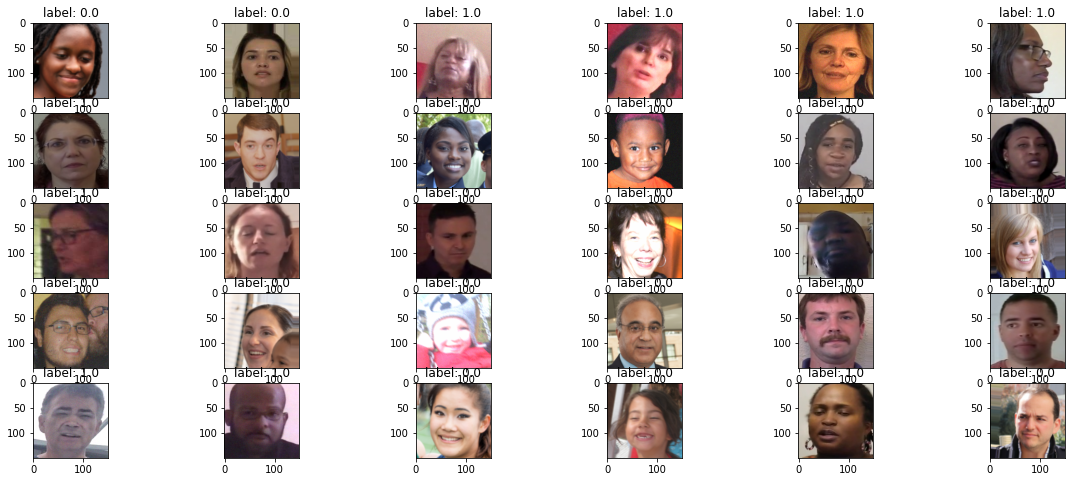

In [0]:
nrow, ncol = 5, 6
fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in enumerate(axes):
    image, label = train_dataset[i]
    image = np.rollaxis(image, 0, 3)
    image = image*std + mean
    image = np.clip(image, 0., 1.)
    ax.imshow(image)
    ax.set_title(f'label: {label}')

# Train

In [0]:
import gc

history = pd.DataFrame()
history2 = pd.DataFrame()

torch.cuda.empty_cache()
gc.collect()

best = 1e10
n_epochs = 20
batch_size = 128

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

model = model.cuda()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, mode='min', factor=0.7, verbose=True, min_lr=1e-5)

for epoch in range(n_epochs):
    torch.cuda.empty_cache()
    gc.collect()

    train_model(epoch, optimizer, scheduler=None, history=history)
    
    loss = evaluate_model(epoch, scheduler=scheduler, history=history2)
    
    if loss < best:
      best = loss
      print(f'Saving best model...')
      torch.save(model.state_dict(), f'/content/drive/My Drive/model.pth')


Epoch 1/20, LR: 0.001000, Loss: 0.2217: 100%|██████████| 1013/1013 [08:13<00:00,  2.05it/s]


Dev loss: 0.1782, Acc: 0.923134, Kaggle: 0.237180
Saving best model...



Epoch 2/20, LR: 0.001000, Loss: 0.1573: 100%|██████████| 1013/1013 [08:12<00:00,  2.05it/s]


Dev loss: 0.1587, Acc: 0.938278, Kaggle: 0.216827
Saving best model...



Epoch 3/20, LR: 0.001000, Loss: 0.1313: 100%|██████████| 1013/1013 [08:13<00:00,  2.05it/s]


Dev loss: 0.2296, Acc: 0.920596, Kaggle: 0.250849



Epoch 4/20, LR: 0.001000, Loss: 0.1202: 100%|██████████| 1013/1013 [08:13<00:00,  2.05it/s]


Dev loss: 0.1725, Acc: 0.941634, Kaggle: 0.213074



Epoch 5/20, LR: 0.001000, Loss: 0.1139: 100%|██████████| 1013/1013 [08:13<00:00,  2.05it/s]


Dev loss: 0.1318, Acc: 0.950229, Kaggle: 0.194056
Saving best model...



Epoch 6/20, LR: 0.001000, Loss: 0.1007: 100%|██████████| 1013/1013 [08:13<00:00,  2.05it/s]


Dev loss: 0.1451, Acc: 0.946054, Kaggle: 0.203333



Epoch 7/20, LR: 0.001000, Loss: 0.0938: 100%|██████████| 1013/1013 [08:13<00:00,  2.05it/s]


Dev loss: 0.1342, Acc: 0.945809, Kaggle: 0.200307



Epoch 8/20, LR: 0.001000, Loss: 0.0863: 100%|██████████| 1013/1013 [08:13<00:00,  2.05it/s]


Dev loss: 0.1551, Acc: 0.940079, Kaggle: 0.212310



Epoch 9/20, LR: 0.001000, Loss: 0.0849: 100%|██████████| 1013/1013 [08:13<00:00,  2.05it/s]


Dev loss: 0.1677, Acc: 0.940897, Kaggle: 0.214173



Epoch 10/20, LR: 0.001000, Loss: 0.0801: 100%|██████████| 1013/1013 [08:13<00:00,  2.05it/s]


Dev loss: 0.1441, Acc: 0.947200, Kaggle: 0.200310



Epoch 11/20, LR: 0.001000, Loss: 0.0774: 100%|██████████| 1013/1013 [08:13<00:00,  2.05it/s]


Epoch    11: reducing learning rate of group 0 to 7.0000e-04.
Dev loss: 0.1855, Acc: 0.939014, Kaggle: 0.219140



Epoch 12/20, LR: 0.000700, Loss: 0.0614: 100%|██████████| 1013/1013 [08:13<00:00,  2.05it/s]


Dev loss: 0.1673, Acc: 0.938687, Kaggle: 0.216019



Epoch 13/20, LR: 0.000700, Loss: 0.0613: 100%|██████████| 1013/1013 [08:14<00:00,  2.05it/s]


Dev loss: 0.1666, Acc: 0.947773, Kaggle: 0.204212



Epoch 14/20, LR: 0.000700, Loss: 0.0573: 100%|██████████| 1013/1013 [08:15<00:00,  2.05it/s]


Dev loss: 0.1621, Acc: 0.945318, Kaggle: 0.205332



Epoch 15/20, LR: 0.000700, Loss: 0.0586: 100%|██████████| 1013/1013 [08:15<00:00,  2.05it/s]


Dev loss: 0.1960, Acc: 0.943435, Kaggle: 0.212848



Epoch 16/20, LR: 0.000700, Loss: 0.0517: 100%|██████████| 1013/1013 [08:15<00:00,  2.04it/s]


Dev loss: 0.1735, Acc: 0.946300, Kaggle: 0.205417



Epoch 17/20, LR: 0.000700, Loss: 0.0503: 100%|██████████| 1013/1013 [08:15<00:00,  2.04it/s]


Epoch    17: reducing learning rate of group 0 to 4.9000e-04.
Dev loss: 0.1808, Acc: 0.944826, Kaggle: 0.209820



Epoch 18/20, LR: 0.000490, Loss: 0.0430: 100%|██████████| 1013/1013 [08:14<00:00,  2.05it/s]


Dev loss: 0.1868, Acc: 0.945891, Kaggle: 0.209283



Epoch 19/20, LR: 0.000490, Loss: 0.0418: 100%|██████████| 1013/1013 [08:14<00:00,  2.05it/s]


Dev loss: 0.1755, Acc: 0.949820, Kaggle: 0.200986



Epoch 20/20, LR: 0.000490, Loss: 0.0402: 100%|██████████| 1013/1013 [08:14<00:00,  2.05it/s]


Dev loss: 0.2280, Acc: 0.938933, Kaggle: 0.223867


In [0]:
history2.plot()

NameError: ignored

## View this kernal for inference and submission: https://www.kaggle.com/greatgamedota/xception-binary-classifier-inference